c:\Users\varun\anaconda3\envs\MINI2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Node features shape: (256248, 6)
Labels shape: torch.Size([256248])
Max edge index: 256247, Number of nodes: 256248
Epoch   0 | Loss: 0.6919 | Train Accuracy: 92.01% | Test Accuracy: 92.19%
Epoch  10 | Loss: 0.4717 | Train Accuracy: 91.47% | Test Accuracy: 92.19%
Epoch  20 | Loss: 0.4420 | Train Accuracy: 87.24% | Test Accuracy: 87.79%
Epoch  30 | Loss: 0.4282 | Train Accuracy: 89.39% | Test Accuracy: 89.01%
Epoch  40 | Loss: 0.4089 | Train Accuracy: 89.80% | Test Accuracy: 89.91%
Epoch  50 | Loss: 0.3975 | Train Accuracy: 89.71% | Test Accuracy: 93.26%
Epoch  60 | Loss: 0.4123 | Train Accuracy: 89.71% | Test Accuracy: 89.81%
Epoch  70 | Loss: 0.3896 | Train Accuracy: 89.76% | Test Accuracy: 93.99%
Epoch  80 | Loss: 0.3788 | Train Accuracy: 94.00% | Test Accuracy: 93.99%
Epoch  90 | Loss: 0.3724 | Train Accuracy: 94.01% | Test Accuracy: 94.00%
Epoch 100 | Loss: 0.3696 | Train Accuracy: 94.01% | Test Accuracy: 94.01%
Epoch 110 | Loss: 0.3798 | Train Accuracy: 90.56% | Test Accuracy: 89.

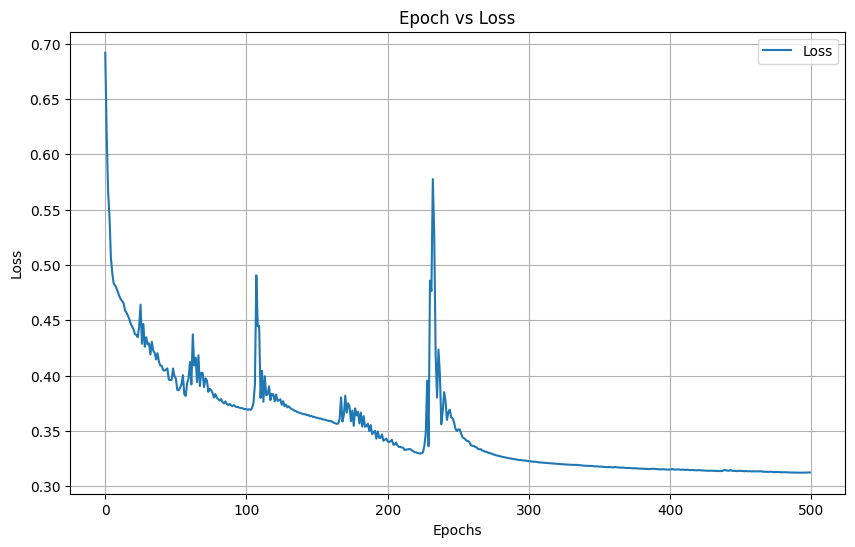

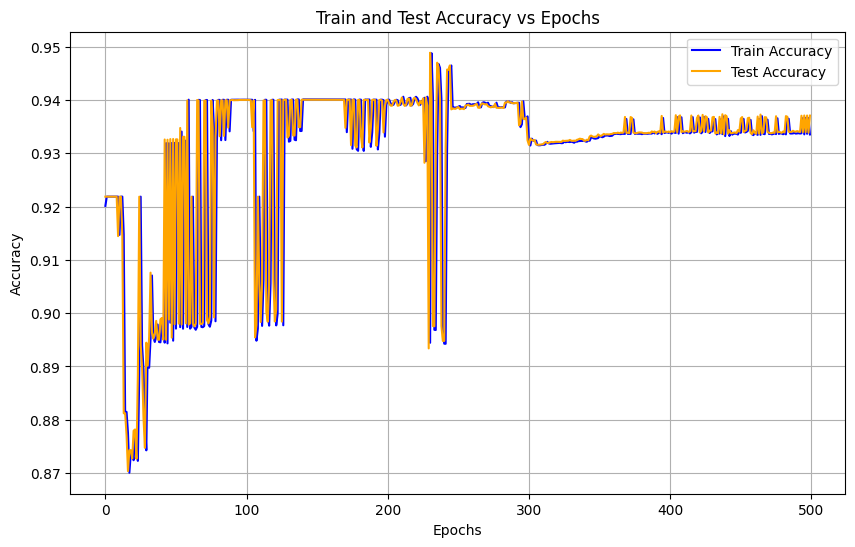

Precision: 0.5994
Recall: 0.5872
F1 Score: 0.5932


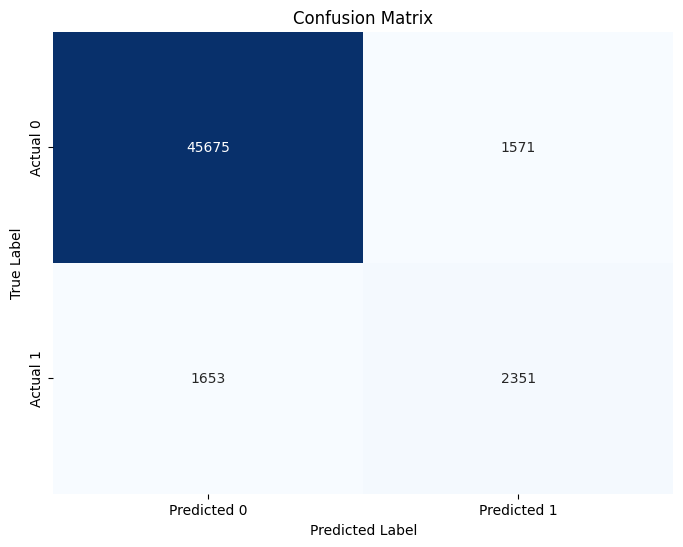

In [1]:
#GAT
import torch
import os
import torch.nn.functional as F
import seaborn as sns
from torch_geometric.nn import GATConv
from torch_geometric.data import Data
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

# Load edges
edge_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\2--12\extractedcolumns1.txt"
edges = np.loadtxt(edge_file, dtype=int)

# Load node features
feature_folder = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\2--12\features"
node_features_list = []
for file_name in os.listdir(feature_folder):
    if file_name.startswith("feature") and file_name.endswith(".txt"):
        file_path = os.path.join(feature_folder, file_name)
        try:
            feature_data = np.loadtxt(file_path, dtype=float)
            if feature_data.size == 0:
                print(f"Warning: {file_name} is empty. Skipping this file.")
            else:
                node_features_list.append(feature_data)
        except ValueError as e:
            print(f"Warning: Could not read {file_name}. Error: {e}")

if node_features_list:
    node_features = np.column_stack(node_features_list)
else:
    raise ValueError("No valid feature files found. Please check your input files.")

# Load labels
labels_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\2--12\node_contract_status_connected.txt"
labels = torch.tensor(np.loadtxt(labels_file, dtype=int), dtype=torch.long)

print(f"Node features shape: {node_features.shape}")
print(f"Labels shape: {labels.shape}")

# Create graph
G = nx.DiGraph()
G.add_edges_from(edges)
edge_index = torch.tensor(list(G.edges), dtype=torch.long).t().contiguous()

max_edge_index = edge_index.max()
num_nodes = node_features.shape[0]
print(f"Max edge index: {max_edge_index.item()}, Number of nodes: {num_nodes}")

if max_edge_index >= num_nodes:
    raise IndexError(f"Edge index {max_edge_index.item()} is out of bounds for number of nodes {num_nodes}.")

data = Data(x=torch.tensor(node_features, dtype=torch.float), y=labels, edge_index=edge_index)

# Define GAT model

class GAT(torch.nn.Module):
    def __init__(self):
        super(GAT, self).__init__()
       
        self.conv1 = GATConv(data.num_node_features, 16, heads=8, concat=True)
  
        self.conv2 = GATConv(16 * 8, 16, heads=8, concat=True)
    
        self.conv3 = GATConv(16 * 8, 16, heads=8, concat=True)
        
        self.conv4 = GATConv(16 * 8, 2, heads=1, concat=False)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)
        x = x.relu()
        x = self.conv4(x, edge_index)
        return x


model = GAT()

class_counts = torch.bincount(data.y)
# Use log scaling for weights
# class_weights = 1.0 / (class_counts.float() + 1e-6)  # Add small value to avoid division by zero
# class_weights = torch.log1p(class_weights)  # Apply logarithmic normalization

# criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

# Apply square root scaling
class_weights = 1.0 / torch.sqrt(class_counts.float() + 1e-6)

criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

# class_counts = torch.bincount(data.y)
# class_weights = 1.0 / class_counts.float()
# criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

y_0_indices = (data.y == 0).nonzero(as_tuple=True)[0]
y_1_indices = (data.y == 1).nonzero(as_tuple=True)[0]

np.random.shuffle(y_0_indices.numpy())
np.random.shuffle(y_1_indices.numpy())

train_0_size = int(0.8 * len(y_0_indices))
train_1_size = int(0.8 * len(y_1_indices))

train_indices = torch.cat([y_0_indices[:train_0_size], y_1_indices[:train_1_size]])
test_indices = torch.cat([y_0_indices[train_0_size:], y_1_indices[train_1_size:]])

train_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[train_indices] = True
test_mask[test_indices] = True

# Training loop
train_accuracies = []
test_accuracies = []
loss_values = []

for epoch in range(500):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[train_mask], data.y[train_mask])
    loss.backward()
    optimizer.step()

    pred_train = out.argmax(dim=1)
    train_acc = (pred_train[train_mask] == data.y[train_mask]).sum().item() / train_mask.sum().item()

    model.eval()
    with torch.no_grad():
        out_test = model(data.x, data.edge_index)
        pred_test = out_test.argmax(dim=1)
        test_acc = (pred_test[test_mask] == data.y[test_mask]).sum().item() / test_mask.sum().item()

    loss_values.append(loss.item())
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    if epoch % 10 == 0:
        print(f'Epoch {epoch:>3} | Loss: {loss.item():.4f} | Train Accuracy: {train_acc*100:.2f}% | Test Accuracy: {test_acc*100:.2f}%')

# Plotting loss and accuracy
plt.figure(figsize=(10, 6))
plt.plot(range(500), loss_values, label="Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Epoch vs Loss")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range(500), train_accuracies, label="Train Accuracy", color='blue')
plt.plot(range(500), test_accuracies, label="Test Accuracy", color='orange')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train and Test Accuracy vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

# Evaluation metrics
model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index)
    y_pred = out.argmax(dim=1).cpu().numpy()
    y_true = data.y.cpu().numpy()

conf_matrix = confusion_matrix(y_true[test_mask], y_pred[test_mask])
precision = precision_score(y_true[test_mask], y_pred[test_mask], average='binary', zero_division=0)
recall = recall_score(y_true[test_mask], y_pred[test_mask], average='binary', zero_division=0)
f1 = f1_score(y_true[test_mask], y_pred[test_mask], average='binary', zero_division=0)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


Node features shape: (256248, 6)
Labels shape: torch.Size([256248])
Max edge index: 256247, Number of nodes: 256248
Epoch   0 | Loss: 0.7009 | Train Accuracy: 35.05% | Test Accuracy: 92.19%
Epoch  10 | Loss: 0.6003 | Train Accuracy: 92.19% | Test Accuracy: 92.19%
Epoch  20 | Loss: 0.5499 | Train Accuracy: 91.84% | Test Accuracy: 92.17%
Epoch  30 | Loss: 0.5175 | Train Accuracy: 92.16% | Test Accuracy: 92.18%
Epoch  40 | Loss: 0.4867 | Train Accuracy: 92.19% | Test Accuracy: 92.20%
Epoch  50 | Loss: 0.4481 | Train Accuracy: 92.15% | Test Accuracy: 92.02%
Epoch  60 | Loss: 0.4334 | Train Accuracy: 92.16% | Test Accuracy: 92.20%
Epoch  70 | Loss: 0.4258 | Train Accuracy: 92.16% | Test Accuracy: 92.19%
Epoch  80 | Loss: 0.4121 | Train Accuracy: 92.16% | Test Accuracy: 92.21%
Epoch  90 | Loss: 0.4071 | Train Accuracy: 92.17% | Test Accuracy: 92.41%
Epoch 100 | Loss: 0.3977 | Train Accuracy: 94.39% | Test Accuracy: 93.57%
Epoch 110 | Loss: 0.3949 | Train Accuracy: 93.57% | Test Accuracy: 90.

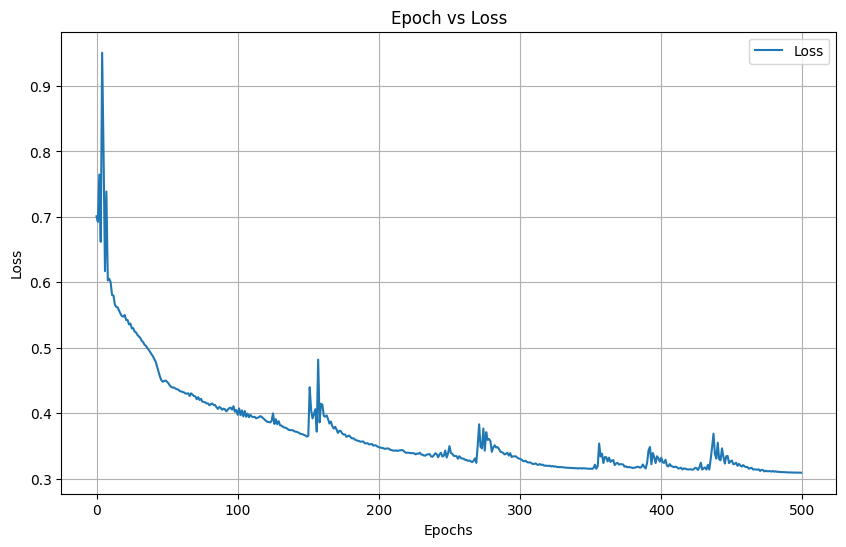

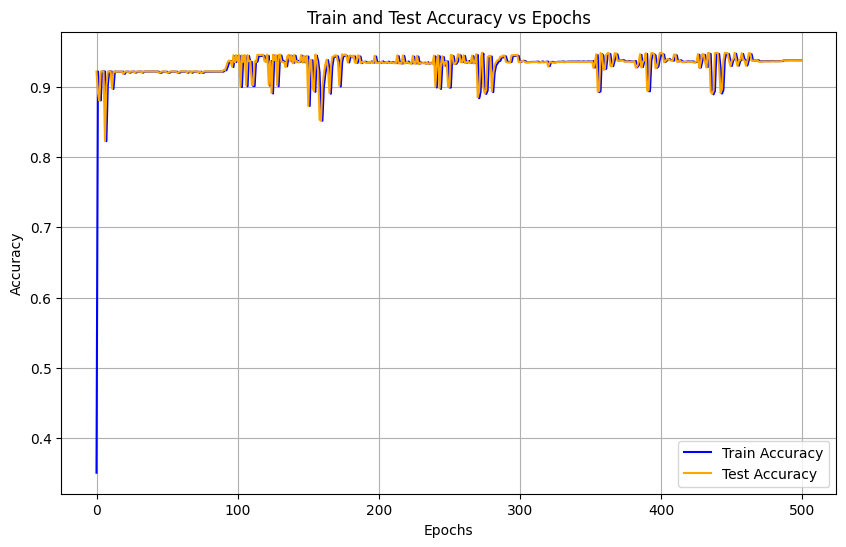

Precision: 0.6134
Recall: 0.5512
F1 Score: 0.5806


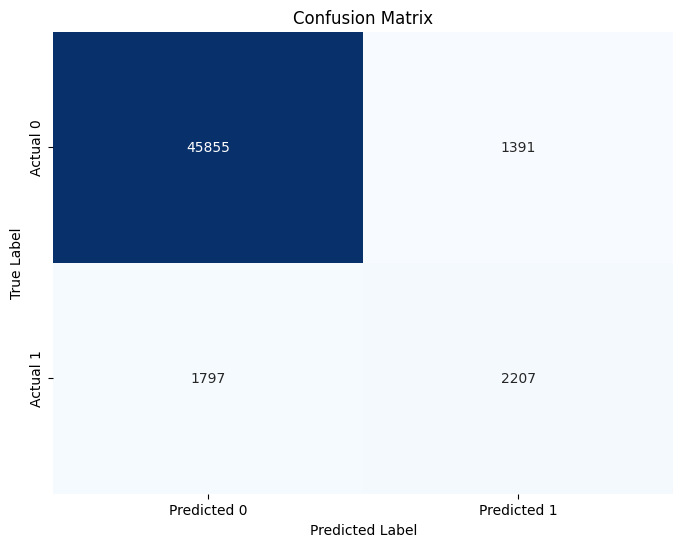

In [ ]:
#GIN
import torch
import os
import torch.nn.functional as F
import seaborn as sns
from torch_geometric.nn import GINConv
from torch_geometric.data import Data
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

# Load edges
edge_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\2--12\extractedcolumns1.txt"
edges = np.loadtxt(edge_file, dtype=int)

# Load node features
feature_folder = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\2--12\features"
node_features_list = []
for file_name in os.listdir(feature_folder):
    if file_name.startswith("feature") and file_name.endswith(".txt"):
        file_path = os.path.join(feature_folder, file_name)
        try:
            feature_data = np.loadtxt(file_path, dtype=float)
            if feature_data.size == 0:
                print(f"Warning: {file_name} is empty. Skipping this file.")
            else:
                node_features_list.append(feature_data)
        except ValueError as e:
            print(f"Warning: Could not read {file_name}. Error: {e}")

if node_features_list:
    node_features = np.column_stack(node_features_list)
else:
    raise ValueError("No valid feature files found. Please check your input files.")

# Load labels
labels_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\2--12\node_contract_status_connected.txt"
labels = torch.tensor(np.loadtxt(labels_file, dtype=int), dtype=torch.long)

print(f"Node features shape: {node_features.shape}")
print(f"Labels shape: {labels.shape}")

# Create graph
G = nx.DiGraph()
G.add_edges_from(edges)
edge_index = torch.tensor(list(G.edges), dtype=torch.long).t().contiguous()

max_edge_index = edge_index.max()
num_nodes = node_features.shape[0]
print(f"Max edge index: {max_edge_index.item()}, Number of nodes: {num_nodes}")

if max_edge_index >= num_nodes:
    raise IndexError(f"Edge index {max_edge_index.item()} is out of bounds for number of nodes {num_nodes}.")

data = Data(x=torch.tensor(node_features, dtype=torch.float), y=labels, edge_index=edge_index)

# Define GIN model
class GIN(torch.nn.Module):
    def __init__(self):
        super(GIN, self).__init__()
        
        # Define the GINConv layers with MLPs
        self.conv1 = GINConv(torch.nn.Sequential(
            torch.nn.Linear(data.num_node_features, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 32),
            torch.nn.ReLU()
        ))

        self.conv2 = GINConv(torch.nn.Sequential(
            torch.nn.Linear(32, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 32),
            torch.nn.ReLU()
        ))

        self.conv3 = GINConv(torch.nn.Sequential(
            torch.nn.Linear(32, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 32),
            torch.nn.ReLU()
        ))

        self.conv4 = GINConv(torch.nn.Sequential(
            torch.nn.Linear(32, 16),
            torch.nn.ReLU(),
            torch.nn.Linear(16, 2)  # Output layer for 2 classes
        ))

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)
        x = x.relu()
        x = self.conv4(x, edge_index)
        return x


model = GIN()

class_counts = torch.bincount(data.y)
#class_weights = 1.0 / class_counts.float()
#criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

class_weights = 1.0 / torch.sqrt(class_counts.float() + 1e-6)

criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Split data into train and test
y_0_indices = (data.y == 0).nonzero(as_tuple=True)[0]
y_1_indices = (data.y == 1).nonzero(as_tuple=True)[0]

np.random.shuffle(y_0_indices.numpy())
np.random.shuffle(y_1_indices.numpy())

train_0_size = int(0.8 * len(y_0_indices))
train_1_size = int(0.8 * len(y_1_indices))

train_indices = torch.cat([y_0_indices[:train_0_size], y_1_indices[:train_1_size]])
test_indices = torch.cat([y_0_indices[train_0_size:], y_1_indices[train_1_size:]])

train_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[train_indices] = True
test_mask[test_indices] = True

# Training loop
train_accuracies = []
test_accuracies = []
loss_values = []

for epoch in range(500):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[train_mask], data.y[train_mask])
    loss.backward()
    optimizer.step()

    pred_train = out.argmax(dim=1)
    train_acc = (pred_train[train_mask] == data.y[train_mask]).sum().item() / train_mask.sum().item()

    model.eval()
    with torch.no_grad():
        out_test = model(data.x, data.edge_index)
        pred_test = out_test.argmax(dim=1)
        test_acc = (pred_test[test_mask] == data.y[test_mask]).sum().item() / test_mask.sum().item()

    loss_values.append(loss.item())
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    if epoch % 10 == 0:
        print(f'Epoch {epoch:>3} | Loss: {loss.item():.4f} | Train Accuracy: {train_acc*100:.2f}% | Test Accuracy: {test_acc*100:.2f}%')

# Plotting loss and accuracy
plt.figure(figsize=(10, 6))
plt.plot(range(500), loss_values, label="Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Epoch vs Loss")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range(500), train_accuracies, label="Train Accuracy", color='blue')
plt.plot(range(500), test_accuracies, label="Test Accuracy", color='orange')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train and Test Accuracy vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

# Evaluation metrics
model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index)
    y_pred = out.argmax(dim=1).cpu().numpy()
    y_true = data.y.cpu().numpy()

conf_matrix = confusion_matrix(y_true[test_mask], y_pred[test_mask])
precision = precision_score(y_true[test_mask], y_pred[test_mask], average='binary', zero_division=0)
recall = recall_score(y_true[test_mask], y_pred[test_mask], average='binary', zero_division=0)
f1 = f1_score(y_true[test_mask], y_pred[test_mask], average='binary', zero_division=0)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


Node features shape: (256248, 6)
Labels shape: torch.Size([256248])
Max edge index: 256247, Number of nodes: 256248
Epoch   0 | Loss: 0.6885 | Train Accuracy: 57.13% | Test Accuracy: 92.19%
Epoch  10 | Loss: 0.5887 | Train Accuracy: 92.19% | Test Accuracy: 92.19%
Epoch  20 | Loss: 0.5519 | Train Accuracy: 92.19% | Test Accuracy: 92.19%
Epoch  30 | Loss: 0.5305 | Train Accuracy: 92.40% | Test Accuracy: 91.57%
Epoch  40 | Loss: 0.5222 | Train Accuracy: 88.28% | Test Accuracy: 88.28%
Epoch  50 | Loss: 0.5141 | Train Accuracy: 88.28% | Test Accuracy: 88.27%
Epoch  60 | Loss: 0.5037 | Train Accuracy: 88.28% | Test Accuracy: 88.26%
Epoch  70 | Loss: 0.4899 | Train Accuracy: 88.23% | Test Accuracy: 88.23%
Epoch  80 | Loss: 0.4718 | Train Accuracy: 88.08% | Test Accuracy: 88.05%
Epoch  90 | Loss: 0.4540 | Train Accuracy: 88.02% | Test Accuracy: 88.08%
Epoch 100 | Loss: 0.4395 | Train Accuracy: 89.32% | Test Accuracy: 88.81%
Epoch 110 | Loss: 0.4266 | Train Accuracy: 89.05% | Test Accuracy: 90.

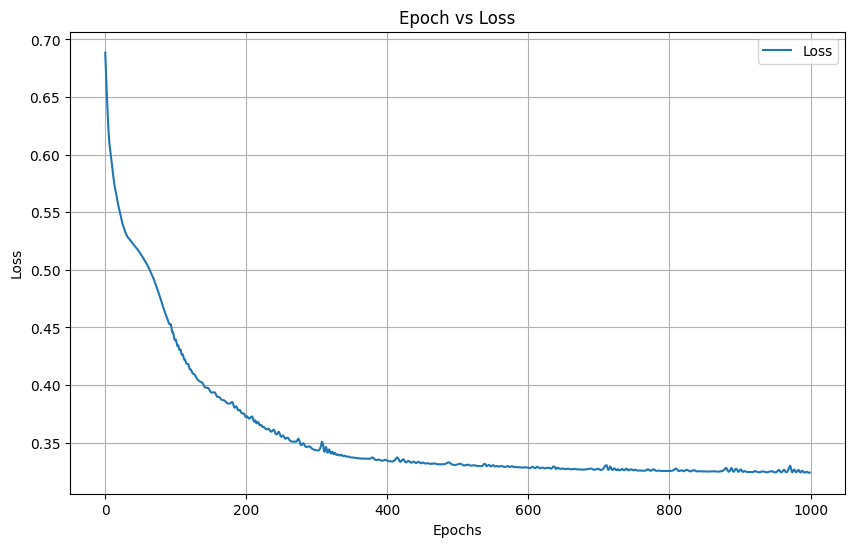

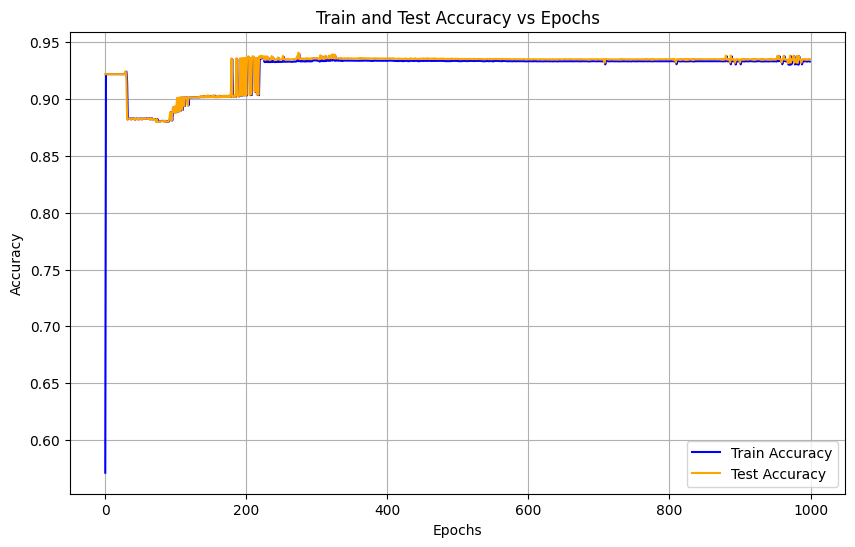

Precision: 0.5840
Recall: 0.5844
F1 Score: 0.5842


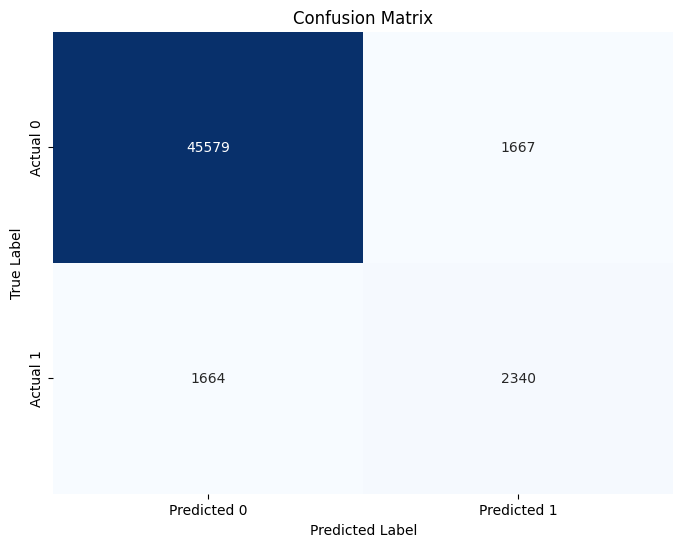

In [8]:
#GCN
import torch
import os
import torch.nn.functional as F
import seaborn as sns
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

# Load edges
edge_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\2--12\extractedcolumns1.txt"
edges = np.loadtxt(edge_file, dtype=int)

# Load node features
feature_folder = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\2--12\features"
node_features_list = []
for file_name in os.listdir(feature_folder):
    if file_name.startswith("feature") and file_name.endswith(".txt"):
        file_path = os.path.join(feature_folder, file_name)
        try:
            feature_data = np.loadtxt(file_path, dtype=float)
            if feature_data.size == 0:
                print(f"Warning: {file_name} is empty. Skipping this file.")
            else:
                node_features_list.append(feature_data)
        except ValueError as e:
            print(f"Warning: Could not read {file_name}. Error: {e}")

if node_features_list:
    node_features = np.column_stack(node_features_list)
else:
    raise ValueError("No valid feature files found. Please check your input files.")

# Load labels
labels_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\2--12\node_contract_status_connected.txt"
labels = torch.tensor(np.loadtxt(labels_file, dtype=int), dtype=torch.long)

print(f"Node features shape: {node_features.shape}")
print(f"Labels shape: {labels.shape}")

# Create graph
G = nx.DiGraph()
G.add_edges_from(edges)
edge_index = torch.tensor(list(G.edges), dtype=torch.long).t().contiguous()

max_edge_index = edge_index.max()
num_nodes = node_features.shape[0]
print(f"Max edge index: {max_edge_index.item()}, Number of nodes: {num_nodes}")

if max_edge_index >= num_nodes:
    raise IndexError(f"Edge index {max_edge_index.item()} is out of bounds for number of nodes {num_nodes}.")

data = Data(x=torch.tensor(node_features, dtype=torch.float), y=labels, edge_index=edge_index)

# Define GCN model
class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(data.num_node_features, 16)
        self.conv2 = GCNConv(16, 16)
        self.conv3 = GCNConv(16, 16)
        self.conv4 = GCNConv(16, 2)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)
        x = x.relu()
        x = self.conv4(x, edge_index)
        return x

model = GCN()

class_counts = torch.bincount(data.y)
#class_weights = 1.0 / class_counts.float()
#criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
class_weights = 1.0 / torch.sqrt(class_counts.float() + 1e-6)

criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

y_0_indices = (data.y == 0).nonzero(as_tuple=True)[0]
y_1_indices = (data.y == 1).nonzero(as_tuple=True)[0]

np.random.shuffle(y_0_indices.numpy())
np.random.shuffle(y_1_indices.numpy())

train_0_size = int(0.8 * len(y_0_indices))
train_1_size = int(0.8 * len(y_1_indices))

train_indices = torch.cat([y_0_indices[:train_0_size], y_1_indices[:train_1_size]])
test_indices = torch.cat([y_0_indices[train_0_size:], y_1_indices[train_1_size:]])

train_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[train_indices] = True
test_mask[test_indices] = True

# Training loop
train_accuracies = []
test_accuracies = []
loss_values = []

for epoch in range(1000):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[train_mask], data.y[train_mask])
    loss.backward()
    optimizer.step()

    pred_train = out.argmax(dim=1)
    train_acc = (pred_train[train_mask] == data.y[train_mask]).sum().item() / train_mask.sum().item()

    model.eval()
    with torch.no_grad():
        out_test = model(data.x, data.edge_index)
        pred_test = out_test.argmax(dim=1)
        test_acc = (pred_test[test_mask] == data.y[test_mask]).sum().item() / test_mask.sum().item()

    loss_values.append(loss.item())
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    if epoch % 10 == 0:
        print(f'Epoch {epoch:>3} | Loss: {loss.item():.4f} | Train Accuracy: {train_acc*100:.2f}% | Test Accuracy: {test_acc*100:.2f}%')

# Plotting loss and accuracy
plt.figure(figsize=(10, 6))
plt.plot(range(1000), loss_values, label="Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Epoch vs Loss")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range(1000), train_accuracies, label="Train Accuracy", color='blue')
plt.plot(range(1000), test_accuracies, label="Test Accuracy", color='orange')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train and Test Accuracy vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

# Evaluation metrics
model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index)
    y_pred = out.argmax(dim=1).cpu().numpy()
    y_true = data.y.cpu().numpy()

conf_matrix = confusion_matrix(y_true[test_mask], y_pred[test_mask])
precision = precision_score(y_true[test_mask], y_pred[test_mask], average='binary', zero_division=0)
recall = recall_score(y_true[test_mask], y_pred[test_mask], average='binary', zero_division=0)
f1 = f1_score(y_true[test_mask], y_pred[test_mask], average='binary', zero_division=0)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


Node features shape: (256248, 6)
Labels shape: torch.Size([256248])
Max edge index: 256247, Number of nodes: 256248
Epoch   0 | Loss: 0.8479 | Train Accuracy: 7.81% | Test Accuracy: 7.81%
Epoch  10 | Loss: 0.5047 | Train Accuracy: 87.68% | Test Accuracy: 87.68%
Epoch  20 | Loss: 0.4297 | Train Accuracy: 89.85% | Test Accuracy: 89.84%
Epoch  30 | Loss: 0.3932 | Train Accuracy: 89.98% | Test Accuracy: 89.94%
Epoch  40 | Loss: 0.3632 | Train Accuracy: 89.89% | Test Accuracy: 89.78%
Epoch  50 | Loss: 0.3484 | Train Accuracy: 93.02% | Test Accuracy: 94.17%
Epoch  60 | Loss: 0.3406 | Train Accuracy: 93.44% | Test Accuracy: 93.39%
Epoch  70 | Loss: 0.3359 | Train Accuracy: 93.50% | Test Accuracy: 93.43%
Epoch  80 | Loss: 0.3321 | Train Accuracy: 93.65% | Test Accuracy: 93.62%
Epoch  90 | Loss: 0.3320 | Train Accuracy: 93.69% | Test Accuracy: 93.54%
Epoch 100 | Loss: 0.3294 | Train Accuracy: 93.70% | Test Accuracy: 93.62%
Epoch 110 | Loss: 0.3269 | Train Accuracy: 93.64% | Test Accuracy: 93.63

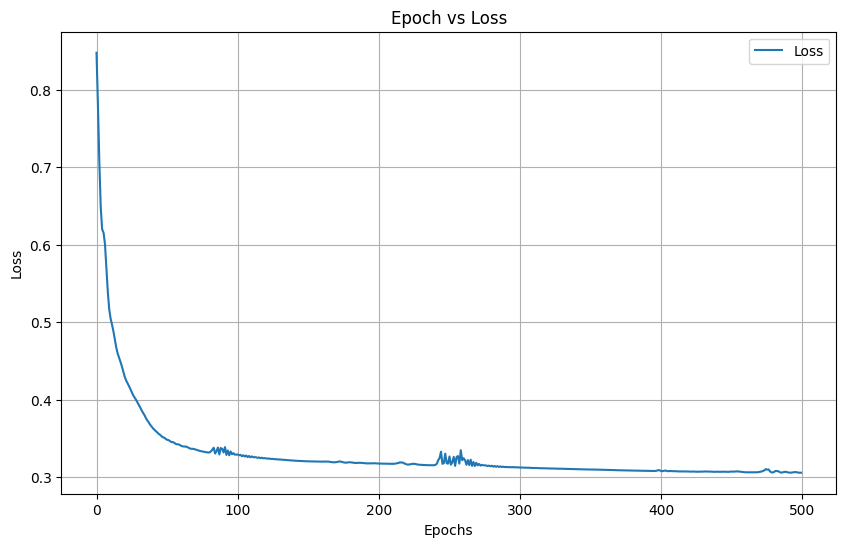

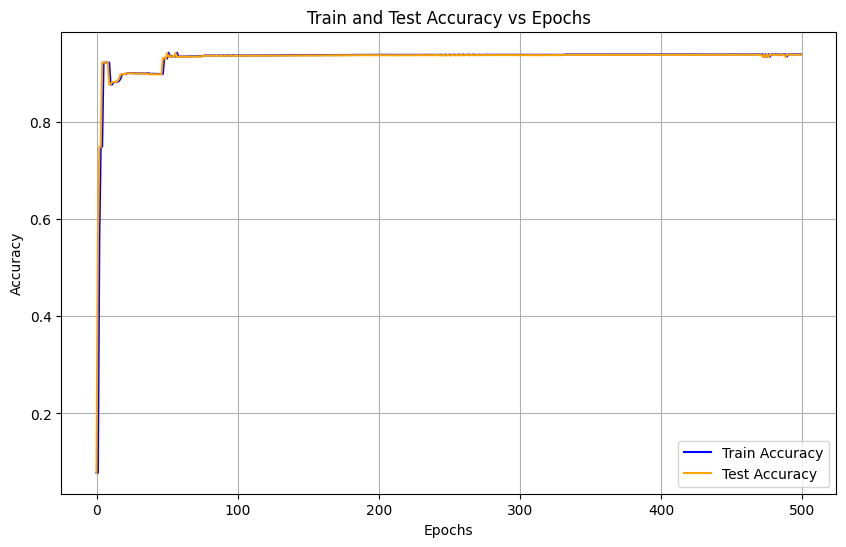

Precision: 0.6263
Recall: 0.5202
F1 Score: 0.5683


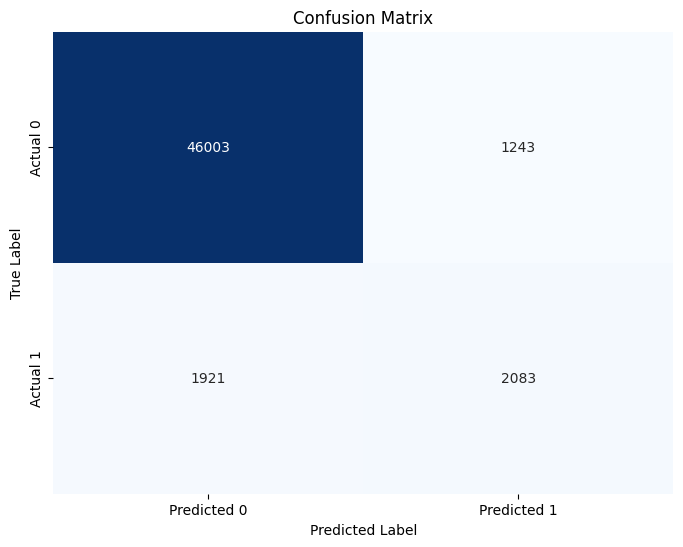

In [10]:
#GNN
import torch
import os
import torch.nn.functional as F
import seaborn as sns
from torch_geometric.nn import SAGEConv
from torch_geometric.data import Data
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

# Load edges
edge_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\2--12\extractedcolumns1.txt"
edges = np.loadtxt(edge_file, dtype=int)

# Load node features
feature_folder = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\2--12\features"
node_features_list = []
for file_name in os.listdir(feature_folder):
    if file_name.startswith("feature") and file_name.endswith(".txt"):
        file_path = os.path.join(feature_folder, file_name)
        try:
            feature_data = np.loadtxt(file_path, dtype=float)
            if feature_data.size == 0:
                print(f"Warning: {file_name} is empty. Skipping this file.")
            else:
                node_features_list.append(feature_data)
        except ValueError as e:
            print(f"Warning: Could not read {file_name}. Error: {e}")

if node_features_list:
    node_features = np.column_stack(node_features_list)
else:
    raise ValueError("No valid feature files found. Please check your input files.")

# Load labels
labels_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\2--12\node_contract_status_connected.txt"
labels = torch.tensor(np.loadtxt(labels_file, dtype=int), dtype=torch.long)

print(f"Node features shape: {node_features.shape}")
print(f"Labels shape: {labels.shape}")

# Create graph
G = nx.DiGraph()
G.add_edges_from(edges)
edge_index = torch.tensor(list(G.edges), dtype=torch.long).t().contiguous()

max_edge_index = edge_index.max()
num_nodes = node_features.shape[0]
print(f"Max edge index: {max_edge_index.item()}, Number of nodes: {num_nodes}")

if max_edge_index >= num_nodes:
    raise IndexError(f"Edge index {max_edge_index.item()} is out of bounds for number of nodes {num_nodes}.")

data = Data(x=torch.tensor(node_features, dtype=torch.float), y=labels, edge_index=edge_index)

# Define GNN model
class GNN(torch.nn.Module):
    def __init__(self):
        super(GNN, self).__init__()
        self.conv1 = SAGEConv(data.num_node_features, 32)
        self.conv2 = SAGEConv(32, 16)
        self.conv3 = SAGEConv(16, 8)
        self.conv4 = SAGEConv(8, 2)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x = self.conv4(x, edge_index)
        return x

model = GNN()

class_counts = torch.bincount(data.y)
#class_weights = 1.0 / class_counts.float()
#criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
class_weights = 1.0 / torch.sqrt(class_counts.float() + 1e-6)

criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

y_0_indices = (data.y == 0).nonzero(as_tuple=True)[0]
y_1_indices = (data.y == 1).nonzero(as_tuple=True)[0]

np.random.shuffle(y_0_indices.numpy())
np.random.shuffle(y_1_indices.numpy())

train_0_size = int(0.8 * len(y_0_indices))
train_1_size = int(0.8 * len(y_1_indices))

train_indices = torch.cat([y_0_indices[:train_0_size], y_1_indices[:train_1_size]])
test_indices = torch.cat([y_0_indices[train_0_size:], y_1_indices[train_1_size:]])

train_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[train_indices] = True
test_mask[test_indices] = True

# Training loop
train_accuracies = []
test_accuracies = []
loss_values = []

for epoch in range(500):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[train_mask], data.y[train_mask])
    loss.backward()
    optimizer.step()

    pred_train = out.argmax(dim=1)
    train_acc = (pred_train[train_mask] == data.y[train_mask]).sum().item() / train_mask.sum().item()

    model.eval()
    with torch.no_grad():
        out_test = model(data.x, data.edge_index)
        pred_test = out_test.argmax(dim=1)
        test_acc = (pred_test[test_mask] == data.y[test_mask]).sum().item() / test_mask.sum().item()

    loss_values.append(loss.item())
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    if epoch % 10 == 0:
        print(f'Epoch {epoch:>3} | Loss: {loss.item():.4f} | Train Accuracy: {train_acc*100:.2f}% | Test Accuracy: {test_acc*100:.2f}%')

# Plotting loss and accuracy
plt.figure(figsize=(10, 6))
plt.plot(range(500), loss_values, label="Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Epoch vs Loss")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range(500), train_accuracies, label="Train Accuracy", color='blue')
plt.plot(range(500), test_accuracies, label="Test Accuracy", color='orange')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train and Test Accuracy vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

# Evaluation metrics
model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index)
    y_pred = out.argmax(dim=1).cpu().numpy()
    y_true = data.y.cpu().numpy()

conf_matrix = confusion_matrix(y_true[test_mask], y_pred[test_mask])
precision = precision_score(y_true[test_mask], y_pred[test_mask], average='binary', zero_division=0)
recall = recall_score(y_true[test_mask], y_pred[test_mask], average='binary', zero_division=0)
f1 = f1_score(y_true[test_mask], y_pred[test_mask], average='binary', zero_division=0)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


Node features shape: (256248, 6)
Labels shape: torch.Size([256248])
Max edge index: 256247, Number of nodes: 256248
Epoch   0 | Loss: 0.6980 | Train Accuracy: 36.50% | Test Accuracy: 92.19%
Epoch  10 | Loss: 0.4303 | Train Accuracy: 87.68% | Test Accuracy: 89.84%
Epoch  20 | Loss: 0.3804 | Train Accuracy: 90.00% | Test Accuracy: 90.04%
Epoch  30 | Loss: 0.3441 | Train Accuracy: 94.42% | Test Accuracy: 94.28%
Epoch  40 | Loss: 0.3326 | Train Accuracy: 93.68% | Test Accuracy: 93.39%
Epoch  50 | Loss: 0.3266 | Train Accuracy: 93.57% | Test Accuracy: 93.55%
Epoch  60 | Loss: 0.3243 | Train Accuracy: 93.61% | Test Accuracy: 93.56%
Epoch  70 | Loss: 0.3218 | Train Accuracy: 93.64% | Test Accuracy: 93.60%
Epoch  80 | Loss: 0.3196 | Train Accuracy: 93.74% | Test Accuracy: 93.71%
Epoch  90 | Loss: 0.3220 | Train Accuracy: 93.76% | Test Accuracy: 93.72%
Epoch 100 | Loss: 0.3183 | Train Accuracy: 93.78% | Test Accuracy: 93.78%
Epoch 110 | Loss: 0.3157 | Train Accuracy: 93.81% | Test Accuracy: 93.

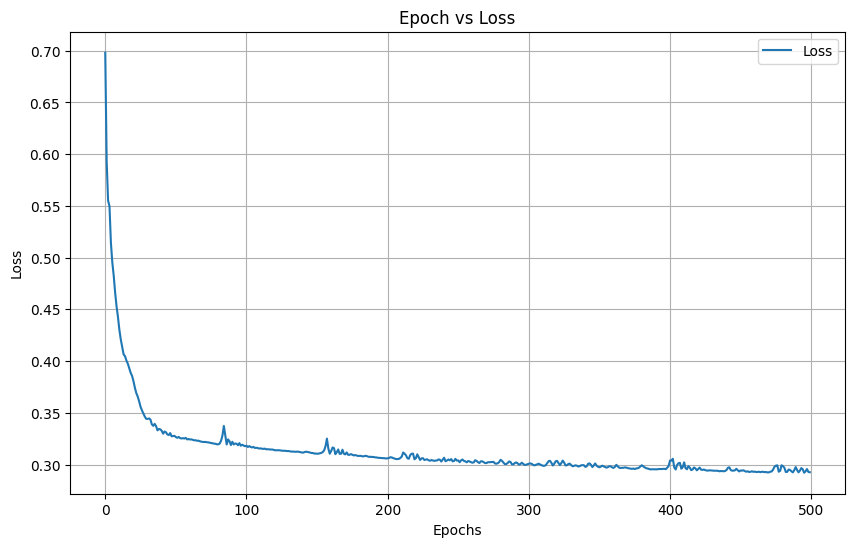

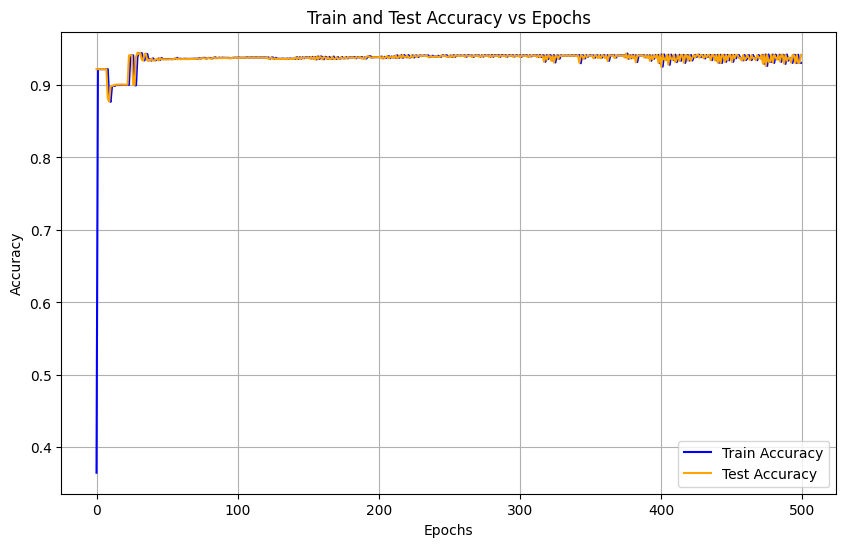

Precision: 0.6504
Recall: 0.5455
F1 Score: 0.5933


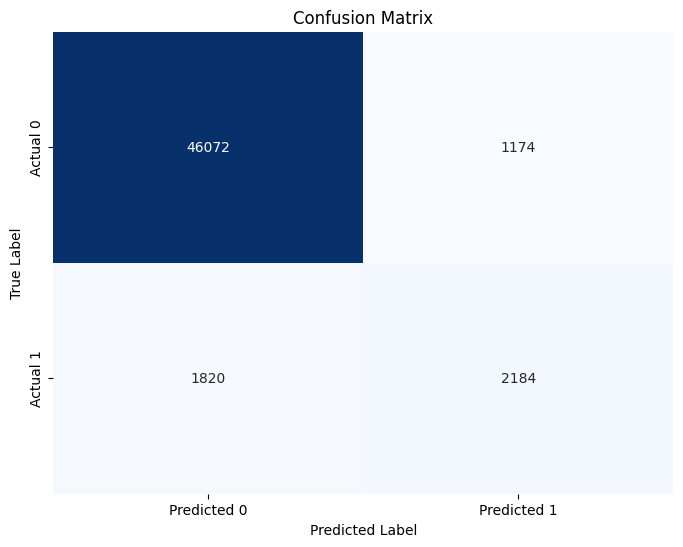

In [11]:
#GRAPHSAGE
import torch
import os
import torch.nn.functional as F
import seaborn as sns
from torch_geometric.nn import SAGEConv
from torch_geometric.data import Data
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

# Load edges
edge_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\2--12\extractedcolumns1.txt"
edges = np.loadtxt(edge_file, dtype=int)

# Load node features
feature_folder = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\2--12\features"
node_features_list = []
for file_name in os.listdir(feature_folder):
    if file_name.startswith("feature") and file_name.endswith(".txt"):
        file_path = os.path.join(feature_folder, file_name)
        try:
            feature_data = np.loadtxt(file_path, dtype=float)
            if feature_data.size == 0:
                print(f"Warning: {file_name} is empty. Skipping this file.")
            else:
                node_features_list.append(feature_data)
        except ValueError as e:
            print(f"Warning: Could not read {file_name}. Error: {e}")

if node_features_list:
    node_features = np.column_stack(node_features_list)
else:
    raise ValueError("No valid feature files found. Please check your input files.")

# Load labels
labels_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\2--12\node_contract_status_connected.txt"
labels = torch.tensor(np.loadtxt(labels_file, dtype=int), dtype=torch.long)

print(f"Node features shape: {node_features.shape}")
print(f"Labels shape: {labels.shape}")

# Create graph
G = nx.DiGraph()
G.add_edges_from(edges)
edge_index = torch.tensor(list(G.edges), dtype=torch.long).t().contiguous()

max_edge_index = edge_index.max()
num_nodes = node_features.shape[0]
print(f"Max edge index: {max_edge_index.item()}, Number of nodes: {num_nodes}")

if max_edge_index >= num_nodes:
    raise IndexError(f"Edge index {max_edge_index.item()} is out of bounds for number of nodes {num_nodes}.")

data = Data(x=torch.tensor(node_features, dtype=torch.float), y=labels, edge_index=edge_index)

# Define GraphSAGE model
class GraphSAGE(torch.nn.Module):
    def __init__(self):
        super(GraphSAGE, self).__init__()
        
        self.conv1 = SAGEConv(data.num_node_features, 64)
        self.conv2 = SAGEConv(64, 64)
        self.conv3 = SAGEConv(64, 64)
        self.fc = torch.nn.Linear(64, 2)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x = self.fc(x)
        return x

model = GraphSAGE()

class_counts = torch.bincount(data.y)
#class_weights = 1.0 / class_counts.float()
#criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
class_weights = 1.0 / torch.sqrt(class_counts.float() + 1e-6)

criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

y_0_indices = (data.y == 0).nonzero(as_tuple=True)[0]
y_1_indices = (data.y == 1).nonzero(as_tuple=True)[0]

np.random.shuffle(y_0_indices.numpy())
np.random.shuffle(y_1_indices.numpy())

train_0_size = int(0.8 * len(y_0_indices))
train_1_size = int(0.8 * len(y_1_indices))

train_indices = torch.cat([y_0_indices[:train_0_size], y_1_indices[:train_1_size]])
test_indices = torch.cat([y_0_indices[train_0_size:], y_1_indices[train_1_size:]])

train_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[train_indices] = True
test_mask[test_indices] = True

# Training loop
train_accuracies = []
test_accuracies = []
loss_values = []

for epoch in range(500):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[train_mask], data.y[train_mask])
    loss.backward()
    optimizer.step()

    pred_train = out.argmax(dim=1)
    train_acc = (pred_train[train_mask] == data.y[train_mask]).sum().item() / train_mask.sum().item()

    model.eval()
    with torch.no_grad():
        out_test = model(data.x, data.edge_index)
        pred_test = out_test.argmax(dim=1)
        test_acc = (pred_test[test_mask] == data.y[test_mask]).sum().item() / test_mask.sum().item()

    loss_values.append(loss.item())
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    if epoch % 10 == 0:
        print(f'Epoch {epoch:>3} | Loss: {loss.item():.4f} | Train Accuracy: {train_acc*100:.2f}% | Test Accuracy: {test_acc*100:.2f}%')

# Plotting loss and accuracy
plt.figure(figsize=(10, 6))
plt.plot(range(500), loss_values, label="Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Epoch vs Loss")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range(500), train_accuracies, label="Train Accuracy", color='blue')
plt.plot(range(500), test_accuracies, label="Test Accuracy", color='orange')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train and Test Accuracy vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

# Evaluation metrics
model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index)
    y_pred = out.argmax(dim=1).cpu().numpy()
    y_true = data.y.cpu().numpy()

conf_matrix = confusion_matrix(y_true[test_mask], y_pred[test_mask])
precision = precision_score(y_true[test_mask], y_pred[test_mask], average='binary', zero_division=0)
recall = recall_score(y_true[test_mask], y_pred[test_mask], average='binary', zero_division=0)
f1 = f1_score(y_true[test_mask], y_pred[test_mask], average='binary', zero_division=0)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


Node features shape: (256248, 6)
Labels shape: torch.Size([256248])
Max edge index: 256247, Number of nodes: 256248
Epoch   0 | Loss: 0.6965 | Train Accuracy: 7.81% | Validation Accuracy: 85.58%
Epoch  10 | Loss: 0.5827 | Train Accuracy: 92.19% | Validation Accuracy: 92.43%
Epoch  20 | Loss: 0.5279 | Train Accuracy: 92.19% | Validation Accuracy: 92.43%
Epoch  30 | Loss: 0.4849 | Train Accuracy: 92.19% | Validation Accuracy: 75.39%
Epoch  40 | Loss: 0.4706 | Train Accuracy: 91.52% | Validation Accuracy: 75.83%
Epoch  50 | Loss: 0.4527 | Train Accuracy: 92.01% | Validation Accuracy: 71.89%
Epoch  60 | Loss: 0.4130 | Train Accuracy: 90.54% | Validation Accuracy: 71.49%
Epoch  70 | Loss: 0.3999 | Train Accuracy: 90.64% | Validation Accuracy: 71.39%
Epoch  80 | Loss: 0.3917 | Train Accuracy: 93.22% | Validation Accuracy: 71.30%
Epoch  90 | Loss: 0.3860 | Train Accuracy: 93.18% | Validation Accuracy: 71.28%
Epoch 100 | Loss: 0.3833 | Train Accuracy: 93.18% | Validation Accuracy: 71.28%
Epoch

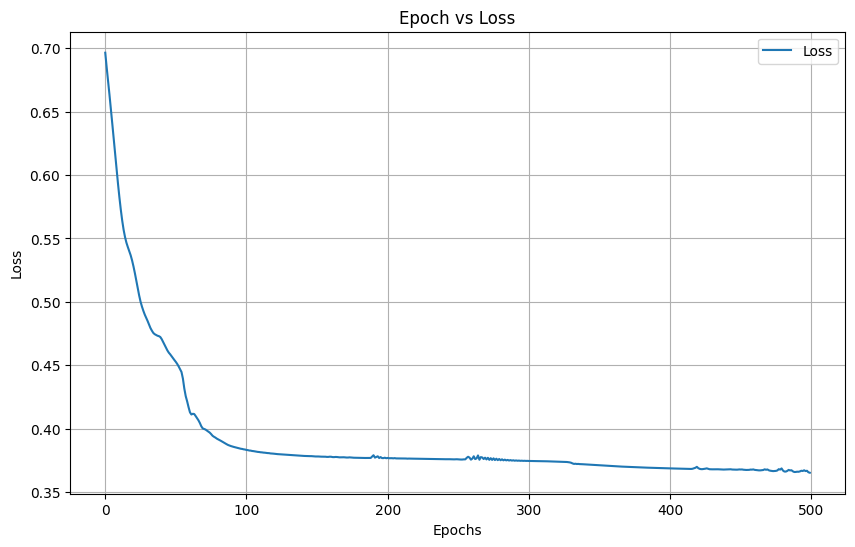

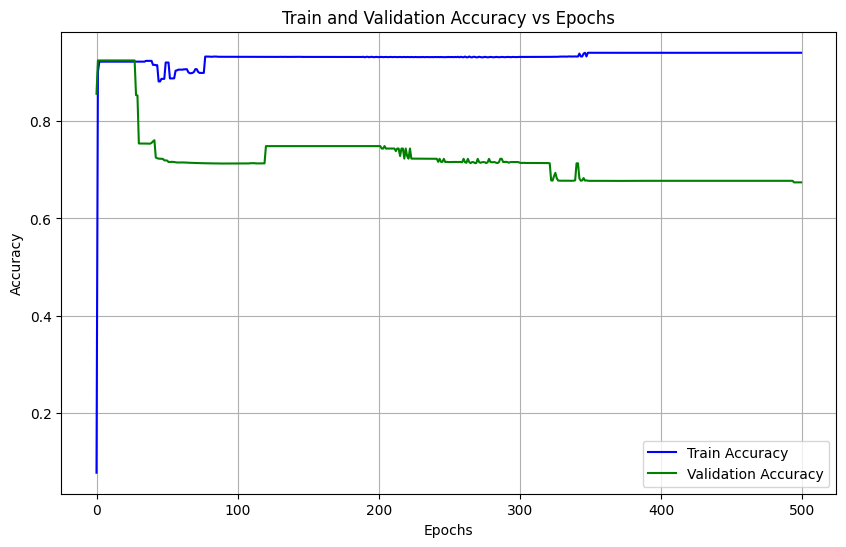

Precision: 0.6452
Recall: 0.5178
F1 Score: 0.5745


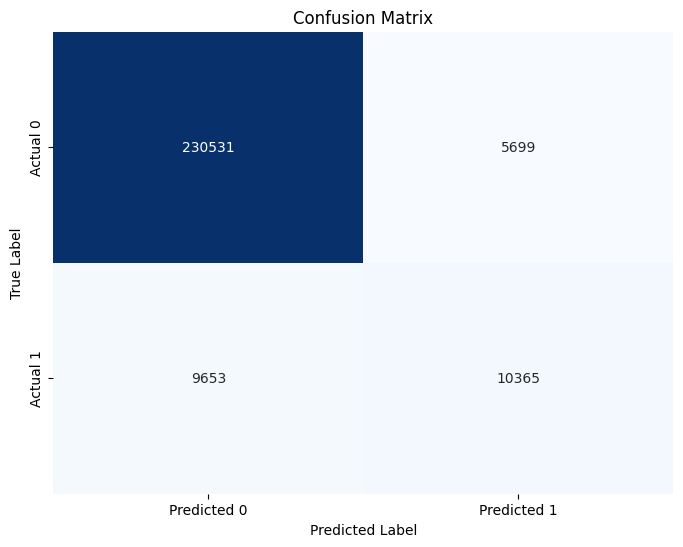

In [31]:
#GAT V
import os
import torch
import torch.nn.functional as F
import seaborn as sns
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

edge_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\2--12\extractedcolumns1.txt"
edges = np.loadtxt(edge_file, dtype=int)


feature_folder = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\2--12\features"
node_features_list = []

for file_name in os.listdir(feature_folder):
    if file_name.startswith("feature") and file_name.endswith(".txt"):
        file_path = os.path.join(feature_folder, file_name)
        try:
            feature_data = np.loadtxt(file_path, dtype=float)
            if feature_data.size == 0:
                print(f"Warning: {file_name} is empty. Skipping this file.")
            else:
                node_features_list.append(feature_data)
        except ValueError as e:
            print(f"Warning: Could not read {file_name}. Error: {e}")

if node_features_list:
    node_features = np.column_stack(node_features_list)
else:
    raise ValueError("No valid feature files found. Please check your input files.")


labels_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\2--12\node_contract_status_connected.txt"
labels = torch.tensor(np.loadtxt(labels_file, dtype=int), dtype=torch.long)

print(f"Node features shape: {node_features.shape}")
print(f"Labels shape: {labels.shape}")

G = nx.DiGraph()
G.add_edges_from(edges)

edge_index = torch.tensor(list(G.edges), dtype=torch.long).t().contiguous()

max_edge_index = edge_index.max()
num_nodes = node_features.shape[0]
print(f"Max edge index: {max_edge_index.item()}, Number of nodes: {num_nodes}")

if max_edge_index >= num_nodes:
    raise IndexError(f"Edge index {max_edge_index.item()} is out of bounds for number of nodes {num_nodes}.")

data = Data(x=torch.tensor(node_features, dtype=torch.float), y=labels, edge_index=edge_index)

class GAT(torch.nn.Module):
    def __init__(self):
        super(GAT, self).__init__()
        # Replace GCNConv with GATConv
        self.conv1 = GATConv(data.num_node_features, 16, heads=1)  # Single attention head
        self.conv2 = GATConv(16, 16, heads=1)  # Single attention head
        self.conv3 = GATConv(16, 2, heads=1)  # Single attention head

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)
        return x

model = GAT()

class_counts = torch.bincount(data.y)
#class_weights = 1.0 / class_counts.float()
#criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
class_weights = 1.0 / torch.sqrt(class_counts.float() + 1e-6)

criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

y_0_indices = (data.y == 0).nonzero(as_tuple=True)[0]
y_1_indices = (data.y == 1).nonzero(as_tuple=True)[0]

train_indices = torch.cat([y_0_indices, y_1_indices])

train_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[train_indices] = True

new_feature_folder = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\12-11\features"
new_labels_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\12-11\node_contract_status_connected.txt" 
new_edge_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\12-11\extractedcolumns1.txt" 

new_node_features_list = []
for file_name in os.listdir(new_feature_folder):
    if file_name.startswith("feature") and file_name.endswith(".txt"):
        file_path = os.path.join(new_feature_folder, file_name)
        try:
            feature_data = np.loadtxt(file_path, dtype=float)
            if feature_data.size == 0:
                print(f"Warning: {file_name} is empty. Skipping this file.")
            else:
                new_node_features_list.append(feature_data)
        except ValueError as e:
            print(f"Warning: Could not read {file_name}. Error: {e}")

if new_node_features_list:
    new_node_features = np.column_stack(new_node_features_list)
    new_labels = torch.tensor(np.loadtxt(new_labels_file, dtype=int), dtype=torch.long)
else:
    raise ValueError("No valid new feature files found. Please check your input files.")

new_edges = np.loadtxt(new_edge_file, dtype=int)
new_edge_index = torch.tensor(list(new_edges), dtype=torch.long).t().contiguous()


validation_accuracies = []
validation_loss_values = []


train_accuracies = []
loss_values = []

for epoch in range(500):
    model.train()
    optimizer.zero_grad()

    out = model(data.x, data.edge_index)

    loss = criterion(out[train_mask], data.y[train_mask])
    loss.backward()
    optimizer.step()

    pred_train = out.argmax(dim=1)
    train_acc = (pred_train[train_mask] == data.y[train_mask]).sum().item() / train_mask.sum().item()

    model.eval()
    with torch.no_grad():
        out_val = model(torch.tensor(new_node_features, dtype=torch.float), new_edge_index)
        pred_val = out_val.argmax(dim=1)
        val_acc = (pred_val == new_labels).sum().item() / new_labels.size(0)

    loss_values.append(loss.item())
    train_accuracies.append(train_acc)
    validation_accuracies.append(val_acc)

    if epoch % 10 == 0:
        print(f'Epoch {epoch:>3} | Loss: {loss.item():.4f} | Train Accuracy: {train_acc*100:.2f}% | Validation Accuracy: {val_acc*100:.2f}%')

plt.figure(figsize=(10, 6))
plt.plot(range(500), loss_values, label="Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Epoch vs Loss")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range(500), train_accuracies, label="Train Accuracy", color='blue')
plt.plot(range(500), validation_accuracies, label="Validation Accuracy", color='green')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train and Validation Accuracy vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index)
    y_pred = out.argmax(dim=1).cpu().numpy()
    y_true = data.y.cpu().numpy()

conf_matrix = confusion_matrix(y_true[train_mask], y_pred[train_mask])
precision = precision_score(y_true[train_mask], y_pred[train_mask], average='binary', zero_division=0)
recall = recall_score(y_true[train_mask], y_pred[train_mask], average='binary', zero_division=0)
f1 = f1_score(y_true[train_mask], y_pred[train_mask], average='binary', zero_division=0)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

Node features shape: (256248, 6)
Labels shape: torch.Size([256248])
Max edge index: 256247, Number of nodes: 256248
Epoch   0 | Loss: 0.6895 | Train Accuracy: 70.25% | Validation Accuracy: 93.00%
Epoch  10 | Loss: 0.5235 | Train Accuracy: 92.19% | Validation Accuracy: 93.00%
Epoch  20 | Loss: 0.4747 | Train Accuracy: 88.11% | Validation Accuracy: 77.45%
Epoch  30 | Loss: 0.4592 | Train Accuracy: 88.66% | Validation Accuracy: 73.86%
Epoch  40 | Loss: 0.4221 | Train Accuracy: 90.54% | Validation Accuracy: 72.38%
Epoch  50 | Loss: 0.4090 | Train Accuracy: 90.55% | Validation Accuracy: 72.32%
Epoch  60 | Loss: 0.4020 | Train Accuracy: 90.55% | Validation Accuracy: 72.27%
Epoch  70 | Loss: 0.3981 | Train Accuracy: 90.55% | Validation Accuracy: 73.29%
Epoch  80 | Loss: 0.3964 | Train Accuracy: 89.75% | Validation Accuracy: 73.27%
Epoch  90 | Loss: 0.3955 | Train Accuracy: 89.73% | Validation Accuracy: 73.27%
Epoch 100 | Loss: 0.3948 | Train Accuracy: 89.74% | Validation Accuracy: 73.30%
Epoc

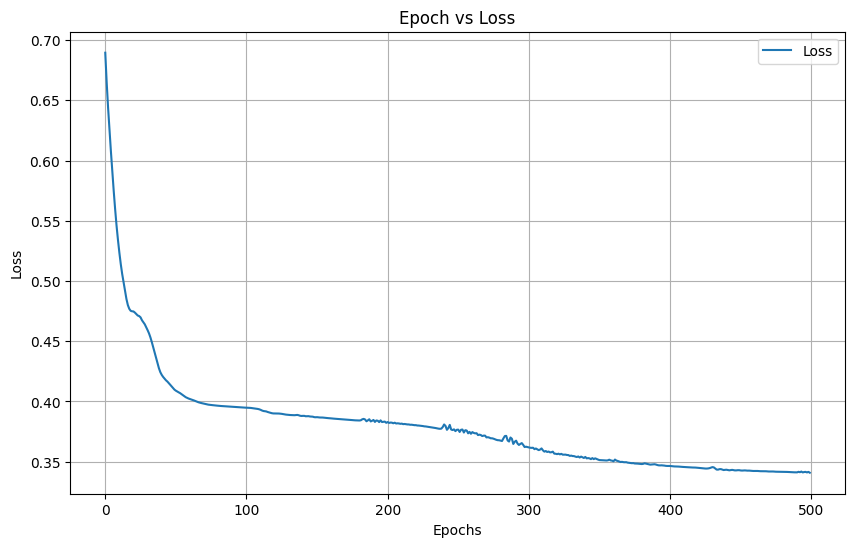

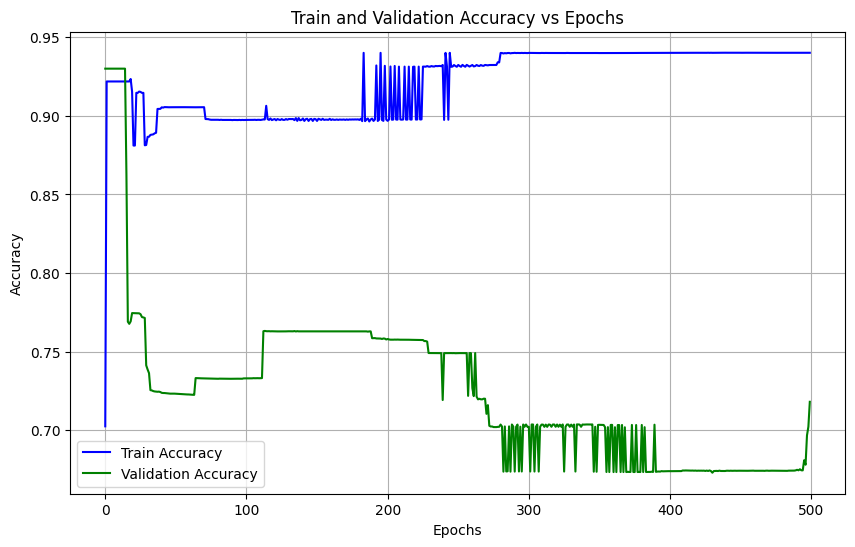

Precision: 0.6451
Recall: 0.5199
F1 Score: 0.5758


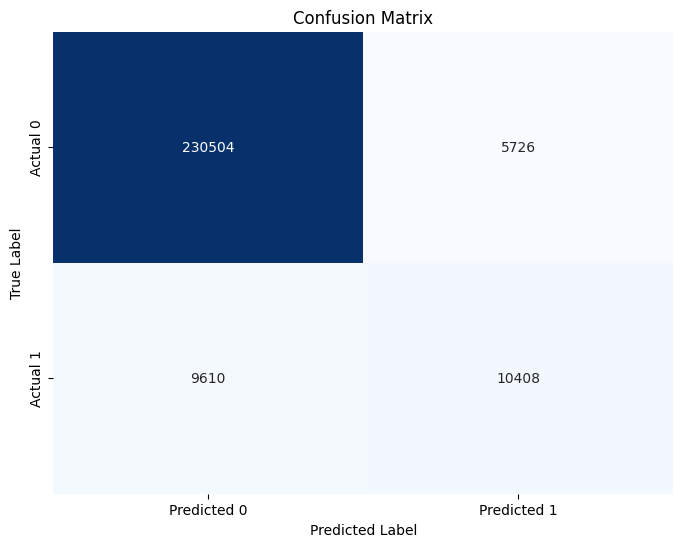

In [68]:
#GAT V 13-11
import os
import torch
import torch.nn.functional as F
import seaborn as sns
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

edge_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\2--12\extractedcolumns1.txt"
edges = np.loadtxt(edge_file, dtype=int)


feature_folder = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\2--12\features"
node_features_list = []

for file_name in os.listdir(feature_folder):
    if file_name.startswith("feature") and file_name.endswith(".txt"):
        file_path = os.path.join(feature_folder, file_name)
        try:
            feature_data = np.loadtxt(file_path, dtype=float)
            if feature_data.size == 0:
                print(f"Warning: {file_name} is empty. Skipping this file.")
            else:
                node_features_list.append(feature_data)
        except ValueError as e:
            print(f"Warning: Could not read {file_name}. Error: {e}")

if node_features_list:
    node_features = np.column_stack(node_features_list)
else:
    raise ValueError("No valid feature files found. Please check your input files.")


labels_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\2--12\node_contract_status_connected.txt"
labels = torch.tensor(np.loadtxt(labels_file, dtype=int), dtype=torch.long)

print(f"Node features shape: {node_features.shape}")
print(f"Labels shape: {labels.shape}")

G = nx.DiGraph()
G.add_edges_from(edges)

edge_index = torch.tensor(list(G.edges), dtype=torch.long).t().contiguous()

max_edge_index = edge_index.max()
num_nodes = node_features.shape[0]
print(f"Max edge index: {max_edge_index.item()}, Number of nodes: {num_nodes}")

if max_edge_index >= num_nodes:
    raise IndexError(f"Edge index {max_edge_index.item()} is out of bounds for number of nodes {num_nodes}.")

data = Data(x=torch.tensor(node_features, dtype=torch.float), y=labels, edge_index=edge_index)

class GAT(torch.nn.Module):
    def __init__(self):
        super(GAT, self).__init__()
        # Replace GCNConv with GATConv
        self.conv1 = GATConv(data.num_node_features, 16, heads=1)  # Single attention head
        self.conv2 = GATConv(16, 16, heads=1)  # Single attention head
        self.conv3 = GATConv(16, 2, heads=1)  # Single attention head

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)
        return x

model = GAT()

class_counts = torch.bincount(data.y)
#class_weights = 1.0 / class_counts.float()
#criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
class_weights = 1.0 / torch.sqrt(class_counts.float() + 1e-6)

criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

y_0_indices = (data.y == 0).nonzero(as_tuple=True)[0]
y_1_indices = (data.y == 1).nonzero(as_tuple=True)[0]

train_indices = torch.cat([y_0_indices, y_1_indices])

train_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[train_indices] = True

new_feature_folder = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\13-11\features"
new_labels_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\13-11\node_contract_status_connected.txt" 
new_edge_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\13-11\extractedcolumns1.txt" 

new_node_features_list = []
for file_name in os.listdir(new_feature_folder):
    if file_name.startswith("feature") and file_name.endswith(".txt"):
        file_path = os.path.join(new_feature_folder, file_name)
        try:
            feature_data = np.loadtxt(file_path, dtype=float)
            if feature_data.size == 0:
                print(f"Warning: {file_name} is empty. Skipping this file.")
            else:
                new_node_features_list.append(feature_data)
        except ValueError as e:
            print(f"Warning: Could not read {file_name}. Error: {e}")

if new_node_features_list:
    new_node_features = np.column_stack(new_node_features_list)
    new_labels = torch.tensor(np.loadtxt(new_labels_file, dtype=int), dtype=torch.long)
else:
    raise ValueError("No valid new feature files found. Please check your input files.")

new_edges = np.loadtxt(new_edge_file, dtype=int)
new_edge_index = torch.tensor(list(new_edges), dtype=torch.long).t().contiguous()


validation_accuracies = []
validation_loss_values = []


train_accuracies = []
loss_values = []

for epoch in range(500):
    model.train()
    optimizer.zero_grad()

    out = model(data.x, data.edge_index)

    loss = criterion(out[train_mask], data.y[train_mask])
    loss.backward()
    optimizer.step()

    pred_train = out.argmax(dim=1)
    train_acc = (pred_train[train_mask] == data.y[train_mask]).sum().item() / train_mask.sum().item()

    model.eval()
    with torch.no_grad():
        out_val = model(torch.tensor(new_node_features, dtype=torch.float), new_edge_index)
        pred_val = out_val.argmax(dim=1)
        val_acc = (pred_val == new_labels).sum().item() / new_labels.size(0)

    loss_values.append(loss.item())
    train_accuracies.append(train_acc)
    validation_accuracies.append(val_acc)

    if epoch % 10 == 0:
        print(f'Epoch {epoch:>3} | Loss: {loss.item():.4f} | Train Accuracy: {train_acc*100:.2f}% | Validation Accuracy: {val_acc*100:.2f}%')

plt.figure(figsize=(10, 6))
plt.plot(range(500), loss_values, label="Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Epoch vs Loss")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range(500), train_accuracies, label="Train Accuracy", color='blue')
plt.plot(range(500), validation_accuracies, label="Validation Accuracy", color='green')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train and Validation Accuracy vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index)
    y_pred = out.argmax(dim=1).cpu().numpy()
    y_true = data.y.cpu().numpy()

conf_matrix = confusion_matrix(y_true[train_mask], y_pred[train_mask])
precision = precision_score(y_true[train_mask], y_pred[train_mask], average='binary', zero_division=0)
recall = recall_score(y_true[train_mask], y_pred[train_mask], average='binary', zero_division=0)
f1 = f1_score(y_true[train_mask], y_pred[train_mask], average='binary', zero_division=0)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

Node features shape: (256248, 6)
Labels shape: torch.Size([256248])
Max edge index: 256247, Number of nodes: 256248
Epoch   0 | Loss: 0.6909 | Train Accuracy: 85.21% | Validation Accuracy: 92.34%
Epoch  10 | Loss: 0.5355 | Train Accuracy: 92.19% | Validation Accuracy: 92.34%
Epoch  20 | Loss: 0.4865 | Train Accuracy: 92.19% | Validation Accuracy: 92.34%
Epoch  30 | Loss: 0.4811 | Train Accuracy: 92.19% | Validation Accuracy: 92.34%
Epoch  40 | Loss: 0.4765 | Train Accuracy: 92.19% | Validation Accuracy: 92.34%
Epoch  50 | Loss: 0.4672 | Train Accuracy: 92.37% | Validation Accuracy: 76.13%
Epoch  60 | Loss: 0.4572 | Train Accuracy: 88.63% | Validation Accuracy: 74.92%
Epoch  70 | Loss: 0.4386 | Train Accuracy: 88.71% | Validation Accuracy: 75.31%
Epoch  80 | Loss: 0.4018 | Train Accuracy: 89.82% | Validation Accuracy: 71.40%
Epoch  90 | Loss: 0.3889 | Train Accuracy: 89.85% | Validation Accuracy: 71.33%
Epoch 100 | Loss: 0.3811 | Train Accuracy: 93.21% | Validation Accuracy: 74.60%
Epoc

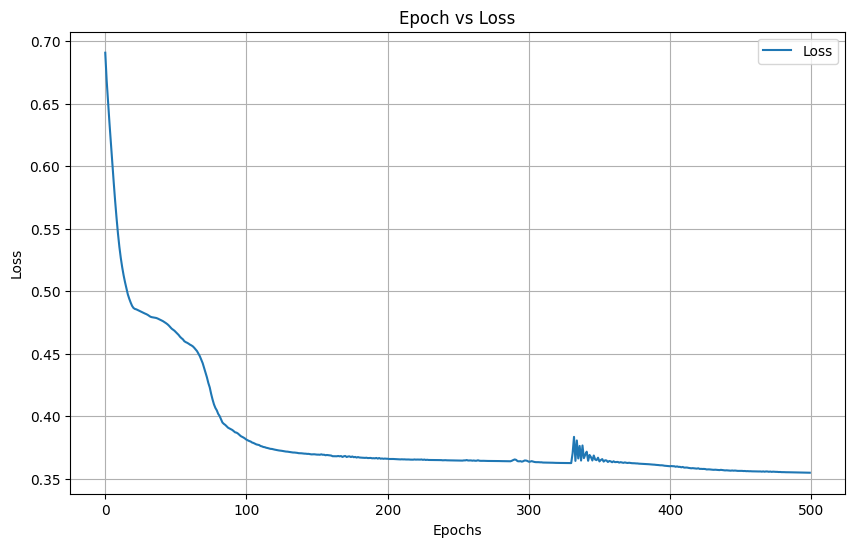

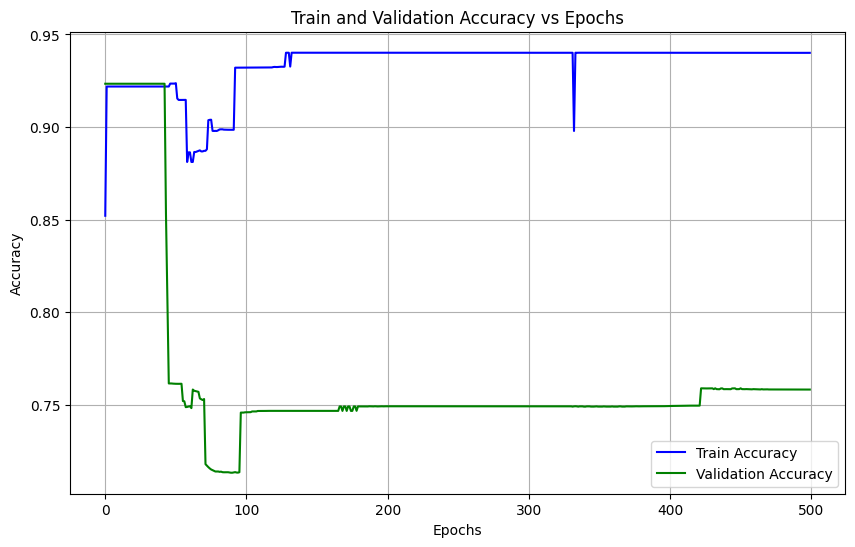

Precision: 0.6454
Recall: 0.5167
F1 Score: 0.5739


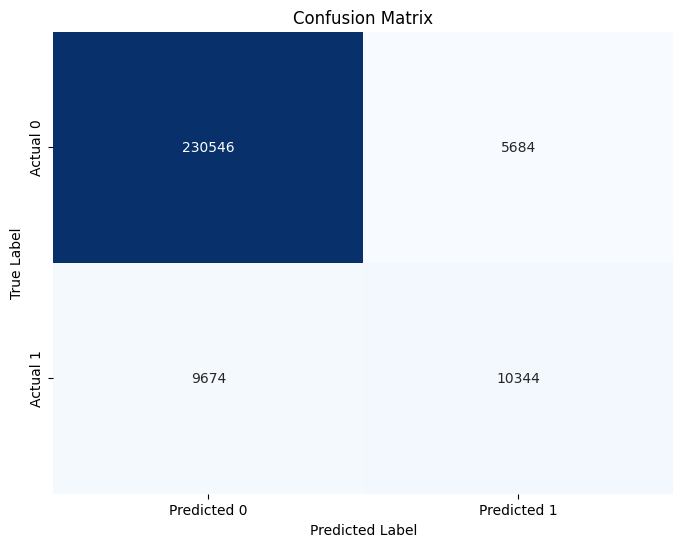

In [67]:
#GAT V 14-11
import os
import torch
import torch.nn.functional as F
import seaborn as sns
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

edge_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\2--12\extractedcolumns1.txt"
edges = np.loadtxt(edge_file, dtype=int)


feature_folder = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\2--12\features"
node_features_list = []

for file_name in os.listdir(feature_folder):
    if file_name.startswith("feature") and file_name.endswith(".txt"):
        file_path = os.path.join(feature_folder, file_name)
        try:
            feature_data = np.loadtxt(file_path, dtype=float)
            if feature_data.size == 0:
                print(f"Warning: {file_name} is empty. Skipping this file.")
            else:
                node_features_list.append(feature_data)
        except ValueError as e:
            print(f"Warning: Could not read {file_name}. Error: {e}")

if node_features_list:
    node_features = np.column_stack(node_features_list)
else:
    raise ValueError("No valid feature files found. Please check your input files.")


labels_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\2--12\node_contract_status_connected.txt"
labels = torch.tensor(np.loadtxt(labels_file, dtype=int), dtype=torch.long)

print(f"Node features shape: {node_features.shape}")
print(f"Labels shape: {labels.shape}")

G = nx.DiGraph()
G.add_edges_from(edges)

edge_index = torch.tensor(list(G.edges), dtype=torch.long).t().contiguous()

max_edge_index = edge_index.max()
num_nodes = node_features.shape[0]
print(f"Max edge index: {max_edge_index.item()}, Number of nodes: {num_nodes}")

if max_edge_index >= num_nodes:
    raise IndexError(f"Edge index {max_edge_index.item()} is out of bounds for number of nodes {num_nodes}.")

data = Data(x=torch.tensor(node_features, dtype=torch.float), y=labels, edge_index=edge_index)

class GAT(torch.nn.Module):
    def __init__(self):
        super(GAT, self).__init__()
        # Replace GCNConv with GATConv
        self.conv1 = GATConv(data.num_node_features, 16, heads=1)  # Single attention head
        self.conv2 = GATConv(16, 16, heads=1)  # Single attention head
        self.conv3 = GATConv(16, 2, heads=1)  # Single attention head

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)
        return x

model = GAT()

class_counts = torch.bincount(data.y)
#class_weights = 1.0 / class_counts.float()
#criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
class_weights = 1.0 / torch.sqrt(class_counts.float() + 1e-6)

criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

y_0_indices = (data.y == 0).nonzero(as_tuple=True)[0]
y_1_indices = (data.y == 1).nonzero(as_tuple=True)[0]

train_indices = torch.cat([y_0_indices, y_1_indices])

train_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[train_indices] = True

new_feature_folder = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\14-11\features"
new_labels_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\14-11\node_contract_status_connected.txt" 
new_edge_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\14-11\extractedcolumns1.txt" 

new_node_features_list = []
for file_name in os.listdir(new_feature_folder):
    if file_name.startswith("feature") and file_name.endswith(".txt"):
        file_path = os.path.join(new_feature_folder, file_name)
        try:
            feature_data = np.loadtxt(file_path, dtype=float)
            if feature_data.size == 0:
                print(f"Warning: {file_name} is empty. Skipping this file.")
            else:
                new_node_features_list.append(feature_data)
        except ValueError as e:
            print(f"Warning: Could not read {file_name}. Error: {e}")

if new_node_features_list:
    new_node_features = np.column_stack(new_node_features_list)
    new_labels = torch.tensor(np.loadtxt(new_labels_file, dtype=int), dtype=torch.long)
else:
    raise ValueError("No valid new feature files found. Please check your input files.")

new_edges = np.loadtxt(new_edge_file, dtype=int)
new_edge_index = torch.tensor(list(new_edges), dtype=torch.long).t().contiguous()


validation_accuracies = []
validation_loss_values = []


train_accuracies = []
loss_values = []

for epoch in range(500):
    model.train()
    optimizer.zero_grad()

    out = model(data.x, data.edge_index)

    loss = criterion(out[train_mask], data.y[train_mask])
    loss.backward()
    optimizer.step()

    pred_train = out.argmax(dim=1)
    train_acc = (pred_train[train_mask] == data.y[train_mask]).sum().item() / train_mask.sum().item()

    model.eval()
    with torch.no_grad():
        out_val = model(torch.tensor(new_node_features, dtype=torch.float), new_edge_index)
        pred_val = out_val.argmax(dim=1)
        val_acc = (pred_val == new_labels).sum().item() / new_labels.size(0)

    loss_values.append(loss.item())
    train_accuracies.append(train_acc)
    validation_accuracies.append(val_acc)

    if epoch % 10 == 0:
        print(f'Epoch {epoch:>3} | Loss: {loss.item():.4f} | Train Accuracy: {train_acc*100:.2f}% | Validation Accuracy: {val_acc*100:.2f}%')

plt.figure(figsize=(10, 6))
plt.plot(range(500), loss_values, label="Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Epoch vs Loss")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range(500), train_accuracies, label="Train Accuracy", color='blue')
plt.plot(range(500), validation_accuracies, label="Validation Accuracy", color='green')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train and Validation Accuracy vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index)
    y_pred = out.argmax(dim=1).cpu().numpy()
    y_true = data.y.cpu().numpy()

conf_matrix = confusion_matrix(y_true[train_mask], y_pred[train_mask])
precision = precision_score(y_true[train_mask], y_pred[train_mask], average='binary', zero_division=0)
recall = recall_score(y_true[train_mask], y_pred[train_mask], average='binary', zero_division=0)
f1 = f1_score(y_true[train_mask], y_pred[train_mask], average='binary', zero_division=0)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

Node features shape: (256248, 6)
Labels shape: torch.Size([256248])
Max edge index: 256247, Number of nodes: 256248
Epoch   0 | Loss: 0.6948 | Train Accuracy: 8.28% | Validation Accuracy: 93.51%
Epoch  10 | Loss: 0.5666 | Train Accuracy: 92.19% | Validation Accuracy: 93.51%
Epoch  20 | Loss: 0.5202 | Train Accuracy: 92.19% | Validation Accuracy: 93.51%
Epoch  30 | Loss: 0.4855 | Train Accuracy: 92.19% | Validation Accuracy: 93.51%
Epoch  40 | Loss: 0.4654 | Train Accuracy: 92.35% | Validation Accuracy: 83.89%
Epoch  50 | Loss: 0.4493 | Train Accuracy: 91.54% | Validation Accuracy: 83.63%
Epoch  60 | Loss: 0.4360 | Train Accuracy: 88.75% | Validation Accuracy: 83.47%
Epoch  70 | Loss: 0.4257 | Train Accuracy: 90.60% | Validation Accuracy: 80.73%
Epoch  80 | Loss: 0.4215 | Train Accuracy: 90.60% | Validation Accuracy: 80.63%
Epoch  90 | Loss: 0.4149 | Train Accuracy: 90.60% | Validation Accuracy: 80.65%
Epoch 100 | Loss: 0.4097 | Train Accuracy: 90.61% | Validation Accuracy: 80.94%
Epoch

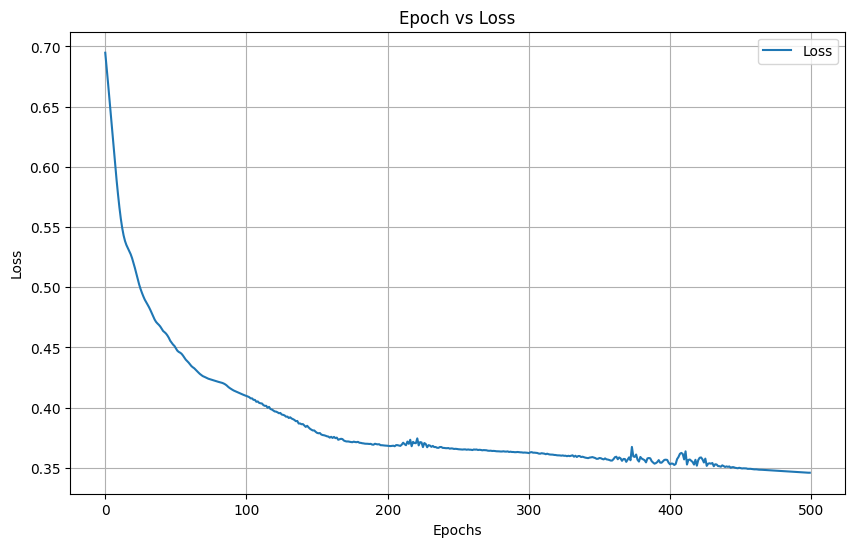

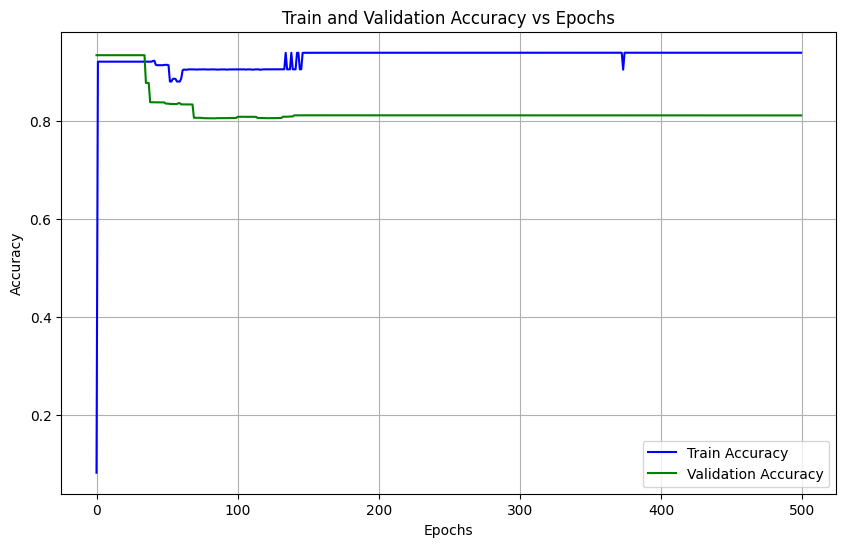

Precision: 0.6455
Recall: 0.5176
F1 Score: 0.5745


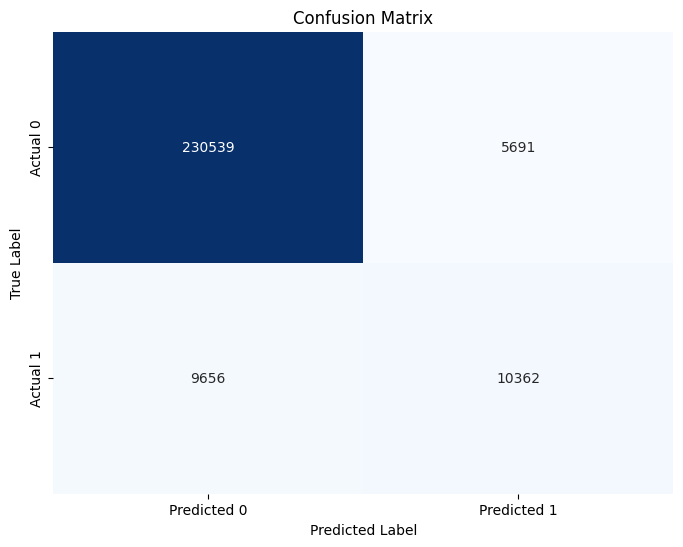

In [66]:
#GAT V 24-11
import os
import torch
import torch.nn.functional as F
import seaborn as sns
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

edge_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\2--12\extractedcolumns1.txt"
edges = np.loadtxt(edge_file, dtype=int)


feature_folder = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\2--12\features"
node_features_list = []

for file_name in os.listdir(feature_folder):
    if file_name.startswith("feature") and file_name.endswith(".txt"):
        file_path = os.path.join(feature_folder, file_name)
        try:
            feature_data = np.loadtxt(file_path, dtype=float)
            if feature_data.size == 0:
                print(f"Warning: {file_name} is empty. Skipping this file.")
            else:
                node_features_list.append(feature_data)
        except ValueError as e:
            print(f"Warning: Could not read {file_name}. Error: {e}")

if node_features_list:
    node_features = np.column_stack(node_features_list)
else:
    raise ValueError("No valid feature files found. Please check your input files.")


labels_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\2--12\node_contract_status_connected.txt"
labels = torch.tensor(np.loadtxt(labels_file, dtype=int), dtype=torch.long)

print(f"Node features shape: {node_features.shape}")
print(f"Labels shape: {labels.shape}")

G = nx.DiGraph()
G.add_edges_from(edges)

edge_index = torch.tensor(list(G.edges), dtype=torch.long).t().contiguous()

max_edge_index = edge_index.max()
num_nodes = node_features.shape[0]
print(f"Max edge index: {max_edge_index.item()}, Number of nodes: {num_nodes}")

if max_edge_index >= num_nodes:
    raise IndexError(f"Edge index {max_edge_index.item()} is out of bounds for number of nodes {num_nodes}.")

data = Data(x=torch.tensor(node_features, dtype=torch.float), y=labels, edge_index=edge_index)

class GAT(torch.nn.Module):
    def __init__(self):
        super(GAT, self).__init__()
        # Replace GCNConv with GATConv
        self.conv1 = GATConv(data.num_node_features, 16, heads=1)  # Single attention head
        self.conv2 = GATConv(16, 16, heads=1)  # Single attention head
        self.conv3 = GATConv(16, 2, heads=1)  # Single attention head

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)
        return x

model = GAT()

class_counts = torch.bincount(data.y)
#class_weights = 1.0 / class_counts.float()
#criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
class_weights = 1.0 / torch.sqrt(class_counts.float() + 1e-6)

criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

y_0_indices = (data.y == 0).nonzero(as_tuple=True)[0]
y_1_indices = (data.y == 1).nonzero(as_tuple=True)[0]

train_indices = torch.cat([y_0_indices, y_1_indices])

train_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[train_indices] = True

new_feature_folder = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\24-11\features"
new_labels_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\24-11\node_contract_status_connected.txt" 
new_edge_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\24-11\extractedcolumns1.txt" 

new_node_features_list = []
for file_name in os.listdir(new_feature_folder):
    if file_name.startswith("feature") and file_name.endswith(".txt"):
        file_path = os.path.join(new_feature_folder, file_name)
        try:
            feature_data = np.loadtxt(file_path, dtype=float)
            if feature_data.size == 0:
                print(f"Warning: {file_name} is empty. Skipping this file.")
            else:
                new_node_features_list.append(feature_data)
        except ValueError as e:
            print(f"Warning: Could not read {file_name}. Error: {e}")

if new_node_features_list:
    new_node_features = np.column_stack(new_node_features_list)
    new_labels = torch.tensor(np.loadtxt(new_labels_file, dtype=int), dtype=torch.long)
else:
    raise ValueError("No valid new feature files found. Please check your input files.")

new_edges = np.loadtxt(new_edge_file, dtype=int)
new_edge_index = torch.tensor(list(new_edges), dtype=torch.long).t().contiguous()


validation_accuracies = []
validation_loss_values = []


train_accuracies = []
loss_values = []

for epoch in range(500):
    model.train()
    optimizer.zero_grad()

    out = model(data.x, data.edge_index)

    loss = criterion(out[train_mask], data.y[train_mask])
    loss.backward()
    optimizer.step()

    pred_train = out.argmax(dim=1)
    train_acc = (pred_train[train_mask] == data.y[train_mask]).sum().item() / train_mask.sum().item()

    model.eval()
    with torch.no_grad():
        out_val = model(torch.tensor(new_node_features, dtype=torch.float), new_edge_index)
        pred_val = out_val.argmax(dim=1)
        val_acc = (pred_val == new_labels).sum().item() / new_labels.size(0)

    loss_values.append(loss.item())
    train_accuracies.append(train_acc)
    validation_accuracies.append(val_acc)

    if epoch % 10 == 0:
        print(f'Epoch {epoch:>3} | Loss: {loss.item():.4f} | Train Accuracy: {train_acc*100:.2f}% | Validation Accuracy: {val_acc*100:.2f}%')

plt.figure(figsize=(10, 6))
plt.plot(range(500), loss_values, label="Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Epoch vs Loss")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range(500), train_accuracies, label="Train Accuracy", color='blue')
plt.plot(range(500), validation_accuracies, label="Validation Accuracy", color='green')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train and Validation Accuracy vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index)
    y_pred = out.argmax(dim=1).cpu().numpy()
    y_true = data.y.cpu().numpy()

conf_matrix = confusion_matrix(y_true[train_mask], y_pred[train_mask])
precision = precision_score(y_true[train_mask], y_pred[train_mask], average='binary', zero_division=0)
recall = recall_score(y_true[train_mask], y_pred[train_mask], average='binary', zero_division=0)
f1 = f1_score(y_true[train_mask], y_pred[train_mask], average='binary', zero_division=0)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

Node features shape: (256248, 6)
Labels shape: torch.Size([256248])
Max edge index: 256247, Number of nodes: 256248
Epoch   0 | Loss: 0.6924 | Train Accuracy: 57.99% | Validation Accuracy: 93.15%
Epoch  10 | Loss: 0.5408 | Train Accuracy: 92.19% | Validation Accuracy: 93.15%
Epoch  20 | Loss: 0.4789 | Train Accuracy: 92.19% | Validation Accuracy: 87.38%
Epoch  30 | Loss: 0.4685 | Train Accuracy: 88.11% | Validation Accuracy: 83.37%
Epoch  40 | Loss: 0.4473 | Train Accuracy: 88.18% | Validation Accuracy: 82.15%
Epoch  50 | Loss: 0.4302 | Train Accuracy: 89.31% | Validation Accuracy: 82.02%
Epoch  60 | Loss: 0.4198 | Train Accuracy: 89.26% | Validation Accuracy: 82.80%
Epoch  70 | Loss: 0.4108 | Train Accuracy: 89.67% | Validation Accuracy: 82.78%
Epoch  80 | Loss: 0.4000 | Train Accuracy: 89.58% | Validation Accuracy: 82.77%
Epoch  90 | Loss: 0.3968 | Train Accuracy: 89.61% | Validation Accuracy: 82.79%
Epoch 100 | Loss: 0.3938 | Train Accuracy: 89.65% | Validation Accuracy: 82.79%
Epoc

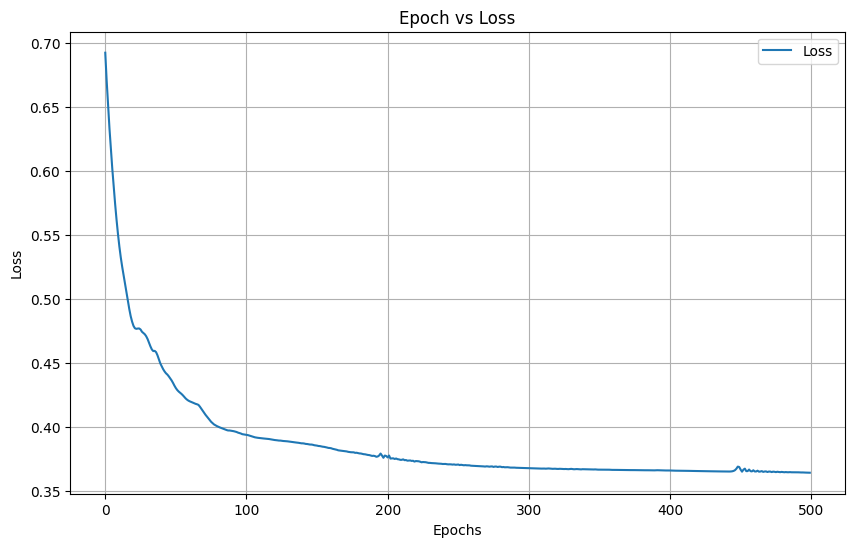

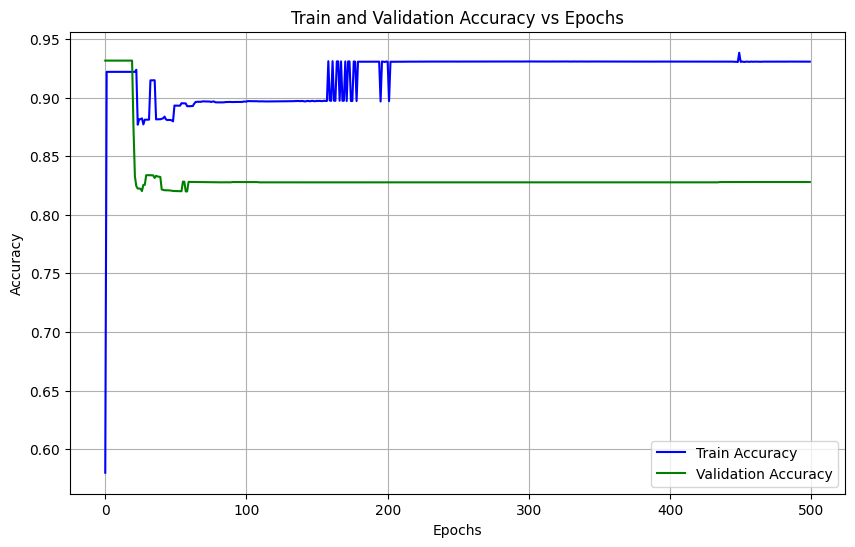

Precision: 0.5590
Recall: 0.5275
F1 Score: 0.5428


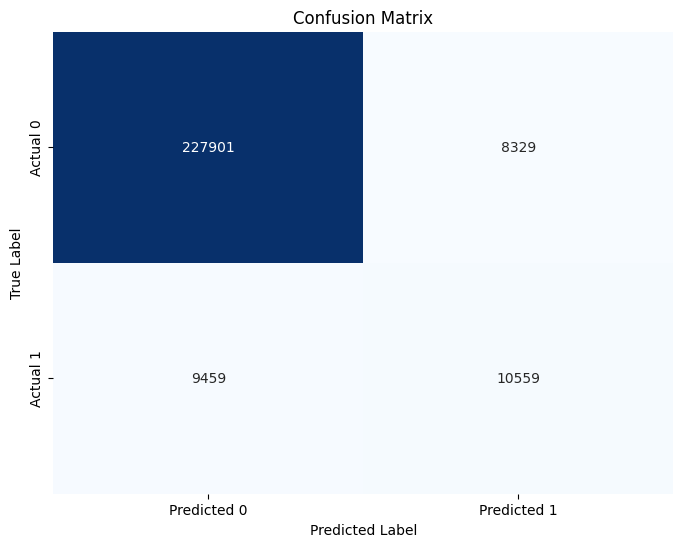

In [65]:
#GAT V 25-11
import os
import torch
import torch.nn.functional as F
import seaborn as sns
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

edge_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\2--12\extractedcolumns1.txt"
edges = np.loadtxt(edge_file, dtype=int)


feature_folder = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\2--12\features"
node_features_list = []

for file_name in os.listdir(feature_folder):
    if file_name.startswith("feature") and file_name.endswith(".txt"):
        file_path = os.path.join(feature_folder, file_name)
        try:
            feature_data = np.loadtxt(file_path, dtype=float)
            if feature_data.size == 0:
                print(f"Warning: {file_name} is empty. Skipping this file.")
            else:
                node_features_list.append(feature_data)
        except ValueError as e:
            print(f"Warning: Could not read {file_name}. Error: {e}")

if node_features_list:
    node_features = np.column_stack(node_features_list)
else:
    raise ValueError("No valid feature files found. Please check your input files.")


labels_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\2--12\node_contract_status_connected.txt"
labels = torch.tensor(np.loadtxt(labels_file, dtype=int), dtype=torch.long)

print(f"Node features shape: {node_features.shape}")
print(f"Labels shape: {labels.shape}")

G = nx.DiGraph()
G.add_edges_from(edges)

edge_index = torch.tensor(list(G.edges), dtype=torch.long).t().contiguous()

max_edge_index = edge_index.max()
num_nodes = node_features.shape[0]
print(f"Max edge index: {max_edge_index.item()}, Number of nodes: {num_nodes}")

if max_edge_index >= num_nodes:
    raise IndexError(f"Edge index {max_edge_index.item()} is out of bounds for number of nodes {num_nodes}.")

data = Data(x=torch.tensor(node_features, dtype=torch.float), y=labels, edge_index=edge_index)

class GAT(torch.nn.Module):
    def __init__(self):
        super(GAT, self).__init__()
        # Replace GCNConv with GATConv
        self.conv1 = GATConv(data.num_node_features, 16, heads=1)  # Single attention head
        self.conv2 = GATConv(16, 16, heads=1)  # Single attention head
        self.conv3 = GATConv(16, 2, heads=1)  # Single attention head

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)
        return x

model = GAT()

class_counts = torch.bincount(data.y)
#class_weights = 1.0 / class_counts.float()
#criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
class_weights = 1.0 / torch.sqrt(class_counts.float() + 1e-6)

criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

y_0_indices = (data.y == 0).nonzero(as_tuple=True)[0]
y_1_indices = (data.y == 1).nonzero(as_tuple=True)[0]

train_indices = torch.cat([y_0_indices, y_1_indices])

train_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[train_indices] = True

new_feature_folder = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\25-11\features"
new_labels_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\25-11\node_contract_status_connected.txt" 
new_edge_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\25-11\extractedcolumns1.txt" 

new_node_features_list = []
for file_name in os.listdir(new_feature_folder):
    if file_name.startswith("feature") and file_name.endswith(".txt"):
        file_path = os.path.join(new_feature_folder, file_name)
        try:
            feature_data = np.loadtxt(file_path, dtype=float)
            if feature_data.size == 0:
                print(f"Warning: {file_name} is empty. Skipping this file.")
            else:
                new_node_features_list.append(feature_data)
        except ValueError as e:
            print(f"Warning: Could not read {file_name}. Error: {e}")

if new_node_features_list:
    new_node_features = np.column_stack(new_node_features_list)
    new_labels = torch.tensor(np.loadtxt(new_labels_file, dtype=int), dtype=torch.long)
else:
    raise ValueError("No valid new feature files found. Please check your input files.")

new_edges = np.loadtxt(new_edge_file, dtype=int)
new_edge_index = torch.tensor(list(new_edges), dtype=torch.long).t().contiguous()


validation_accuracies = []
validation_loss_values = []


train_accuracies = []
loss_values = []

for epoch in range(500):
    model.train()
    optimizer.zero_grad()

    out = model(data.x, data.edge_index)

    loss = criterion(out[train_mask], data.y[train_mask])
    loss.backward()
    optimizer.step()

    pred_train = out.argmax(dim=1)
    train_acc = (pred_train[train_mask] == data.y[train_mask]).sum().item() / train_mask.sum().item()

    model.eval()
    with torch.no_grad():
        out_val = model(torch.tensor(new_node_features, dtype=torch.float), new_edge_index)
        pred_val = out_val.argmax(dim=1)
        val_acc = (pred_val == new_labels).sum().item() / new_labels.size(0)

    loss_values.append(loss.item())
    train_accuracies.append(train_acc)
    validation_accuracies.append(val_acc)

    if epoch % 10 == 0:
        print(f'Epoch {epoch:>3} | Loss: {loss.item():.4f} | Train Accuracy: {train_acc*100:.2f}% | Validation Accuracy: {val_acc*100:.2f}%')

plt.figure(figsize=(10, 6))
plt.plot(range(500), loss_values, label="Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Epoch vs Loss")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range(500), train_accuracies, label="Train Accuracy", color='blue')
plt.plot(range(500), validation_accuracies, label="Validation Accuracy", color='green')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train and Validation Accuracy vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index)
    y_pred = out.argmax(dim=1).cpu().numpy()
    y_true = data.y.cpu().numpy()

conf_matrix = confusion_matrix(y_true[train_mask], y_pred[train_mask])
precision = precision_score(y_true[train_mask], y_pred[train_mask], average='binary', zero_division=0)
recall = recall_score(y_true[train_mask], y_pred[train_mask], average='binary', zero_division=0)
f1 = f1_score(y_true[train_mask], y_pred[train_mask], average='binary', zero_division=0)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

Node features shape: (256248, 6)
Labels shape: torch.Size([256248])
Max edge index: 256247, Number of nodes: 256248
Epoch   0 | Loss: 0.7007 | Train Accuracy: 7.81% | Validation Accuracy: 71.12%
Epoch  10 | Loss: 0.5580 | Train Accuracy: 92.19% | Validation Accuracy: 93.43%
Epoch  20 | Loss: 0.5070 | Train Accuracy: 92.19% | Validation Accuracy: 93.43%
Epoch  30 | Loss: 0.4836 | Train Accuracy: 92.19% | Validation Accuracy: 78.15%
Epoch  40 | Loss: 0.4688 | Train Accuracy: 88.12% | Validation Accuracy: 78.74%
Epoch  50 | Loss: 0.4520 | Train Accuracy: 88.15% | Validation Accuracy: 78.05%
Epoch  60 | Loss: 0.4270 | Train Accuracy: 90.38% | Validation Accuracy: 77.68%
Epoch  70 | Loss: 0.4117 | Train Accuracy: 90.64% | Validation Accuracy: 77.62%
Epoch  80 | Loss: 0.4024 | Train Accuracy: 90.07% | Validation Accuracy: 77.56%
Epoch  90 | Loss: 0.3940 | Train Accuracy: 93.23% | Validation Accuracy: 77.49%
Epoch 100 | Loss: 0.3874 | Train Accuracy: 93.19% | Validation Accuracy: 77.46%
Epoch

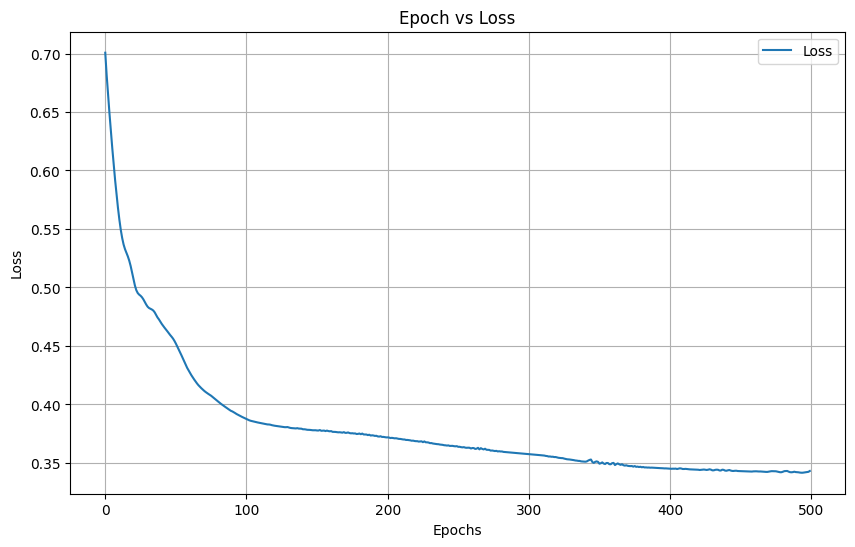

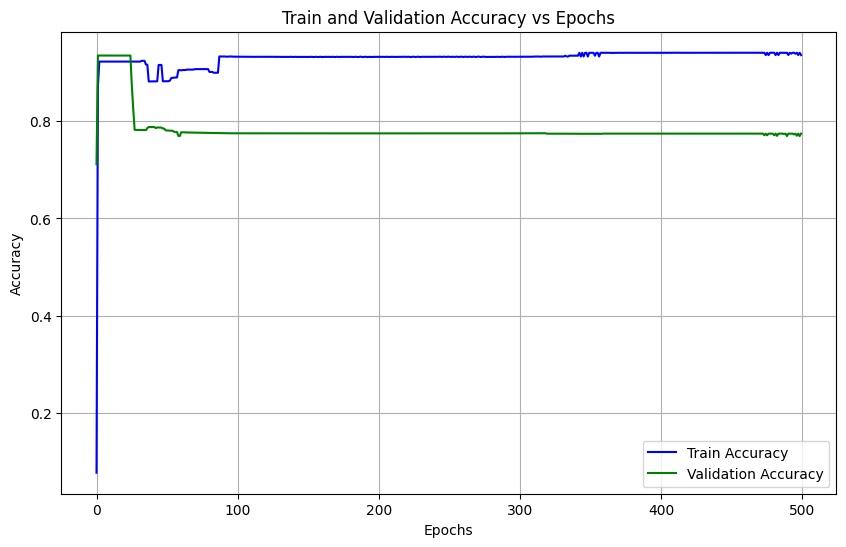

Precision: 0.6454
Recall: 0.5161
F1 Score: 0.5735


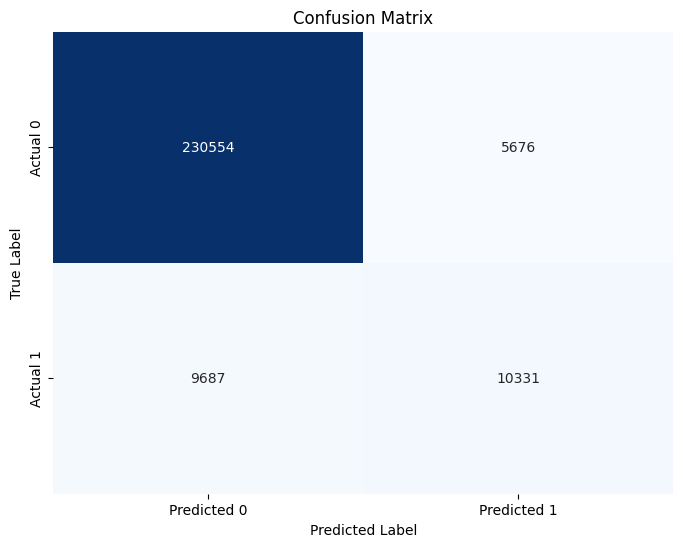

In [64]:
#GAT V 26-11
import os
import torch
import torch.nn.functional as F
import seaborn as sns
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

edge_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\2--12\extractedcolumns1.txt"
edges = np.loadtxt(edge_file, dtype=int)


feature_folder = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\2--12\features"
node_features_list = []

for file_name in os.listdir(feature_folder):
    if file_name.startswith("feature") and file_name.endswith(".txt"):
        file_path = os.path.join(feature_folder, file_name)
        try:
            feature_data = np.loadtxt(file_path, dtype=float)
            if feature_data.size == 0:
                print(f"Warning: {file_name} is empty. Skipping this file.")
            else:
                node_features_list.append(feature_data)
        except ValueError as e:
            print(f"Warning: Could not read {file_name}. Error: {e}")

if node_features_list:
    node_features = np.column_stack(node_features_list)
else:
    raise ValueError("No valid feature files found. Please check your input files.")


labels_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\2--12\node_contract_status_connected.txt"
labels = torch.tensor(np.loadtxt(labels_file, dtype=int), dtype=torch.long)

print(f"Node features shape: {node_features.shape}")
print(f"Labels shape: {labels.shape}")

G = nx.DiGraph()
G.add_edges_from(edges)

edge_index = torch.tensor(list(G.edges), dtype=torch.long).t().contiguous()

max_edge_index = edge_index.max()
num_nodes = node_features.shape[0]
print(f"Max edge index: {max_edge_index.item()}, Number of nodes: {num_nodes}")

if max_edge_index >= num_nodes:
    raise IndexError(f"Edge index {max_edge_index.item()} is out of bounds for number of nodes {num_nodes}.")

data = Data(x=torch.tensor(node_features, dtype=torch.float), y=labels, edge_index=edge_index)

class GAT(torch.nn.Module):
    def __init__(self):
        super(GAT, self).__init__()
        # Replace GCNConv with GATConv
        self.conv1 = GATConv(data.num_node_features, 16, heads=1)  # Single attention head
        self.conv2 = GATConv(16, 16, heads=1)  # Single attention head
        self.conv3 = GATConv(16, 2, heads=1)  # Single attention head

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)
        return x

model = GAT()

class_counts = torch.bincount(data.y)
#class_weights = 1.0 / class_counts.float()
#criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
class_weights = 1.0 / torch.sqrt(class_counts.float() + 1e-6)

criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

y_0_indices = (data.y == 0).nonzero(as_tuple=True)[0]
y_1_indices = (data.y == 1).nonzero(as_tuple=True)[0]

train_indices = torch.cat([y_0_indices, y_1_indices])

train_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[train_indices] = True

new_feature_folder = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\26-11\features"
new_labels_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\26-11\node_contract_status_connected.txt" 
new_edge_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\26-11\extractedcolumns1.txt" 

new_node_features_list = []
for file_name in os.listdir(new_feature_folder):
    if file_name.startswith("feature") and file_name.endswith(".txt"):
        file_path = os.path.join(new_feature_folder, file_name)
        try:
            feature_data = np.loadtxt(file_path, dtype=float)
            if feature_data.size == 0:
                print(f"Warning: {file_name} is empty. Skipping this file.")
            else:
                new_node_features_list.append(feature_data)
        except ValueError as e:
            print(f"Warning: Could not read {file_name}. Error: {e}")

if new_node_features_list:
    new_node_features = np.column_stack(new_node_features_list)
    new_labels = torch.tensor(np.loadtxt(new_labels_file, dtype=int), dtype=torch.long)
else:
    raise ValueError("No valid new feature files found. Please check your input files.")

new_edges = np.loadtxt(new_edge_file, dtype=int)
new_edge_index = torch.tensor(list(new_edges), dtype=torch.long).t().contiguous()


validation_accuracies = []
validation_loss_values = []


train_accuracies = []
loss_values = []

for epoch in range(500):
    model.train()
    optimizer.zero_grad()

    out = model(data.x, data.edge_index)

    loss = criterion(out[train_mask], data.y[train_mask])
    loss.backward()
    optimizer.step()

    pred_train = out.argmax(dim=1)
    train_acc = (pred_train[train_mask] == data.y[train_mask]).sum().item() / train_mask.sum().item()

    model.eval()
    with torch.no_grad():
        out_val = model(torch.tensor(new_node_features, dtype=torch.float), new_edge_index)
        pred_val = out_val.argmax(dim=1)
        val_acc = (pred_val == new_labels).sum().item() / new_labels.size(0)

    loss_values.append(loss.item())
    train_accuracies.append(train_acc)
    validation_accuracies.append(val_acc)

    if epoch % 10 == 0:
        print(f'Epoch {epoch:>3} | Loss: {loss.item():.4f} | Train Accuracy: {train_acc*100:.2f}% | Validation Accuracy: {val_acc*100:.2f}%')

plt.figure(figsize=(10, 6))
plt.plot(range(500), loss_values, label="Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Epoch vs Loss")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range(500), train_accuracies, label="Train Accuracy", color='blue')
plt.plot(range(500), validation_accuracies, label="Validation Accuracy", color='green')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train and Validation Accuracy vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index)
    y_pred = out.argmax(dim=1).cpu().numpy()
    y_true = data.y.cpu().numpy()

conf_matrix = confusion_matrix(y_true[train_mask], y_pred[train_mask])
precision = precision_score(y_true[train_mask], y_pred[train_mask], average='binary', zero_division=0)
recall = recall_score(y_true[train_mask], y_pred[train_mask], average='binary', zero_division=0)
f1 = f1_score(y_true[train_mask], y_pred[train_mask], average='binary', zero_division=0)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

Node features shape: (256248, 6)
Labels shape: torch.Size([256248])
Max edge index: 256247, Number of nodes: 256248
Epoch   0 | Loss: 0.6298 | Train Accuracy: 92.19% | Validation Accuracy: 93.75%
Epoch  10 | Loss: 0.5243 | Train Accuracy: 92.18% | Validation Accuracy: 93.78%
Epoch  20 | Loss: 0.4885 | Train Accuracy: 92.19% | Validation Accuracy: 93.78%
Epoch  30 | Loss: 0.4513 | Train Accuracy: 92.20% | Validation Accuracy: 93.79%
Epoch  40 | Loss: 0.4303 | Train Accuracy: 92.22% | Validation Accuracy: 93.79%
Epoch  50 | Loss: 0.4212 | Train Accuracy: 92.19% | Validation Accuracy: 93.76%
Epoch  60 | Loss: 0.4108 | Train Accuracy: 92.21% | Validation Accuracy: 93.73%
Epoch  70 | Loss: 0.3992 | Train Accuracy: 92.17% | Validation Accuracy: 93.72%
Epoch  80 | Loss: 0.3864 | Train Accuracy: 93.71% | Validation Accuracy: 93.68%
Epoch  90 | Loss: 0.3919 | Train Accuracy: 90.48% | Validation Accuracy: 94.25%
Epoch 100 | Loss: 0.3803 | Train Accuracy: 93.76% | Validation Accuracy: 94.26%
Epoc

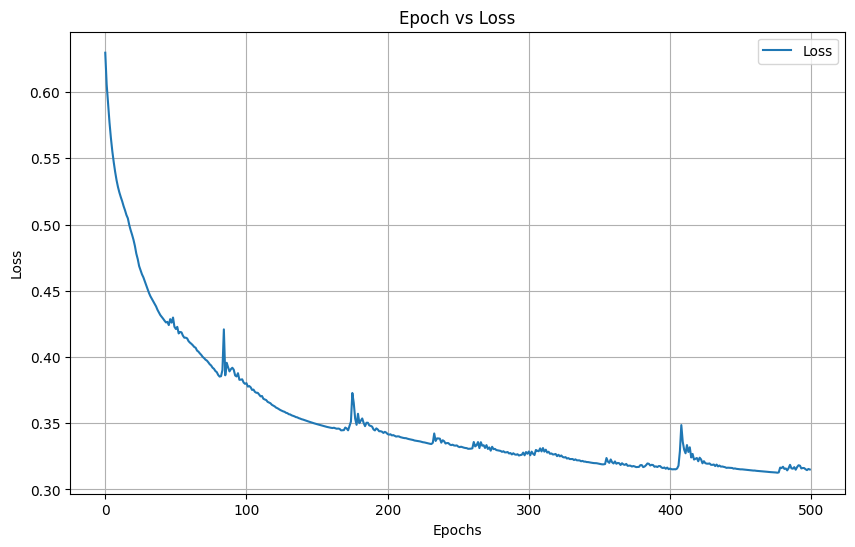

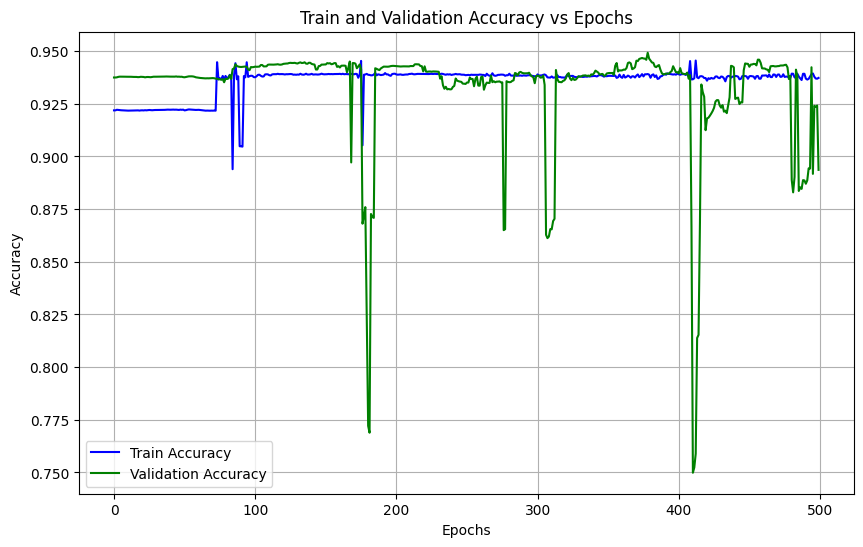

Precision: 0.5892
Recall: 0.5689
F1 Score: 0.5789


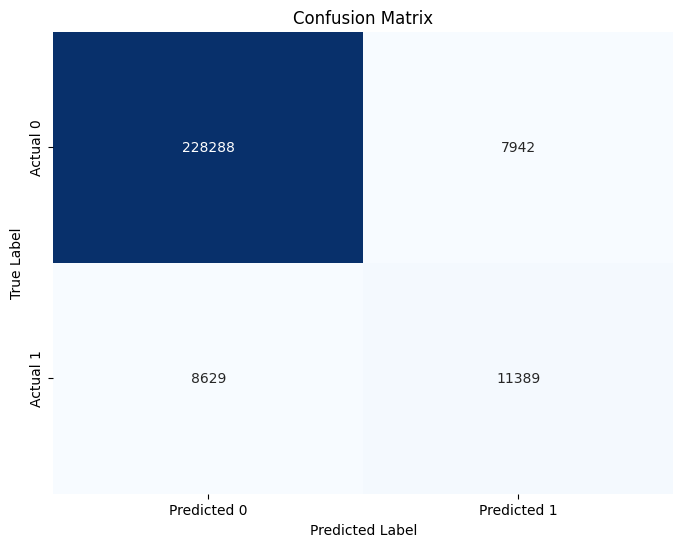

In [ ]:
#GIN V 7-11
import os
import torch
import torch.nn.functional as F
import seaborn as sns
from torch_geometric.nn import GINConv
from torch_geometric.data import Data
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

# Load edge data
edge_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\2--12\extractedcolumns1.txt"
edges = np.loadtxt(edge_file, dtype=int)

# Load node features
feature_folder = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\2--12\features"
node_features_list = []

for file_name in os.listdir(feature_folder):
    if file_name.startswith("feature") and file_name.endswith(".txt"):
        file_path = os.path.join(feature_folder, file_name)
        try:
            feature_data = np.loadtxt(file_path, dtype=float)
            if feature_data.size == 0:
                print(f"Warning: {file_name} is empty. Skipping this file.")
            else:
                node_features_list.append(feature_data)
        except ValueError as e:
            print(f"Warning: Could not read {file_name}. Error: {e}")

if node_features_list:
    node_features = np.column_stack(node_features_list)
else:
    raise ValueError("No valid feature files found. Please check your input files.")

# Load labels
labels_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\2--12\node_contract_status_connected.txt"
labels = torch.tensor(np.loadtxt(labels_file, dtype=int), dtype=torch.long)

print(f"Node features shape: {node_features.shape}")
print(f"Labels shape: {labels.shape}")

# Create graph
G = nx.DiGraph()
G.add_edges_from(edges)

edge_index = torch.tensor(list(G.edges), dtype=torch.long).t().contiguous()

max_edge_index = edge_index.max()
num_nodes = node_features.shape[0]
print(f"Max edge index: {max_edge_index.item()}, Number of nodes: {num_nodes}")

if max_edge_index >= num_nodes:
    raise IndexError(f"Edge index {max_edge_index.item()} is out of bounds for number of nodes {num_nodes}.")

data = Data(x=torch.tensor(node_features, dtype=torch.float), y=labels, edge_index=edge_index)

# Define GIN model
class GIN(torch.nn.Module):
    def __init__(self):
        super(GIN, self).__init__()
        from torch_geometric.nn import MLP
        self.mlp1 = MLP([data.num_node_features, 16, 16])
        self.mlp2 = MLP([16, 16, 16])
        self.mlp3 = MLP([16, 16, 2])
        self.conv1 = GINConv(self.mlp1)
        self.conv2 = GINConv(self.mlp2)
        self.conv3 = GINConv(self.mlp3)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)
        return x

model = GIN()


class_counts = torch.bincount(data.y)
class_weights = 1.0 / torch.sqrt(class_counts.float() + 1e-6)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training mask
y_0_indices = (data.y == 0).nonzero(as_tuple=True)[0]
y_1_indices = (data.y == 1).nonzero(as_tuple=True)[0]
train_indices = torch.cat([y_0_indices, y_1_indices])
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[train_indices] = True

# Load new features and labels for validation
new_feature_folder = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\7-11\features"
new_labels_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\7-11\node_contract_status_connected.txt" 
new_edge_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\7-11\extractedcolumns1.txt" 

new_node_features_list = []
for file_name in os.listdir(new_feature_folder):
    if file_name.startswith("feature") and file_name.endswith(".txt"):
        file_path = os.path.join(new_feature_folder, file_name)
        try:
            feature_data = np.loadtxt(file_path, dtype=float)
            if feature_data.size == 0:
                print(f"Warning: {file_name} is empty. Skipping this file.")
            else:
                new_node_features_list.append(feature_data)
        except ValueError as e:
            print(f"Warning: Could not read {file_name}. Error: {e}")

if new_node_features_list:
    new_node_features = np.column_stack(new_node_features_list)
    new_labels = torch.tensor(np.loadtxt(new_labels_file, dtype=int), dtype=torch.long)
else:
    raise ValueError("No valid new feature files found. Please check your input files.")

new_edges = np.loadtxt(new_edge_file, dtype=int)
new_edge_index = torch.tensor(list(new_edges), dtype=torch.long).t().contiguous()

# Training and validation
validation_accuracies = []
train_accuracies = []
loss_values = []

for epoch in range(500):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[train_mask], data.y[train_mask])
    loss.backward()
    optimizer.step()

    pred_train = out.argmax(dim=1)
    train_acc = (pred_train[train_mask] == data.y[train_mask]).sum().item() / train_mask.sum().item()

    model.eval()
    with torch.no_grad():
        out_val = model(torch.tensor(new_node_features, dtype=torch.float), new_edge_index)
        pred_val = out_val.argmax(dim=1)
        val_acc = (pred_val == new_labels).sum().item() / new_labels.size(0)

    loss_values.append(loss.item())
    train_accuracies.append(train_acc)
    validation_accuracies.append(val_acc)

    if epoch % 10 == 0:
        print(f'Epoch {epoch:>3} | Loss: {loss.item():.4f} | Train Accuracy: {train_acc*100:.2f}% | Validation Accuracy: {val_acc*100:.2f}%')

# Loss and accuracy plots
plt.figure(figsize=(10, 6))
plt.plot(range(500), loss_values, label="Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Epoch vs Loss")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range(500), train_accuracies, label="Train Accuracy", color='blue')
plt.plot(range(500), validation_accuracies, label="Validation Accuracy", color='green')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train and Validation Accuracy vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

# Evaluation
model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index)
    y_pred = out.argmax(dim=1).cpu().numpy()
    y_true = data.y.cpu().numpy()

conf_matrix = confusion_matrix(y_true[train_mask], y_pred[train_mask])
precision = precision_score(y_true[train_mask], y_pred[train_mask], average='binary', zero_division=0)
recall = recall_score(y_true[train_mask], y_pred[train_mask], average='binary', zero_division=0)
f1 = f1_score(y_true[train_mask], y_pred[train_mask], average='binary', zero_division=0)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


Node features shape: (256248, 6)
Labels shape: torch.Size([256248])
Max edge index: 256247, Number of nodes: 256248
Epoch   0 | Loss: 0.7022 | Train Accuracy: 25.67% | Validation Accuracy: 6.27%
Epoch  10 | Loss: 0.5459 | Train Accuracy: 92.19% | Validation Accuracy: 93.75%
Epoch  20 | Loss: 0.5110 | Train Accuracy: 92.19% | Validation Accuracy: 93.74%
Epoch  30 | Loss: 0.4725 | Train Accuracy: 92.16% | Validation Accuracy: 93.77%
Epoch  40 | Loss: 0.4458 | Train Accuracy: 92.11% | Validation Accuracy: 93.71%
Epoch  50 | Loss: 0.4258 | Train Accuracy: 92.76% | Validation Accuracy: 93.63%
Epoch  60 | Loss: 0.4133 | Train Accuracy: 92.94% | Validation Accuracy: 94.14%
Epoch  70 | Loss: 0.4100 | Train Accuracy: 92.31% | Validation Accuracy: 93.84%
Epoch  80 | Loss: 0.3937 | Train Accuracy: 93.69% | Validation Accuracy: 93.69%
Epoch  90 | Loss: 0.3832 | Train Accuracy: 93.71% | Validation Accuracy: 93.63%
Epoch 100 | Loss: 0.3816 | Train Accuracy: 93.69% | Validation Accuracy: 93.72%
Epoch

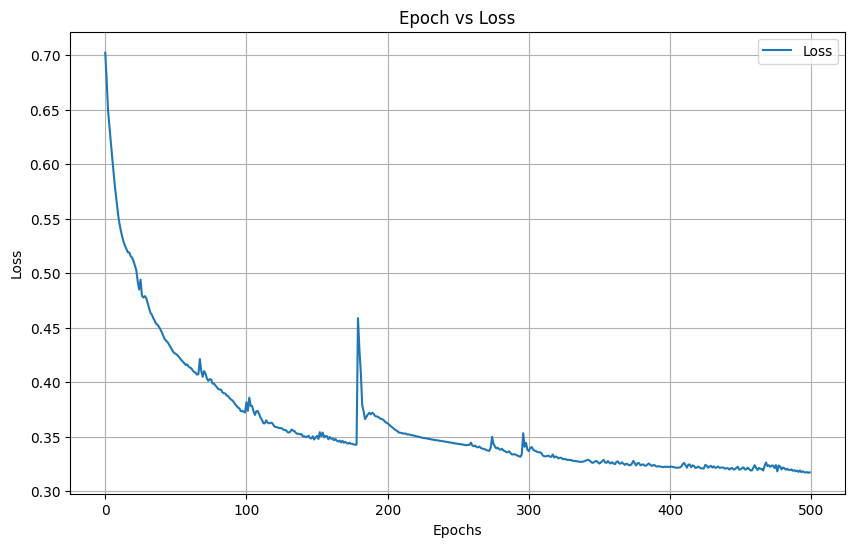

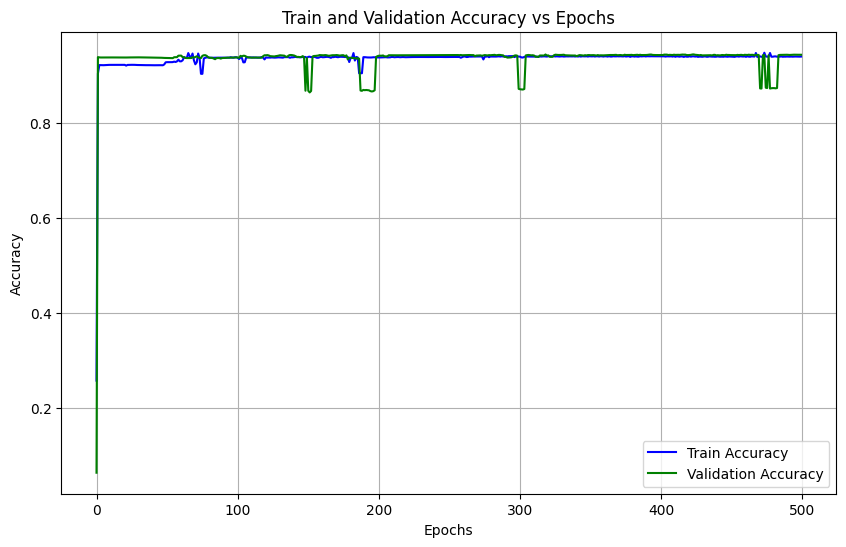

Precision: 0.8114
Recall: 0.4249
F1 Score: 0.5577


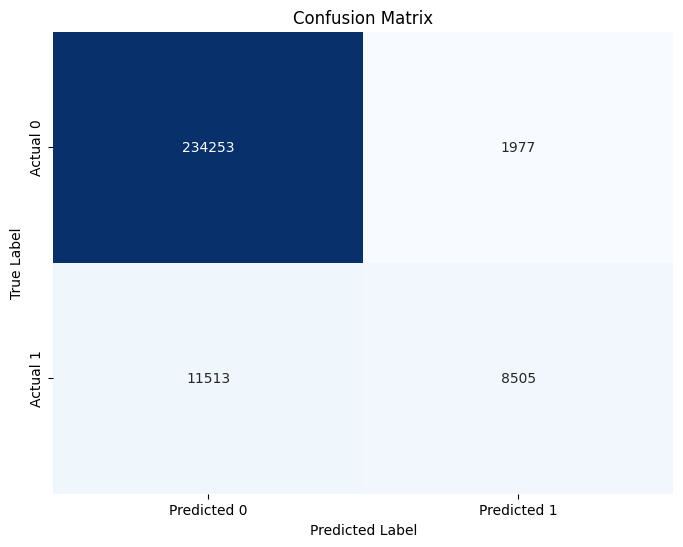

In [62]:
#GIN V 8-11
import os
import torch
import torch.nn.functional as F
import seaborn as sns
from torch_geometric.nn import GINConv
from torch_geometric.data import Data
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

# Load edge data
edge_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\2--12\extractedcolumns1.txt"
edges = np.loadtxt(edge_file, dtype=int)

# Load node features
feature_folder = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\2--12\features"
node_features_list = []

for file_name in os.listdir(feature_folder):
    if file_name.startswith("feature") and file_name.endswith(".txt"):
        file_path = os.path.join(feature_folder, file_name)
        try:
            feature_data = np.loadtxt(file_path, dtype=float)
            if feature_data.size == 0:
                print(f"Warning: {file_name} is empty. Skipping this file.")
            else:
                node_features_list.append(feature_data)
        except ValueError as e:
            print(f"Warning: Could not read {file_name}. Error: {e}")

if node_features_list:
    node_features = np.column_stack(node_features_list)
else:
    raise ValueError("No valid feature files found. Please check your input files.")

# Load labels
labels_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\2--12\node_contract_status_connected.txt"
labels = torch.tensor(np.loadtxt(labels_file, dtype=int), dtype=torch.long)

print(f"Node features shape: {node_features.shape}")
print(f"Labels shape: {labels.shape}")

# Create graph
G = nx.DiGraph()
G.add_edges_from(edges)

edge_index = torch.tensor(list(G.edges), dtype=torch.long).t().contiguous()

max_edge_index = edge_index.max()
num_nodes = node_features.shape[0]
print(f"Max edge index: {max_edge_index.item()}, Number of nodes: {num_nodes}")

if max_edge_index >= num_nodes:
    raise IndexError(f"Edge index {max_edge_index.item()} is out of bounds for number of nodes {num_nodes}.")

data = Data(x=torch.tensor(node_features, dtype=torch.float), y=labels, edge_index=edge_index)

# Define GIN model
class GIN(torch.nn.Module):
    def __init__(self):
        super(GIN, self).__init__()
        from torch_geometric.nn import MLP
        self.mlp1 = MLP([data.num_node_features, 16, 16])
        self.mlp2 = MLP([16, 16, 16])
        self.mlp3 = MLP([16, 16, 2])
        self.conv1 = GINConv(self.mlp1)
        self.conv2 = GINConv(self.mlp2)
        self.conv3 = GINConv(self.mlp3)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)
        return x

model = GIN()

# Class weights for imbalanced classes
class_counts = torch.bincount(data.y)
class_weights = 1.0 / torch.sqrt(class_counts.float() + 1e-6)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training mask
y_0_indices = (data.y == 0).nonzero(as_tuple=True)[0]
y_1_indices = (data.y == 1).nonzero(as_tuple=True)[0]
train_indices = torch.cat([y_0_indices, y_1_indices])
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[train_indices] = True

# Load new features and labels for validation
new_feature_folder = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\8-11\features"
new_labels_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\8-11\node_contract_status_connected.txt" 
new_edge_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\8-11\extractedcolumns1.txt" 

new_node_features_list = []
for file_name in os.listdir(new_feature_folder):
    if file_name.startswith("feature") and file_name.endswith(".txt"):
        file_path = os.path.join(new_feature_folder, file_name)
        try:
            feature_data = np.loadtxt(file_path, dtype=float)
            if feature_data.size == 0:
                print(f"Warning: {file_name} is empty. Skipping this file.")
            else:
                new_node_features_list.append(feature_data)
        except ValueError as e:
            print(f"Warning: Could not read {file_name}. Error: {e}")

if new_node_features_list:
    new_node_features = np.column_stack(new_node_features_list)
    new_labels = torch.tensor(np.loadtxt(new_labels_file, dtype=int), dtype=torch.long)
else:
    raise ValueError("No valid new feature files found. Please check your input files.")

new_edges = np.loadtxt(new_edge_file, dtype=int)
new_edge_index = torch.tensor(list(new_edges), dtype=torch.long).t().contiguous()

# Training and validation
validation_accuracies = []
train_accuracies = []
loss_values = []

for epoch in range(500):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[train_mask], data.y[train_mask])
    loss.backward()
    optimizer.step()

    pred_train = out.argmax(dim=1)
    train_acc = (pred_train[train_mask] == data.y[train_mask]).sum().item() / train_mask.sum().item()

    model.eval()
    with torch.no_grad():
        out_val = model(torch.tensor(new_node_features, dtype=torch.float), new_edge_index)
        pred_val = out_val.argmax(dim=1)
        val_acc = (pred_val == new_labels).sum().item() / new_labels.size(0)

    loss_values.append(loss.item())
    train_accuracies.append(train_acc)
    validation_accuracies.append(val_acc)

    if epoch % 10 == 0:
        print(f'Epoch {epoch:>3} | Loss: {loss.item():.4f} | Train Accuracy: {train_acc*100:.2f}% | Validation Accuracy: {val_acc*100:.2f}%')

# Loss and accuracy plots
plt.figure(figsize=(10, 6))
plt.plot(range(500), loss_values, label="Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Epoch vs Loss")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range(500), train_accuracies, label="Train Accuracy", color='blue')
plt.plot(range(500), validation_accuracies, label="Validation Accuracy", color='green')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train and Validation Accuracy vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

# Evaluation
model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index)
    y_pred = out.argmax(dim=1).cpu().numpy()
    y_true = data.y.cpu().numpy()

conf_matrix = confusion_matrix(y_true[train_mask], y_pred[train_mask])
precision = precision_score(y_true[train_mask], y_pred[train_mask], average='binary', zero_division=0)
recall = recall_score(y_true[train_mask], y_pred[train_mask], average='binary', zero_division=0)
f1 = f1_score(y_true[train_mask], y_pred[train_mask], average='binary', zero_division=0)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


Node features shape: (256248, 6)
Labels shape: torch.Size([256248])
Max edge index: 256247, Number of nodes: 256248
Epoch   0 | Loss: 0.6728 | Train Accuracy: 89.79% | Validation Accuracy: 92.43%
Epoch  10 | Loss: 0.5597 | Train Accuracy: 92.16% | Validation Accuracy: 92.43%
Epoch  20 | Loss: 0.5063 | Train Accuracy: 92.19% | Validation Accuracy: 92.46%
Epoch  30 | Loss: 0.4799 | Train Accuracy: 92.20% | Validation Accuracy: 92.47%
Epoch  40 | Loss: 0.4515 | Train Accuracy: 92.14% | Validation Accuracy: 92.41%
Epoch  50 | Loss: 0.4296 | Train Accuracy: 92.65% | Validation Accuracy: 92.35%
Epoch  60 | Loss: 0.4140 | Train Accuracy: 93.01% | Validation Accuracy: 92.40%
Epoch  70 | Loss: 0.4205 | Train Accuracy: 92.83% | Validation Accuracy: 85.00%
Epoch  80 | Loss: 0.3996 | Train Accuracy: 93.58% | Validation Accuracy: 91.21%
Epoch  90 | Loss: 0.3949 | Train Accuracy: 94.60% | Validation Accuracy: 92.08%
Epoch 100 | Loss: 0.3710 | Train Accuracy: 93.57% | Validation Accuracy: 92.18%
Epoc

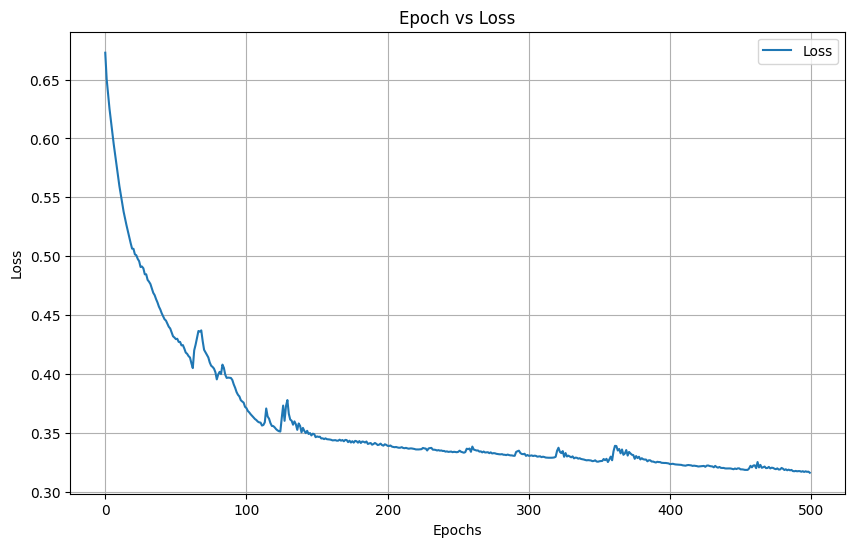

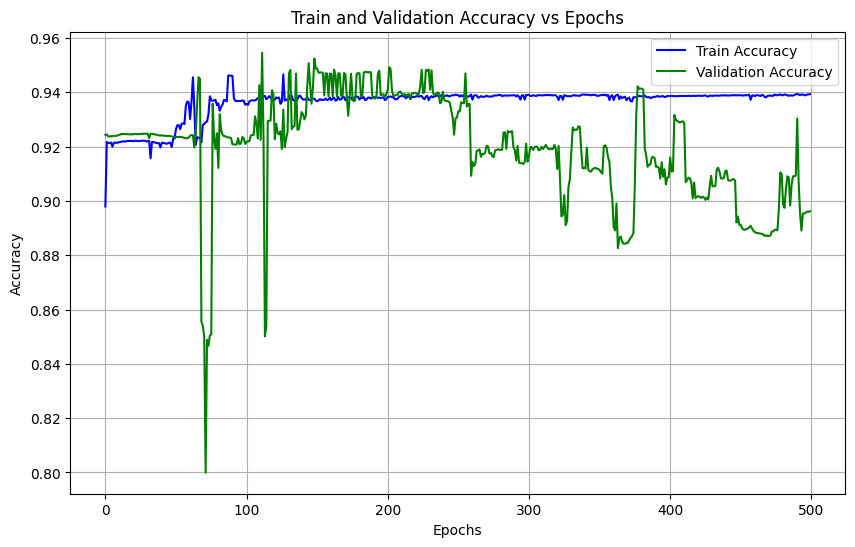

Precision: 0.6241
Recall: 0.5526
F1 Score: 0.5862


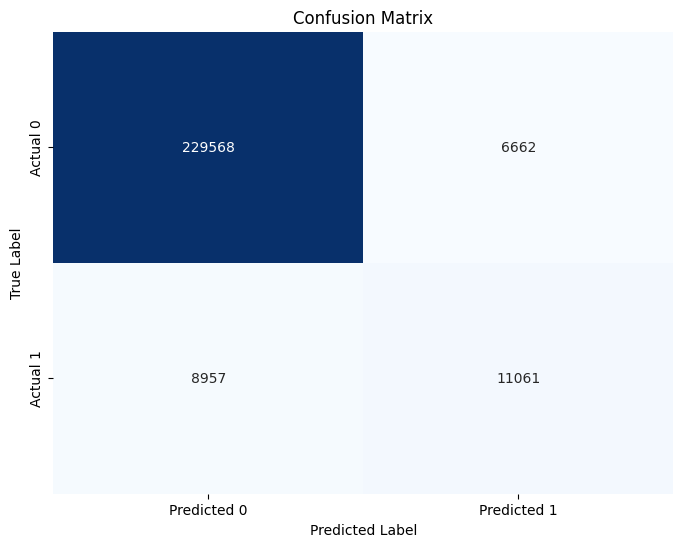

In [61]:
#GIN V 12-11
import os
import torch
import torch.nn.functional as F
import seaborn as sns
from torch_geometric.nn import GINConv
from torch_geometric.data import Data
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

# Load edge data
edge_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\2--12\extractedcolumns1.txt"
edges = np.loadtxt(edge_file, dtype=int)

# Load node features
feature_folder = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\2--12\features"
node_features_list = []

for file_name in os.listdir(feature_folder):
    if file_name.startswith("feature") and file_name.endswith(".txt"):
        file_path = os.path.join(feature_folder, file_name)
        try:
            feature_data = np.loadtxt(file_path, dtype=float)
            if feature_data.size == 0:
                print(f"Warning: {file_name} is empty. Skipping this file.")
            else:
                node_features_list.append(feature_data)
        except ValueError as e:
            print(f"Warning: Could not read {file_name}. Error: {e}")

if node_features_list:
    node_features = np.column_stack(node_features_list)
else:
    raise ValueError("No valid feature files found. Please check your input files.")

# Load labels
labels_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\2--12\node_contract_status_connected.txt"
labels = torch.tensor(np.loadtxt(labels_file, dtype=int), dtype=torch.long)

print(f"Node features shape: {node_features.shape}")
print(f"Labels shape: {labels.shape}")

# Create graph
G = nx.DiGraph()
G.add_edges_from(edges)

edge_index = torch.tensor(list(G.edges), dtype=torch.long).t().contiguous()

max_edge_index = edge_index.max()
num_nodes = node_features.shape[0]
print(f"Max edge index: {max_edge_index.item()}, Number of nodes: {num_nodes}")

if max_edge_index >= num_nodes:
    raise IndexError(f"Edge index {max_edge_index.item()} is out of bounds for number of nodes {num_nodes}.")

data = Data(x=torch.tensor(node_features, dtype=torch.float), y=labels, edge_index=edge_index)

# Define GIN model
class GIN(torch.nn.Module):
    def __init__(self):
        super(GIN, self).__init__()
        from torch_geometric.nn import MLP
        self.mlp1 = MLP([data.num_node_features, 16, 16])
        self.mlp2 = MLP([16, 16, 16])
        self.mlp3 = MLP([16, 16, 2])
        self.conv1 = GINConv(self.mlp1)
        self.conv2 = GINConv(self.mlp2)
        self.conv3 = GINConv(self.mlp3)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)
        return x

model = GIN()

# Class weights for imbalanced classes
class_counts = torch.bincount(data.y)
class_weights = 1.0 / torch.sqrt(class_counts.float() + 1e-6)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training mask
y_0_indices = (data.y == 0).nonzero(as_tuple=True)[0]
y_1_indices = (data.y == 1).nonzero(as_tuple=True)[0]
train_indices = torch.cat([y_0_indices, y_1_indices])
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[train_indices] = True

# Load new features and labels for validation
new_feature_folder = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\12-11\features"
new_labels_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\12-11\node_contract_status_connected.txt" 
new_edge_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\12-11\extractedcolumns1.txt" 

new_node_features_list = []
for file_name in os.listdir(new_feature_folder):
    if file_name.startswith("feature") and file_name.endswith(".txt"):
        file_path = os.path.join(new_feature_folder, file_name)
        try:
            feature_data = np.loadtxt(file_path, dtype=float)
            if feature_data.size == 0:
                print(f"Warning: {file_name} is empty. Skipping this file.")
            else:
                new_node_features_list.append(feature_data)
        except ValueError as e:
            print(f"Warning: Could not read {file_name}. Error: {e}")

if new_node_features_list:
    new_node_features = np.column_stack(new_node_features_list)
    new_labels = torch.tensor(np.loadtxt(new_labels_file, dtype=int), dtype=torch.long)
else:
    raise ValueError("No valid new feature files found. Please check your input files.")

new_edges = np.loadtxt(new_edge_file, dtype=int)
new_edge_index = torch.tensor(list(new_edges), dtype=torch.long).t().contiguous()

# Training and validation
validation_accuracies = []
train_accuracies = []
loss_values = []

for epoch in range(500):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[train_mask], data.y[train_mask])
    loss.backward()
    optimizer.step()

    pred_train = out.argmax(dim=1)
    train_acc = (pred_train[train_mask] == data.y[train_mask]).sum().item() / train_mask.sum().item()

    model.eval()
    with torch.no_grad():
        out_val = model(torch.tensor(new_node_features, dtype=torch.float), new_edge_index)
        pred_val = out_val.argmax(dim=1)
        val_acc = (pred_val == new_labels).sum().item() / new_labels.size(0)

    loss_values.append(loss.item())
    train_accuracies.append(train_acc)
    validation_accuracies.append(val_acc)

    if epoch % 10 == 0:
        print(f'Epoch {epoch:>3} | Loss: {loss.item():.4f} | Train Accuracy: {train_acc*100:.2f}% | Validation Accuracy: {val_acc*100:.2f}%')

# Loss and accuracy plots
plt.figure(figsize=(10, 6))
plt.plot(range(500), loss_values, label="Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Epoch vs Loss")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range(500), train_accuracies, label="Train Accuracy", color='blue')
plt.plot(range(500), validation_accuracies, label="Validation Accuracy", color='green')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train and Validation Accuracy vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

# Evaluation
model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index)
    y_pred = out.argmax(dim=1).cpu().numpy()
    y_true = data.y.cpu().numpy()

conf_matrix = confusion_matrix(y_true[train_mask], y_pred[train_mask])
precision = precision_score(y_true[train_mask], y_pred[train_mask], average='binary', zero_division=0)
recall = recall_score(y_true[train_mask], y_pred[train_mask], average='binary', zero_division=0)
f1 = f1_score(y_true[train_mask], y_pred[train_mask], average='binary', zero_division=0)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


Node features shape: (256248, 6)
Labels shape: torch.Size([256248])
Max edge index: 256247, Number of nodes: 256248
Epoch   0 | Loss: 0.7876 | Train Accuracy: 7.81% | Validation Accuracy: 7.00%
Epoch  10 | Loss: 0.5776 | Train Accuracy: 92.17% | Validation Accuracy: 92.94%
Epoch  20 | Loss: 0.5355 | Train Accuracy: 92.19% | Validation Accuracy: 93.02%
Epoch  30 | Loss: 0.5120 | Train Accuracy: 92.14% | Validation Accuracy: 92.98%
Epoch  40 | Loss: 0.4685 | Train Accuracy: 92.15% | Validation Accuracy: 92.99%
Epoch  50 | Loss: 0.4336 | Train Accuracy: 91.98% | Validation Accuracy: 93.01%
Epoch  60 | Loss: 0.4167 | Train Accuracy: 92.14% | Validation Accuracy: 93.03%
Epoch  70 | Loss: 0.4065 | Train Accuracy: 92.13% | Validation Accuracy: 92.96%
Epoch  80 | Loss: 0.3891 | Train Accuracy: 93.91% | Validation Accuracy: 93.45%
Epoch  90 | Loss: 0.3854 | Train Accuracy: 94.59% | Validation Accuracy: 93.50%
Epoch 100 | Loss: 0.3671 | Train Accuracy: 93.81% | Validation Accuracy: 93.55%
Epoch 

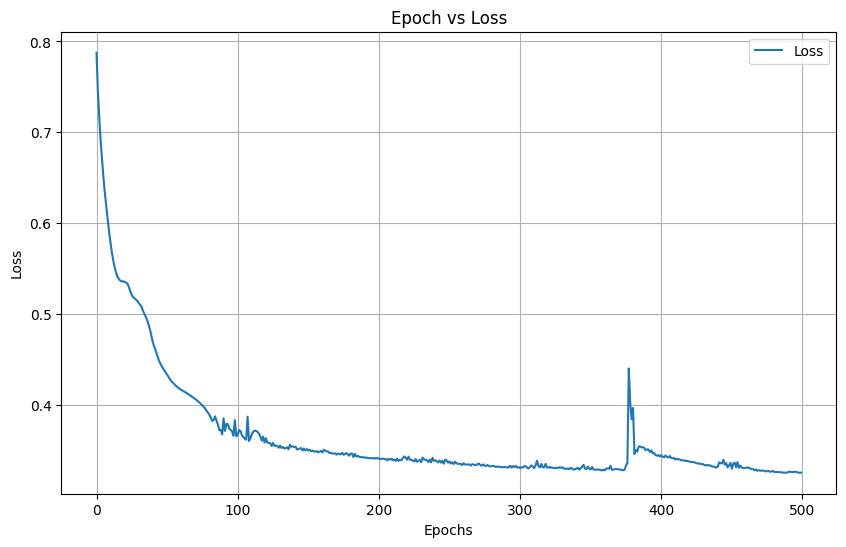

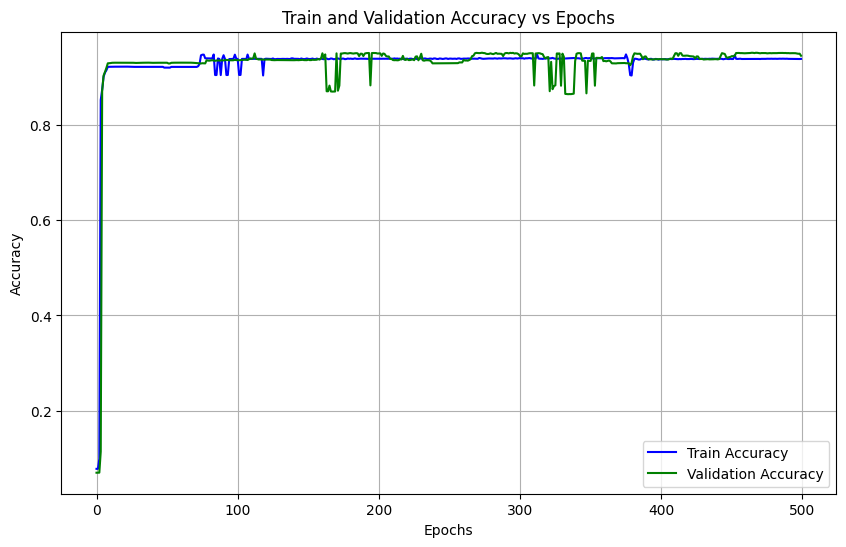

Precision: 0.5963
Recall: 0.5588
F1 Score: 0.5769


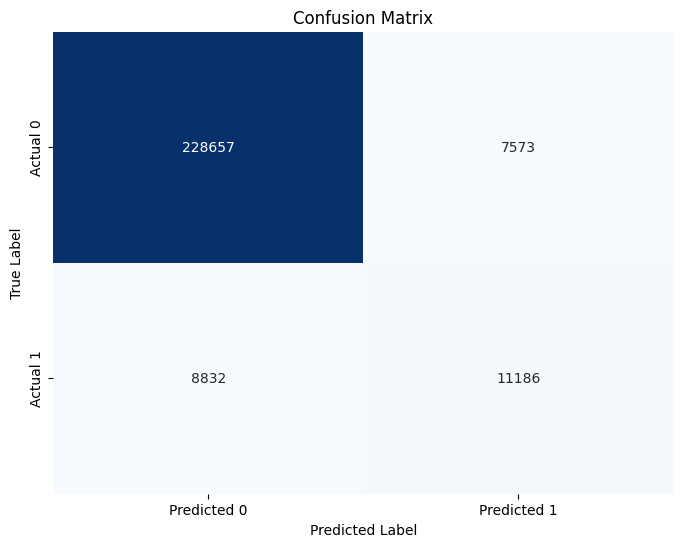

In [60]:
#GIN V 13-11
import os
import torch
import torch.nn.functional as F
import seaborn as sns
from torch_geometric.nn import GINConv
from torch_geometric.data import Data
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

# Load edge data
edge_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\2--12\extractedcolumns1.txt"
edges = np.loadtxt(edge_file, dtype=int)

# Load node features
feature_folder = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\2--12\features"
node_features_list = []

for file_name in os.listdir(feature_folder):
    if file_name.startswith("feature") and file_name.endswith(".txt"):
        file_path = os.path.join(feature_folder, file_name)
        try:
            feature_data = np.loadtxt(file_path, dtype=float)
            if feature_data.size == 0:
                print(f"Warning: {file_name} is empty. Skipping this file.")
            else:
                node_features_list.append(feature_data)
        except ValueError as e:
            print(f"Warning: Could not read {file_name}. Error: {e}")

if node_features_list:
    node_features = np.column_stack(node_features_list)
else:
    raise ValueError("No valid feature files found. Please check your input files.")

# Load labels
labels_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\2--12\node_contract_status_connected.txt"
labels = torch.tensor(np.loadtxt(labels_file, dtype=int), dtype=torch.long)

print(f"Node features shape: {node_features.shape}")
print(f"Labels shape: {labels.shape}")

# Create graph
G = nx.DiGraph()
G.add_edges_from(edges)

edge_index = torch.tensor(list(G.edges), dtype=torch.long).t().contiguous()

max_edge_index = edge_index.max()
num_nodes = node_features.shape[0]
print(f"Max edge index: {max_edge_index.item()}, Number of nodes: {num_nodes}")

if max_edge_index >= num_nodes:
    raise IndexError(f"Edge index {max_edge_index.item()} is out of bounds for number of nodes {num_nodes}.")

data = Data(x=torch.tensor(node_features, dtype=torch.float), y=labels, edge_index=edge_index)

# Define GIN model
class GIN(torch.nn.Module):
    def __init__(self):
        super(GIN, self).__init__()
        from torch_geometric.nn import MLP
        self.mlp1 = MLP([data.num_node_features, 16, 16])
        self.mlp2 = MLP([16, 16, 16])
        self.mlp3 = MLP([16, 16, 2])
        self.conv1 = GINConv(self.mlp1)
        self.conv2 = GINConv(self.mlp2)
        self.conv3 = GINConv(self.mlp3)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)
        return x

model = GIN()

# Class weights for imbalanced classes
class_counts = torch.bincount(data.y)
class_weights = 1.0 / torch.sqrt(class_counts.float() + 1e-6)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training mask
y_0_indices = (data.y == 0).nonzero(as_tuple=True)[0]
y_1_indices = (data.y == 1).nonzero(as_tuple=True)[0]
train_indices = torch.cat([y_0_indices, y_1_indices])
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[train_indices] = True

# Load new features and labels for validation
new_feature_folder = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\13-11\features"
new_labels_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\13-11\node_contract_status_connected.txt" 
new_edge_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\13-11\extractedcolumns1.txt" 

new_node_features_list = []
for file_name in os.listdir(new_feature_folder):
    if file_name.startswith("feature") and file_name.endswith(".txt"):
        file_path = os.path.join(new_feature_folder, file_name)
        try:
            feature_data = np.loadtxt(file_path, dtype=float)
            if feature_data.size == 0:
                print(f"Warning: {file_name} is empty. Skipping this file.")
            else:
                new_node_features_list.append(feature_data)
        except ValueError as e:
            print(f"Warning: Could not read {file_name}. Error: {e}")

if new_node_features_list:
    new_node_features = np.column_stack(new_node_features_list)
    new_labels = torch.tensor(np.loadtxt(new_labels_file, dtype=int), dtype=torch.long)
else:
    raise ValueError("No valid new feature files found. Please check your input files.")

new_edges = np.loadtxt(new_edge_file, dtype=int)
new_edge_index = torch.tensor(list(new_edges), dtype=torch.long).t().contiguous()

# Training and validation
validation_accuracies = []
train_accuracies = []
loss_values = []

for epoch in range(500):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[train_mask], data.y[train_mask])
    loss.backward()
    optimizer.step()

    pred_train = out.argmax(dim=1)
    train_acc = (pred_train[train_mask] == data.y[train_mask]).sum().item() / train_mask.sum().item()

    model.eval()
    with torch.no_grad():
        out_val = model(torch.tensor(new_node_features, dtype=torch.float), new_edge_index)
        pred_val = out_val.argmax(dim=1)
        val_acc = (pred_val == new_labels).sum().item() / new_labels.size(0)

    loss_values.append(loss.item())
    train_accuracies.append(train_acc)
    validation_accuracies.append(val_acc)

    if epoch % 10 == 0:
        print(f'Epoch {epoch:>3} | Loss: {loss.item():.4f} | Train Accuracy: {train_acc*100:.2f}% | Validation Accuracy: {val_acc*100:.2f}%')

# Loss and accuracy plots
plt.figure(figsize=(10, 6))
plt.plot(range(500), loss_values, label="Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Epoch vs Loss")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range(500), train_accuracies, label="Train Accuracy", color='blue')
plt.plot(range(500), validation_accuracies, label="Validation Accuracy", color='green')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train and Validation Accuracy vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

# Evaluation
model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index)
    y_pred = out.argmax(dim=1).cpu().numpy()
    y_true = data.y.cpu().numpy()

conf_matrix = confusion_matrix(y_true[train_mask], y_pred[train_mask])
precision = precision_score(y_true[train_mask], y_pred[train_mask], average='binary', zero_division=0)
recall = recall_score(y_true[train_mask], y_pred[train_mask], average='binary', zero_division=0)
f1 = f1_score(y_true[train_mask], y_pred[train_mask], average='binary', zero_division=0)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


Node features shape: (256248, 6)
Labels shape: torch.Size([256248])
Max edge index: 256247, Number of nodes: 256248
Epoch   0 | Loss: 0.8116 | Train Accuracy: 7.82% | Validation Accuracy: 14.86%
Epoch  10 | Loss: 0.5757 | Train Accuracy: 91.80% | Validation Accuracy: 84.15%
Epoch  20 | Loss: 0.5124 | Train Accuracy: 92.13% | Validation Accuracy: 92.06%
Epoch  30 | Loss: 0.4643 | Train Accuracy: 91.95% | Validation Accuracy: 92.25%
Epoch  40 | Loss: 0.4353 | Train Accuracy: 92.11% | Validation Accuracy: 92.25%
Epoch  50 | Loss: 0.4219 | Train Accuracy: 92.13% | Validation Accuracy: 92.29%
Epoch  60 | Loss: 0.4182 | Train Accuracy: 92.14% | Validation Accuracy: 92.31%
Epoch  70 | Loss: 0.4082 | Train Accuracy: 92.15% | Validation Accuracy: 92.32%
Epoch  80 | Loss: 0.4023 | Train Accuracy: 93.30% | Validation Accuracy: 92.25%
Epoch  90 | Loss: 0.4003 | Train Accuracy: 94.65% | Validation Accuracy: 92.24%
Epoch 100 | Loss: 0.3955 | Train Accuracy: 94.68% | Validation Accuracy: 92.95%
Epoch

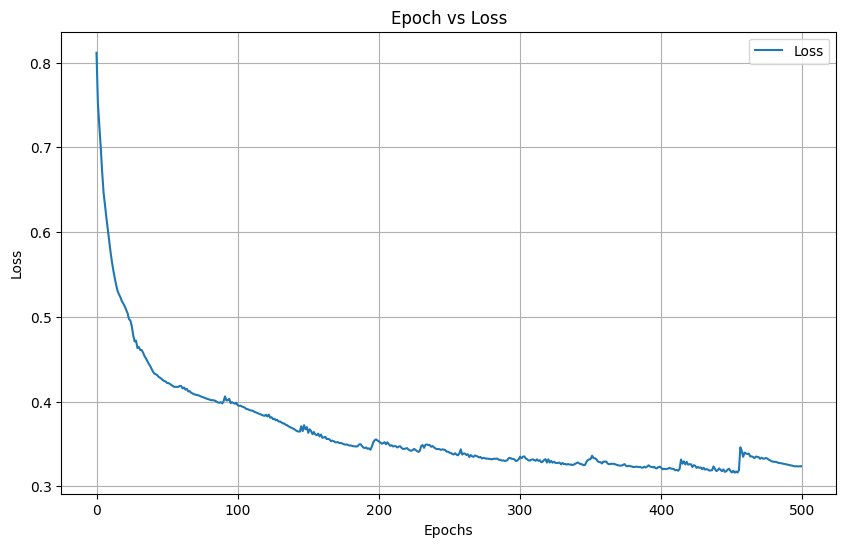

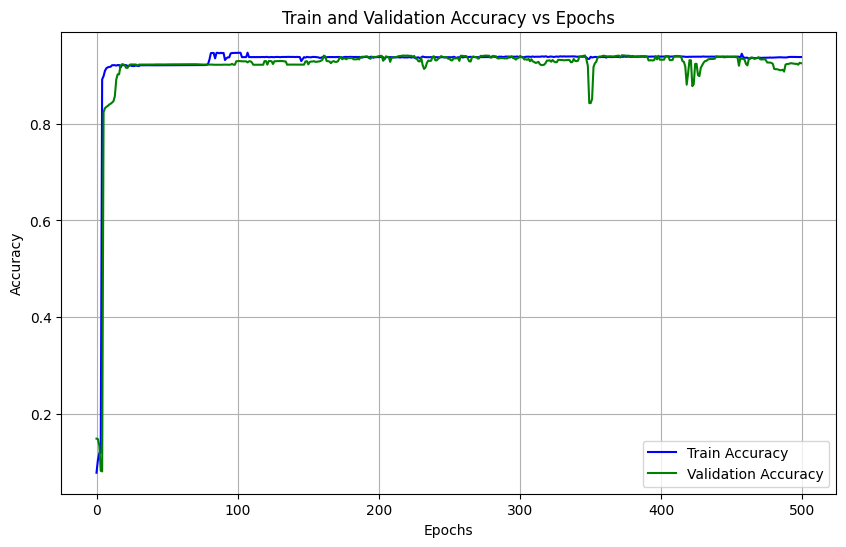

Precision: 0.5762
Recall: 0.5573
F1 Score: 0.5666


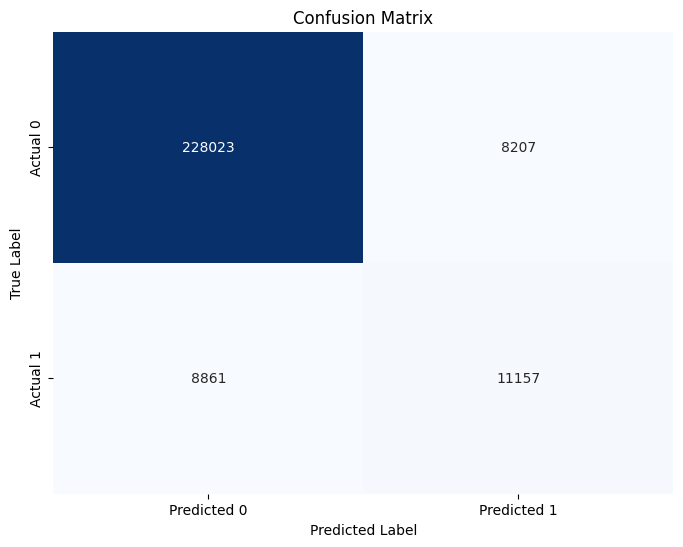

In [59]:
#GIN V 14-11
import os
import torch
import torch.nn.functional as F
import seaborn as sns
from torch_geometric.nn import GINConv
from torch_geometric.data import Data
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

# Load edge data
edge_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\2--12\extractedcolumns1.txt"
edges = np.loadtxt(edge_file, dtype=int)

# Load node features
feature_folder = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\2--12\features"
node_features_list = []

for file_name in os.listdir(feature_folder):
    if file_name.startswith("feature") and file_name.endswith(".txt"):
        file_path = os.path.join(feature_folder, file_name)
        try:
            feature_data = np.loadtxt(file_path, dtype=float)
            if feature_data.size == 0:
                print(f"Warning: {file_name} is empty. Skipping this file.")
            else:
                node_features_list.append(feature_data)
        except ValueError as e:
            print(f"Warning: Could not read {file_name}. Error: {e}")

if node_features_list:
    node_features = np.column_stack(node_features_list)
else:
    raise ValueError("No valid feature files found. Please check your input files.")

# Load labels
labels_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\2--12\node_contract_status_connected.txt"
labels = torch.tensor(np.loadtxt(labels_file, dtype=int), dtype=torch.long)

print(f"Node features shape: {node_features.shape}")
print(f"Labels shape: {labels.shape}")

# Create graph
G = nx.DiGraph()
G.add_edges_from(edges)

edge_index = torch.tensor(list(G.edges), dtype=torch.long).t().contiguous()

max_edge_index = edge_index.max()
num_nodes = node_features.shape[0]
print(f"Max edge index: {max_edge_index.item()}, Number of nodes: {num_nodes}")

if max_edge_index >= num_nodes:
    raise IndexError(f"Edge index {max_edge_index.item()} is out of bounds for number of nodes {num_nodes}.")

data = Data(x=torch.tensor(node_features, dtype=torch.float), y=labels, edge_index=edge_index)

# Define GIN model
class GIN(torch.nn.Module):
    def __init__(self):
        super(GIN, self).__init__()
        from torch_geometric.nn import MLP
        self.mlp1 = MLP([data.num_node_features, 16, 16])
        self.mlp2 = MLP([16, 16, 16])
        self.mlp3 = MLP([16, 16, 2])
        self.conv1 = GINConv(self.mlp1)
        self.conv2 = GINConv(self.mlp2)
        self.conv3 = GINConv(self.mlp3)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)
        return x

model = GIN()

# Class weights for imbalanced classes
class_counts = torch.bincount(data.y)
class_weights = 1.0 / torch.sqrt(class_counts.float() + 1e-6)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training mask
y_0_indices = (data.y == 0).nonzero(as_tuple=True)[0]
y_1_indices = (data.y == 1).nonzero(as_tuple=True)[0]
train_indices = torch.cat([y_0_indices, y_1_indices])
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[train_indices] = True

# Load new features and labels for validation
new_feature_folder = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\14-11\features"
new_labels_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\14-11\node_contract_status_connected.txt" 
new_edge_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\14-11\extractedcolumns1.txt" 

new_node_features_list = []
for file_name in os.listdir(new_feature_folder):
    if file_name.startswith("feature") and file_name.endswith(".txt"):
        file_path = os.path.join(new_feature_folder, file_name)
        try:
            feature_data = np.loadtxt(file_path, dtype=float)
            if feature_data.size == 0:
                print(f"Warning: {file_name} is empty. Skipping this file.")
            else:
                new_node_features_list.append(feature_data)
        except ValueError as e:
            print(f"Warning: Could not read {file_name}. Error: {e}")

if new_node_features_list:
    new_node_features = np.column_stack(new_node_features_list)
    new_labels = torch.tensor(np.loadtxt(new_labels_file, dtype=int), dtype=torch.long)
else:
    raise ValueError("No valid new feature files found. Please check your input files.")

new_edges = np.loadtxt(new_edge_file, dtype=int)
new_edge_index = torch.tensor(list(new_edges), dtype=torch.long).t().contiguous()

# Training and validation
validation_accuracies = []
train_accuracies = []
loss_values = []

for epoch in range(500):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[train_mask], data.y[train_mask])
    loss.backward()
    optimizer.step()

    pred_train = out.argmax(dim=1)
    train_acc = (pred_train[train_mask] == data.y[train_mask]).sum().item() / train_mask.sum().item()

    model.eval()
    with torch.no_grad():
        out_val = model(torch.tensor(new_node_features, dtype=torch.float), new_edge_index)
        pred_val = out_val.argmax(dim=1)
        val_acc = (pred_val == new_labels).sum().item() / new_labels.size(0)

    loss_values.append(loss.item())
    train_accuracies.append(train_acc)
    validation_accuracies.append(val_acc)

    if epoch % 10 == 0:
        print(f'Epoch {epoch:>3} | Loss: {loss.item():.4f} | Train Accuracy: {train_acc*100:.2f}% | Validation Accuracy: {val_acc*100:.2f}%')

# Loss and accuracy plots
plt.figure(figsize=(10, 6))
plt.plot(range(500), loss_values, label="Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Epoch vs Loss")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range(500), train_accuracies, label="Train Accuracy", color='blue')
plt.plot(range(500), validation_accuracies, label="Validation Accuracy", color='green')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train and Validation Accuracy vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

# Evaluation
model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index)
    y_pred = out.argmax(dim=1).cpu().numpy()
    y_true = data.y.cpu().numpy()

conf_matrix = confusion_matrix(y_true[train_mask], y_pred[train_mask])
precision = precision_score(y_true[train_mask], y_pred[train_mask], average='binary', zero_division=0)
recall = recall_score(y_true[train_mask], y_pred[train_mask], average='binary', zero_division=0)
f1 = f1_score(y_true[train_mask], y_pred[train_mask], average='binary', zero_division=0)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


Node features shape: (256248, 6)
Labels shape: torch.Size([256248])
Max edge index: 256247, Number of nodes: 256248
Epoch   0 | Loss: 0.6468 | Train Accuracy: 91.34% | Validation Accuracy: 85.38%
Epoch  10 | Loss: 0.5402 | Train Accuracy: 92.18% | Validation Accuracy: 93.50%
Epoch  20 | Loss: 0.5018 | Train Accuracy: 92.20% | Validation Accuracy: 93.53%
Epoch  30 | Loss: 0.4683 | Train Accuracy: 92.18% | Validation Accuracy: 93.51%
Epoch  40 | Loss: 0.4487 | Train Accuracy: 92.20% | Validation Accuracy: 93.52%
Epoch  50 | Loss: 0.4392 | Train Accuracy: 92.21% | Validation Accuracy: 93.54%
Epoch  60 | Loss: 0.4263 | Train Accuracy: 92.21% | Validation Accuracy: 93.52%
Epoch  70 | Loss: 0.4133 | Train Accuracy: 92.15% | Validation Accuracy: 93.45%
Epoch  80 | Loss: 0.3962 | Train Accuracy: 93.77% | Validation Accuracy: 93.42%
Epoch  90 | Loss: 0.3824 | Train Accuracy: 93.25% | Validation Accuracy: 93.50%
Epoch 100 | Loss: 0.3952 | Train Accuracy: 93.38% | Validation Accuracy: 94.47%
Epoc

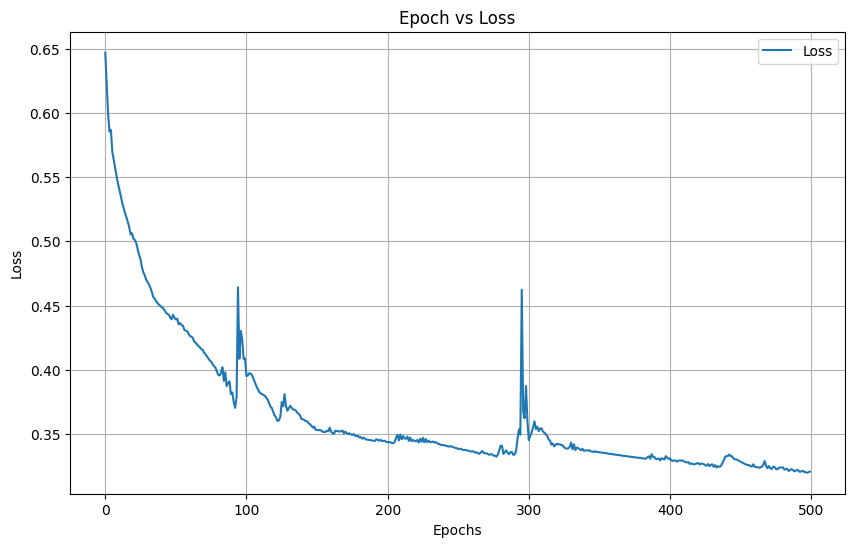

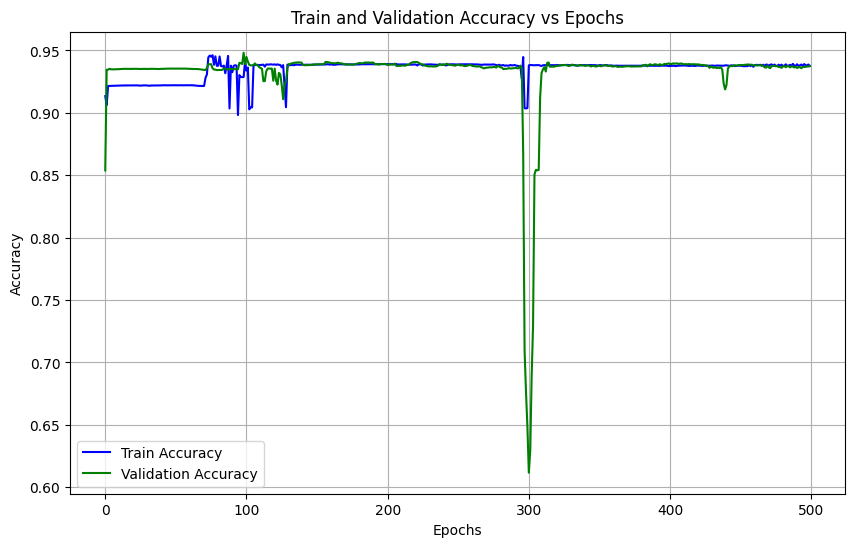

Precision: 0.6276
Recall: 0.5494
F1 Score: 0.5859


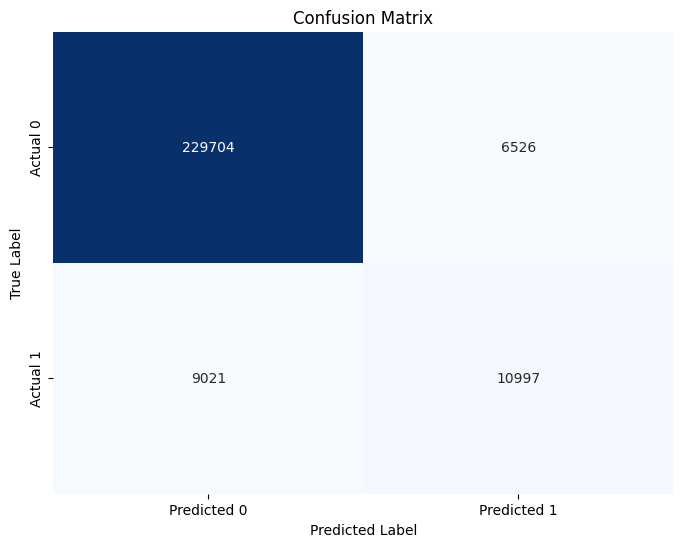

In [58]:
#GIN V 24-11
import os
import torch
import torch.nn.functional as F
import seaborn as sns
from torch_geometric.nn import GINConv
from torch_geometric.data import Data
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

# Load edge data
edge_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\2--12\extractedcolumns1.txt"
edges = np.loadtxt(edge_file, dtype=int)

# Load node features
feature_folder = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\2--12\features"
node_features_list = []

for file_name in os.listdir(feature_folder):
    if file_name.startswith("feature") and file_name.endswith(".txt"):
        file_path = os.path.join(feature_folder, file_name)
        try:
            feature_data = np.loadtxt(file_path, dtype=float)
            if feature_data.size == 0:
                print(f"Warning: {file_name} is empty. Skipping this file.")
            else:
                node_features_list.append(feature_data)
        except ValueError as e:
            print(f"Warning: Could not read {file_name}. Error: {e}")

if node_features_list:
    node_features = np.column_stack(node_features_list)
else:
    raise ValueError("No valid feature files found. Please check your input files.")

# Load labels
labels_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\2--12\node_contract_status_connected.txt"
labels = torch.tensor(np.loadtxt(labels_file, dtype=int), dtype=torch.long)

print(f"Node features shape: {node_features.shape}")
print(f"Labels shape: {labels.shape}")

# Create graph
G = nx.DiGraph()
G.add_edges_from(edges)

edge_index = torch.tensor(list(G.edges), dtype=torch.long).t().contiguous()

max_edge_index = edge_index.max()
num_nodes = node_features.shape[0]
print(f"Max edge index: {max_edge_index.item()}, Number of nodes: {num_nodes}")

if max_edge_index >= num_nodes:
    raise IndexError(f"Edge index {max_edge_index.item()} is out of bounds for number of nodes {num_nodes}.")

data = Data(x=torch.tensor(node_features, dtype=torch.float), y=labels, edge_index=edge_index)

# Define GIN model
class GIN(torch.nn.Module):
    def __init__(self):
        super(GIN, self).__init__()
        from torch_geometric.nn import MLP
        self.mlp1 = MLP([data.num_node_features, 16, 16])
        self.mlp2 = MLP([16, 16, 16])
        self.mlp3 = MLP([16, 16, 2])
        self.conv1 = GINConv(self.mlp1)
        self.conv2 = GINConv(self.mlp2)
        self.conv3 = GINConv(self.mlp3)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)
        return x

model = GIN()

# Class weights for imbalanced classes
class_counts = torch.bincount(data.y)
class_weights = 1.0 / torch.sqrt(class_counts.float() + 1e-6)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training mask
y_0_indices = (data.y == 0).nonzero(as_tuple=True)[0]
y_1_indices = (data.y == 1).nonzero(as_tuple=True)[0]
train_indices = torch.cat([y_0_indices, y_1_indices])
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[train_indices] = True

# Load new features and labels for validation
new_feature_folder = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\24-11\features"
new_labels_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\24-11\node_contract_status_connected.txt" 
new_edge_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\24-11\extractedcolumns1.txt" 

new_node_features_list = []
for file_name in os.listdir(new_feature_folder):
    if file_name.startswith("feature") and file_name.endswith(".txt"):
        file_path = os.path.join(new_feature_folder, file_name)
        try:
            feature_data = np.loadtxt(file_path, dtype=float)
            if feature_data.size == 0:
                print(f"Warning: {file_name} is empty. Skipping this file.")
            else:
                new_node_features_list.append(feature_data)
        except ValueError as e:
            print(f"Warning: Could not read {file_name}. Error: {e}")

if new_node_features_list:
    new_node_features = np.column_stack(new_node_features_list)
    new_labels = torch.tensor(np.loadtxt(new_labels_file, dtype=int), dtype=torch.long)
else:
    raise ValueError("No valid new feature files found. Please check your input files.")

new_edges = np.loadtxt(new_edge_file, dtype=int)
new_edge_index = torch.tensor(list(new_edges), dtype=torch.long).t().contiguous()

# Training and validation
validation_accuracies = []
train_accuracies = []
loss_values = []

for epoch in range(500):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[train_mask], data.y[train_mask])
    loss.backward()
    optimizer.step()

    pred_train = out.argmax(dim=1)
    train_acc = (pred_train[train_mask] == data.y[train_mask]).sum().item() / train_mask.sum().item()

    model.eval()
    with torch.no_grad():
        out_val = model(torch.tensor(new_node_features, dtype=torch.float), new_edge_index)
        pred_val = out_val.argmax(dim=1)
        val_acc = (pred_val == new_labels).sum().item() / new_labels.size(0)

    loss_values.append(loss.item())
    train_accuracies.append(train_acc)
    validation_accuracies.append(val_acc)

    if epoch % 10 == 0:
        print(f'Epoch {epoch:>3} | Loss: {loss.item():.4f} | Train Accuracy: {train_acc*100:.2f}% | Validation Accuracy: {val_acc*100:.2f}%')

# Loss and accuracy plots
plt.figure(figsize=(10, 6))
plt.plot(range(500), loss_values, label="Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Epoch vs Loss")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range(500), train_accuracies, label="Train Accuracy", color='blue')
plt.plot(range(500), validation_accuracies, label="Validation Accuracy", color='green')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train and Validation Accuracy vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

# Evaluation
model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index)
    y_pred = out.argmax(dim=1).cpu().numpy()
    y_true = data.y.cpu().numpy()

conf_matrix = confusion_matrix(y_true[train_mask], y_pred[train_mask])
precision = precision_score(y_true[train_mask], y_pred[train_mask], average='binary', zero_division=0)
recall = recall_score(y_true[train_mask], y_pred[train_mask], average='binary', zero_division=0)
f1 = f1_score(y_true[train_mask], y_pred[train_mask], average='binary', zero_division=0)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


Node features shape: (256248, 6)
Labels shape: torch.Size([256248])
Max edge index: 256247, Number of nodes: 256248
Epoch   0 | Loss: 0.7328 | Train Accuracy: 11.66% | Validation Accuracy: 85.86%
Epoch  10 | Loss: 0.5706 | Train Accuracy: 92.20% | Validation Accuracy: 93.15%
Epoch  20 | Loss: 0.5235 | Train Accuracy: 92.20% | Validation Accuracy: 93.16%
Epoch  30 | Loss: 0.4879 | Train Accuracy: 92.19% | Validation Accuracy: 93.15%
Epoch  40 | Loss: 0.4607 | Train Accuracy: 92.21% | Validation Accuracy: 93.11%
Epoch  50 | Loss: 0.4404 | Train Accuracy: 92.20% | Validation Accuracy: 93.16%
Epoch  60 | Loss: 0.4322 | Train Accuracy: 92.20% | Validation Accuracy: 93.18%
Epoch  70 | Loss: 0.4262 | Train Accuracy: 92.20% | Validation Accuracy: 93.16%
Epoch  80 | Loss: 0.4154 | Train Accuracy: 92.15% | Validation Accuracy: 93.08%
Epoch  90 | Loss: 0.4054 | Train Accuracy: 93.84% | Validation Accuracy: 93.01%
Epoch 100 | Loss: 0.3913 | Train Accuracy: 93.83% | Validation Accuracy: 92.80%
Epoc

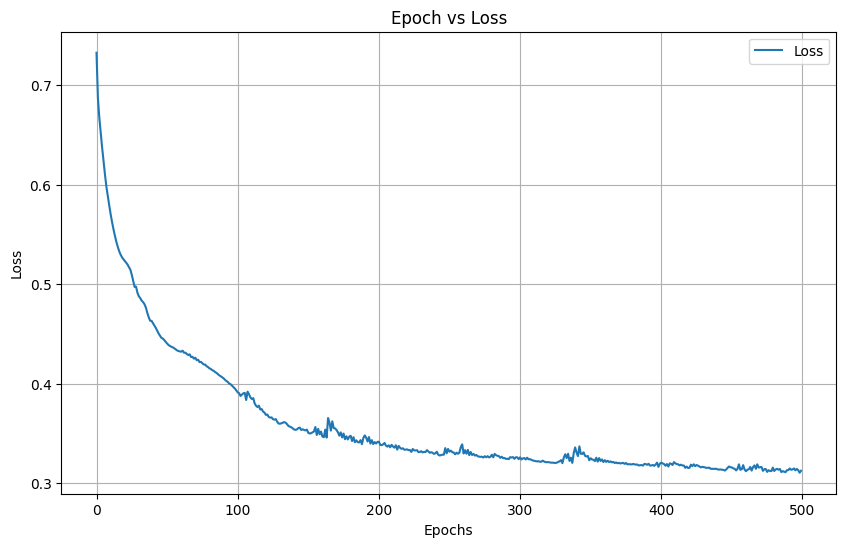

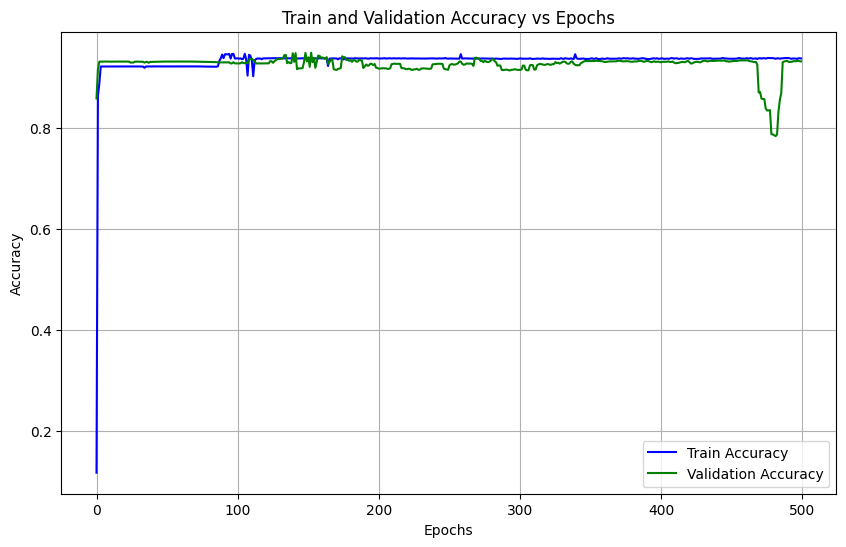

Precision: 0.8214
Recall: 0.4241
F1 Score: 0.5594


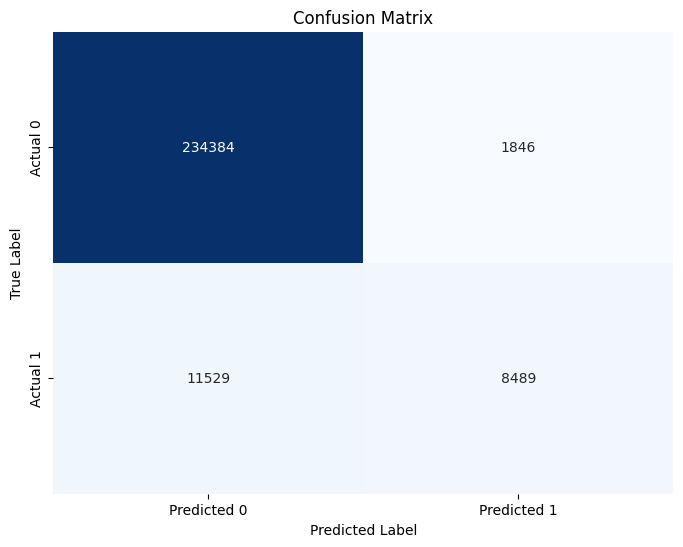

In [57]:
#GIN V 25-11
import os
import torch
import torch.nn.functional as F
import seaborn as sns
from torch_geometric.nn import GINConv
from torch_geometric.data import Data
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

# Load edge data
edge_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\2--12\extractedcolumns1.txt"
edges = np.loadtxt(edge_file, dtype=int)

# Load node features
feature_folder = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\2--12\features"
node_features_list = []

for file_name in os.listdir(feature_folder):
    if file_name.startswith("feature") and file_name.endswith(".txt"):
        file_path = os.path.join(feature_folder, file_name)
        try:
            feature_data = np.loadtxt(file_path, dtype=float)
            if feature_data.size == 0:
                print(f"Warning: {file_name} is empty. Skipping this file.")
            else:
                node_features_list.append(feature_data)
        except ValueError as e:
            print(f"Warning: Could not read {file_name}. Error: {e}")

if node_features_list:
    node_features = np.column_stack(node_features_list)
else:
    raise ValueError("No valid feature files found. Please check your input files.")

# Load labels
labels_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\2--12\node_contract_status_connected.txt"
labels = torch.tensor(np.loadtxt(labels_file, dtype=int), dtype=torch.long)

print(f"Node features shape: {node_features.shape}")
print(f"Labels shape: {labels.shape}")

# Create graph
G = nx.DiGraph()
G.add_edges_from(edges)

edge_index = torch.tensor(list(G.edges), dtype=torch.long).t().contiguous()

max_edge_index = edge_index.max()
num_nodes = node_features.shape[0]
print(f"Max edge index: {max_edge_index.item()}, Number of nodes: {num_nodes}")

if max_edge_index >= num_nodes:
    raise IndexError(f"Edge index {max_edge_index.item()} is out of bounds for number of nodes {num_nodes}.")

data = Data(x=torch.tensor(node_features, dtype=torch.float), y=labels, edge_index=edge_index)

# Define GIN model
class GIN(torch.nn.Module):
    def __init__(self):
        super(GIN, self).__init__()
        from torch_geometric.nn import MLP
        self.mlp1 = MLP([data.num_node_features, 16, 16])
        self.mlp2 = MLP([16, 16, 16])
        self.mlp3 = MLP([16, 16, 2])
        self.conv1 = GINConv(self.mlp1)
        self.conv2 = GINConv(self.mlp2)
        self.conv3 = GINConv(self.mlp3)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)
        return x

model = GIN()

# Class weights for imbalanced classes
class_counts = torch.bincount(data.y)
class_weights = 1.0 / torch.sqrt(class_counts.float() + 1e-6)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training mask
y_0_indices = (data.y == 0).nonzero(as_tuple=True)[0]
y_1_indices = (data.y == 1).nonzero(as_tuple=True)[0]
train_indices = torch.cat([y_0_indices, y_1_indices])
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[train_indices] = True

# Load new features and labels for validation
new_feature_folder = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\25-11\features"
new_labels_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\25-11\node_contract_status_connected.txt" 
new_edge_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\25-11\extractedcolumns1.txt" 

new_node_features_list = []
for file_name in os.listdir(new_feature_folder):
    if file_name.startswith("feature") and file_name.endswith(".txt"):
        file_path = os.path.join(new_feature_folder, file_name)
        try:
            feature_data = np.loadtxt(file_path, dtype=float)
            if feature_data.size == 0:
                print(f"Warning: {file_name} is empty. Skipping this file.")
            else:
                new_node_features_list.append(feature_data)
        except ValueError as e:
            print(f"Warning: Could not read {file_name}. Error: {e}")

if new_node_features_list:
    new_node_features = np.column_stack(new_node_features_list)
    new_labels = torch.tensor(np.loadtxt(new_labels_file, dtype=int), dtype=torch.long)
else:
    raise ValueError("No valid new feature files found. Please check your input files.")

new_edges = np.loadtxt(new_edge_file, dtype=int)
new_edge_index = torch.tensor(list(new_edges), dtype=torch.long).t().contiguous()

# Training and validation
validation_accuracies = []
train_accuracies = []
loss_values = []

for epoch in range(500):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[train_mask], data.y[train_mask])
    loss.backward()
    optimizer.step()

    pred_train = out.argmax(dim=1)
    train_acc = (pred_train[train_mask] == data.y[train_mask]).sum().item() / train_mask.sum().item()

    model.eval()
    with torch.no_grad():
        out_val = model(torch.tensor(new_node_features, dtype=torch.float), new_edge_index)
        pred_val = out_val.argmax(dim=1)
        val_acc = (pred_val == new_labels).sum().item() / new_labels.size(0)

    loss_values.append(loss.item())
    train_accuracies.append(train_acc)
    validation_accuracies.append(val_acc)

    if epoch % 10 == 0:
        print(f'Epoch {epoch:>3} | Loss: {loss.item():.4f} | Train Accuracy: {train_acc*100:.2f}% | Validation Accuracy: {val_acc*100:.2f}%')

# Loss and accuracy plots
plt.figure(figsize=(10, 6))
plt.plot(range(500), loss_values, label="Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Epoch vs Loss")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range(500), train_accuracies, label="Train Accuracy", color='blue')
plt.plot(range(500), validation_accuracies, label="Validation Accuracy", color='green')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train and Validation Accuracy vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

# Evaluation
model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index)
    y_pred = out.argmax(dim=1).cpu().numpy()
    y_true = data.y.cpu().numpy()

conf_matrix = confusion_matrix(y_true[train_mask], y_pred[train_mask])
precision = precision_score(y_true[train_mask], y_pred[train_mask], average='binary', zero_division=0)
recall = recall_score(y_true[train_mask], y_pred[train_mask], average='binary', zero_division=0)
f1 = f1_score(y_true[train_mask], y_pred[train_mask], average='binary', zero_division=0)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


Node features shape: (256248, 6)
Labels shape: torch.Size([256248])
Max edge index: 256247, Number of nodes: 256248
Epoch   0 | Loss: 0.6779 | Train Accuracy: 87.08% | Validation Accuracy: 85.80%
Epoch  10 | Loss: 0.5634 | Train Accuracy: 92.19% | Validation Accuracy: 93.43%
Epoch  20 | Loss: 0.5199 | Train Accuracy: 92.02% | Validation Accuracy: 93.44%
Epoch  30 | Loss: 0.4782 | Train Accuracy: 92.18% | Validation Accuracy: 93.45%
Epoch  40 | Loss: 0.4606 | Train Accuracy: 92.16% | Validation Accuracy: 93.44%
Epoch  50 | Loss: 0.4462 | Train Accuracy: 92.18% | Validation Accuracy: 93.45%
Epoch  60 | Loss: 0.4344 | Train Accuracy: 92.18% | Validation Accuracy: 93.41%
Epoch  70 | Loss: 0.4226 | Train Accuracy: 92.15% | Validation Accuracy: 93.37%
Epoch  80 | Loss: 0.4066 | Train Accuracy: 94.39% | Validation Accuracy: 94.01%
Epoch  90 | Loss: 0.4002 | Train Accuracy: 93.73% | Validation Accuracy: 94.03%
Epoch 100 | Loss: 0.3782 | Train Accuracy: 93.77% | Validation Accuracy: 93.37%
Epoc

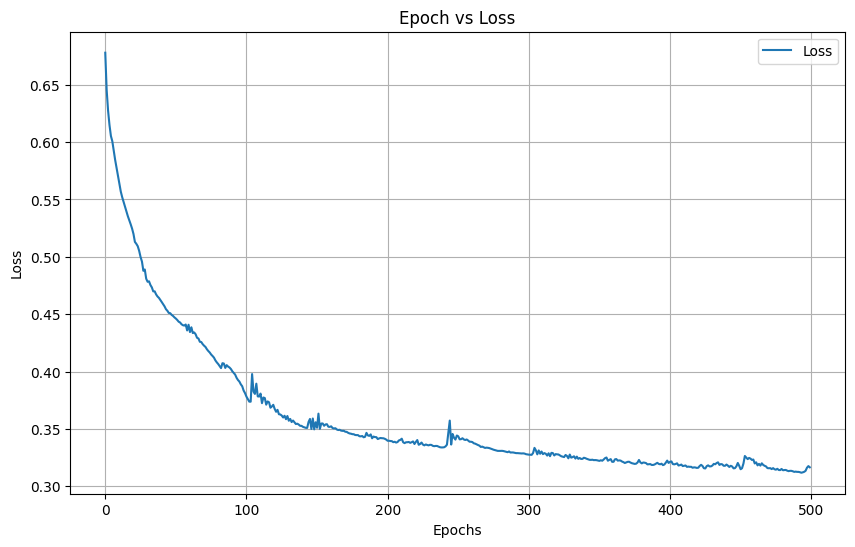

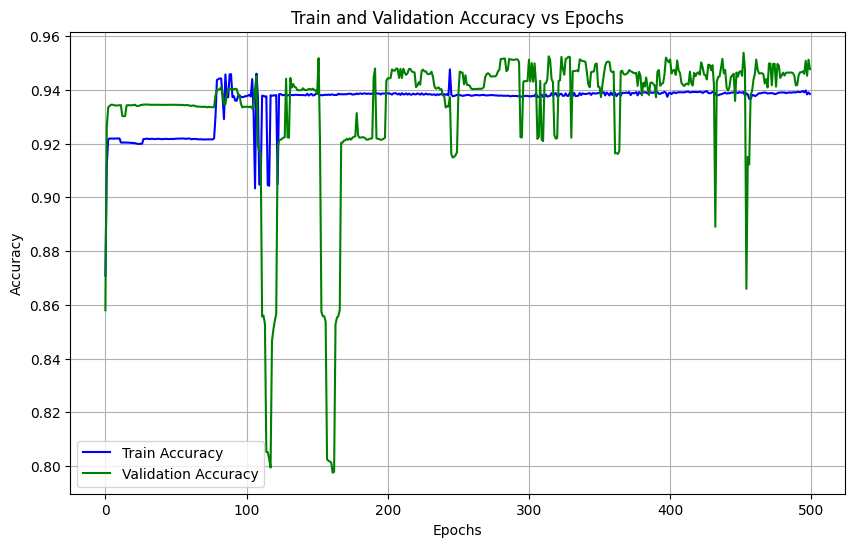

Precision: 0.6029
Recall: 0.5571
F1 Score: 0.5791


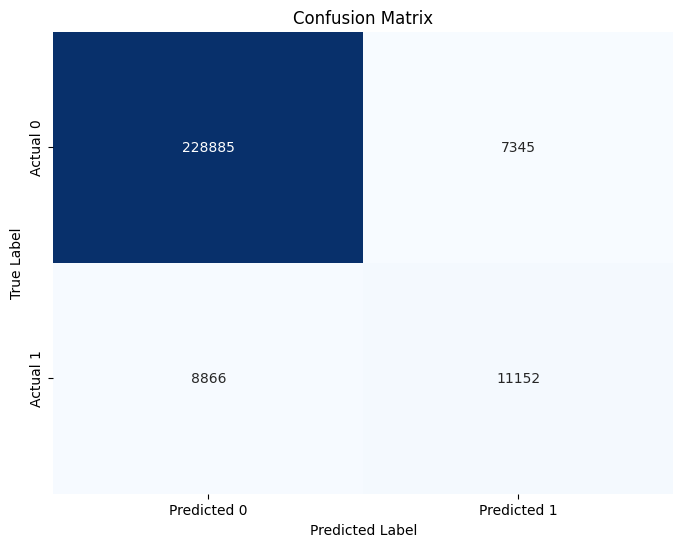

In [56]:
#GIN V 26-11
import os
import torch
import torch.nn.functional as F
import seaborn as sns
from torch_geometric.nn import GINConv
from torch_geometric.data import Data
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

# Load edge data
edge_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\2--12\extractedcolumns1.txt"
edges = np.loadtxt(edge_file, dtype=int)

# Load node features
feature_folder = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\2--12\features"
node_features_list = []

for file_name in os.listdir(feature_folder):
    if file_name.startswith("feature") and file_name.endswith(".txt"):
        file_path = os.path.join(feature_folder, file_name)
        try:
            feature_data = np.loadtxt(file_path, dtype=float)
            if feature_data.size == 0:
                print(f"Warning: {file_name} is empty. Skipping this file.")
            else:
                node_features_list.append(feature_data)
        except ValueError as e:
            print(f"Warning: Could not read {file_name}. Error: {e}")

if node_features_list:
    node_features = np.column_stack(node_features_list)
else:
    raise ValueError("No valid feature files found. Please check your input files.")

# Load labels
labels_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\2--12\node_contract_status_connected.txt"
labels = torch.tensor(np.loadtxt(labels_file, dtype=int), dtype=torch.long)

print(f"Node features shape: {node_features.shape}")
print(f"Labels shape: {labels.shape}")

# Create graph
G = nx.DiGraph()
G.add_edges_from(edges)

edge_index = torch.tensor(list(G.edges), dtype=torch.long).t().contiguous()

max_edge_index = edge_index.max()
num_nodes = node_features.shape[0]
print(f"Max edge index: {max_edge_index.item()}, Number of nodes: {num_nodes}")

if max_edge_index >= num_nodes:
    raise IndexError(f"Edge index {max_edge_index.item()} is out of bounds for number of nodes {num_nodes}.")

data = Data(x=torch.tensor(node_features, dtype=torch.float), y=labels, edge_index=edge_index)

# Define GIN model
class GIN(torch.nn.Module):
    def __init__(self):
        super(GIN, self).__init__()
        from torch_geometric.nn import MLP
        self.mlp1 = MLP([data.num_node_features, 16, 16])
        self.mlp2 = MLP([16, 16, 16])
        self.mlp3 = MLP([16, 16, 2])
        self.conv1 = GINConv(self.mlp1)
        self.conv2 = GINConv(self.mlp2)
        self.conv3 = GINConv(self.mlp3)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)
        return x

model = GIN()

# Class weights for imbalanced classes
class_counts = torch.bincount(data.y)
class_weights = 1.0 / torch.sqrt(class_counts.float() + 1e-6)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training mask
y_0_indices = (data.y == 0).nonzero(as_tuple=True)[0]
y_1_indices = (data.y == 1).nonzero(as_tuple=True)[0]
train_indices = torch.cat([y_0_indices, y_1_indices])
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[train_indices] = True

# Load new features and labels for validation
new_feature_folder = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\26-11\features"
new_labels_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\26-11\node_contract_status_connected.txt" 
new_edge_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\26-11\extractedcolumns1.txt" 

new_node_features_list = []
for file_name in os.listdir(new_feature_folder):
    if file_name.startswith("feature") and file_name.endswith(".txt"):
        file_path = os.path.join(new_feature_folder, file_name)
        try:
            feature_data = np.loadtxt(file_path, dtype=float)
            if feature_data.size == 0:
                print(f"Warning: {file_name} is empty. Skipping this file.")
            else:
                new_node_features_list.append(feature_data)
        except ValueError as e:
            print(f"Warning: Could not read {file_name}. Error: {e}")

if new_node_features_list:
    new_node_features = np.column_stack(new_node_features_list)
    new_labels = torch.tensor(np.loadtxt(new_labels_file, dtype=int), dtype=torch.long)
else:
    raise ValueError("No valid new feature files found. Please check your input files.")

new_edges = np.loadtxt(new_edge_file, dtype=int)
new_edge_index = torch.tensor(list(new_edges), dtype=torch.long).t().contiguous()

# Training and validation
validation_accuracies = []
train_accuracies = []
loss_values = []

for epoch in range(500):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[train_mask], data.y[train_mask])
    loss.backward()
    optimizer.step()

    pred_train = out.argmax(dim=1)
    train_acc = (pred_train[train_mask] == data.y[train_mask]).sum().item() / train_mask.sum().item()

    model.eval()
    with torch.no_grad():
        out_val = model(torch.tensor(new_node_features, dtype=torch.float), new_edge_index)
        pred_val = out_val.argmax(dim=1)
        val_acc = (pred_val == new_labels).sum().item() / new_labels.size(0)

    loss_values.append(loss.item())
    train_accuracies.append(train_acc)
    validation_accuracies.append(val_acc)

    if epoch % 10 == 0:
        print(f'Epoch {epoch:>3} | Loss: {loss.item():.4f} | Train Accuracy: {train_acc*100:.2f}% | Validation Accuracy: {val_acc*100:.2f}%')

# Loss and accuracy plots
plt.figure(figsize=(10, 6))
plt.plot(range(500), loss_values, label="Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Epoch vs Loss")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range(500), train_accuracies, label="Train Accuracy", color='blue')
plt.plot(range(500), validation_accuracies, label="Validation Accuracy", color='green')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train and Validation Accuracy vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

# Evaluation
model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index)
    y_pred = out.argmax(dim=1).cpu().numpy()
    y_true = data.y.cpu().numpy()

conf_matrix = confusion_matrix(y_true[train_mask], y_pred[train_mask])
precision = precision_score(y_true[train_mask], y_pred[train_mask], average='binary', zero_division=0)
recall = recall_score(y_true[train_mask], y_pred[train_mask], average='binary', zero_division=0)
f1 = f1_score(y_true[train_mask], y_pred[train_mask], average='binary', zero_division=0)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


Node features shape: (256248, 6)
Labels shape: torch.Size([256248])
Max edge index: 256247, Number of nodes: 256248
Epoch   0 | Loss: 0.6946 | Train Accuracy: 31.69% | Validation Accuracy: 93.75%
Epoch  10 | Loss: 0.5750 | Train Accuracy: 92.19% | Validation Accuracy: 93.75%
Epoch  20 | Loss: 0.5334 | Train Accuracy: 92.37% | Validation Accuracy: 81.68%
Epoch  30 | Loss: 0.5202 | Train Accuracy: 91.99% | Validation Accuracy: 81.57%
Epoch  40 | Loss: 0.5106 | Train Accuracy: 92.00% | Validation Accuracy: 81.56%
Epoch  50 | Loss: 0.5003 | Train Accuracy: 88.65% | Validation Accuracy: 81.53%
Epoch  60 | Loss: 0.4905 | Train Accuracy: 88.72% | Validation Accuracy: 81.52%
Epoch  70 | Loss: 0.4798 | Train Accuracy: 88.73% | Validation Accuracy: 81.52%
Epoch  80 | Loss: 0.4677 | Train Accuracy: 88.84% | Validation Accuracy: 81.50%
Epoch  90 | Loss: 0.4542 | Train Accuracy: 88.85% | Validation Accuracy: 81.48%
Epoch 100 | Loss: 0.4405 | Train Accuracy: 90.25% | Validation Accuracy: 81.45%
Epoc

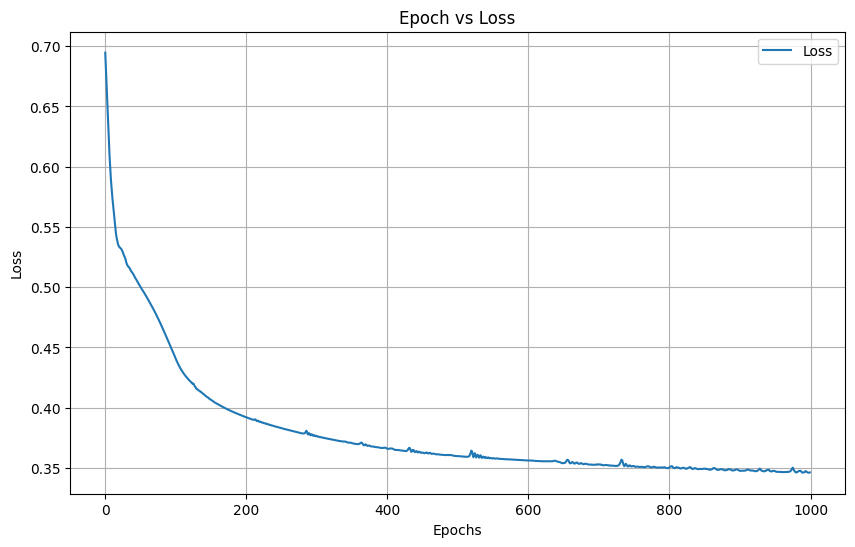

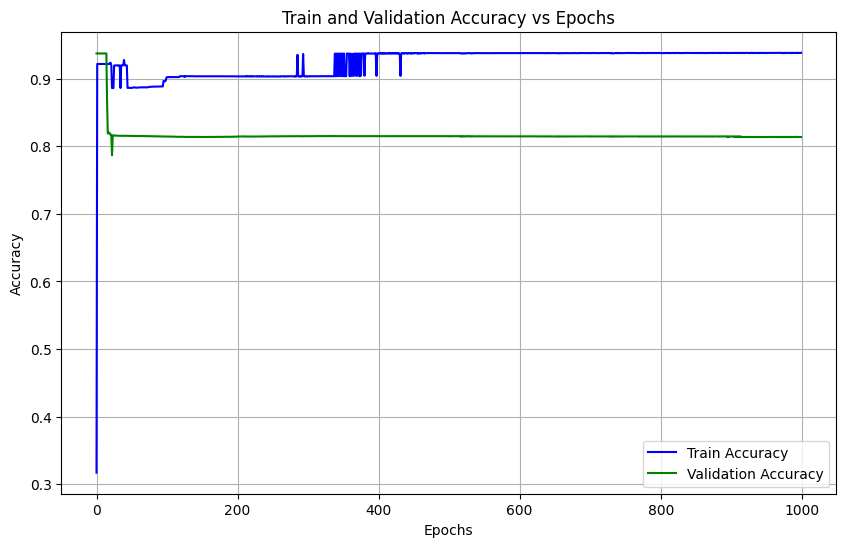

Precision: 0.6193
Recall: 0.5411
F1 Score: 0.5776


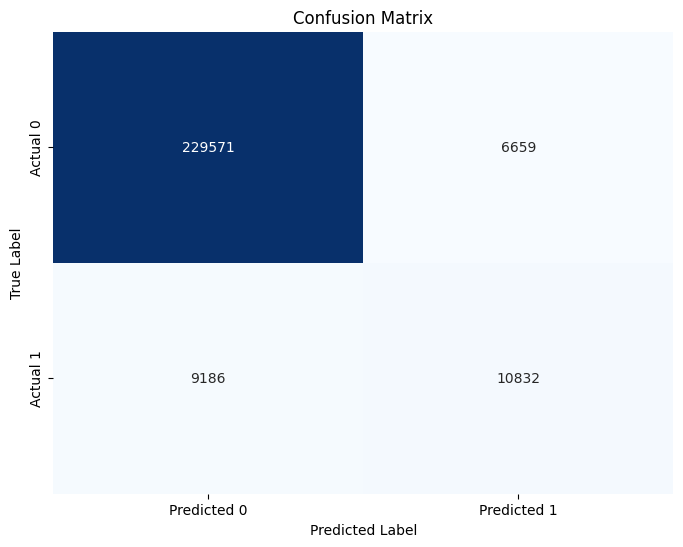

In [55]:
#GCN V 7-11
import os
import torch
import torch.nn.functional as F
import seaborn as sns
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

# Load edge data
edge_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\2--12\extractedcolumns1.txt"
edges = np.loadtxt(edge_file, dtype=int)

# Load node features
feature_folder = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\2--12\features"
node_features_list = []

for file_name in os.listdir(feature_folder):
    if file_name.startswith("feature") and file_name.endswith(".txt"):
        file_path = os.path.join(feature_folder, file_name)
        try:
            feature_data = np.loadtxt(file_path, dtype=float)
            if feature_data.size == 0:
                print(f"Warning: {file_name} is empty. Skipping this file.")
            else:
                node_features_list.append(feature_data)
        except ValueError as e:
            print(f"Warning: Could not read {file_name}. Error: {e}")

if node_features_list:
    node_features = np.column_stack(node_features_list)
else:
    raise ValueError("No valid feature files found. Please check your input files.")

# Load labels
labels_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\2--12\node_contract_status_connected.txt"
labels = torch.tensor(np.loadtxt(labels_file, dtype=int), dtype=torch.long)

print(f"Node features shape: {node_features.shape}")
print(f"Labels shape: {labels.shape}")

# Create graph
G = nx.DiGraph()
G.add_edges_from(edges)

edge_index = torch.tensor(list(G.edges), dtype=torch.long).t().contiguous()

max_edge_index = edge_index.max()
num_nodes = node_features.shape[0]
print(f"Max edge index: {max_edge_index.item()}, Number of nodes: {num_nodes}")

if max_edge_index >= num_nodes:
    raise IndexError(f"Edge index {max_edge_index.item()} is out of bounds for number of nodes {num_nodes}.")

data = Data(x=torch.tensor(node_features, dtype=torch.float), y=labels, edge_index=edge_index)

# Define GCN model
class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(data.num_node_features, 16)
        self.conv2 = GCNConv(16, 16)
        self.conv3 = GCNConv(16, 2)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)
        return x

model = GCN()

# Class weights for imbalanced classes
class_counts = torch.bincount(data.y)
class_weights = 1.0 / torch.sqrt(class_counts.float() + 1e-6)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training mask
y_0_indices = (data.y == 0).nonzero(as_tuple=True)[0]
y_1_indices = (data.y == 1).nonzero(as_tuple=True)[0]
train_indices = torch.cat([y_0_indices, y_1_indices])
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[train_indices] = True

# Load new features and labels for validation
new_feature_folder = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\7-11\features"
new_labels_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\7-11\node_contract_status_connected.txt" 
new_edge_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\7-11\extractedcolumns1.txt" 

new_node_features_list = []
for file_name in os.listdir(new_feature_folder):
    if file_name.startswith("feature") and file_name.endswith(".txt"):
        file_path = os.path.join(new_feature_folder, file_name)
        try:
            feature_data = np.loadtxt(file_path, dtype=float)
            if feature_data.size == 0:
                print(f"Warning: {file_name} is empty. Skipping this file.")
            else:
                new_node_features_list.append(feature_data)
        except ValueError as e:
            print(f"Warning: Could not read {file_name}. Error: {e}")

if new_node_features_list:
    new_node_features = np.column_stack(new_node_features_list)
    new_labels = torch.tensor(np.loadtxt(new_labels_file, dtype=int), dtype=torch.long)
else:
    raise ValueError("No valid new feature files found. Please check your input files.")

new_edges = np.loadtxt(new_edge_file, dtype=int)
new_edge_index = torch.tensor(list(new_edges), dtype=torch.long).t().contiguous()

# Training and validation
validation_accuracies = []
train_accuracies = []
loss_values = []

for epoch in range(1000):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[train_mask], data.y[train_mask])
    loss.backward()
    optimizer.step()

    pred_train = out.argmax(dim=1)
    train_acc = (pred_train[train_mask] == data.y[train_mask]).sum().item() / train_mask.sum().item()

    model.eval()
    with torch.no_grad():
        out_val = model(torch.tensor(new_node_features, dtype=torch.float), new_edge_index)
        pred_val = out_val.argmax(dim=1)
        val_acc = (pred_val == new_labels).sum().item() / new_labels.size(0)

    loss_values.append(loss.item())
    train_accuracies.append(train_acc)
    validation_accuracies.append(val_acc)

    if epoch % 10 == 0:
        print(f'Epoch {epoch:>3} | Loss: {loss.item():.4f} | Train Accuracy: {train_acc*100:.2f}% | Validation Accuracy: {val_acc*100:.2f}%')

# Loss and accuracy plots
plt.figure(figsize=(10, 6))
plt.plot(range(1000), loss_values, label="Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Epoch vs Loss")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range(1000), train_accuracies, label="Train Accuracy", color='blue')
plt.plot(range(1000), validation_accuracies, label="Validation Accuracy", color='green')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train and Validation Accuracy vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

# Evaluation
model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index)
    y_pred = out.argmax(dim=1).cpu().numpy()
    y_true = data.y.cpu().numpy()

conf_matrix = confusion_matrix(y_true[train_mask], y_pred[train_mask])
precision = precision_score(y_true[train_mask], y_pred[train_mask], average='binary', zero_division=0)
recall = recall_score(y_true[train_mask], y_pred[train_mask], average='binary', zero_division=0)
f1 = f1_score(y_true[train_mask], y_pred[train_mask], average='binary', zero_division=0)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


Node features shape: (256248, 6)
Labels shape: torch.Size([256248])
Max edge index: 256247, Number of nodes: 256248
Epoch   0 | Loss: 0.6903 | Train Accuracy: 84.57% | Validation Accuracy: 93.73%
Epoch  10 | Loss: 0.5826 | Train Accuracy: 92.19% | Validation Accuracy: 93.73%
Epoch  20 | Loss: 0.5310 | Train Accuracy: 92.37% | Validation Accuracy: 72.50%
Epoch  30 | Loss: 0.5139 | Train Accuracy: 88.69% | Validation Accuracy: 72.95%
Epoch  40 | Loss: 0.5020 | Train Accuracy: 88.73% | Validation Accuracy: 72.90%
Epoch  50 | Loss: 0.4900 | Train Accuracy: 88.79% | Validation Accuracy: 76.14%
Epoch  60 | Loss: 0.4754 | Train Accuracy: 88.78% | Validation Accuracy: 76.20%
Epoch  70 | Loss: 0.4587 | Train Accuracy: 88.86% | Validation Accuracy: 76.15%
Epoch  80 | Loss: 0.4423 | Train Accuracy: 90.37% | Validation Accuracy: 76.10%
Epoch  90 | Loss: 0.4289 | Train Accuracy: 90.42% | Validation Accuracy: 76.08%
Epoch 100 | Loss: 0.4176 | Train Accuracy: 90.43% | Validation Accuracy: 76.08%
Epoc

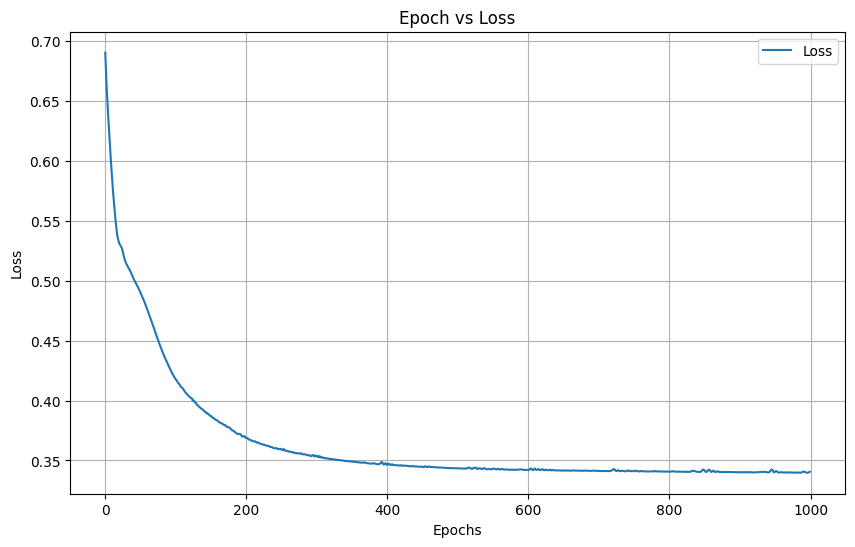

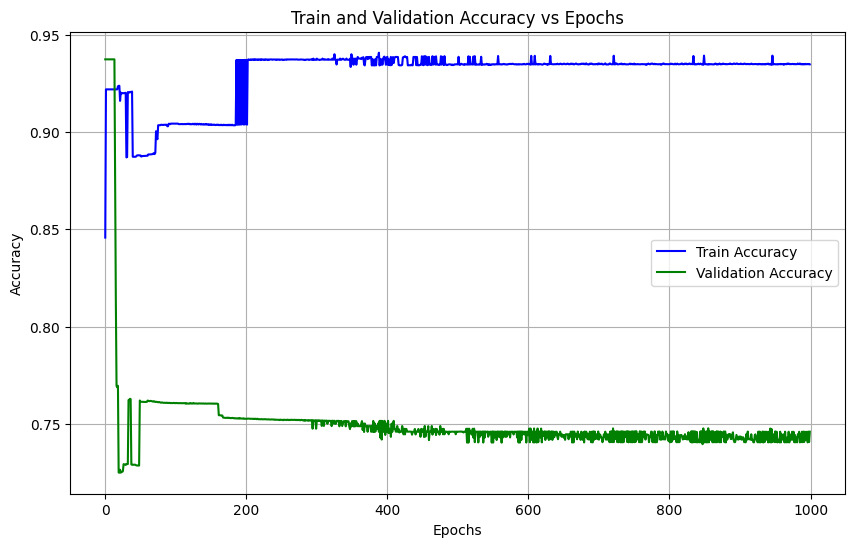

Precision: 0.5864
Recall: 0.5746
F1 Score: 0.5805


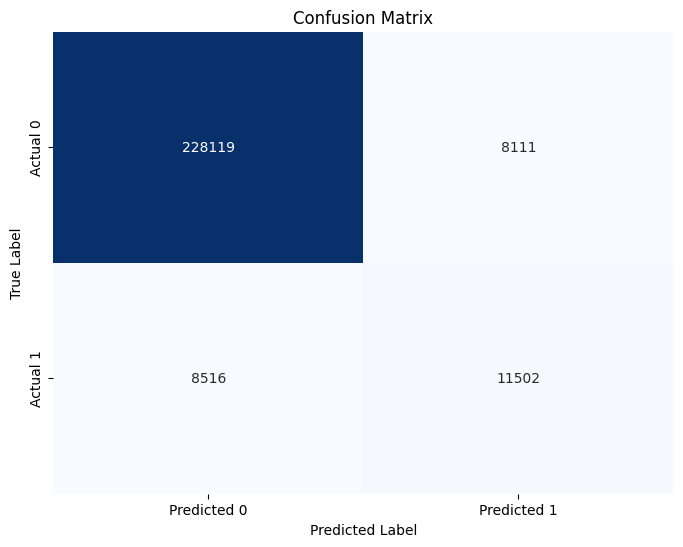

In [54]:
#GCN V 8-11
import os
import torch
import torch.nn.functional as F
import seaborn as sns
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

# Load edge data
edge_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\2--12\extractedcolumns1.txt"
edges = np.loadtxt(edge_file, dtype=int)

# Load node features
feature_folder = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\2--12\features"
node_features_list = []

for file_name in os.listdir(feature_folder):
    if file_name.startswith("feature") and file_name.endswith(".txt"):
        file_path = os.path.join(feature_folder, file_name)
        try:
            feature_data = np.loadtxt(file_path, dtype=float)
            if feature_data.size == 0:
                print(f"Warning: {file_name} is empty. Skipping this file.")
            else:
                node_features_list.append(feature_data)
        except ValueError as e:
            print(f"Warning: Could not read {file_name}. Error: {e}")

if node_features_list:
    node_features = np.column_stack(node_features_list)
else:
    raise ValueError("No valid feature files found. Please check your input files.")

# Load labels
labels_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\2--12\node_contract_status_connected.txt"
labels = torch.tensor(np.loadtxt(labels_file, dtype=int), dtype=torch.long)

print(f"Node features shape: {node_features.shape}")
print(f"Labels shape: {labels.shape}")

# Create graph
G = nx.DiGraph()
G.add_edges_from(edges)

edge_index = torch.tensor(list(G.edges), dtype=torch.long).t().contiguous()

max_edge_index = edge_index.max()
num_nodes = node_features.shape[0]
print(f"Max edge index: {max_edge_index.item()}, Number of nodes: {num_nodes}")

if max_edge_index >= num_nodes:
    raise IndexError(f"Edge index {max_edge_index.item()} is out of bounds for number of nodes {num_nodes}.")

data = Data(x=torch.tensor(node_features, dtype=torch.float), y=labels, edge_index=edge_index)

# Define GCN model
class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(data.num_node_features, 16)
        self.conv2 = GCNConv(16, 16)
        self.conv3 = GCNConv(16, 2)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)
        return x

model = GCN()

# Class weights for imbalanced classes
class_counts = torch.bincount(data.y)
class_weights = 1.0 / torch.sqrt(class_counts.float() + 1e-6)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training mask
y_0_indices = (data.y == 0).nonzero(as_tuple=True)[0]
y_1_indices = (data.y == 1).nonzero(as_tuple=True)[0]
train_indices = torch.cat([y_0_indices, y_1_indices])
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[train_indices] = True

# Load new features and labels for validation
new_feature_folder = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\8-11\features"
new_labels_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\8-11\node_contract_status_connected.txt" 
new_edge_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\8-11\extractedcolumns1.txt" 

new_node_features_list = []
for file_name in os.listdir(new_feature_folder):
    if file_name.startswith("feature") and file_name.endswith(".txt"):
        file_path = os.path.join(new_feature_folder, file_name)
        try:
            feature_data = np.loadtxt(file_path, dtype=float)
            if feature_data.size == 0:
                print(f"Warning: {file_name} is empty. Skipping this file.")
            else:
                new_node_features_list.append(feature_data)
        except ValueError as e:
            print(f"Warning: Could not read {file_name}. Error: {e}")

if new_node_features_list:
    new_node_features = np.column_stack(new_node_features_list)
    new_labels = torch.tensor(np.loadtxt(new_labels_file, dtype=int), dtype=torch.long)
else:
    raise ValueError("No valid new feature files found. Please check your input files.")

new_edges = np.loadtxt(new_edge_file, dtype=int)
new_edge_index = torch.tensor(list(new_edges), dtype=torch.long).t().contiguous()

# Training and validation
validation_accuracies = []
train_accuracies = []
loss_values = []

for epoch in range(1000):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[train_mask], data.y[train_mask])
    loss.backward()
    optimizer.step()

    pred_train = out.argmax(dim=1)
    train_acc = (pred_train[train_mask] == data.y[train_mask]).sum().item() / train_mask.sum().item()

    model.eval()
    with torch.no_grad():
        out_val = model(torch.tensor(new_node_features, dtype=torch.float), new_edge_index)
        pred_val = out_val.argmax(dim=1)
        val_acc = (pred_val == new_labels).sum().item() / new_labels.size(0)

    loss_values.append(loss.item())
    train_accuracies.append(train_acc)
    validation_accuracies.append(val_acc)

    if epoch % 10 == 0:
        print(f'Epoch {epoch:>3} | Loss: {loss.item():.4f} | Train Accuracy: {train_acc*100:.2f}% | Validation Accuracy: {val_acc*100:.2f}%')

# Loss and accuracy plots
plt.figure(figsize=(10, 6))
plt.plot(range(1000), loss_values, label="Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Epoch vs Loss")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range(1000), train_accuracies, label="Train Accuracy", color='blue')
plt.plot(range(1000), validation_accuracies, label="Validation Accuracy", color='green')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train and Validation Accuracy vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

# Evaluation
model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index)
    y_pred = out.argmax(dim=1).cpu().numpy()
    y_true = data.y.cpu().numpy()

conf_matrix = confusion_matrix(y_true[train_mask], y_pred[train_mask])
precision = precision_score(y_true[train_mask], y_pred[train_mask], average='binary', zero_division=0)
recall = recall_score(y_true[train_mask], y_pred[train_mask], average='binary', zero_division=0)
f1 = f1_score(y_true[train_mask], y_pred[train_mask], average='binary', zero_division=0)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


Node features shape: (256248, 6)
Labels shape: torch.Size([256248])
Max edge index: 256247, Number of nodes: 256248
Epoch   0 | Loss: 0.6926 | Train Accuracy: 66.07% | Validation Accuracy: 91.96%
Epoch  10 | Loss: 0.5768 | Train Accuracy: 92.19% | Validation Accuracy: 92.43%
Epoch  20 | Loss: 0.5337 | Train Accuracy: 91.49% | Validation Accuracy: 71.68%
Epoch  30 | Loss: 0.5213 | Train Accuracy: 91.97% | Validation Accuracy: 71.63%
Epoch  40 | Loss: 0.5124 | Train Accuracy: 91.94% | Validation Accuracy: 71.65%
Epoch  50 | Loss: 0.5032 | Train Accuracy: 88.66% | Validation Accuracy: 71.63%
Epoch  60 | Loss: 0.4944 | Train Accuracy: 88.64% | Validation Accuracy: 71.60%
Epoch  70 | Loss: 0.4848 | Train Accuracy: 88.67% | Validation Accuracy: 71.58%
Epoch  80 | Loss: 0.4747 | Train Accuracy: 88.72% | Validation Accuracy: 71.55%
Epoch  90 | Loss: 0.4642 | Train Accuracy: 88.76% | Validation Accuracy: 71.42%
Epoch 100 | Loss: 0.4532 | Train Accuracy: 88.80% | Validation Accuracy: 71.40%
Epoc

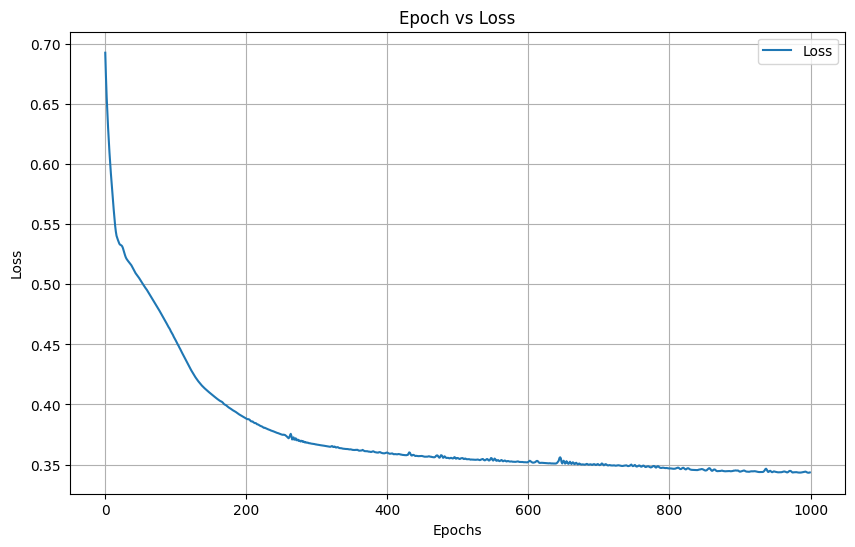

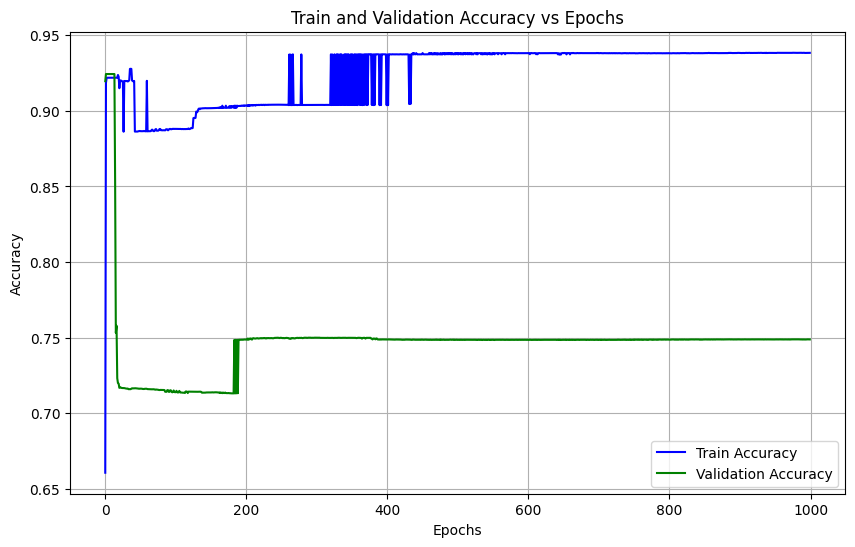

Precision: 0.6222
Recall: 0.5377
F1 Score: 0.5769


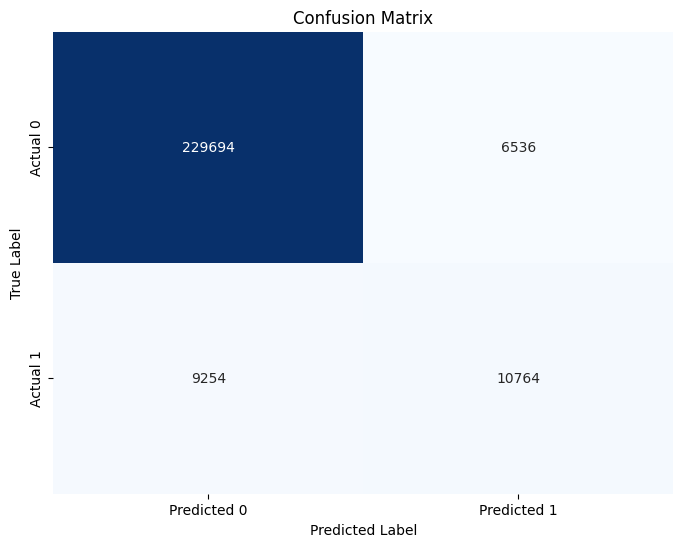

In [53]:
#GCN V 12-11
import os
import torch
import torch.nn.functional as F
import seaborn as sns
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

# Load edge data
edge_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\2--12\extractedcolumns1.txt"
edges = np.loadtxt(edge_file, dtype=int)

# Load node features
feature_folder = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\2--12\features"
node_features_list = []

for file_name in os.listdir(feature_folder):
    if file_name.startswith("feature") and file_name.endswith(".txt"):
        file_path = os.path.join(feature_folder, file_name)
        try:
            feature_data = np.loadtxt(file_path, dtype=float)
            if feature_data.size == 0:
                print(f"Warning: {file_name} is empty. Skipping this file.")
            else:
                node_features_list.append(feature_data)
        except ValueError as e:
            print(f"Warning: Could not read {file_name}. Error: {e}")

if node_features_list:
    node_features = np.column_stack(node_features_list)
else:
    raise ValueError("No valid feature files found. Please check your input files.")

# Load labels
labels_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\2--12\node_contract_status_connected.txt"
labels = torch.tensor(np.loadtxt(labels_file, dtype=int), dtype=torch.long)

print(f"Node features shape: {node_features.shape}")
print(f"Labels shape: {labels.shape}")

# Create graph
G = nx.DiGraph()
G.add_edges_from(edges)

edge_index = torch.tensor(list(G.edges), dtype=torch.long).t().contiguous()

max_edge_index = edge_index.max()
num_nodes = node_features.shape[0]
print(f"Max edge index: {max_edge_index.item()}, Number of nodes: {num_nodes}")

if max_edge_index >= num_nodes:
    raise IndexError(f"Edge index {max_edge_index.item()} is out of bounds for number of nodes {num_nodes}.")

data = Data(x=torch.tensor(node_features, dtype=torch.float), y=labels, edge_index=edge_index)

# Define GCN model
class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(data.num_node_features, 16)
        self.conv2 = GCNConv(16, 16)
        self.conv3 = GCNConv(16, 2)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)
        return x

model = GCN()

# Class weights for imbalanced classes
class_counts = torch.bincount(data.y)
class_weights = 1.0 / torch.sqrt(class_counts.float() + 1e-6)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training mask
y_0_indices = (data.y == 0).nonzero(as_tuple=True)[0]
y_1_indices = (data.y == 1).nonzero(as_tuple=True)[0]
train_indices = torch.cat([y_0_indices, y_1_indices])
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[train_indices] = True

# Load new features and labels for validation
new_feature_folder = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\12-11\features"
new_labels_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\12-11\node_contract_status_connected.txt" 
new_edge_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\12-11\extractedcolumns1.txt" 

new_node_features_list = []
for file_name in os.listdir(new_feature_folder):
    if file_name.startswith("feature") and file_name.endswith(".txt"):
        file_path = os.path.join(new_feature_folder, file_name)
        try:
            feature_data = np.loadtxt(file_path, dtype=float)
            if feature_data.size == 0:
                print(f"Warning: {file_name} is empty. Skipping this file.")
            else:
                new_node_features_list.append(feature_data)
        except ValueError as e:
            print(f"Warning: Could not read {file_name}. Error: {e}")

if new_node_features_list:
    new_node_features = np.column_stack(new_node_features_list)
    new_labels = torch.tensor(np.loadtxt(new_labels_file, dtype=int), dtype=torch.long)
else:
    raise ValueError("No valid new feature files found. Please check your input files.")

new_edges = np.loadtxt(new_edge_file, dtype=int)
new_edge_index = torch.tensor(list(new_edges), dtype=torch.long).t().contiguous()

# Training and validation
validation_accuracies = []
train_accuracies = []
loss_values = []

for epoch in range(1000):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[train_mask], data.y[train_mask])
    loss.backward()
    optimizer.step()

    pred_train = out.argmax(dim=1)
    train_acc = (pred_train[train_mask] == data.y[train_mask]).sum().item() / train_mask.sum().item()

    model.eval()
    with torch.no_grad():
        out_val = model(torch.tensor(new_node_features, dtype=torch.float), new_edge_index)
        pred_val = out_val.argmax(dim=1)
        val_acc = (pred_val == new_labels).sum().item() / new_labels.size(0)

    loss_values.append(loss.item())
    train_accuracies.append(train_acc)
    validation_accuracies.append(val_acc)

    if epoch % 10 == 0:
        print(f'Epoch {epoch:>3} | Loss: {loss.item():.4f} | Train Accuracy: {train_acc*100:.2f}% | Validation Accuracy: {val_acc*100:.2f}%')

# Loss and accuracy plots
plt.figure(figsize=(10, 6))
plt.plot(range(1000), loss_values, label="Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Epoch vs Loss")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range(1000), train_accuracies, label="Train Accuracy", color='blue')
plt.plot(range(1000), validation_accuracies, label="Validation Accuracy", color='green')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train and Validation Accuracy vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

# Evaluation
model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index)
    y_pred = out.argmax(dim=1).cpu().numpy()
    y_true = data.y.cpu().numpy()

conf_matrix = confusion_matrix(y_true[train_mask], y_pred[train_mask])
precision = precision_score(y_true[train_mask], y_pred[train_mask], average='binary', zero_division=0)
recall = recall_score(y_true[train_mask], y_pred[train_mask], average='binary', zero_division=0)
f1 = f1_score(y_true[train_mask], y_pred[train_mask], average='binary', zero_division=0)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


Node features shape: (256248, 6)
Labels shape: torch.Size([256248])
Max edge index: 256247, Number of nodes: 256248
Epoch   0 | Loss: 0.6900 | Train Accuracy: 92.19% | Validation Accuracy: 93.00%
Epoch  10 | Loss: 0.5793 | Train Accuracy: 92.19% | Validation Accuracy: 93.00%
Epoch  20 | Loss: 0.5483 | Train Accuracy: 92.19% | Validation Accuracy: 93.00%
Epoch  30 | Loss: 0.5348 | Train Accuracy: 92.19% | Validation Accuracy: 76.73%
Epoch  40 | Loss: 0.5231 | Train Accuracy: 92.37% | Validation Accuracy: 77.15%
Epoch  50 | Loss: 0.5146 | Train Accuracy: 91.94% | Validation Accuracy: 73.76%
Epoch  60 | Loss: 0.5059 | Train Accuracy: 91.94% | Validation Accuracy: 73.72%
Epoch  70 | Loss: 0.4944 | Train Accuracy: 91.96% | Validation Accuracy: 73.70%
Epoch  80 | Loss: 0.4784 | Train Accuracy: 92.01% | Validation Accuracy: 73.63%
Epoch  90 | Loss: 0.4586 | Train Accuracy: 88.79% | Validation Accuracy: 73.59%
Epoch 100 | Loss: 0.4404 | Train Accuracy: 90.12% | Validation Accuracy: 73.57%
Epoc

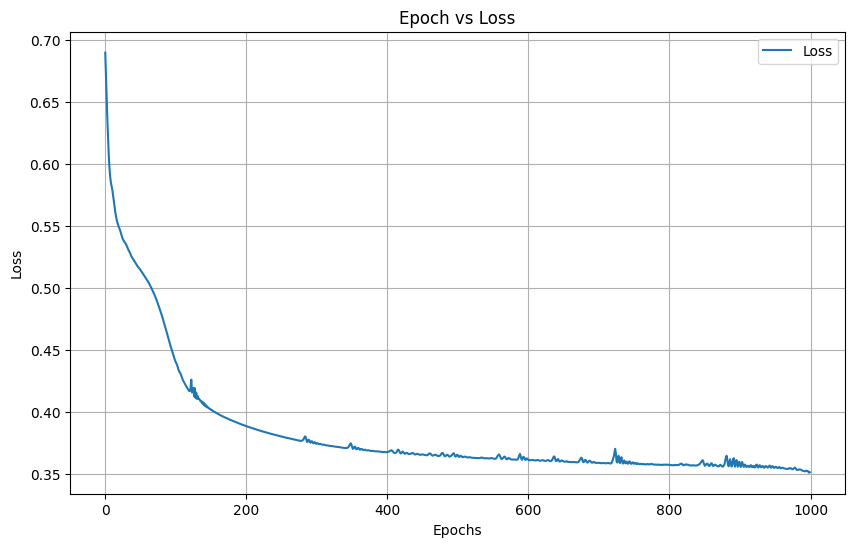

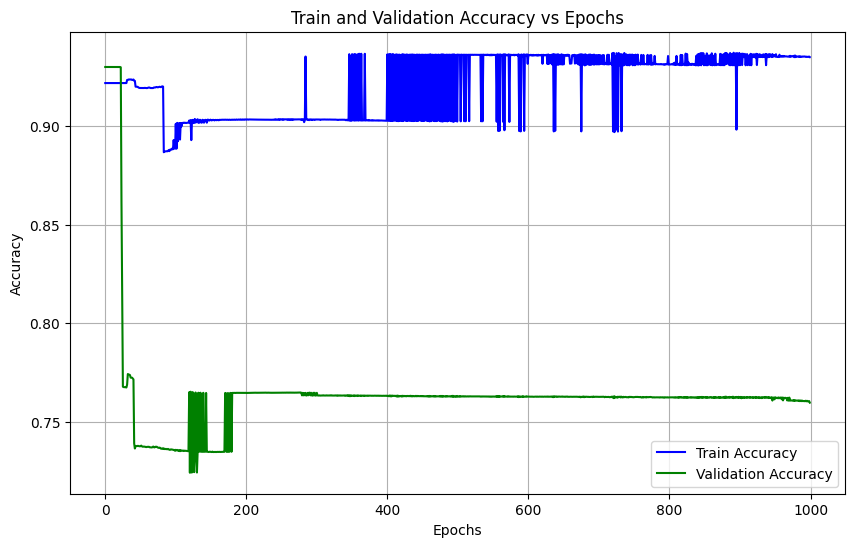

Precision: 0.5925
Recall: 0.5359
F1 Score: 0.5627


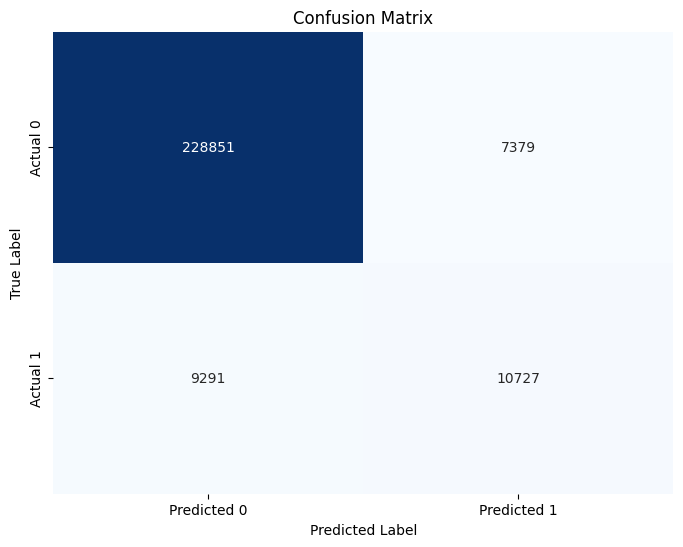

In [52]:
#GCN V 13-11
import os
import torch
import torch.nn.functional as F
import seaborn as sns
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

# Load edge data
edge_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\2--12\extractedcolumns1.txt"
edges = np.loadtxt(edge_file, dtype=int)

# Load node features
feature_folder = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\2--12\features"
node_features_list = []

for file_name in os.listdir(feature_folder):
    if file_name.startswith("feature") and file_name.endswith(".txt"):
        file_path = os.path.join(feature_folder, file_name)
        try:
            feature_data = np.loadtxt(file_path, dtype=float)
            if feature_data.size == 0:
                print(f"Warning: {file_name} is empty. Skipping this file.")
            else:
                node_features_list.append(feature_data)
        except ValueError as e:
            print(f"Warning: Could not read {file_name}. Error: {e}")

if node_features_list:
    node_features = np.column_stack(node_features_list)
else:
    raise ValueError("No valid feature files found. Please check your input files.")

# Load labels
labels_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\2--12\node_contract_status_connected.txt"
labels = torch.tensor(np.loadtxt(labels_file, dtype=int), dtype=torch.long)

print(f"Node features shape: {node_features.shape}")
print(f"Labels shape: {labels.shape}")

# Create graph
G = nx.DiGraph()
G.add_edges_from(edges)

edge_index = torch.tensor(list(G.edges), dtype=torch.long).t().contiguous()

max_edge_index = edge_index.max()
num_nodes = node_features.shape[0]
print(f"Max edge index: {max_edge_index.item()}, Number of nodes: {num_nodes}")

if max_edge_index >= num_nodes:
    raise IndexError(f"Edge index {max_edge_index.item()} is out of bounds for number of nodes {num_nodes}.")

data = Data(x=torch.tensor(node_features, dtype=torch.float), y=labels, edge_index=edge_index)

# Define GCN model
class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(data.num_node_features, 16)
        self.conv2 = GCNConv(16, 16)
        self.conv3 = GCNConv(16, 2)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)
        return x

model = GCN()

# Class weights for imbalanced classes
class_counts = torch.bincount(data.y)
class_weights = 1.0 / torch.sqrt(class_counts.float() + 1e-6)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training mask
y_0_indices = (data.y == 0).nonzero(as_tuple=True)[0]
y_1_indices = (data.y == 1).nonzero(as_tuple=True)[0]
train_indices = torch.cat([y_0_indices, y_1_indices])
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[train_indices] = True

# Load new features and labels for validation
new_feature_folder = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\13-11\features"
new_labels_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\13-11\node_contract_status_connected.txt" 
new_edge_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\13-11\extractedcolumns1.txt" 

new_node_features_list = []
for file_name in os.listdir(new_feature_folder):
    if file_name.startswith("feature") and file_name.endswith(".txt"):
        file_path = os.path.join(new_feature_folder, file_name)
        try:
            feature_data = np.loadtxt(file_path, dtype=float)
            if feature_data.size == 0:
                print(f"Warning: {file_name} is empty. Skipping this file.")
            else:
                new_node_features_list.append(feature_data)
        except ValueError as e:
            print(f"Warning: Could not read {file_name}. Error: {e}")

if new_node_features_list:
    new_node_features = np.column_stack(new_node_features_list)
    new_labels = torch.tensor(np.loadtxt(new_labels_file, dtype=int), dtype=torch.long)
else:
    raise ValueError("No valid new feature files found. Please check your input files.")

new_edges = np.loadtxt(new_edge_file, dtype=int)
new_edge_index = torch.tensor(list(new_edges), dtype=torch.long).t().contiguous()

# Training and validation
validation_accuracies = []
train_accuracies = []
loss_values = []

for epoch in range(1000):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[train_mask], data.y[train_mask])
    loss.backward()
    optimizer.step()

    pred_train = out.argmax(dim=1)
    train_acc = (pred_train[train_mask] == data.y[train_mask]).sum().item() / train_mask.sum().item()

    model.eval()
    with torch.no_grad():
        out_val = model(torch.tensor(new_node_features, dtype=torch.float), new_edge_index)
        pred_val = out_val.argmax(dim=1)
        val_acc = (pred_val == new_labels).sum().item() / new_labels.size(0)

    loss_values.append(loss.item())
    train_accuracies.append(train_acc)
    validation_accuracies.append(val_acc)

    if epoch % 10 == 0:
        print(f'Epoch {epoch:>3} | Loss: {loss.item():.4f} | Train Accuracy: {train_acc*100:.2f}% | Validation Accuracy: {val_acc*100:.2f}%')

# Loss and accuracy plots
plt.figure(figsize=(10, 6))
plt.plot(range(1000), loss_values, label="Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Epoch vs Loss")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range(1000), train_accuracies, label="Train Accuracy", color='blue')
plt.plot(range(1000), validation_accuracies, label="Validation Accuracy", color='green')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train and Validation Accuracy vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

# Evaluation
model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index)
    y_pred = out.argmax(dim=1).cpu().numpy()
    y_true = data.y.cpu().numpy()

conf_matrix = confusion_matrix(y_true[train_mask], y_pred[train_mask])
precision = precision_score(y_true[train_mask], y_pred[train_mask], average='binary', zero_division=0)
recall = recall_score(y_true[train_mask], y_pred[train_mask], average='binary', zero_division=0)
f1 = f1_score(y_true[train_mask], y_pred[train_mask], average='binary', zero_division=0)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


Node features shape: (256248, 6)
Labels shape: torch.Size([256248])
Max edge index: 256247, Number of nodes: 256248
Epoch   0 | Loss: 0.7058 | Train Accuracy: 7.81% | Validation Accuracy: 70.20%
Epoch  10 | Loss: 0.5772 | Train Accuracy: 92.19% | Validation Accuracy: 92.34%
Epoch  20 | Loss: 0.5407 | Train Accuracy: 92.19% | Validation Accuracy: 76.21%
Epoch  30 | Loss: 0.5312 | Train Accuracy: 91.46% | Validation Accuracy: 75.52%
Epoch  40 | Loss: 0.5198 | Train Accuracy: 92.29% | Validation Accuracy: 75.76%
Epoch  50 | Loss: 0.5086 | Train Accuracy: 92.00% | Validation Accuracy: 75.32%
Epoch  60 | Loss: 0.4953 | Train Accuracy: 88.62% | Validation Accuracy: 75.19%
Epoch  70 | Loss: 0.4843 | Train Accuracy: 88.74% | Validation Accuracy: 74.87%
Epoch  80 | Loss: 0.4738 | Train Accuracy: 88.78% | Validation Accuracy: 74.87%
Epoch  90 | Loss: 0.4635 | Train Accuracy: 88.83% | Validation Accuracy: 74.80%
Epoch 100 | Loss: 0.4529 | Train Accuracy: 88.91% | Validation Accuracy: 74.76%
Epoch

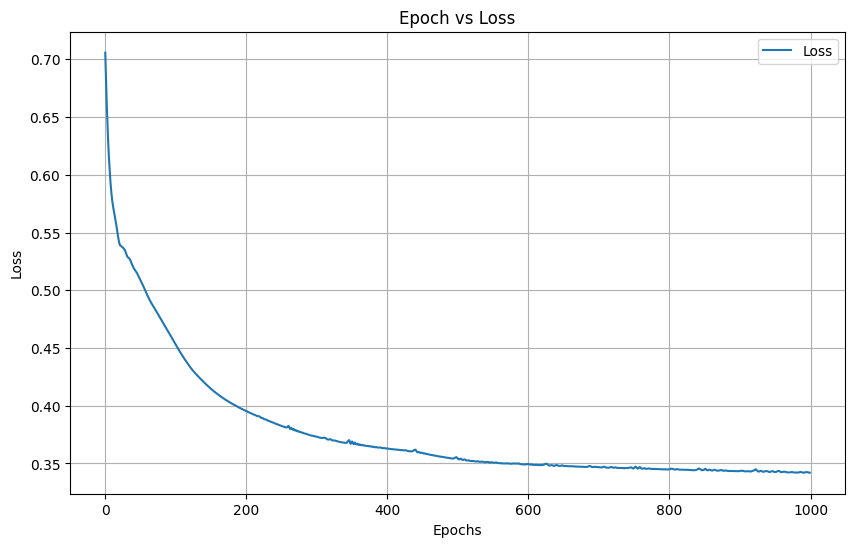

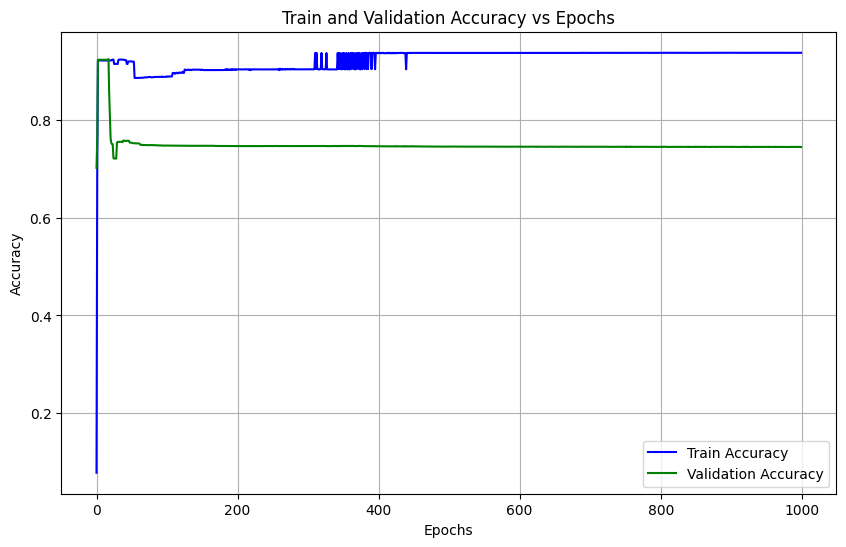

Precision: 0.6118
Recall: 0.5456
F1 Score: 0.5768


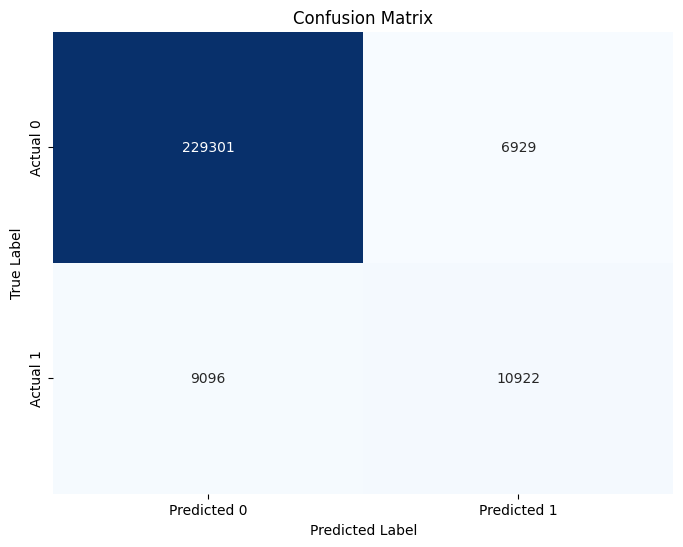

In [51]:
#GCN V 14-11
import os
import torch
import torch.nn.functional as F
import seaborn as sns
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

# Load edge data
edge_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\2--12\extractedcolumns1.txt"
edges = np.loadtxt(edge_file, dtype=int)

# Load node features
feature_folder = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\2--12\features"
node_features_list = []

for file_name in os.listdir(feature_folder):
    if file_name.startswith("feature") and file_name.endswith(".txt"):
        file_path = os.path.join(feature_folder, file_name)
        try:
            feature_data = np.loadtxt(file_path, dtype=float)
            if feature_data.size == 0:
                print(f"Warning: {file_name} is empty. Skipping this file.")
            else:
                node_features_list.append(feature_data)
        except ValueError as e:
            print(f"Warning: Could not read {file_name}. Error: {e}")

if node_features_list:
    node_features = np.column_stack(node_features_list)
else:
    raise ValueError("No valid feature files found. Please check your input files.")

# Load labels
labels_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\2--12\node_contract_status_connected.txt"
labels = torch.tensor(np.loadtxt(labels_file, dtype=int), dtype=torch.long)

print(f"Node features shape: {node_features.shape}")
print(f"Labels shape: {labels.shape}")

# Create graph
G = nx.DiGraph()
G.add_edges_from(edges)

edge_index = torch.tensor(list(G.edges), dtype=torch.long).t().contiguous()

max_edge_index = edge_index.max()
num_nodes = node_features.shape[0]
print(f"Max edge index: {max_edge_index.item()}, Number of nodes: {num_nodes}")

if max_edge_index >= num_nodes:
    raise IndexError(f"Edge index {max_edge_index.item()} is out of bounds for number of nodes {num_nodes}.")

data = Data(x=torch.tensor(node_features, dtype=torch.float), y=labels, edge_index=edge_index)

# Define GCN model
class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(data.num_node_features, 16)
        self.conv2 = GCNConv(16, 16)
        self.conv3 = GCNConv(16, 2)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)
        return x

model = GCN()

# Class weights for imbalanced classes
class_counts = torch.bincount(data.y)
class_weights = 1.0 / torch.sqrt(class_counts.float() + 1e-6)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training mask
y_0_indices = (data.y == 0).nonzero(as_tuple=True)[0]
y_1_indices = (data.y == 1).nonzero(as_tuple=True)[0]
train_indices = torch.cat([y_0_indices, y_1_indices])
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[train_indices] = True

# Load new features and labels for validation
new_feature_folder = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\14-11\features"
new_labels_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\14-11\node_contract_status_connected.txt" 
new_edge_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\14-11\extractedcolumns1.txt" 

new_node_features_list = []
for file_name in os.listdir(new_feature_folder):
    if file_name.startswith("feature") and file_name.endswith(".txt"):
        file_path = os.path.join(new_feature_folder, file_name)
        try:
            feature_data = np.loadtxt(file_path, dtype=float)
            if feature_data.size == 0:
                print(f"Warning: {file_name} is empty. Skipping this file.")
            else:
                new_node_features_list.append(feature_data)
        except ValueError as e:
            print(f"Warning: Could not read {file_name}. Error: {e}")

if new_node_features_list:
    new_node_features = np.column_stack(new_node_features_list)
    new_labels = torch.tensor(np.loadtxt(new_labels_file, dtype=int), dtype=torch.long)
else:
    raise ValueError("No valid new feature files found. Please check your input files.")

new_edges = np.loadtxt(new_edge_file, dtype=int)
new_edge_index = torch.tensor(list(new_edges), dtype=torch.long).t().contiguous()

# Training and validation
validation_accuracies = []
train_accuracies = []
loss_values = []

for epoch in range(1000):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[train_mask], data.y[train_mask])
    loss.backward()
    optimizer.step()

    pred_train = out.argmax(dim=1)
    train_acc = (pred_train[train_mask] == data.y[train_mask]).sum().item() / train_mask.sum().item()

    model.eval()
    with torch.no_grad():
        out_val = model(torch.tensor(new_node_features, dtype=torch.float), new_edge_index)
        pred_val = out_val.argmax(dim=1)
        val_acc = (pred_val == new_labels).sum().item() / new_labels.size(0)

    loss_values.append(loss.item())
    train_accuracies.append(train_acc)
    validation_accuracies.append(val_acc)

    if epoch % 10 == 0:
        print(f'Epoch {epoch:>3} | Loss: {loss.item():.4f} | Train Accuracy: {train_acc*100:.2f}% | Validation Accuracy: {val_acc*100:.2f}%')

# Loss and accuracy plots
plt.figure(figsize=(10, 6))
plt.plot(range(1000), loss_values, label="Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Epoch vs Loss")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range(1000), train_accuracies, label="Train Accuracy", color='blue')
plt.plot(range(1000), validation_accuracies, label="Validation Accuracy", color='green')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train and Validation Accuracy vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

# Evaluation
model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index)
    y_pred = out.argmax(dim=1).cpu().numpy()
    y_true = data.y.cpu().numpy()

conf_matrix = confusion_matrix(y_true[train_mask], y_pred[train_mask])
precision = precision_score(y_true[train_mask], y_pred[train_mask], average='binary', zero_division=0)
recall = recall_score(y_true[train_mask], y_pred[train_mask], average='binary', zero_division=0)
f1 = f1_score(y_true[train_mask], y_pred[train_mask], average='binary', zero_division=0)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


Node features shape: (256248, 6)
Labels shape: torch.Size([256248])
Max edge index: 256247, Number of nodes: 256248
Epoch   0 | Loss: 0.6964 | Train Accuracy: 46.07% | Validation Accuracy: 93.47%
Epoch  10 | Loss: 0.5700 | Train Accuracy: 92.19% | Validation Accuracy: 93.51%
Epoch  20 | Loss: 0.5418 | Train Accuracy: 92.19% | Validation Accuracy: 93.51%
Epoch  30 | Loss: 0.5300 | Train Accuracy: 92.35% | Validation Accuracy: 83.86%
Epoch  40 | Loss: 0.5155 | Train Accuracy: 92.30% | Validation Accuracy: 83.80%
Epoch  50 | Loss: 0.5012 | Train Accuracy: 88.65% | Validation Accuracy: 83.52%
Epoch  60 | Loss: 0.4867 | Train Accuracy: 88.71% | Validation Accuracy: 83.48%
Epoch  70 | Loss: 0.4672 | Train Accuracy: 88.85% | Validation Accuracy: 83.46%
Epoch  80 | Loss: 0.4480 | Train Accuracy: 90.09% | Validation Accuracy: 83.45%
Epoch  90 | Loss: 0.4340 | Train Accuracy: 90.38% | Validation Accuracy: 83.44%
Epoch 100 | Loss: 0.4269 | Train Accuracy: 90.42% | Validation Accuracy: 83.43%
Epoc

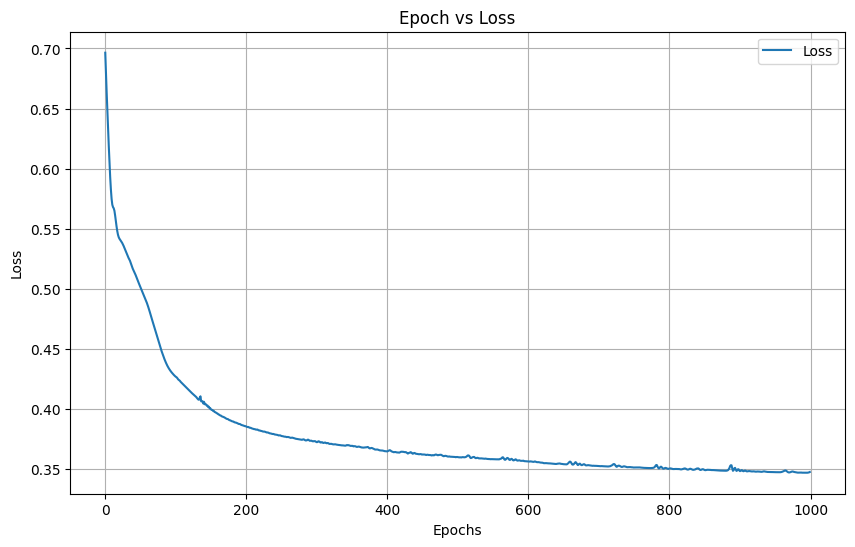

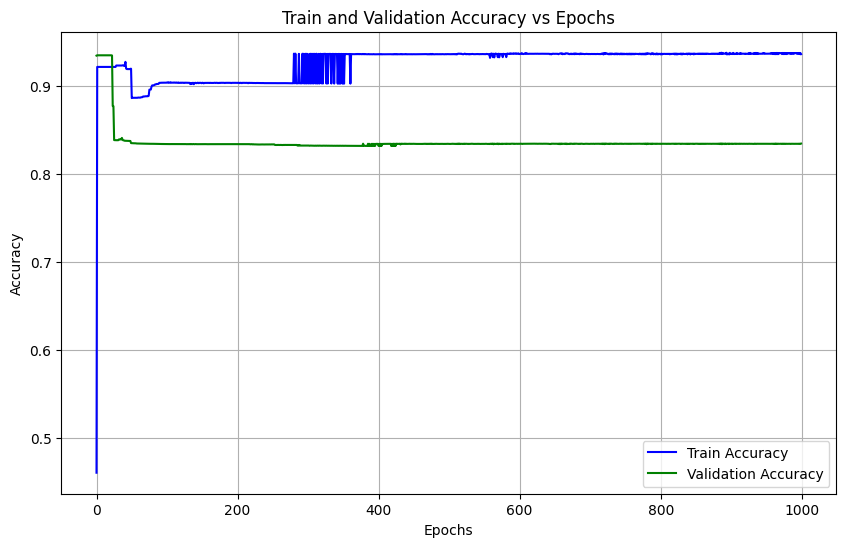

Precision: 0.6185
Recall: 0.5247
F1 Score: 0.5677


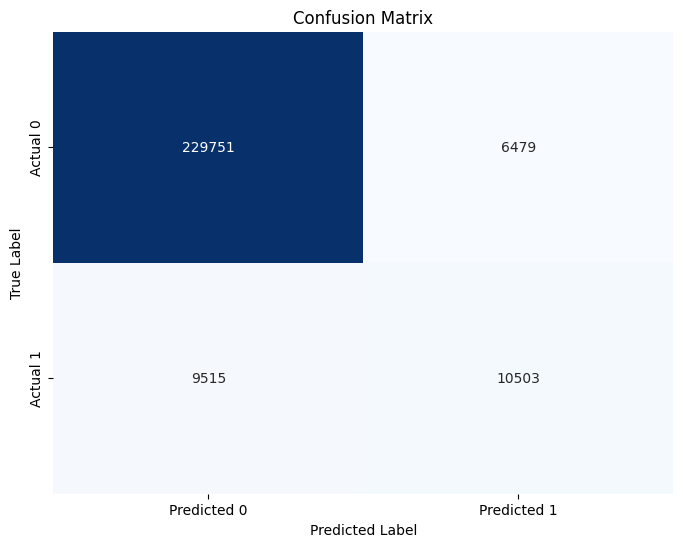

In [50]:
#GCN V 24-11
import os
import torch
import torch.nn.functional as F
import seaborn as sns
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

# Load edge data
edge_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\2--12\extractedcolumns1.txt"
edges = np.loadtxt(edge_file, dtype=int)

# Load node features
feature_folder = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\2--12\features"
node_features_list = []

for file_name in os.listdir(feature_folder):
    if file_name.startswith("feature") and file_name.endswith(".txt"):
        file_path = os.path.join(feature_folder, file_name)
        try:
            feature_data = np.loadtxt(file_path, dtype=float)
            if feature_data.size == 0:
                print(f"Warning: {file_name} is empty. Skipping this file.")
            else:
                node_features_list.append(feature_data)
        except ValueError as e:
            print(f"Warning: Could not read {file_name}. Error: {e}")

if node_features_list:
    node_features = np.column_stack(node_features_list)
else:
    raise ValueError("No valid feature files found. Please check your input files.")

# Load labels
labels_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\2--12\node_contract_status_connected.txt"
labels = torch.tensor(np.loadtxt(labels_file, dtype=int), dtype=torch.long)

print(f"Node features shape: {node_features.shape}")
print(f"Labels shape: {labels.shape}")

# Create graph
G = nx.DiGraph()
G.add_edges_from(edges)

edge_index = torch.tensor(list(G.edges), dtype=torch.long).t().contiguous()

max_edge_index = edge_index.max()
num_nodes = node_features.shape[0]
print(f"Max edge index: {max_edge_index.item()}, Number of nodes: {num_nodes}")

if max_edge_index >= num_nodes:
    raise IndexError(f"Edge index {max_edge_index.item()} is out of bounds for number of nodes {num_nodes}.")

data = Data(x=torch.tensor(node_features, dtype=torch.float), y=labels, edge_index=edge_index)

# Define GCN model
class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(data.num_node_features, 16)
        self.conv2 = GCNConv(16, 16)
        self.conv3 = GCNConv(16, 2)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)
        return x

model = GCN()

# Class weights for imbalanced classes
class_counts = torch.bincount(data.y)
class_weights = 1.0 / torch.sqrt(class_counts.float() + 1e-6)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training mask
y_0_indices = (data.y == 0).nonzero(as_tuple=True)[0]
y_1_indices = (data.y == 1).nonzero(as_tuple=True)[0]
train_indices = torch.cat([y_0_indices, y_1_indices])
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[train_indices] = True

# Load new features and labels for validation
new_feature_folder = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\24-11\features"
new_labels_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\24-11\node_contract_status_connected.txt" 
new_edge_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\24-11\extractedcolumns1.txt" 

new_node_features_list = []
for file_name in os.listdir(new_feature_folder):
    if file_name.startswith("feature") and file_name.endswith(".txt"):
        file_path = os.path.join(new_feature_folder, file_name)
        try:
            feature_data = np.loadtxt(file_path, dtype=float)
            if feature_data.size == 0:
                print(f"Warning: {file_name} is empty. Skipping this file.")
            else:
                new_node_features_list.append(feature_data)
        except ValueError as e:
            print(f"Warning: Could not read {file_name}. Error: {e}")

if new_node_features_list:
    new_node_features = np.column_stack(new_node_features_list)
    new_labels = torch.tensor(np.loadtxt(new_labels_file, dtype=int), dtype=torch.long)
else:
    raise ValueError("No valid new feature files found. Please check your input files.")

new_edges = np.loadtxt(new_edge_file, dtype=int)
new_edge_index = torch.tensor(list(new_edges), dtype=torch.long).t().contiguous()

# Training and validation
validation_accuracies = []
train_accuracies = []
loss_values = []

for epoch in range(1000):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[train_mask], data.y[train_mask])
    loss.backward()
    optimizer.step()

    pred_train = out.argmax(dim=1)
    train_acc = (pred_train[train_mask] == data.y[train_mask]).sum().item() / train_mask.sum().item()

    model.eval()
    with torch.no_grad():
        out_val = model(torch.tensor(new_node_features, dtype=torch.float), new_edge_index)
        pred_val = out_val.argmax(dim=1)
        val_acc = (pred_val == new_labels).sum().item() / new_labels.size(0)

    loss_values.append(loss.item())
    train_accuracies.append(train_acc)
    validation_accuracies.append(val_acc)

    if epoch % 10 == 0:
        print(f'Epoch {epoch:>3} | Loss: {loss.item():.4f} | Train Accuracy: {train_acc*100:.2f}% | Validation Accuracy: {val_acc*100:.2f}%')

# Loss and accuracy plots
plt.figure(figsize=(10, 6))
plt.plot(range(1000), loss_values, label="Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Epoch vs Loss")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range(1000), train_accuracies, label="Train Accuracy", color='blue')
plt.plot(range(1000), validation_accuracies, label="Validation Accuracy", color='green')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train and Validation Accuracy vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

# Evaluation
model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index)
    y_pred = out.argmax(dim=1).cpu().numpy()
    y_true = data.y.cpu().numpy()

conf_matrix = confusion_matrix(y_true[train_mask], y_pred[train_mask])
precision = precision_score(y_true[train_mask], y_pred[train_mask], average='binary', zero_division=0)
recall = recall_score(y_true[train_mask], y_pred[train_mask], average='binary', zero_division=0)
f1 = f1_score(y_true[train_mask], y_pred[train_mask], average='binary', zero_division=0)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


Node features shape: (256248, 6)
Labels shape: torch.Size([256248])
Max edge index: 256247, Number of nodes: 256248
Epoch   0 | Loss: 0.6860 | Train Accuracy: 92.19% | Validation Accuracy: 93.15%
Epoch  10 | Loss: 0.5674 | Train Accuracy: 92.19% | Validation Accuracy: 93.15%
Epoch  20 | Loss: 0.5334 | Train Accuracy: 92.37% | Validation Accuracy: 83.54%
Epoch  30 | Loss: 0.5228 | Train Accuracy: 91.94% | Validation Accuracy: 83.24%
Epoch  40 | Loss: 0.5125 | Train Accuracy: 91.94% | Validation Accuracy: 82.97%
Epoch  50 | Loss: 0.5026 | Train Accuracy: 88.63% | Validation Accuracy: 82.96%
Epoch  60 | Loss: 0.4914 | Train Accuracy: 91.98% | Validation Accuracy: 82.94%
Epoch  70 | Loss: 0.4781 | Train Accuracy: 88.60% | Validation Accuracy: 82.93%
Epoch  80 | Loss: 0.4622 | Train Accuracy: 88.66% | Validation Accuracy: 82.90%
Epoch  90 | Loss: 0.4445 | Train Accuracy: 88.75% | Validation Accuracy: 82.87%
Epoch 100 | Loss: 0.4275 | Train Accuracy: 90.22% | Validation Accuracy: 82.03%
Epoc

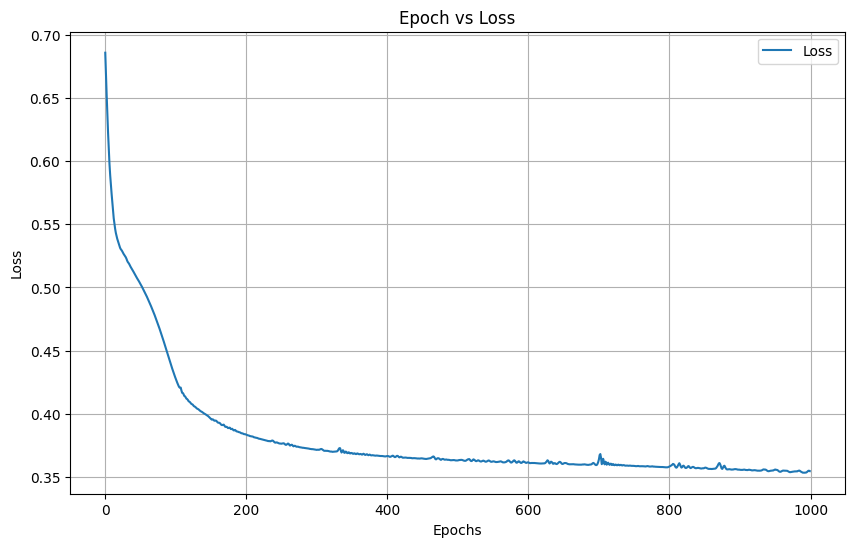

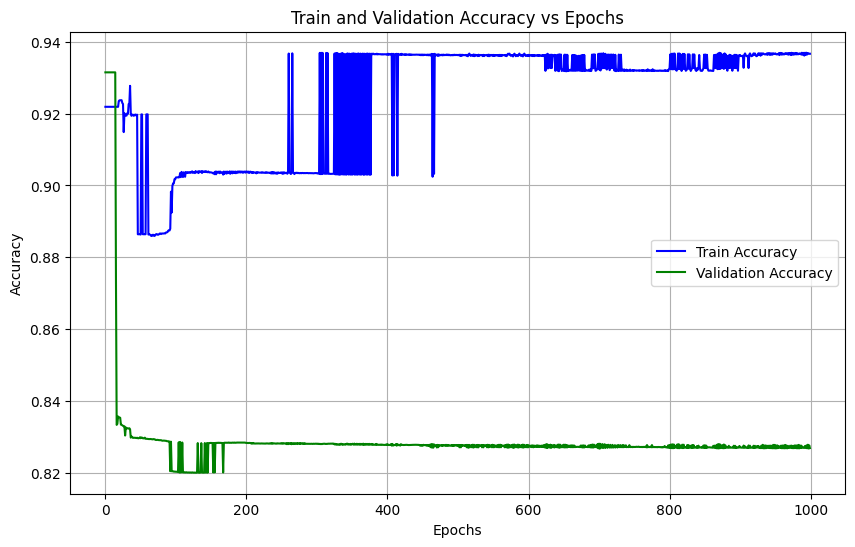

Precision: 0.6067
Recall: 0.5450
F1 Score: 0.5742


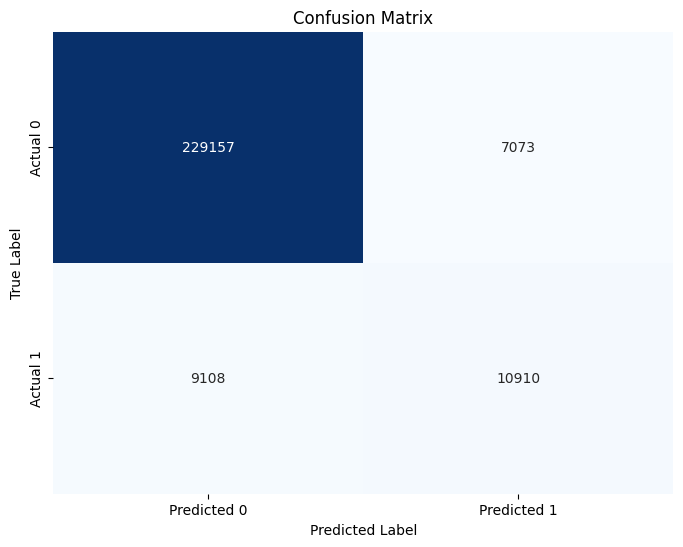

In [49]:
#GCN V 25-11
import os
import torch
import torch.nn.functional as F
import seaborn as sns
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

# Load edge data
edge_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\2--12\extractedcolumns1.txt"
edges = np.loadtxt(edge_file, dtype=int)

# Load node features
feature_folder = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\2--12\features"
node_features_list = []

for file_name in os.listdir(feature_folder):
    if file_name.startswith("feature") and file_name.endswith(".txt"):
        file_path = os.path.join(feature_folder, file_name)
        try:
            feature_data = np.loadtxt(file_path, dtype=float)
            if feature_data.size == 0:
                print(f"Warning: {file_name} is empty. Skipping this file.")
            else:
                node_features_list.append(feature_data)
        except ValueError as e:
            print(f"Warning: Could not read {file_name}. Error: {e}")

if node_features_list:
    node_features = np.column_stack(node_features_list)
else:
    raise ValueError("No valid feature files found. Please check your input files.")

# Load labels
labels_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\2--12\node_contract_status_connected.txt"
labels = torch.tensor(np.loadtxt(labels_file, dtype=int), dtype=torch.long)

print(f"Node features shape: {node_features.shape}")
print(f"Labels shape: {labels.shape}")

# Create graph
G = nx.DiGraph()
G.add_edges_from(edges)

edge_index = torch.tensor(list(G.edges), dtype=torch.long).t().contiguous()

max_edge_index = edge_index.max()
num_nodes = node_features.shape[0]
print(f"Max edge index: {max_edge_index.item()}, Number of nodes: {num_nodes}")

if max_edge_index >= num_nodes:
    raise IndexError(f"Edge index {max_edge_index.item()} is out of bounds for number of nodes {num_nodes}.")

data = Data(x=torch.tensor(node_features, dtype=torch.float), y=labels, edge_index=edge_index)

# Define GCN model
class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(data.num_node_features, 16)
        self.conv2 = GCNConv(16, 16)
        self.conv3 = GCNConv(16, 2)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)
        return x

model = GCN()

# Class weights for imbalanced classes
class_counts = torch.bincount(data.y)
class_weights = 1.0 / torch.sqrt(class_counts.float() + 1e-6)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training mask
y_0_indices = (data.y == 0).nonzero(as_tuple=True)[0]
y_1_indices = (data.y == 1).nonzero(as_tuple=True)[0]
train_indices = torch.cat([y_0_indices, y_1_indices])
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[train_indices] = True

# Load new features and labels for validation
new_feature_folder = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\25-11\features"
new_labels_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\25-11\node_contract_status_connected.txt" 
new_edge_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\25-11\extractedcolumns1.txt" 

new_node_features_list = []
for file_name in os.listdir(new_feature_folder):
    if file_name.startswith("feature") and file_name.endswith(".txt"):
        file_path = os.path.join(new_feature_folder, file_name)
        try:
            feature_data = np.loadtxt(file_path, dtype=float)
            if feature_data.size == 0:
                print(f"Warning: {file_name} is empty. Skipping this file.")
            else:
                new_node_features_list.append(feature_data)
        except ValueError as e:
            print(f"Warning: Could not read {file_name}. Error: {e}")

if new_node_features_list:
    new_node_features = np.column_stack(new_node_features_list)
    new_labels = torch.tensor(np.loadtxt(new_labels_file, dtype=int), dtype=torch.long)
else:
    raise ValueError("No valid new feature files found. Please check your input files.")

new_edges = np.loadtxt(new_edge_file, dtype=int)
new_edge_index = torch.tensor(list(new_edges), dtype=torch.long).t().contiguous()

# Training and validation
validation_accuracies = []
train_accuracies = []
loss_values = []

for epoch in range(1000):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[train_mask], data.y[train_mask])
    loss.backward()
    optimizer.step()

    pred_train = out.argmax(dim=1)
    train_acc = (pred_train[train_mask] == data.y[train_mask]).sum().item() / train_mask.sum().item()

    model.eval()
    with torch.no_grad():
        out_val = model(torch.tensor(new_node_features, dtype=torch.float), new_edge_index)
        pred_val = out_val.argmax(dim=1)
        val_acc = (pred_val == new_labels).sum().item() / new_labels.size(0)

    loss_values.append(loss.item())
    train_accuracies.append(train_acc)
    validation_accuracies.append(val_acc)

    if epoch % 10 == 0:
        print(f'Epoch {epoch:>3} | Loss: {loss.item():.4f} | Train Accuracy: {train_acc*100:.2f}% | Validation Accuracy: {val_acc*100:.2f}%')

# Loss and accuracy plots
plt.figure(figsize=(10, 6))
plt.plot(range(1000), loss_values, label="Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Epoch vs Loss")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range(1000), train_accuracies, label="Train Accuracy", color='blue')
plt.plot(range(1000), validation_accuracies, label="Validation Accuracy", color='green')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train and Validation Accuracy vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

# Evaluation
model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index)
    y_pred = out.argmax(dim=1).cpu().numpy()
    y_true = data.y.cpu().numpy()

conf_matrix = confusion_matrix(y_true[train_mask], y_pred[train_mask])
precision = precision_score(y_true[train_mask], y_pred[train_mask], average='binary', zero_division=0)
recall = recall_score(y_true[train_mask], y_pred[train_mask], average='binary', zero_division=0)
f1 = f1_score(y_true[train_mask], y_pred[train_mask], average='binary', zero_division=0)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


Node features shape: (256248, 6)
Labels shape: torch.Size([256248])
Max edge index: 256247, Number of nodes: 256248
Epoch   0 | Loss: 0.6944 | Train Accuracy: 7.97% | Validation Accuracy: 93.43%
Epoch  10 | Loss: 0.5859 | Train Accuracy: 92.19% | Validation Accuracy: 93.43%
Epoch  20 | Loss: 0.5536 | Train Accuracy: 92.19% | Validation Accuracy: 93.43%
Epoch  30 | Loss: 0.5375 | Train Accuracy: 92.19% | Validation Accuracy: 82.49%
Epoch  40 | Loss: 0.5264 | Train Accuracy: 92.37% | Validation Accuracy: 78.68%
Epoch  50 | Loss: 0.5162 | Train Accuracy: 92.30% | Validation Accuracy: 78.05%
Epoch  60 | Loss: 0.5081 | Train Accuracy: 91.94% | Validation Accuracy: 77.78%
Epoch  70 | Loss: 0.4991 | Train Accuracy: 91.94% | Validation Accuracy: 77.76%
Epoch  80 | Loss: 0.4884 | Train Accuracy: 88.70% | Validation Accuracy: 77.73%
Epoch  90 | Loss: 0.4757 | Train Accuracy: 88.75% | Validation Accuracy: 77.68%
Epoch 100 | Loss: 0.4607 | Train Accuracy: 88.79% | Validation Accuracy: 77.62%
Epoch

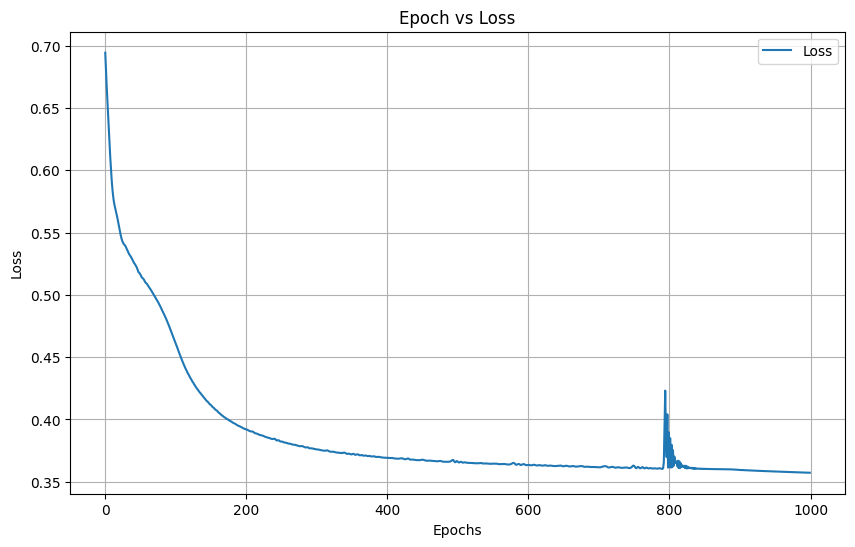

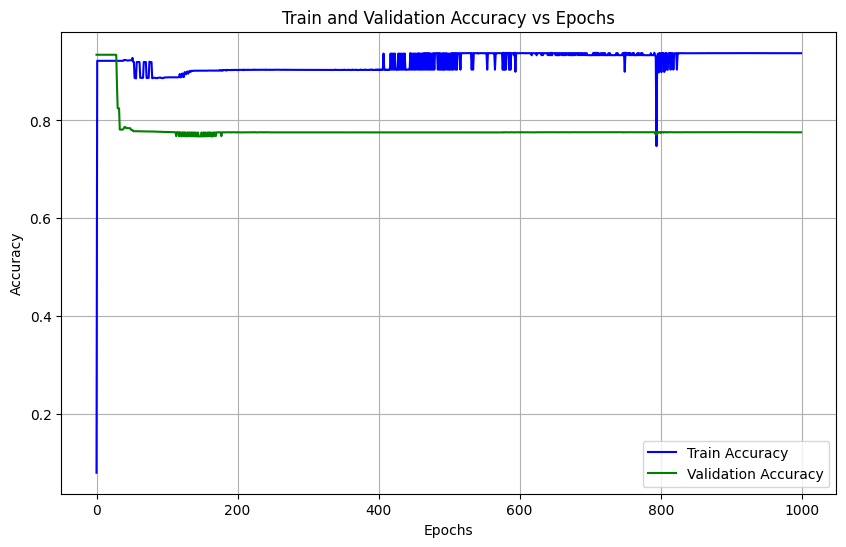

Precision: 0.6135
Recall: 0.5359
F1 Score: 0.5721


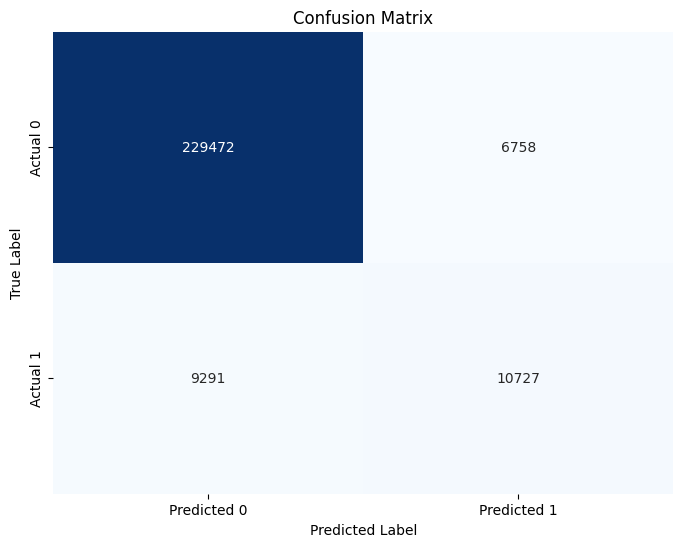

In [48]:
#GCN V 26-11
import os
import torch
import torch.nn.functional as F
import seaborn as sns
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

# Load edge data
edge_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\2--12\extractedcolumns1.txt"
edges = np.loadtxt(edge_file, dtype=int)

# Load node features
feature_folder = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\2--12\features"
node_features_list = []

for file_name in os.listdir(feature_folder):
    if file_name.startswith("feature") and file_name.endswith(".txt"):
        file_path = os.path.join(feature_folder, file_name)
        try:
            feature_data = np.loadtxt(file_path, dtype=float)
            if feature_data.size == 0:
                print(f"Warning: {file_name} is empty. Skipping this file.")
            else:
                node_features_list.append(feature_data)
        except ValueError as e:
            print(f"Warning: Could not read {file_name}. Error: {e}")

if node_features_list:
    node_features = np.column_stack(node_features_list)
else:
    raise ValueError("No valid feature files found. Please check your input files.")

# Load labels
labels_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\2--12\node_contract_status_connected.txt"
labels = torch.tensor(np.loadtxt(labels_file, dtype=int), dtype=torch.long)

print(f"Node features shape: {node_features.shape}")
print(f"Labels shape: {labels.shape}")

# Create graph
G = nx.DiGraph()
G.add_edges_from(edges)

edge_index = torch.tensor(list(G.edges), dtype=torch.long).t().contiguous()

max_edge_index = edge_index.max()
num_nodes = node_features.shape[0]
print(f"Max edge index: {max_edge_index.item()}, Number of nodes: {num_nodes}")

if max_edge_index >= num_nodes:
    raise IndexError(f"Edge index {max_edge_index.item()} is out of bounds for number of nodes {num_nodes}.")

data = Data(x=torch.tensor(node_features, dtype=torch.float), y=labels, edge_index=edge_index)

# Define GCN model
class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(data.num_node_features, 16)
        self.conv2 = GCNConv(16, 16)
        self.conv3 = GCNConv(16, 2)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)
        return x

model = GCN()

# Class weights for imbalanced classes
class_counts = torch.bincount(data.y)
class_weights = 1.0 / torch.sqrt(class_counts.float() + 1e-6)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training mask
y_0_indices = (data.y == 0).nonzero(as_tuple=True)[0]
y_1_indices = (data.y == 1).nonzero(as_tuple=True)[0]
train_indices = torch.cat([y_0_indices, y_1_indices])
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[train_indices] = True

# Load new features and labels for validation
new_feature_folder = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\26-11\features"
new_labels_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\26-11\node_contract_status_connected.txt" 
new_edge_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\26-11\extractedcolumns1.txt" 

new_node_features_list = []
for file_name in os.listdir(new_feature_folder):
    if file_name.startswith("feature") and file_name.endswith(".txt"):
        file_path = os.path.join(new_feature_folder, file_name)
        try:
            feature_data = np.loadtxt(file_path, dtype=float)
            if feature_data.size == 0:
                print(f"Warning: {file_name} is empty. Skipping this file.")
            else:
                new_node_features_list.append(feature_data)
        except ValueError as e:
            print(f"Warning: Could not read {file_name}. Error: {e}")

if new_node_features_list:
    new_node_features = np.column_stack(new_node_features_list)
    new_labels = torch.tensor(np.loadtxt(new_labels_file, dtype=int), dtype=torch.long)
else:
    raise ValueError("No valid new feature files found. Please check your input files.")

new_edges = np.loadtxt(new_edge_file, dtype=int)
new_edge_index = torch.tensor(list(new_edges), dtype=torch.long).t().contiguous()

# Training and validation
validation_accuracies = []
train_accuracies = []
loss_values = []

for epoch in range(1000):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[train_mask], data.y[train_mask])
    loss.backward()
    optimizer.step()

    pred_train = out.argmax(dim=1)
    train_acc = (pred_train[train_mask] == data.y[train_mask]).sum().item() / train_mask.sum().item()

    model.eval()
    with torch.no_grad():
        out_val = model(torch.tensor(new_node_features, dtype=torch.float), new_edge_index)
        pred_val = out_val.argmax(dim=1)
        val_acc = (pred_val == new_labels).sum().item() / new_labels.size(0)

    loss_values.append(loss.item())
    train_accuracies.append(train_acc)
    validation_accuracies.append(val_acc)

    if epoch % 10 == 0:
        print(f'Epoch {epoch:>3} | Loss: {loss.item():.4f} | Train Accuracy: {train_acc*100:.2f}% | Validation Accuracy: {val_acc*100:.2f}%')

# Loss and accuracy plots
plt.figure(figsize=(10, 6))
plt.plot(range(1000), loss_values, label="Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Epoch vs Loss")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range(1000), train_accuracies, label="Train Accuracy", color='blue')
plt.plot(range(1000), validation_accuracies, label="Validation Accuracy", color='green')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train and Validation Accuracy vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

# Evaluation
model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index)
    y_pred = out.argmax(dim=1).cpu().numpy()
    y_true = data.y.cpu().numpy()

conf_matrix = confusion_matrix(y_true[train_mask], y_pred[train_mask])
precision = precision_score(y_true[train_mask], y_pred[train_mask], average='binary', zero_division=0)
recall = recall_score(y_true[train_mask], y_pred[train_mask], average='binary', zero_division=0)
f1 = f1_score(y_true[train_mask], y_pred[train_mask], average='binary', zero_division=0)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


Node features shape: (256248, 6)
Labels shape: torch.Size([256248])
Max edge index: 256247, Number of nodes: 256248
Epoch   0 | Loss: 12.4866 | Train Accuracy: 25.25% | Validation Accuracy: 33.32%
Epoch  10 | Loss: 1.4054 | Train Accuracy: 34.13% | Validation Accuracy: 38.98%
Epoch  20 | Loss: 0.9158 | Train Accuracy: 34.48% | Validation Accuracy: 38.83%
Epoch  30 | Loss: 0.8209 | Train Accuracy: 30.45% | Validation Accuracy: 34.12%
Epoch  40 | Loss: 0.7546 | Train Accuracy: 35.11% | Validation Accuracy: 37.62%
Epoch  50 | Loss: 0.6892 | Train Accuracy: 34.94% | Validation Accuracy: 37.03%
Epoch  60 | Loss: 0.6969 | Train Accuracy: 90.65% | Validation Accuracy: 88.07%
Epoch  70 | Loss: 0.6988 | Train Accuracy: 34.84% | Validation Accuracy: 38.63%
Epoch  80 | Loss: 0.6772 | Train Accuracy: 34.81% | Validation Accuracy: 38.29%
Epoch  90 | Loss: 0.7285 | Train Accuracy: 36.03% | Validation Accuracy: 39.13%
Epoch 100 | Loss: 0.6979 | Train Accuracy: 34.73% | Validation Accuracy: 38.56%
Epo

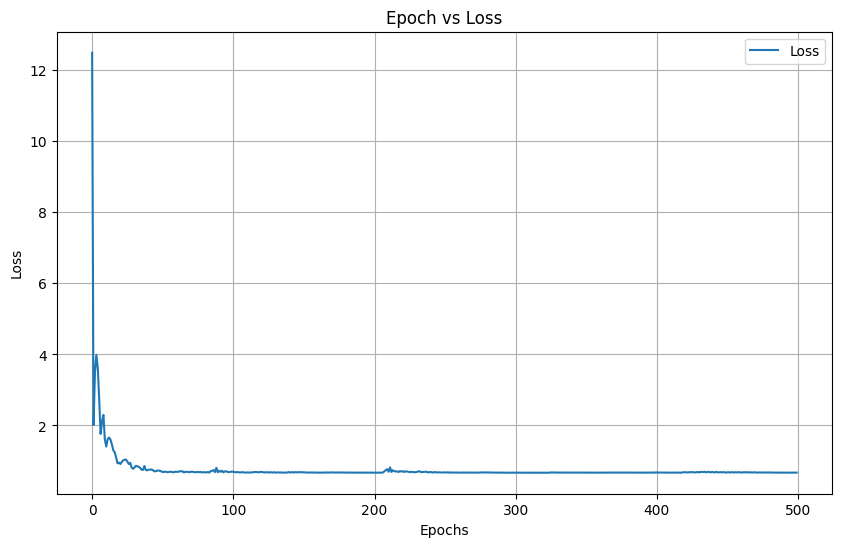

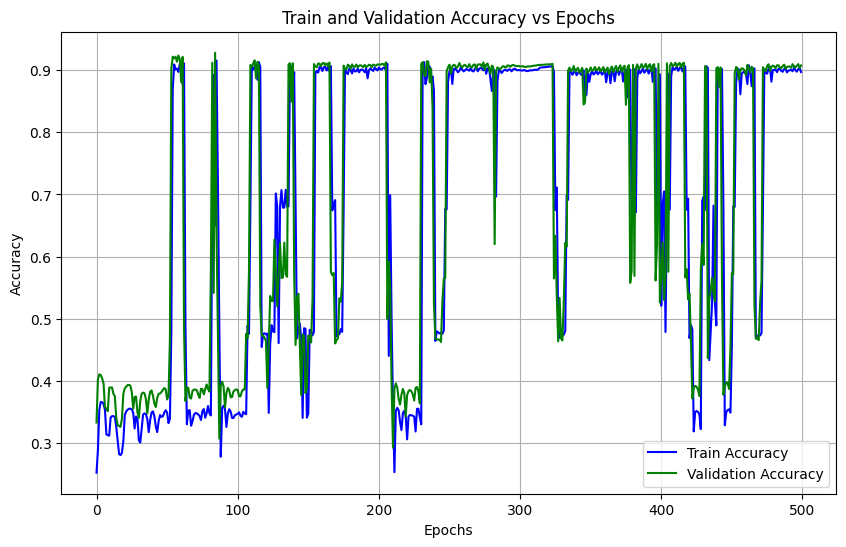

Precision: 0.0998
Recall: 0.0321
F1 Score: 0.0485


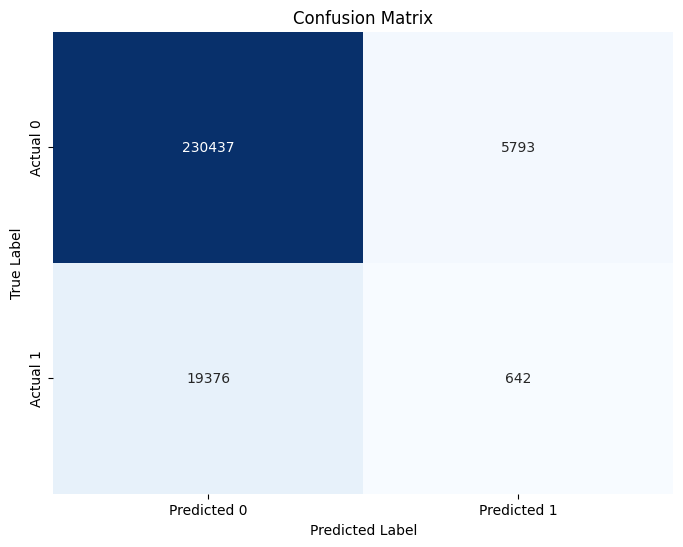

In [47]:
#GNN V 7-11
import os
import torch
import torch.nn.functional as F
import seaborn as sns
from torch_geometric.nn import MessagePassing
from torch_geometric.data import Data
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

# Load edge data
edge_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\2--12\extractedcolumns1.txt"
edges = np.loadtxt(edge_file, dtype=int)

# Load node features
feature_folder = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\2--12\features"
node_features_list = []

for file_name in os.listdir(feature_folder):
    if file_name.startswith("feature") and file_name.endswith(".txt"):
        file_path = os.path.join(feature_folder, file_name)
        try:
            feature_data = np.loadtxt(file_path, dtype=float)
            if feature_data.size == 0:
                print(f"Warning: {file_name} is empty. Skipping this file.")
            else:
                node_features_list.append(feature_data)
        except ValueError as e:
            print(f"Warning: Could not read {file_name}. Error: {e}")

if node_features_list:
    node_features = np.column_stack(node_features_list)
else:
    raise ValueError("No valid feature files found. Please check your input files.")

# Load labels
labels_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\2--12\node_contract_status_connected.txt"
labels = torch.tensor(np.loadtxt(labels_file, dtype=int), dtype=torch.long)

print(f"Node features shape: {node_features.shape}")
print(f"Labels shape: {labels.shape}")

# Create graph
G = nx.DiGraph()
G.add_edges_from(edges)

edge_index = torch.tensor(list(G.edges), dtype=torch.long).t().contiguous()

max_edge_index = edge_index.max()
num_nodes = node_features.shape[0]
print(f"Max edge index: {max_edge_index.item()}, Number of nodes: {num_nodes}")

if max_edge_index >= num_nodes:
    raise IndexError(f"Edge index {max_edge_index.item()} is out of bounds for number of nodes {num_nodes}.")

data = Data(x=torch.tensor(node_features, dtype=torch.float), y=labels, edge_index=edge_index)

# Define custom GNN layer
class CustomGNNLayer(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(CustomGNNLayer, self).__init__(aggr="add")  # "add" aggregation
        self.lin = torch.nn.Linear(in_channels, out_channels)

    def forward(self, x, edge_index):
        # x: Node features, edge_index: Connectivity
        x = self.lin(x)  # Apply linear transformation
        return self.propagate(edge_index, x=x)

    def message(self, x_j):
        # x_j: Features of neighboring nodes
        return x_j

    def update(self, aggr_out):
        # Update node features with aggregated messages
        return aggr_out

# Define GNN model
class GNN(torch.nn.Module):
    def __init__(self):
        super(GNN, self).__init__()
        self.conv1 = CustomGNNLayer(data.num_node_features, 16)
        self.conv2 = CustomGNNLayer(16, 16)
        self.conv3 = CustomGNNLayer(16, 2)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)
        return x

model = GNN()

# Class weights for imbalanced classes
class_counts = torch.bincount(data.y)
class_weights = 1.0 / torch.sqrt(class_counts.float() + 1e-6)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training mask
y_0_indices = (data.y == 0).nonzero(as_tuple=True)[0]
y_1_indices = (data.y == 1).nonzero(as_tuple=True)[0]
train_indices = torch.cat([y_0_indices, y_1_indices])
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[train_indices] = True

# Load new features and labels for validation
new_feature_folder = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\7-11\features"
new_labels_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\7-11\node_contract_status_connected.txt" 
new_edge_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\7-11\extractedcolumns1.txt" 

new_node_features_list = []
for file_name in os.listdir(new_feature_folder):
    if file_name.startswith("feature") and file_name.endswith(".txt"):
        file_path = os.path.join(new_feature_folder, file_name)
        try:
            feature_data = np.loadtxt(file_path, dtype=float)
            if feature_data.size == 0:
                print(f"Warning: {file_name} is empty. Skipping this file.")
            else:
                new_node_features_list.append(feature_data)
        except ValueError as e:
            print(f"Warning: Could not read {file_name}. Error: {e}")

if new_node_features_list:
    new_node_features = np.column_stack(new_node_features_list)
    new_labels = torch.tensor(np.loadtxt(new_labels_file, dtype=int), dtype=torch.long)
else:
    raise ValueError("No valid new feature files found. Please check your input files.")

new_edges = np.loadtxt(new_edge_file, dtype=int)
new_edge_index = torch.tensor(list(new_edges), dtype=torch.long).t().contiguous()

# Training and validation
validation_accuracies = []
train_accuracies = []
loss_values = []

for epoch in range(500):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[train_mask], data.y[train_mask])
    loss.backward()
    optimizer.step()

    pred_train = out.argmax(dim=1)
    train_acc = (pred_train[train_mask] == data.y[train_mask]).sum().item() / train_mask.sum().item()

    model.eval()
    with torch.no_grad():
        out_val = model(torch.tensor(new_node_features, dtype=torch.float), new_edge_index)
        pred_val = out_val.argmax(dim=1)
        val_acc = (pred_val == new_labels).sum().item() / new_labels.size(0)

    loss_values.append(loss.item())
    train_accuracies.append(train_acc)
    validation_accuracies.append(val_acc)

    if epoch % 10 == 0:
        print(f'Epoch {epoch:>3} | Loss: {loss.item():.4f} | Train Accuracy: {train_acc*100:.2f}% | Validation Accuracy: {val_acc*100:.2f}%')

# Loss and accuracy plots
plt.figure(figsize=(10, 6))
plt.plot(range(500), loss_values, label="Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Epoch vs Loss")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range(500), train_accuracies, label="Train Accuracy", color='blue')
plt.plot(range(500), validation_accuracies, label="Validation Accuracy", color='green')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train and Validation Accuracy vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

# Evaluation
model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index)
    y_pred = out.argmax(dim=1).cpu().numpy()
    y_true = data.y.cpu().numpy()

conf_matrix = confusion_matrix(y_true[train_mask], y_pred[train_mask])
precision = precision_score(y_true[train_mask], y_pred[train_mask], average='binary', zero_division=0)
recall = recall_score(y_true[train_mask], y_pred[train_mask], average='binary', zero_division=0)
f1 = f1_score(y_true[train_mask], y_pred[train_mask], average='binary', zero_division=0)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


Node features shape: (256248, 6)
Labels shape: torch.Size([256248])
Max edge index: 256247, Number of nodes: 256248
Epoch   0 | Loss: 11.0813 | Train Accuracy: 25.11% | Validation Accuracy: 33.41%
Epoch  10 | Loss: 1.2945 | Train Accuracy: 34.83% | Validation Accuracy: 32.79%
Epoch  20 | Loss: 1.2554 | Train Accuracy: 35.96% | Validation Accuracy: 39.33%
Epoch  30 | Loss: 0.8984 | Train Accuracy: 33.63% | Validation Accuracy: 35.99%
Epoch  40 | Loss: 0.7517 | Train Accuracy: 34.88% | Validation Accuracy: 36.97%
Epoch  50 | Loss: 0.7141 | Train Accuracy: 34.11% | Validation Accuracy: 37.63%
Epoch  60 | Loss: 0.6804 | Train Accuracy: 49.91% | Validation Accuracy: 88.34%
Epoch  70 | Loss: 0.6861 | Train Accuracy: 48.77% | Validation Accuracy: 37.65%
Epoch  80 | Loss: 0.6778 | Train Accuracy: 36.16% | Validation Accuracy: 39.12%
Epoch  90 | Loss: 0.6743 | Train Accuracy: 91.19% | Validation Accuracy: 56.78%
Epoch 100 | Loss: 0.6751 | Train Accuracy: 49.45% | Validation Accuracy: 46.52%
Epo

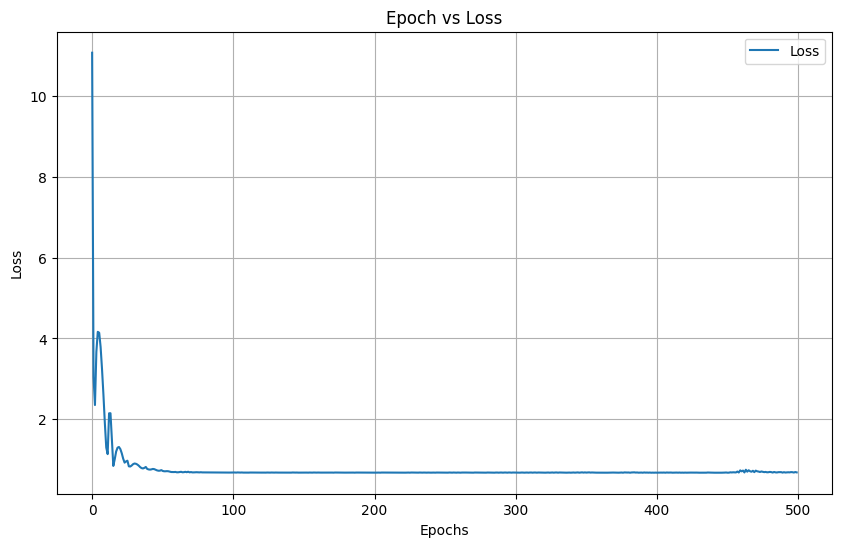

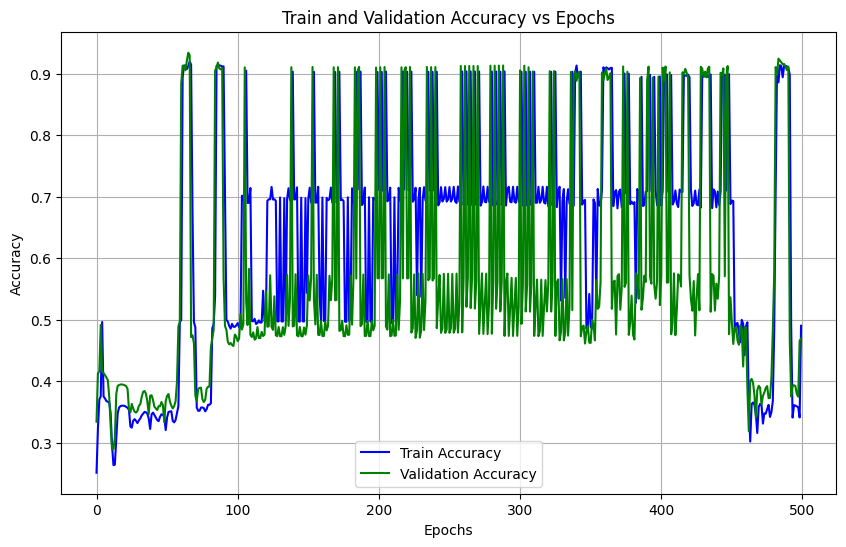

Precision: 0.1179
Recall: 0.8554
F1 Score: 0.2072


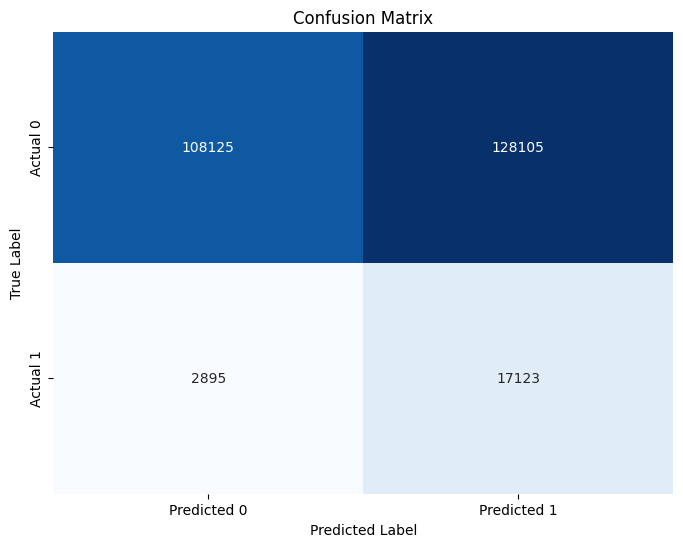

In [46]:
#GNN V 8-11
import os
import torch
import torch.nn.functional as F
import seaborn as sns
from torch_geometric.nn import MessagePassing
from torch_geometric.data import Data
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

# Load edge data
edge_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\2--12\extractedcolumns1.txt"
edges = np.loadtxt(edge_file, dtype=int)

# Load node features
feature_folder = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\2--12\features"
node_features_list = []

for file_name in os.listdir(feature_folder):
    if file_name.startswith("feature") and file_name.endswith(".txt"):
        file_path = os.path.join(feature_folder, file_name)
        try:
            feature_data = np.loadtxt(file_path, dtype=float)
            if feature_data.size == 0:
                print(f"Warning: {file_name} is empty. Skipping this file.")
            else:
                node_features_list.append(feature_data)
        except ValueError as e:
            print(f"Warning: Could not read {file_name}. Error: {e}")

if node_features_list:
    node_features = np.column_stack(node_features_list)
else:
    raise ValueError("No valid feature files found. Please check your input files.")

# Load labels
labels_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\2--12\node_contract_status_connected.txt"
labels = torch.tensor(np.loadtxt(labels_file, dtype=int), dtype=torch.long)

print(f"Node features shape: {node_features.shape}")
print(f"Labels shape: {labels.shape}")

# Create graph
G = nx.DiGraph()
G.add_edges_from(edges)

edge_index = torch.tensor(list(G.edges), dtype=torch.long).t().contiguous()

max_edge_index = edge_index.max()
num_nodes = node_features.shape[0]
print(f"Max edge index: {max_edge_index.item()}, Number of nodes: {num_nodes}")

if max_edge_index >= num_nodes:
    raise IndexError(f"Edge index {max_edge_index.item()} is out of bounds for number of nodes {num_nodes}.")

data = Data(x=torch.tensor(node_features, dtype=torch.float), y=labels, edge_index=edge_index)

# Define custom GNN layer
class CustomGNNLayer(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(CustomGNNLayer, self).__init__(aggr="add")  # "add" aggregation
        self.lin = torch.nn.Linear(in_channels, out_channels)

    def forward(self, x, edge_index):
        # x: Node features, edge_index: Connectivity
        x = self.lin(x)  # Apply linear transformation
        return self.propagate(edge_index, x=x)

    def message(self, x_j):
        # x_j: Features of neighboring nodes
        return x_j

    def update(self, aggr_out):
        # Update node features with aggregated messages
        return aggr_out

# Define GNN model
class GNN(torch.nn.Module):
    def __init__(self):
        super(GNN, self).__init__()
        self.conv1 = CustomGNNLayer(data.num_node_features, 16)
        self.conv2 = CustomGNNLayer(16, 16)
        self.conv3 = CustomGNNLayer(16, 2)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)
        return x

model = GNN()

# Class weights for imbalanced classes
class_counts = torch.bincount(data.y)
class_weights = 1.0 / torch.sqrt(class_counts.float() + 1e-6)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training mask
y_0_indices = (data.y == 0).nonzero(as_tuple=True)[0]
y_1_indices = (data.y == 1).nonzero(as_tuple=True)[0]
train_indices = torch.cat([y_0_indices, y_1_indices])
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[train_indices] = True

# Load new features and labels for validation
new_feature_folder = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\8-11\features"
new_labels_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\8-11\node_contract_status_connected.txt" 
new_edge_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\8-11\extractedcolumns1.txt" 

new_node_features_list = []
for file_name in os.listdir(new_feature_folder):
    if file_name.startswith("feature") and file_name.endswith(".txt"):
        file_path = os.path.join(new_feature_folder, file_name)
        try:
            feature_data = np.loadtxt(file_path, dtype=float)
            if feature_data.size == 0:
                print(f"Warning: {file_name} is empty. Skipping this file.")
            else:
                new_node_features_list.append(feature_data)
        except ValueError as e:
            print(f"Warning: Could not read {file_name}. Error: {e}")

if new_node_features_list:
    new_node_features = np.column_stack(new_node_features_list)
    new_labels = torch.tensor(np.loadtxt(new_labels_file, dtype=int), dtype=torch.long)
else:
    raise ValueError("No valid new feature files found. Please check your input files.")

new_edges = np.loadtxt(new_edge_file, dtype=int)
new_edge_index = torch.tensor(list(new_edges), dtype=torch.long).t().contiguous()

# Training and validation
validation_accuracies = []
train_accuracies = []
loss_values = []

for epoch in range(500):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[train_mask], data.y[train_mask])
    loss.backward()
    optimizer.step()

    pred_train = out.argmax(dim=1)
    train_acc = (pred_train[train_mask] == data.y[train_mask]).sum().item() / train_mask.sum().item()

    model.eval()
    with torch.no_grad():
        out_val = model(torch.tensor(new_node_features, dtype=torch.float), new_edge_index)
        pred_val = out_val.argmax(dim=1)
        val_acc = (pred_val == new_labels).sum().item() / new_labels.size(0)

    loss_values.append(loss.item())
    train_accuracies.append(train_acc)
    validation_accuracies.append(val_acc)

    if epoch % 10 == 0:
        print(f'Epoch {epoch:>3} | Loss: {loss.item():.4f} | Train Accuracy: {train_acc*100:.2f}% | Validation Accuracy: {val_acc*100:.2f}%')

# Loss and accuracy plots
plt.figure(figsize=(10, 6))
plt.plot(range(500), loss_values, label="Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Epoch vs Loss")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range(500), train_accuracies, label="Train Accuracy", color='blue')
plt.plot(range(500), validation_accuracies, label="Validation Accuracy", color='green')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train and Validation Accuracy vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

# Evaluation
model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index)
    y_pred = out.argmax(dim=1).cpu().numpy()
    y_true = data.y.cpu().numpy()

conf_matrix = confusion_matrix(y_true[train_mask], y_pred[train_mask])
precision = precision_score(y_true[train_mask], y_pred[train_mask], average='binary', zero_division=0)
recall = recall_score(y_true[train_mask], y_pred[train_mask], average='binary', zero_division=0)
f1 = f1_score(y_true[train_mask], y_pred[train_mask], average='binary', zero_division=0)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


Node features shape: (256248, 6)
Labels shape: torch.Size([256248])
Max edge index: 256247, Number of nodes: 256248
Epoch   0 | Loss: 17.3615 | Train Accuracy: 28.96% | Validation Accuracy: 32.53%
Epoch  10 | Loss: 1.8420 | Train Accuracy: 27.37% | Validation Accuracy: 25.89%
Epoch  20 | Loss: 1.0410 | Train Accuracy: 30.27% | Validation Accuracy: 31.40%
Epoch  30 | Loss: 0.8657 | Train Accuracy: 30.57% | Validation Accuracy: 35.51%
Epoch  40 | Loss: 0.7716 | Train Accuracy: 35.16% | Validation Accuracy: 36.52%
Epoch  50 | Loss: 0.6991 | Train Accuracy: 35.36% | Validation Accuracy: 31.02%
Epoch  60 | Loss: 0.7308 | Train Accuracy: 49.84% | Validation Accuracy: 38.61%
Epoch  70 | Loss: 0.7035 | Train Accuracy: 35.84% | Validation Accuracy: 35.69%
Epoch  80 | Loss: 0.7068 | Train Accuracy: 35.91% | Validation Accuracy: 31.15%
Epoch  90 | Loss: 0.7133 | Train Accuracy: 31.22% | Validation Accuracy: 36.70%
Epoch 100 | Loss: 0.6796 | Train Accuracy: 36.31% | Validation Accuracy: 36.05%
Epo

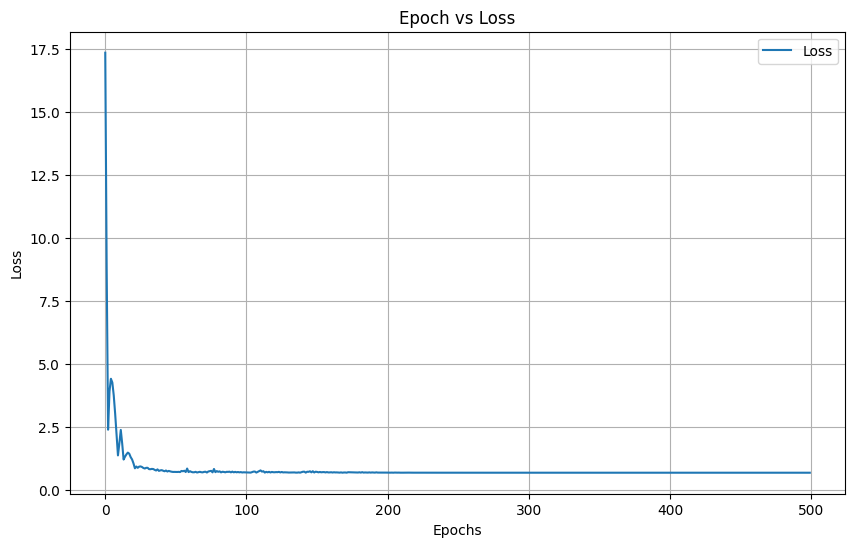

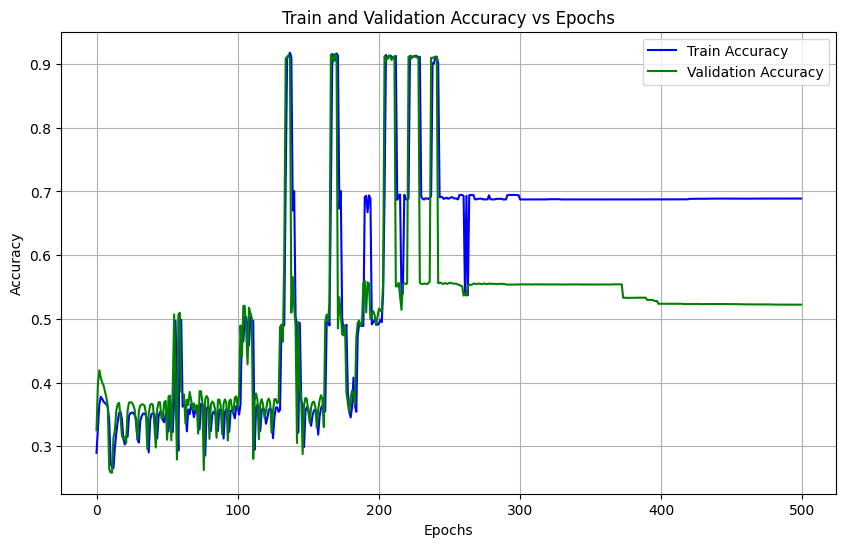

Precision: 0.0534
Recall: 0.1784
F1 Score: 0.0822


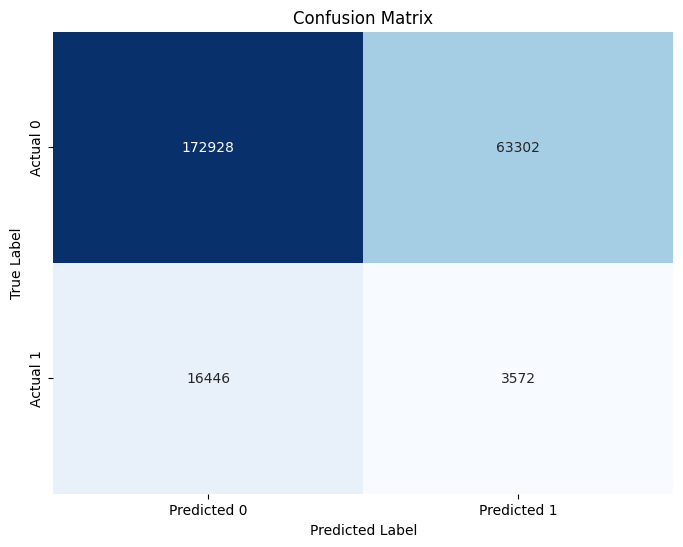

In [45]:
#GNN V 12-11
import os
import torch
import torch.nn.functional as F
import seaborn as sns
from torch_geometric.nn import MessagePassing
from torch_geometric.data import Data
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

# Load edge data
edge_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\2--12\extractedcolumns1.txt"
edges = np.loadtxt(edge_file, dtype=int)

# Load node features
feature_folder = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\2--12\features"
node_features_list = []

for file_name in os.listdir(feature_folder):
    if file_name.startswith("feature") and file_name.endswith(".txt"):
        file_path = os.path.join(feature_folder, file_name)
        try:
            feature_data = np.loadtxt(file_path, dtype=float)
            if feature_data.size == 0:
                print(f"Warning: {file_name} is empty. Skipping this file.")
            else:
                node_features_list.append(feature_data)
        except ValueError as e:
            print(f"Warning: Could not read {file_name}. Error: {e}")

if node_features_list:
    node_features = np.column_stack(node_features_list)
else:
    raise ValueError("No valid feature files found. Please check your input files.")

# Load labels
labels_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\2--12\node_contract_status_connected.txt"
labels = torch.tensor(np.loadtxt(labels_file, dtype=int), dtype=torch.long)

print(f"Node features shape: {node_features.shape}")
print(f"Labels shape: {labels.shape}")

# Create graph
G = nx.DiGraph()
G.add_edges_from(edges)

edge_index = torch.tensor(list(G.edges), dtype=torch.long).t().contiguous()

max_edge_index = edge_index.max()
num_nodes = node_features.shape[0]
print(f"Max edge index: {max_edge_index.item()}, Number of nodes: {num_nodes}")

if max_edge_index >= num_nodes:
    raise IndexError(f"Edge index {max_edge_index.item()} is out of bounds for number of nodes {num_nodes}.")

data = Data(x=torch.tensor(node_features, dtype=torch.float), y=labels, edge_index=edge_index)

# Define custom GNN layer
class CustomGNNLayer(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(CustomGNNLayer, self).__init__(aggr="add")  # "add" aggregation
        self.lin = torch.nn.Linear(in_channels, out_channels)

    def forward(self, x, edge_index):
        # x: Node features, edge_index: Connectivity
        x = self.lin(x)  # Apply linear transformation
        return self.propagate(edge_index, x=x)

    def message(self, x_j):
        # x_j: Features of neighboring nodes
        return x_j

    def update(self, aggr_out):
        # Update node features with aggregated messages
        return aggr_out

# Define GNN model
class GNN(torch.nn.Module):
    def __init__(self):
        super(GNN, self).__init__()
        self.conv1 = CustomGNNLayer(data.num_node_features, 16)
        self.conv2 = CustomGNNLayer(16, 16)
        self.conv3 = CustomGNNLayer(16, 2)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)
        return x

model = GNN()

# Class weights for imbalanced classes
class_counts = torch.bincount(data.y)
class_weights = 1.0 / torch.sqrt(class_counts.float() + 1e-6)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training mask
y_0_indices = (data.y == 0).nonzero(as_tuple=True)[0]
y_1_indices = (data.y == 1).nonzero(as_tuple=True)[0]
train_indices = torch.cat([y_0_indices, y_1_indices])
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[train_indices] = True

# Load new features and labels for validation
new_feature_folder = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\12-11\features"
new_labels_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\12-11\node_contract_status_connected.txt" 
new_edge_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\12-11\extractedcolumns1.txt" 

new_node_features_list = []
for file_name in os.listdir(new_feature_folder):
    if file_name.startswith("feature") and file_name.endswith(".txt"):
        file_path = os.path.join(new_feature_folder, file_name)
        try:
            feature_data = np.loadtxt(file_path, dtype=float)
            if feature_data.size == 0:
                print(f"Warning: {file_name} is empty. Skipping this file.")
            else:
                new_node_features_list.append(feature_data)
        except ValueError as e:
            print(f"Warning: Could not read {file_name}. Error: {e}")

if new_node_features_list:
    new_node_features = np.column_stack(new_node_features_list)
    new_labels = torch.tensor(np.loadtxt(new_labels_file, dtype=int), dtype=torch.long)
else:
    raise ValueError("No valid new feature files found. Please check your input files.")

new_edges = np.loadtxt(new_edge_file, dtype=int)
new_edge_index = torch.tensor(list(new_edges), dtype=torch.long).t().contiguous()

# Training and validation
validation_accuracies = []
train_accuracies = []
loss_values = []

for epoch in range(500):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[train_mask], data.y[train_mask])
    loss.backward()
    optimizer.step()

    pred_train = out.argmax(dim=1)
    train_acc = (pred_train[train_mask] == data.y[train_mask]).sum().item() / train_mask.sum().item()

    model.eval()
    with torch.no_grad():
        out_val = model(torch.tensor(new_node_features, dtype=torch.float), new_edge_index)
        pred_val = out_val.argmax(dim=1)
        val_acc = (pred_val == new_labels).sum().item() / new_labels.size(0)

    loss_values.append(loss.item())
    train_accuracies.append(train_acc)
    validation_accuracies.append(val_acc)

    if epoch % 10 == 0:
        print(f'Epoch {epoch:>3} | Loss: {loss.item():.4f} | Train Accuracy: {train_acc*100:.2f}% | Validation Accuracy: {val_acc*100:.2f}%')

# Loss and accuracy plots
plt.figure(figsize=(10, 6))
plt.plot(range(500), loss_values, label="Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Epoch vs Loss")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range(500), train_accuracies, label="Train Accuracy", color='blue')
plt.plot(range(500), validation_accuracies, label="Validation Accuracy", color='green')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train and Validation Accuracy vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

# Evaluation
model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index)
    y_pred = out.argmax(dim=1).cpu().numpy()
    y_true = data.y.cpu().numpy()

conf_matrix = confusion_matrix(y_true[train_mask], y_pred[train_mask])
precision = precision_score(y_true[train_mask], y_pred[train_mask], average='binary', zero_division=0)
recall = recall_score(y_true[train_mask], y_pred[train_mask], average='binary', zero_division=0)
f1 = f1_score(y_true[train_mask], y_pred[train_mask], average='binary', zero_division=0)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


Node features shape: (256248, 6)
Labels shape: torch.Size([256248])
Max edge index: 256247, Number of nodes: 256248
Epoch   0 | Loss: 1.4613 | Train Accuracy: 90.22% | Validation Accuracy: 81.77%
Epoch  10 | Loss: 1.7292 | Train Accuracy: 88.67% | Validation Accuracy: 87.34%
Epoch  20 | Loss: 1.1679 | Train Accuracy: 87.11% | Validation Accuracy: 86.77%
Epoch  30 | Loss: 0.8743 | Train Accuracy: 49.55% | Validation Accuracy: 46.44%
Epoch  40 | Loss: 0.7089 | Train Accuracy: 33.82% | Validation Accuracy: 35.80%
Epoch  50 | Loss: 0.7499 | Train Accuracy: 30.34% | Validation Accuracy: 31.63%
Epoch  60 | Loss: 0.7017 | Train Accuracy: 35.03% | Validation Accuracy: 31.70%
Epoch  70 | Loss: 0.6874 | Train Accuracy: 90.46% | Validation Accuracy: 87.91%
Epoch  80 | Loss: 0.6806 | Train Accuracy: 90.10% | Validation Accuracy: 84.73%
Epoch  90 | Loss: 0.6784 | Train Accuracy: 90.39% | Validation Accuracy: 85.30%
Epoch 100 | Loss: 0.6812 | Train Accuracy: 89.69% | Validation Accuracy: 87.22%
Epoc

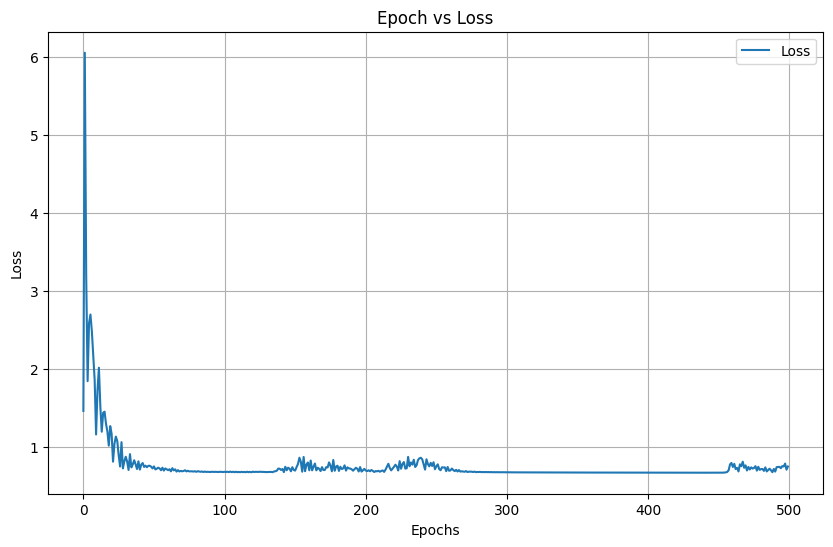

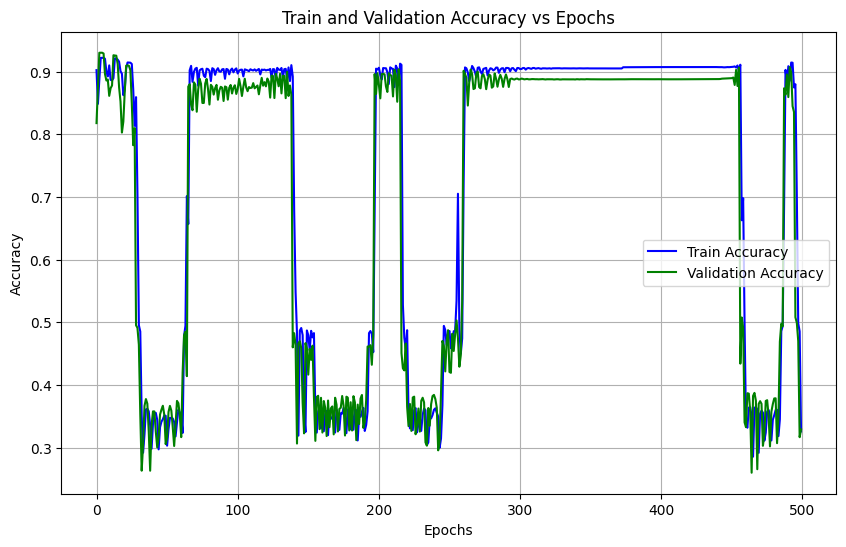

Precision: 0.1007
Recall: 0.9535
F1 Score: 0.1821


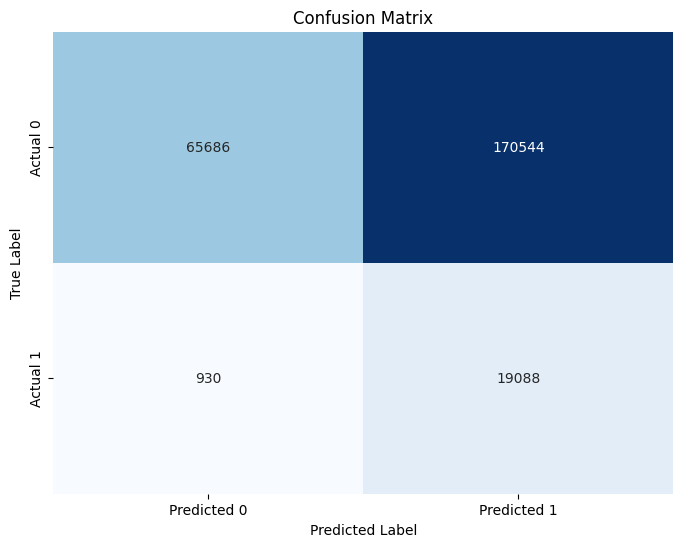

In [44]:
#GNN V 13-11
import os
import torch
import torch.nn.functional as F
import seaborn as sns
from torch_geometric.nn import MessagePassing
from torch_geometric.data import Data
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

# Load edge data
edge_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\2--12\extractedcolumns1.txt"
edges = np.loadtxt(edge_file, dtype=int)

# Load node features
feature_folder = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\2--12\features"
node_features_list = []

for file_name in os.listdir(feature_folder):
    if file_name.startswith("feature") and file_name.endswith(".txt"):
        file_path = os.path.join(feature_folder, file_name)
        try:
            feature_data = np.loadtxt(file_path, dtype=float)
            if feature_data.size == 0:
                print(f"Warning: {file_name} is empty. Skipping this file.")
            else:
                node_features_list.append(feature_data)
        except ValueError as e:
            print(f"Warning: Could not read {file_name}. Error: {e}")

if node_features_list:
    node_features = np.column_stack(node_features_list)
else:
    raise ValueError("No valid feature files found. Please check your input files.")

# Load labels
labels_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\2--12\node_contract_status_connected.txt"
labels = torch.tensor(np.loadtxt(labels_file, dtype=int), dtype=torch.long)

print(f"Node features shape: {node_features.shape}")
print(f"Labels shape: {labels.shape}")

# Create graph
G = nx.DiGraph()
G.add_edges_from(edges)

edge_index = torch.tensor(list(G.edges), dtype=torch.long).t().contiguous()

max_edge_index = edge_index.max()
num_nodes = node_features.shape[0]
print(f"Max edge index: {max_edge_index.item()}, Number of nodes: {num_nodes}")

if max_edge_index >= num_nodes:
    raise IndexError(f"Edge index {max_edge_index.item()} is out of bounds for number of nodes {num_nodes}.")

data = Data(x=torch.tensor(node_features, dtype=torch.float), y=labels, edge_index=edge_index)

# Define custom GNN layer
class CustomGNNLayer(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(CustomGNNLayer, self).__init__(aggr="add")  # "add" aggregation
        self.lin = torch.nn.Linear(in_channels, out_channels)

    def forward(self, x, edge_index):
        # x: Node features, edge_index: Connectivity
        x = self.lin(x)  # Apply linear transformation
        return self.propagate(edge_index, x=x)

    def message(self, x_j):
        # x_j: Features of neighboring nodes
        return x_j

    def update(self, aggr_out):
        # Update node features with aggregated messages
        return aggr_out

# Define GNN model
class GNN(torch.nn.Module):
    def __init__(self):
        super(GNN, self).__init__()
        self.conv1 = CustomGNNLayer(data.num_node_features, 16)
        self.conv2 = CustomGNNLayer(16, 16)
        self.conv3 = CustomGNNLayer(16, 2)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)
        return x

model = GNN()

# Class weights for imbalanced classes
class_counts = torch.bincount(data.y)
class_weights = 1.0 / torch.sqrt(class_counts.float() + 1e-6)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training mask
y_0_indices = (data.y == 0).nonzero(as_tuple=True)[0]
y_1_indices = (data.y == 1).nonzero(as_tuple=True)[0]
train_indices = torch.cat([y_0_indices, y_1_indices])
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[train_indices] = True

# Load new features and labels for validation
new_feature_folder = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\13-11\features"
new_labels_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\13-11\node_contract_status_connected.txt" 
new_edge_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\13-11\extractedcolumns1.txt" 

new_node_features_list = []
for file_name in os.listdir(new_feature_folder):
    if file_name.startswith("feature") and file_name.endswith(".txt"):
        file_path = os.path.join(new_feature_folder, file_name)
        try:
            feature_data = np.loadtxt(file_path, dtype=float)
            if feature_data.size == 0:
                print(f"Warning: {file_name} is empty. Skipping this file.")
            else:
                new_node_features_list.append(feature_data)
        except ValueError as e:
            print(f"Warning: Could not read {file_name}. Error: {e}")

if new_node_features_list:
    new_node_features = np.column_stack(new_node_features_list)
    new_labels = torch.tensor(np.loadtxt(new_labels_file, dtype=int), dtype=torch.long)
else:
    raise ValueError("No valid new feature files found. Please check your input files.")

new_edges = np.loadtxt(new_edge_file, dtype=int)
new_edge_index = torch.tensor(list(new_edges), dtype=torch.long).t().contiguous()

# Training and validation
validation_accuracies = []
train_accuracies = []
loss_values = []

for epoch in range(500):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[train_mask], data.y[train_mask])
    loss.backward()
    optimizer.step()

    pred_train = out.argmax(dim=1)
    train_acc = (pred_train[train_mask] == data.y[train_mask]).sum().item() / train_mask.sum().item()

    model.eval()
    with torch.no_grad():
        out_val = model(torch.tensor(new_node_features, dtype=torch.float), new_edge_index)
        pred_val = out_val.argmax(dim=1)
        val_acc = (pred_val == new_labels).sum().item() / new_labels.size(0)

    loss_values.append(loss.item())
    train_accuracies.append(train_acc)
    validation_accuracies.append(val_acc)

    if epoch % 10 == 0:
        print(f'Epoch {epoch:>3} | Loss: {loss.item():.4f} | Train Accuracy: {train_acc*100:.2f}% | Validation Accuracy: {val_acc*100:.2f}%')

# Loss and accuracy plots
plt.figure(figsize=(10, 6))
plt.plot(range(500), loss_values, label="Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Epoch vs Loss")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range(500), train_accuracies, label="Train Accuracy", color='blue')
plt.plot(range(500), validation_accuracies, label="Validation Accuracy", color='green')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train and Validation Accuracy vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

# Evaluation
model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index)
    y_pred = out.argmax(dim=1).cpu().numpy()
    y_true = data.y.cpu().numpy()

conf_matrix = confusion_matrix(y_true[train_mask], y_pred[train_mask])
precision = precision_score(y_true[train_mask], y_pred[train_mask], average='binary', zero_division=0)
recall = recall_score(y_true[train_mask], y_pred[train_mask], average='binary', zero_division=0)
f1 = f1_score(y_true[train_mask], y_pred[train_mask], average='binary', zero_division=0)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


Node features shape: (256248, 6)
Labels shape: torch.Size([256248])
Max edge index: 256247, Number of nodes: 256248
Epoch   0 | Loss: 6.4558 | Train Accuracy: 81.57% | Validation Accuracy: 88.32%
Epoch  10 | Loss: 1.1751 | Train Accuracy: 47.96% | Validation Accuracy: 29.79%
Epoch  20 | Loss: 0.8454 | Train Accuracy: 35.74% | Validation Accuracy: 35.76%
Epoch  30 | Loss: 0.7313 | Train Accuracy: 33.65% | Validation Accuracy: 32.30%
Epoch  40 | Loss: 0.7078 | Train Accuracy: 35.27% | Validation Accuracy: 38.60%
Epoch  50 | Loss: 0.6807 | Train Accuracy: 88.96% | Validation Accuracy: 89.68%
Epoch  60 | Loss: 0.6747 | Train Accuracy: 68.49% | Validation Accuracy: 50.11%
Epoch  70 | Loss: 0.6744 | Train Accuracy: 48.88% | Validation Accuracy: 50.26%
Epoch  80 | Loss: 0.6731 | Train Accuracy: 90.83% | Validation Accuracy: 90.71%
Epoch  90 | Loss: 0.6726 | Train Accuracy: 68.68% | Validation Accuracy: 85.87%
Epoch 100 | Loss: 0.6722 | Train Accuracy: 88.57% | Validation Accuracy: 51.56%
Epoc

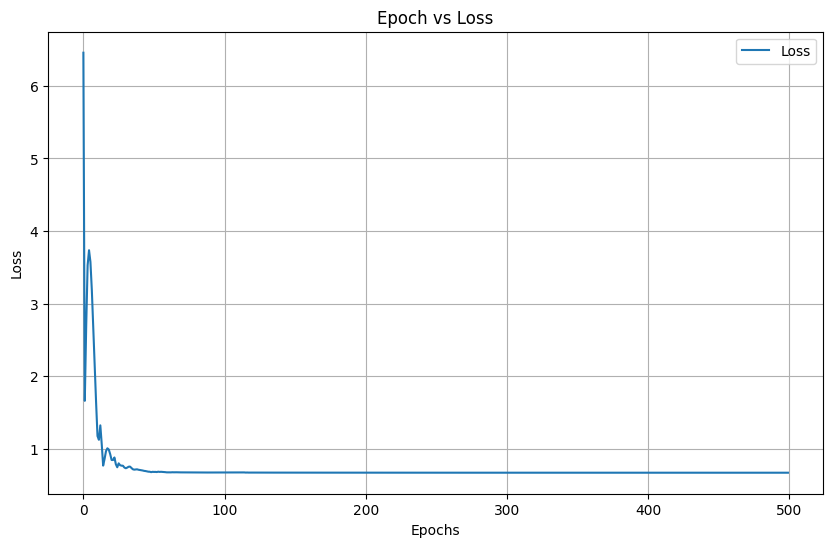

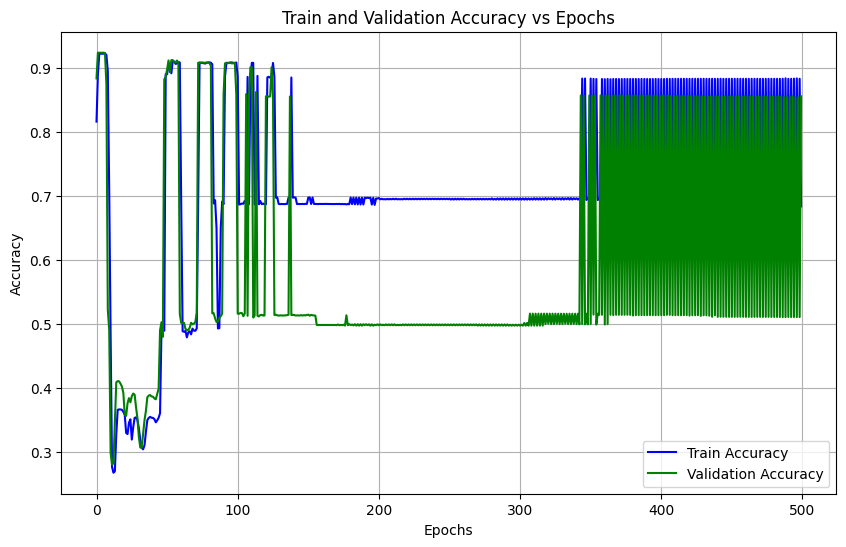

Precision: 0.0768
Recall: 0.0456
F1 Score: 0.0572


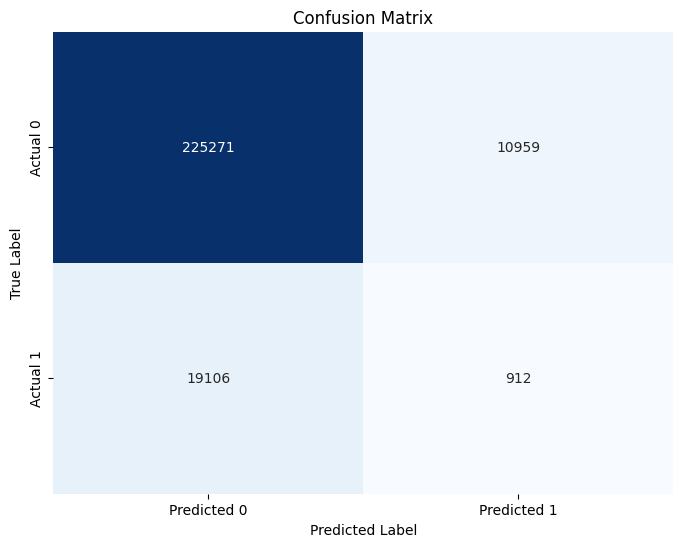

In [43]:
#GNN V 14-11
import os
import torch
import torch.nn.functional as F
import seaborn as sns
from torch_geometric.nn import MessagePassing
from torch_geometric.data import Data
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

# Load edge data
edge_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\2--12\extractedcolumns1.txt"
edges = np.loadtxt(edge_file, dtype=int)

# Load node features
feature_folder = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\2--12\features"
node_features_list = []

for file_name in os.listdir(feature_folder):
    if file_name.startswith("feature") and file_name.endswith(".txt"):
        file_path = os.path.join(feature_folder, file_name)
        try:
            feature_data = np.loadtxt(file_path, dtype=float)
            if feature_data.size == 0:
                print(f"Warning: {file_name} is empty. Skipping this file.")
            else:
                node_features_list.append(feature_data)
        except ValueError as e:
            print(f"Warning: Could not read {file_name}. Error: {e}")

if node_features_list:
    node_features = np.column_stack(node_features_list)
else:
    raise ValueError("No valid feature files found. Please check your input files.")

# Load labels
labels_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\2--12\node_contract_status_connected.txt"
labels = torch.tensor(np.loadtxt(labels_file, dtype=int), dtype=torch.long)

print(f"Node features shape: {node_features.shape}")
print(f"Labels shape: {labels.shape}")

# Create graph
G = nx.DiGraph()
G.add_edges_from(edges)

edge_index = torch.tensor(list(G.edges), dtype=torch.long).t().contiguous()

max_edge_index = edge_index.max()
num_nodes = node_features.shape[0]
print(f"Max edge index: {max_edge_index.item()}, Number of nodes: {num_nodes}")

if max_edge_index >= num_nodes:
    raise IndexError(f"Edge index {max_edge_index.item()} is out of bounds for number of nodes {num_nodes}.")

data = Data(x=torch.tensor(node_features, dtype=torch.float), y=labels, edge_index=edge_index)

# Define custom GNN layer
class CustomGNNLayer(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(CustomGNNLayer, self).__init__(aggr="add")  # "add" aggregation
        self.lin = torch.nn.Linear(in_channels, out_channels)

    def forward(self, x, edge_index):
        # x: Node features, edge_index: Connectivity
        x = self.lin(x)  # Apply linear transformation
        return self.propagate(edge_index, x=x)

    def message(self, x_j):
        # x_j: Features of neighboring nodes
        return x_j

    def update(self, aggr_out):
        # Update node features with aggregated messages
        return aggr_out

# Define GNN model
class GNN(torch.nn.Module):
    def __init__(self):
        super(GNN, self).__init__()
        self.conv1 = CustomGNNLayer(data.num_node_features, 16)
        self.conv2 = CustomGNNLayer(16, 16)
        self.conv3 = CustomGNNLayer(16, 2)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)
        return x

model = GNN()

# Class weights for imbalanced classes
class_counts = torch.bincount(data.y)
class_weights = 1.0 / torch.sqrt(class_counts.float() + 1e-6)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training mask
y_0_indices = (data.y == 0).nonzero(as_tuple=True)[0]
y_1_indices = (data.y == 1).nonzero(as_tuple=True)[0]
train_indices = torch.cat([y_0_indices, y_1_indices])
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[train_indices] = True

# Load new features and labels for validation
new_feature_folder = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\14-11\features"
new_labels_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\14-11\node_contract_status_connected.txt" 
new_edge_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\14-11\extractedcolumns1.txt" 

new_node_features_list = []
for file_name in os.listdir(new_feature_folder):
    if file_name.startswith("feature") and file_name.endswith(".txt"):
        file_path = os.path.join(new_feature_folder, file_name)
        try:
            feature_data = np.loadtxt(file_path, dtype=float)
            if feature_data.size == 0:
                print(f"Warning: {file_name} is empty. Skipping this file.")
            else:
                new_node_features_list.append(feature_data)
        except ValueError as e:
            print(f"Warning: Could not read {file_name}. Error: {e}")

if new_node_features_list:
    new_node_features = np.column_stack(new_node_features_list)
    new_labels = torch.tensor(np.loadtxt(new_labels_file, dtype=int), dtype=torch.long)
else:
    raise ValueError("No valid new feature files found. Please check your input files.")

new_edges = np.loadtxt(new_edge_file, dtype=int)
new_edge_index = torch.tensor(list(new_edges), dtype=torch.long).t().contiguous()

# Training and validation
validation_accuracies = []
train_accuracies = []
loss_values = []

for epoch in range(500):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[train_mask], data.y[train_mask])
    loss.backward()
    optimizer.step()

    pred_train = out.argmax(dim=1)
    train_acc = (pred_train[train_mask] == data.y[train_mask]).sum().item() / train_mask.sum().item()

    model.eval()
    with torch.no_grad():
        out_val = model(torch.tensor(new_node_features, dtype=torch.float), new_edge_index)
        pred_val = out_val.argmax(dim=1)
        val_acc = (pred_val == new_labels).sum().item() / new_labels.size(0)

    loss_values.append(loss.item())
    train_accuracies.append(train_acc)
    validation_accuracies.append(val_acc)

    if epoch % 10 == 0:
        print(f'Epoch {epoch:>3} | Loss: {loss.item():.4f} | Train Accuracy: {train_acc*100:.2f}% | Validation Accuracy: {val_acc*100:.2f}%')

# Loss and accuracy plots
plt.figure(figsize=(10, 6))
plt.plot(range(500), loss_values, label="Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Epoch vs Loss")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range(500), train_accuracies, label="Train Accuracy", color='blue')
plt.plot(range(500), validation_accuracies, label="Validation Accuracy", color='green')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train and Validation Accuracy vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

# Evaluation
model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index)
    y_pred = out.argmax(dim=1).cpu().numpy()
    y_true = data.y.cpu().numpy()

conf_matrix = confusion_matrix(y_true[train_mask], y_pred[train_mask])
precision = precision_score(y_true[train_mask], y_pred[train_mask], average='binary', zero_division=0)
recall = recall_score(y_true[train_mask], y_pred[train_mask], average='binary', zero_division=0)
f1 = f1_score(y_true[train_mask], y_pred[train_mask], average='binary', zero_division=0)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


Node features shape: (256248, 6)
Labels shape: torch.Size([256248])
Max edge index: 256247, Number of nodes: 256248
Epoch   0 | Loss: 5.7779 | Train Accuracy: 81.36% | Validation Accuracy: 51.05%
Epoch  10 | Loss: 1.7083 | Train Accuracy: 50.14% | Validation Accuracy: 50.52%
Epoch  20 | Loss: 1.1647 | Train Accuracy: 31.61% | Validation Accuracy: 38.95%
Epoch  30 | Loss: 1.2963 | Train Accuracy: 36.07% | Validation Accuracy: 38.43%
Epoch  40 | Loss: 1.1576 | Train Accuracy: 35.71% | Validation Accuracy: 34.07%
Epoch  50 | Loss: 1.2489 | Train Accuracy: 31.39% | Validation Accuracy: 33.24%
Epoch  60 | Loss: 1.0145 | Train Accuracy: 30.22% | Validation Accuracy: 32.03%
Epoch  70 | Loss: 0.9021 | Train Accuracy: 28.47% | Validation Accuracy: 30.25%
Epoch  80 | Loss: 0.7678 | Train Accuracy: 32.76% | Validation Accuracy: 37.61%
Epoch  90 | Loss: 0.7076 | Train Accuracy: 47.32% | Validation Accuracy: 45.65%
Epoch 100 | Loss: 0.7636 | Train Accuracy: 86.35% | Validation Accuracy: 92.44%
Epoc

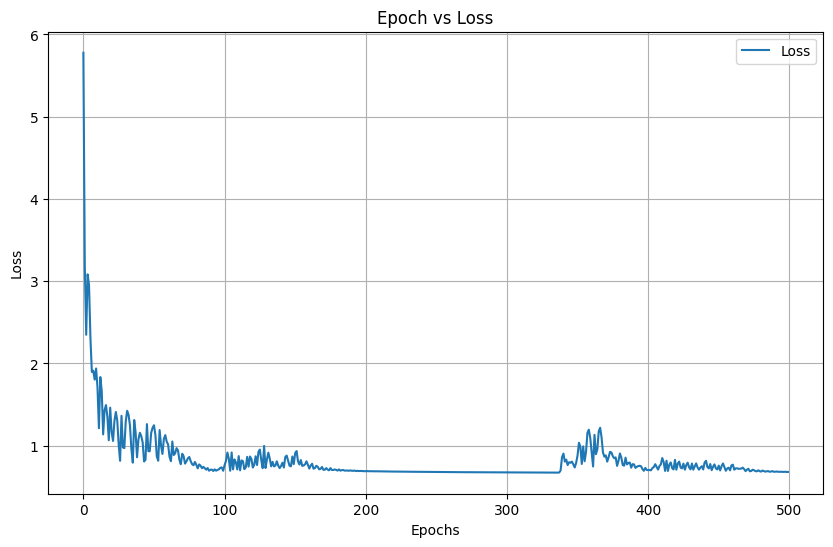

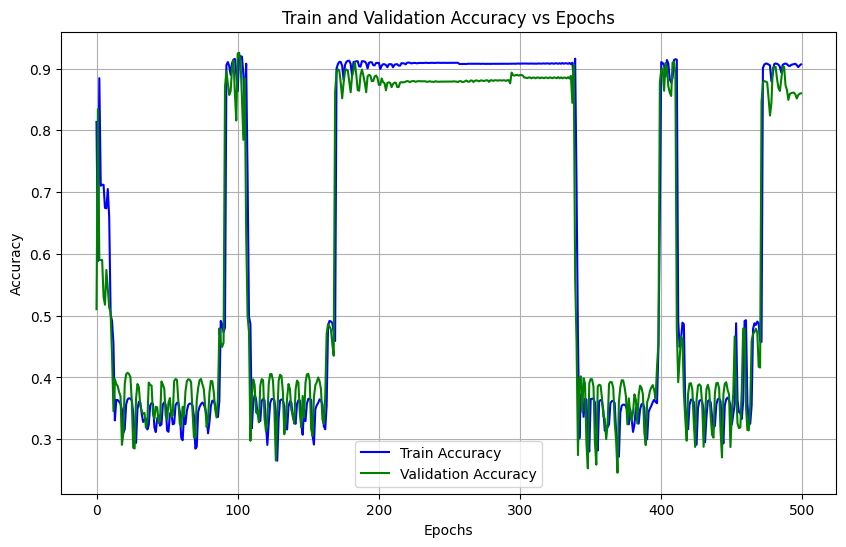

Precision: 0.1062
Recall: 0.0258
F1 Score: 0.0415


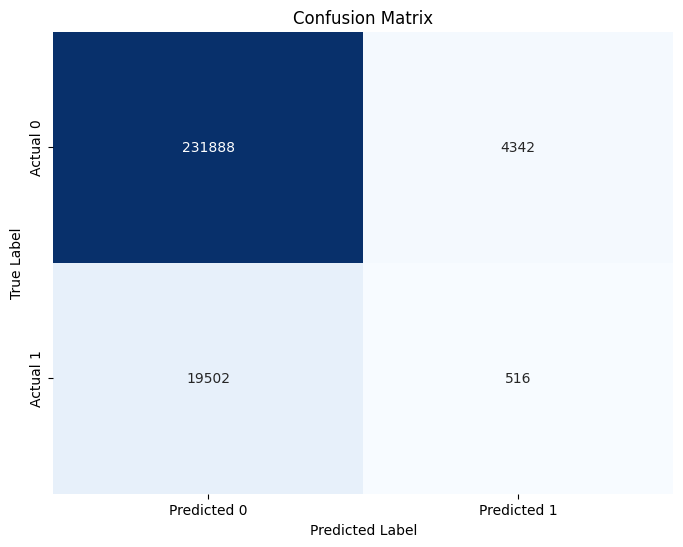

In [42]:
#GNN V 24-11
import os
import torch
import torch.nn.functional as F
import seaborn as sns
from torch_geometric.nn import MessagePassing
from torch_geometric.data import Data
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

# Load edge data
edge_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\2--12\extractedcolumns1.txt"
edges = np.loadtxt(edge_file, dtype=int)

# Load node features
feature_folder = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\2--12\features"
node_features_list = []

for file_name in os.listdir(feature_folder):
    if file_name.startswith("feature") and file_name.endswith(".txt"):
        file_path = os.path.join(feature_folder, file_name)
        try:
            feature_data = np.loadtxt(file_path, dtype=float)
            if feature_data.size == 0:
                print(f"Warning: {file_name} is empty. Skipping this file.")
            else:
                node_features_list.append(feature_data)
        except ValueError as e:
            print(f"Warning: Could not read {file_name}. Error: {e}")

if node_features_list:
    node_features = np.column_stack(node_features_list)
else:
    raise ValueError("No valid feature files found. Please check your input files.")

# Load labels
labels_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\2--12\node_contract_status_connected.txt"
labels = torch.tensor(np.loadtxt(labels_file, dtype=int), dtype=torch.long)

print(f"Node features shape: {node_features.shape}")
print(f"Labels shape: {labels.shape}")

# Create graph
G = nx.DiGraph()
G.add_edges_from(edges)

edge_index = torch.tensor(list(G.edges), dtype=torch.long).t().contiguous()

max_edge_index = edge_index.max()
num_nodes = node_features.shape[0]
print(f"Max edge index: {max_edge_index.item()}, Number of nodes: {num_nodes}")

if max_edge_index >= num_nodes:
    raise IndexError(f"Edge index {max_edge_index.item()} is out of bounds for number of nodes {num_nodes}.")

data = Data(x=torch.tensor(node_features, dtype=torch.float), y=labels, edge_index=edge_index)

# Define custom GNN layer
class CustomGNNLayer(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(CustomGNNLayer, self).__init__(aggr="add")  # "add" aggregation
        self.lin = torch.nn.Linear(in_channels, out_channels)

    def forward(self, x, edge_index):
        # x: Node features, edge_index: Connectivity
        x = self.lin(x)  # Apply linear transformation
        return self.propagate(edge_index, x=x)

    def message(self, x_j):
        # x_j: Features of neighboring nodes
        return x_j

    def update(self, aggr_out):
        # Update node features with aggregated messages
        return aggr_out

# Define GNN model
class GNN(torch.nn.Module):
    def __init__(self):
        super(GNN, self).__init__()
        self.conv1 = CustomGNNLayer(data.num_node_features, 16)
        self.conv2 = CustomGNNLayer(16, 16)
        self.conv3 = CustomGNNLayer(16, 2)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)
        return x

model = GNN()

# Class weights for imbalanced classes
class_counts = torch.bincount(data.y)
class_weights = 1.0 / torch.sqrt(class_counts.float() + 1e-6)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training mask
y_0_indices = (data.y == 0).nonzero(as_tuple=True)[0]
y_1_indices = (data.y == 1).nonzero(as_tuple=True)[0]
train_indices = torch.cat([y_0_indices, y_1_indices])
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[train_indices] = True

# Load new features and labels for validation
new_feature_folder = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\24-11\features"
new_labels_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\24-11\node_contract_status_connected.txt" 
new_edge_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\24-11\extractedcolumns1.txt" 

new_node_features_list = []
for file_name in os.listdir(new_feature_folder):
    if file_name.startswith("feature") and file_name.endswith(".txt"):
        file_path = os.path.join(new_feature_folder, file_name)
        try:
            feature_data = np.loadtxt(file_path, dtype=float)
            if feature_data.size == 0:
                print(f"Warning: {file_name} is empty. Skipping this file.")
            else:
                new_node_features_list.append(feature_data)
        except ValueError as e:
            print(f"Warning: Could not read {file_name}. Error: {e}")

if new_node_features_list:
    new_node_features = np.column_stack(new_node_features_list)
    new_labels = torch.tensor(np.loadtxt(new_labels_file, dtype=int), dtype=torch.long)
else:
    raise ValueError("No valid new feature files found. Please check your input files.")

new_edges = np.loadtxt(new_edge_file, dtype=int)
new_edge_index = torch.tensor(list(new_edges), dtype=torch.long).t().contiguous()

# Training and validation
validation_accuracies = []
train_accuracies = []
loss_values = []

for epoch in range(500):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[train_mask], data.y[train_mask])
    loss.backward()
    optimizer.step()

    pred_train = out.argmax(dim=1)
    train_acc = (pred_train[train_mask] == data.y[train_mask]).sum().item() / train_mask.sum().item()

    model.eval()
    with torch.no_grad():
        out_val = model(torch.tensor(new_node_features, dtype=torch.float), new_edge_index)
        pred_val = out_val.argmax(dim=1)
        val_acc = (pred_val == new_labels).sum().item() / new_labels.size(0)

    loss_values.append(loss.item())
    train_accuracies.append(train_acc)
    validation_accuracies.append(val_acc)

    if epoch % 10 == 0:
        print(f'Epoch {epoch:>3} | Loss: {loss.item():.4f} | Train Accuracy: {train_acc*100:.2f}% | Validation Accuracy: {val_acc*100:.2f}%')

# Loss and accuracy plots
plt.figure(figsize=(10, 6))
plt.plot(range(500), loss_values, label="Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Epoch vs Loss")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range(500), train_accuracies, label="Train Accuracy", color='blue')
plt.plot(range(500), validation_accuracies, label="Validation Accuracy", color='green')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train and Validation Accuracy vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

# Evaluation
model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index)
    y_pred = out.argmax(dim=1).cpu().numpy()
    y_true = data.y.cpu().numpy()

conf_matrix = confusion_matrix(y_true[train_mask], y_pred[train_mask])
precision = precision_score(y_true[train_mask], y_pred[train_mask], average='binary', zero_division=0)
recall = recall_score(y_true[train_mask], y_pred[train_mask], average='binary', zero_division=0)
f1 = f1_score(y_true[train_mask], y_pred[train_mask], average='binary', zero_division=0)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


Node features shape: (256248, 6)
Labels shape: torch.Size([256248])
Max edge index: 256247, Number of nodes: 256248
Epoch   0 | Loss: 20.4577 | Train Accuracy: 25.26% | Validation Accuracy: 26.99%
Epoch  10 | Loss: 5.1391 | Train Accuracy: 50.42% | Validation Accuracy: 52.77%
Epoch  20 | Loss: 1.7453 | Train Accuracy: 36.65% | Validation Accuracy: 42.33%
Epoch  30 | Loss: 1.4224 | Train Accuracy: 32.79% | Validation Accuracy: 35.87%
Epoch  40 | Loss: 0.8560 | Train Accuracy: 34.18% | Validation Accuracy: 38.79%
Epoch  50 | Loss: 0.8031 | Train Accuracy: 35.16% | Validation Accuracy: 38.94%
Epoch  60 | Loss: 0.7512 | Train Accuracy: 35.49% | Validation Accuracy: 39.97%
Epoch  70 | Loss: 0.6841 | Train Accuracy: 49.11% | Validation Accuracy: 50.70%
Epoch  80 | Loss: 0.6770 | Train Accuracy: 64.39% | Validation Accuracy: 52.41%
Epoch  90 | Loss: 0.6751 | Train Accuracy: 86.84% | Validation Accuracy: 87.05%
Epoch 100 | Loss: 0.6734 | Train Accuracy: 90.69% | Validation Accuracy: 51.84%
Epo

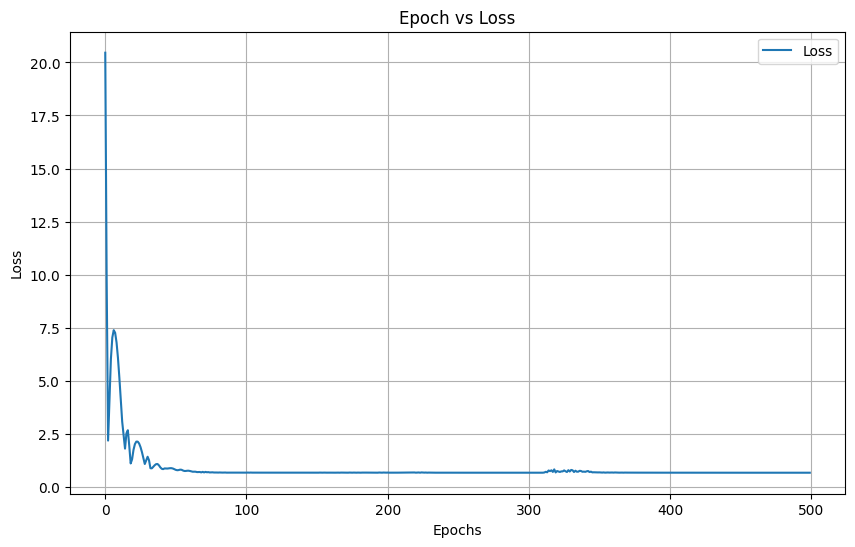

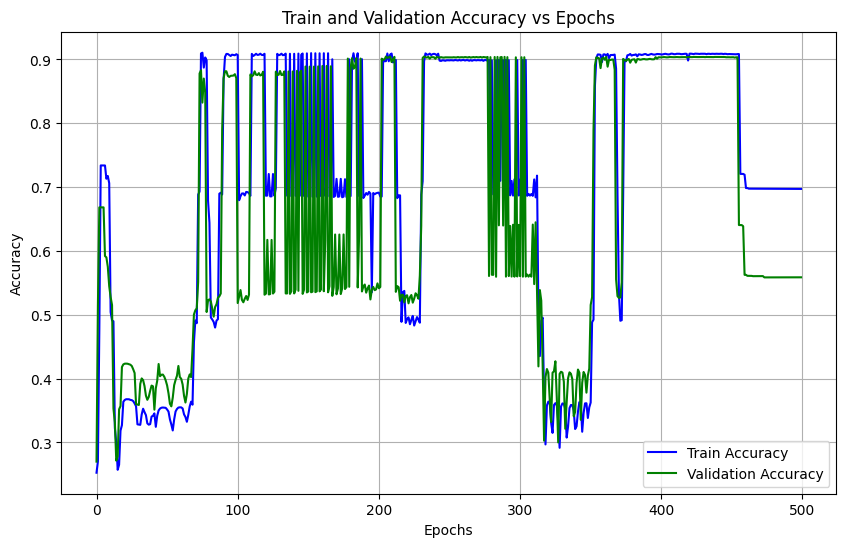

Precision: 0.0543
Recall: 0.1751
F1 Score: 0.0829


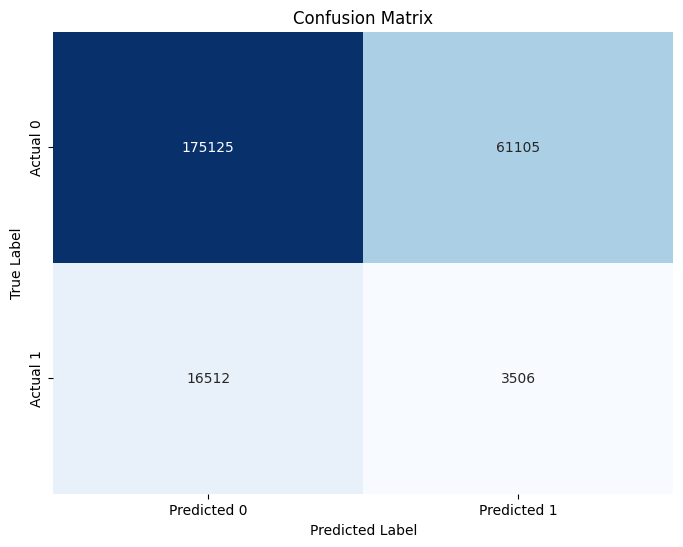

In [41]:
#GNN V 25-11
import os
import torch
import torch.nn.functional as F
import seaborn as sns
from torch_geometric.nn import MessagePassing
from torch_geometric.data import Data
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

# Load edge data
edge_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\2--12\extractedcolumns1.txt"
edges = np.loadtxt(edge_file, dtype=int)

# Load node features
feature_folder = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\2--12\features"
node_features_list = []

for file_name in os.listdir(feature_folder):
    if file_name.startswith("feature") and file_name.endswith(".txt"):
        file_path = os.path.join(feature_folder, file_name)
        try:
            feature_data = np.loadtxt(file_path, dtype=float)
            if feature_data.size == 0:
                print(f"Warning: {file_name} is empty. Skipping this file.")
            else:
                node_features_list.append(feature_data)
        except ValueError as e:
            print(f"Warning: Could not read {file_name}. Error: {e}")

if node_features_list:
    node_features = np.column_stack(node_features_list)
else:
    raise ValueError("No valid feature files found. Please check your input files.")

# Load labels
labels_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\2--12\node_contract_status_connected.txt"
labels = torch.tensor(np.loadtxt(labels_file, dtype=int), dtype=torch.long)

print(f"Node features shape: {node_features.shape}")
print(f"Labels shape: {labels.shape}")

# Create graph
G = nx.DiGraph()
G.add_edges_from(edges)

edge_index = torch.tensor(list(G.edges), dtype=torch.long).t().contiguous()

max_edge_index = edge_index.max()
num_nodes = node_features.shape[0]
print(f"Max edge index: {max_edge_index.item()}, Number of nodes: {num_nodes}")

if max_edge_index >= num_nodes:
    raise IndexError(f"Edge index {max_edge_index.item()} is out of bounds for number of nodes {num_nodes}.")

data = Data(x=torch.tensor(node_features, dtype=torch.float), y=labels, edge_index=edge_index)

# Define custom GNN layer
class CustomGNNLayer(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(CustomGNNLayer, self).__init__(aggr="add")  # "add" aggregation
        self.lin = torch.nn.Linear(in_channels, out_channels)

    def forward(self, x, edge_index):
        # x: Node features, edge_index: Connectivity
        x = self.lin(x)  # Apply linear transformation
        return self.propagate(edge_index, x=x)

    def message(self, x_j):
        # x_j: Features of neighboring nodes
        return x_j

    def update(self, aggr_out):
        # Update node features with aggregated messages
        return aggr_out

# Define GNN model
class GNN(torch.nn.Module):
    def __init__(self):
        super(GNN, self).__init__()
        self.conv1 = CustomGNNLayer(data.num_node_features, 16)
        self.conv2 = CustomGNNLayer(16, 16)
        self.conv3 = CustomGNNLayer(16, 2)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)
        return x

model = GNN()

# Class weights for imbalanced classes
class_counts = torch.bincount(data.y)
class_weights = 1.0 / torch.sqrt(class_counts.float() + 1e-6)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training mask
y_0_indices = (data.y == 0).nonzero(as_tuple=True)[0]
y_1_indices = (data.y == 1).nonzero(as_tuple=True)[0]
train_indices = torch.cat([y_0_indices, y_1_indices])
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[train_indices] = True

# Load new features and labels for validation
new_feature_folder = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\25-11\features"
new_labels_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\25-11\node_contract_status_connected.txt" 
new_edge_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\25-11\extractedcolumns1.txt" 

new_node_features_list = []
for file_name in os.listdir(new_feature_folder):
    if file_name.startswith("feature") and file_name.endswith(".txt"):
        file_path = os.path.join(new_feature_folder, file_name)
        try:
            feature_data = np.loadtxt(file_path, dtype=float)
            if feature_data.size == 0:
                print(f"Warning: {file_name} is empty. Skipping this file.")
            else:
                new_node_features_list.append(feature_data)
        except ValueError as e:
            print(f"Warning: Could not read {file_name}. Error: {e}")

if new_node_features_list:
    new_node_features = np.column_stack(new_node_features_list)
    new_labels = torch.tensor(np.loadtxt(new_labels_file, dtype=int), dtype=torch.long)
else:
    raise ValueError("No valid new feature files found. Please check your input files.")

new_edges = np.loadtxt(new_edge_file, dtype=int)
new_edge_index = torch.tensor(list(new_edges), dtype=torch.long).t().contiguous()

# Training and validation
validation_accuracies = []
train_accuracies = []
loss_values = []

for epoch in range(500):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[train_mask], data.y[train_mask])
    loss.backward()
    optimizer.step()

    pred_train = out.argmax(dim=1)
    train_acc = (pred_train[train_mask] == data.y[train_mask]).sum().item() / train_mask.sum().item()

    model.eval()
    with torch.no_grad():
        out_val = model(torch.tensor(new_node_features, dtype=torch.float), new_edge_index)
        pred_val = out_val.argmax(dim=1)
        val_acc = (pred_val == new_labels).sum().item() / new_labels.size(0)

    loss_values.append(loss.item())
    train_accuracies.append(train_acc)
    validation_accuracies.append(val_acc)

    if epoch % 10 == 0:
        print(f'Epoch {epoch:>3} | Loss: {loss.item():.4f} | Train Accuracy: {train_acc*100:.2f}% | Validation Accuracy: {val_acc*100:.2f}%')

# Loss and accuracy plots
plt.figure(figsize=(10, 6))
plt.plot(range(500), loss_values, label="Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Epoch vs Loss")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range(500), train_accuracies, label="Train Accuracy", color='blue')
plt.plot(range(500), validation_accuracies, label="Validation Accuracy", color='green')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train and Validation Accuracy vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

# Evaluation
model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index)
    y_pred = out.argmax(dim=1).cpu().numpy()
    y_true = data.y.cpu().numpy()

conf_matrix = confusion_matrix(y_true[train_mask], y_pred[train_mask])
precision = precision_score(y_true[train_mask], y_pred[train_mask], average='binary', zero_division=0)
recall = recall_score(y_true[train_mask], y_pred[train_mask], average='binary', zero_division=0)
f1 = f1_score(y_true[train_mask], y_pred[train_mask], average='binary', zero_division=0)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


Node features shape: (256248, 6)
Labels shape: torch.Size([256248])
Max edge index: 256247, Number of nodes: 256248
Epoch   0 | Loss: 2.9364 | Train Accuracy: 72.47% | Validation Accuracy: 48.50%
Epoch  10 | Loss: 2.7514 | Train Accuracy: 32.60% | Validation Accuracy: 34.53%
Epoch  20 | Loss: 1.0054 | Train Accuracy: 27.52% | Validation Accuracy: 32.89%
Epoch  30 | Loss: 1.0711 | Train Accuracy: 32.52% | Validation Accuracy: 37.27%
Epoch  40 | Loss: 1.1441 | Train Accuracy: 30.75% | Validation Accuracy: 34.27%
Epoch  50 | Loss: 0.8507 | Train Accuracy: 31.29% | Validation Accuracy: 37.70%
Epoch  60 | Loss: 0.7897 | Train Accuracy: 33.13% | Validation Accuracy: 35.60%
Epoch  70 | Loss: 0.7345 | Train Accuracy: 34.00% | Validation Accuracy: 37.10%
Epoch  80 | Loss: 0.6960 | Train Accuracy: 35.62% | Validation Accuracy: 38.59%
Epoch  90 | Loss: 0.6881 | Train Accuracy: 90.71% | Validation Accuracy: 91.41%
Epoch 100 | Loss: 0.6845 | Train Accuracy: 91.00% | Validation Accuracy: 90.80%
Epoc

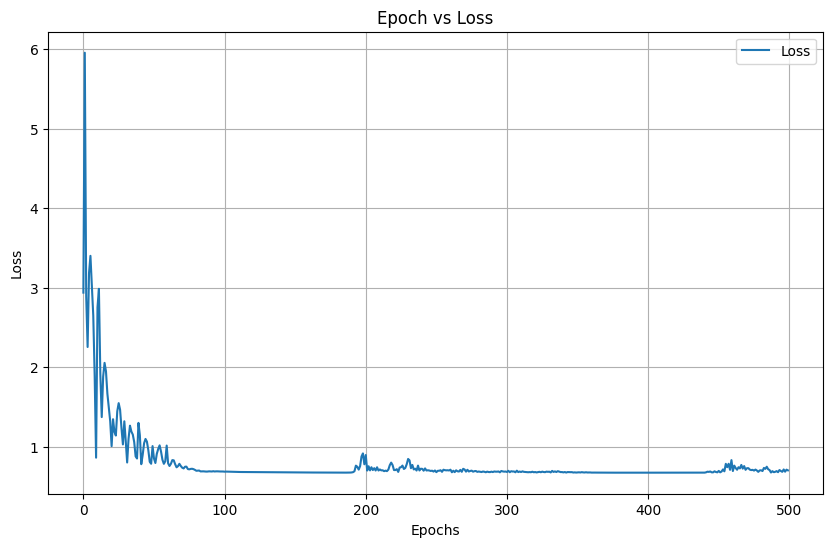

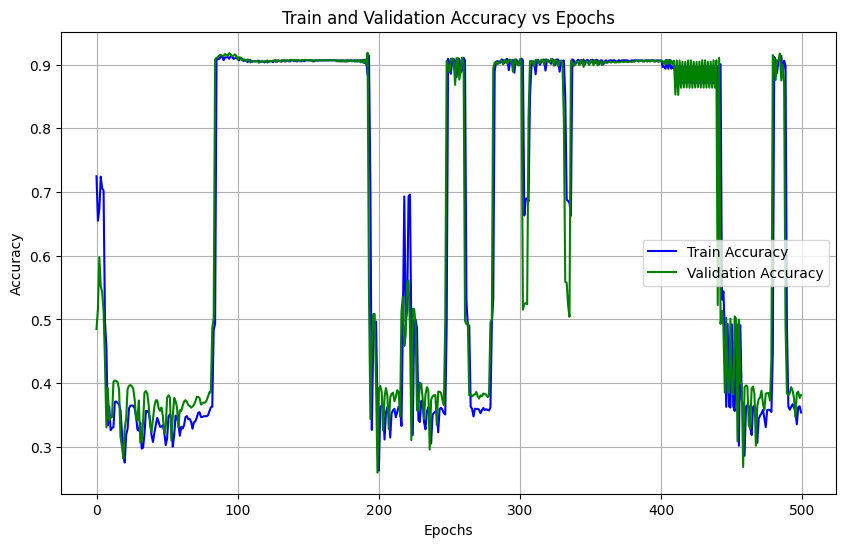

Precision: 0.1012
Recall: 0.9165
F1 Score: 0.1823


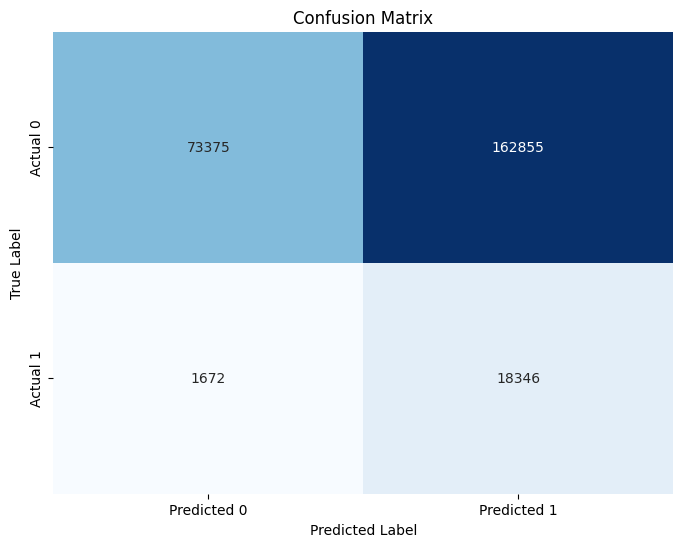

In [40]:
#GNN V 26-11
import os
import torch
import torch.nn.functional as F
import seaborn as sns
from torch_geometric.nn import MessagePassing
from torch_geometric.data import Data
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

# Load edge data
edge_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\2--12\extractedcolumns1.txt"
edges = np.loadtxt(edge_file, dtype=int)

# Load node features
feature_folder = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\2--12\features"
node_features_list = []

for file_name in os.listdir(feature_folder):
    if file_name.startswith("feature") and file_name.endswith(".txt"):
        file_path = os.path.join(feature_folder, file_name)
        try:
            feature_data = np.loadtxt(file_path, dtype=float)
            if feature_data.size == 0:
                print(f"Warning: {file_name} is empty. Skipping this file.")
            else:
                node_features_list.append(feature_data)
        except ValueError as e:
            print(f"Warning: Could not read {file_name}. Error: {e}")

if node_features_list:
    node_features = np.column_stack(node_features_list)
else:
    raise ValueError("No valid feature files found. Please check your input files.")

# Load labels
labels_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\2--12\node_contract_status_connected.txt"
labels = torch.tensor(np.loadtxt(labels_file, dtype=int), dtype=torch.long)

print(f"Node features shape: {node_features.shape}")
print(f"Labels shape: {labels.shape}")

# Create graph
G = nx.DiGraph()
G.add_edges_from(edges)

edge_index = torch.tensor(list(G.edges), dtype=torch.long).t().contiguous()

max_edge_index = edge_index.max()
num_nodes = node_features.shape[0]
print(f"Max edge index: {max_edge_index.item()}, Number of nodes: {num_nodes}")

if max_edge_index >= num_nodes:
    raise IndexError(f"Edge index {max_edge_index.item()} is out of bounds for number of nodes {num_nodes}.")

data = Data(x=torch.tensor(node_features, dtype=torch.float), y=labels, edge_index=edge_index)

# Define custom GNN layer
class CustomGNNLayer(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(CustomGNNLayer, self).__init__(aggr="add")  # "add" aggregation
        self.lin = torch.nn.Linear(in_channels, out_channels)

    def forward(self, x, edge_index):
        # x: Node features, edge_index: Connectivity
        x = self.lin(x)  # Apply linear transformation
        return self.propagate(edge_index, x=x)

    def message(self, x_j):
        # x_j: Features of neighboring nodes
        return x_j

    def update(self, aggr_out):
        # Update node features with aggregated messages
        return aggr_out

# Define GNN model
class GNN(torch.nn.Module):
    def __init__(self):
        super(GNN, self).__init__()
        self.conv1 = CustomGNNLayer(data.num_node_features, 16)
        self.conv2 = CustomGNNLayer(16, 16)
        self.conv3 = CustomGNNLayer(16, 2)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)
        return x

model = GNN()

# Class weights for imbalanced classes
class_counts = torch.bincount(data.y)
class_weights = 1.0 / torch.sqrt(class_counts.float() + 1e-6)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training mask
y_0_indices = (data.y == 0).nonzero(as_tuple=True)[0]
y_1_indices = (data.y == 1).nonzero(as_tuple=True)[0]
train_indices = torch.cat([y_0_indices, y_1_indices])
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[train_indices] = True

# Load new features and labels for validation
new_feature_folder = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\26-11\features"
new_labels_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\26-11\node_contract_status_connected.txt" 
new_edge_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\26-11\extractedcolumns1.txt" 

new_node_features_list = []
for file_name in os.listdir(new_feature_folder):
    if file_name.startswith("feature") and file_name.endswith(".txt"):
        file_path = os.path.join(new_feature_folder, file_name)
        try:
            feature_data = np.loadtxt(file_path, dtype=float)
            if feature_data.size == 0:
                print(f"Warning: {file_name} is empty. Skipping this file.")
            else:
                new_node_features_list.append(feature_data)
        except ValueError as e:
            print(f"Warning: Could not read {file_name}. Error: {e}")

if new_node_features_list:
    new_node_features = np.column_stack(new_node_features_list)
    new_labels = torch.tensor(np.loadtxt(new_labels_file, dtype=int), dtype=torch.long)
else:
    raise ValueError("No valid new feature files found. Please check your input files.")

new_edges = np.loadtxt(new_edge_file, dtype=int)
new_edge_index = torch.tensor(list(new_edges), dtype=torch.long).t().contiguous()

# Training and validation
validation_accuracies = []
train_accuracies = []
loss_values = []

for epoch in range(500):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[train_mask], data.y[train_mask])
    loss.backward()
    optimizer.step()

    pred_train = out.argmax(dim=1)
    train_acc = (pred_train[train_mask] == data.y[train_mask]).sum().item() / train_mask.sum().item()

    model.eval()
    with torch.no_grad():
        out_val = model(torch.tensor(new_node_features, dtype=torch.float), new_edge_index)
        pred_val = out_val.argmax(dim=1)
        val_acc = (pred_val == new_labels).sum().item() / new_labels.size(0)

    loss_values.append(loss.item())
    train_accuracies.append(train_acc)
    validation_accuracies.append(val_acc)

    if epoch % 10 == 0:
        print(f'Epoch {epoch:>3} | Loss: {loss.item():.4f} | Train Accuracy: {train_acc*100:.2f}% | Validation Accuracy: {val_acc*100:.2f}%')

# Loss and accuracy plots
plt.figure(figsize=(10, 6))
plt.plot(range(500), loss_values, label="Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Epoch vs Loss")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range(500), train_accuracies, label="Train Accuracy", color='blue')
plt.plot(range(500), validation_accuracies, label="Validation Accuracy", color='green')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train and Validation Accuracy vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

# Evaluation
model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index)
    y_pred = out.argmax(dim=1).cpu().numpy()
    y_true = data.y.cpu().numpy()

conf_matrix = confusion_matrix(y_true[train_mask], y_pred[train_mask])
precision = precision_score(y_true[train_mask], y_pred[train_mask], average='binary', zero_division=0)
recall = recall_score(y_true[train_mask], y_pred[train_mask], average='binary', zero_division=0)
f1 = f1_score(y_true[train_mask], y_pred[train_mask], average='binary', zero_division=0)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


Node features shape: (256248, 6)
Labels shape: torch.Size([256248])
Max edge index: 256247, Number of nodes: 256248
Epoch   0 | Loss: 0.6962 | Train Accuracy: 50.64% | Validation Accuracy: 71.16%
Epoch  10 | Loss: 0.5197 | Train Accuracy: 92.19% | Validation Accuracy: 93.75%
Epoch  20 | Loss: 0.4550 | Train Accuracy: 88.77% | Validation Accuracy: 91.79%
Epoch  30 | Loss: 0.4187 | Train Accuracy: 89.69% | Validation Accuracy: 91.78%
Epoch  40 | Loss: 0.3959 | Train Accuracy: 89.99% | Validation Accuracy: 91.52%
Epoch  50 | Loss: 0.3775 | Train Accuracy: 89.95% | Validation Accuracy: 91.45%
Epoch  60 | Loss: 0.3646 | Train Accuracy: 89.92% | Validation Accuracy: 91.41%
Epoch  70 | Loss: 0.3541 | Train Accuracy: 90.29% | Validation Accuracy: 91.49%
Epoch  80 | Loss: 0.3463 | Train Accuracy: 93.59% | Validation Accuracy: 91.43%
Epoch  90 | Loss: 0.3405 | Train Accuracy: 93.42% | Validation Accuracy: 91.43%
Epoch 100 | Loss: 0.3362 | Train Accuracy: 93.43% | Validation Accuracy: 91.46%
Epoc

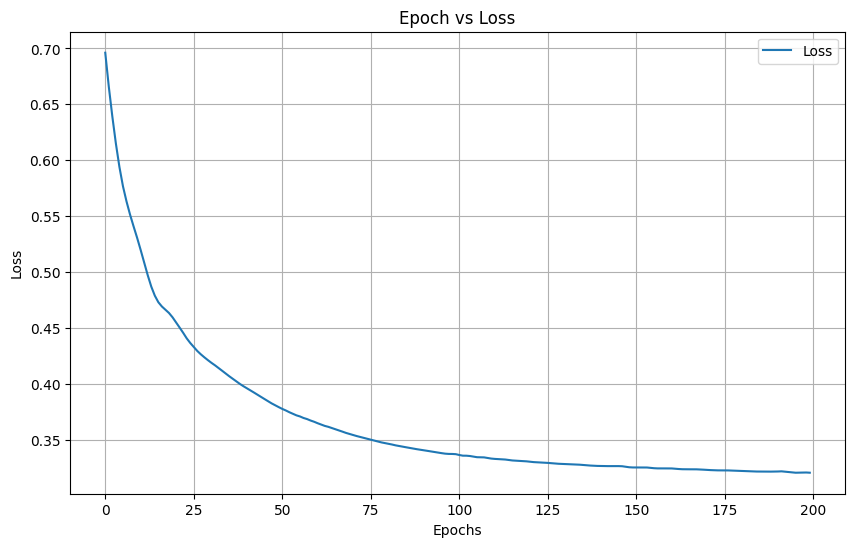

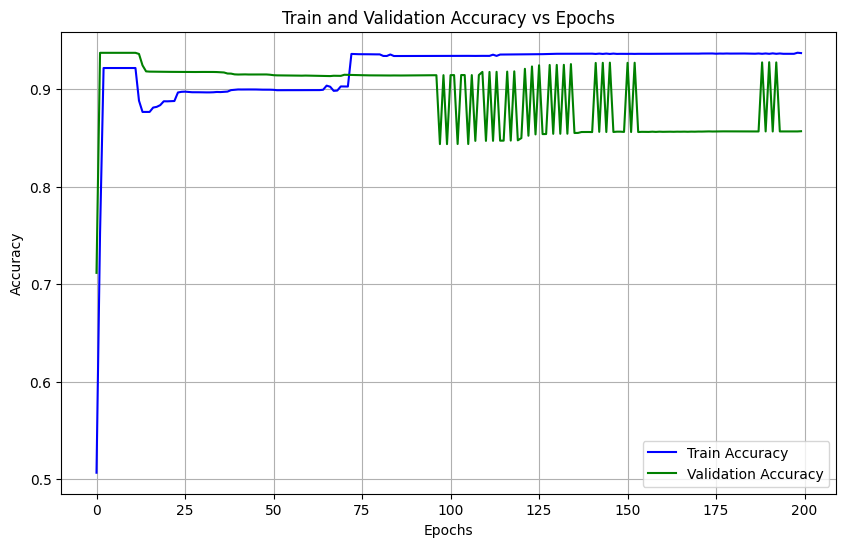

Precision: 0.6234
Recall: 0.5105
F1 Score: 0.5614


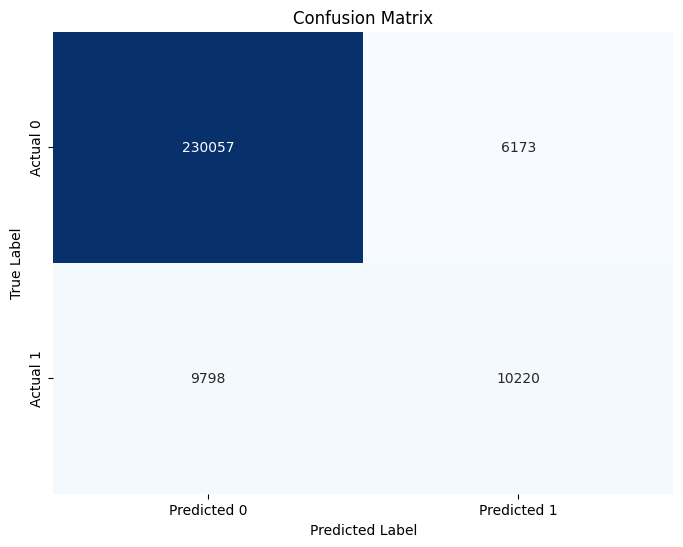

In [39]:
#GRAPHSAGE V 7-11
import os
import torch
import torch.nn.functional as F
import seaborn as sns
from torch_geometric.nn import SAGEConv
from torch_geometric.data import Data
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

# Load edge data
edge_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\2--12\extractedcolumns1.txt"
edges = np.loadtxt(edge_file, dtype=int)

# Load node features
feature_folder = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\2--12\features"
node_features_list = []

for file_name in os.listdir(feature_folder):
    if file_name.startswith("feature") and file_name.endswith(".txt"):
        file_path = os.path.join(feature_folder, file_name)
        try:
            feature_data = np.loadtxt(file_path, dtype=float)
            if feature_data.size == 0:
                print(f"Warning: {file_name} is empty. Skipping this file.")
            else:
                node_features_list.append(feature_data)
        except ValueError as e:
            print(f"Warning: Could not read {file_name}. Error: {e}")

if node_features_list:
    node_features = np.column_stack(node_features_list)
else:
    raise ValueError("No valid feature files found. Please check your input files.")

# Load labels
labels_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\2--12\node_contract_status_connected.txt"
labels = torch.tensor(np.loadtxt(labels_file, dtype=int), dtype=torch.long)

print(f"Node features shape: {node_features.shape}")
print(f"Labels shape: {labels.shape}")

# Create graph
G = nx.DiGraph()
G.add_edges_from(edges)

edge_index = torch.tensor(list(G.edges), dtype=torch.long).t().contiguous()

max_edge_index = edge_index.max()
num_nodes = node_features.shape[0]
print(f"Max edge index: {max_edge_index.item()}, Number of nodes: {num_nodes}")

if max_edge_index >= num_nodes:
    raise IndexError(f"Edge index {max_edge_index.item()} is out of bounds for number of nodes {num_nodes}.")

data = Data(x=torch.tensor(node_features, dtype=torch.float), y=labels, edge_index=edge_index)

# Define GraphSAGE model
class GraphSAGE(torch.nn.Module):
    def __init__(self):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(data.num_node_features, 16)
        self.conv2 = SAGEConv(16, 16)
        self.conv3 = SAGEConv(16, 2)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)
        return x

model = GraphSAGE()

# Class weights for imbalanced classes
class_counts = torch.bincount(data.y)
class_weights = 1.0 / torch.sqrt(class_counts.float() + 1e-6)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training mask
y_0_indices = (data.y == 0).nonzero(as_tuple=True)[0]
y_1_indices = (data.y == 1).nonzero(as_tuple=True)[0]
train_indices = torch.cat([y_0_indices, y_1_indices])
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[train_indices] = True

# Load new features and labels for validation
new_feature_folder = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\7-11\features"
new_labels_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\7-11\node_contract_status_connected.txt" 
new_edge_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\7-11\extractedcolumns1.txt" 

new_node_features_list = []
for file_name in os.listdir(new_feature_folder):
    if file_name.startswith("feature") and file_name.endswith(".txt"):
        file_path = os.path.join(new_feature_folder, file_name)
        try:
            feature_data = np.loadtxt(file_path, dtype=float)
            if feature_data.size == 0:
                print(f"Warning: {file_name} is empty. Skipping this file.")
            else:
                new_node_features_list.append(feature_data)
        except ValueError as e:
            print(f"Warning: Could not read {file_name}. Error: {e}")

if new_node_features_list:
    new_node_features = np.column_stack(new_node_features_list)
    new_labels = torch.tensor(np.loadtxt(new_labels_file, dtype=int), dtype=torch.long)
else:
    raise ValueError("No valid new feature files found. Please check your input files.")

new_edges = np.loadtxt(new_edge_file, dtype=int)
new_edge_index = torch.tensor(list(new_edges), dtype=torch.long).t().contiguous()

# Training and validation
validation_accuracies = []
train_accuracies = []
loss_values = []

for epoch in range(200):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[train_mask], data.y[train_mask])
    loss.backward()
    optimizer.step()

    pred_train = out.argmax(dim=1)
    train_acc = (pred_train[train_mask] == data.y[train_mask]).sum().item() / train_mask.sum().item()

    model.eval()
    with torch.no_grad():
        out_val = model(torch.tensor(new_node_features, dtype=torch.float), new_edge_index)
        pred_val = out_val.argmax(dim=1)
        val_acc = (pred_val == new_labels).sum().item() / new_labels.size(0)

    loss_values.append(loss.item())
    train_accuracies.append(train_acc)
    validation_accuracies.append(val_acc)

    if epoch % 10 == 0:
        print(f'Epoch {epoch:>3} | Loss: {loss.item():.4f} | Train Accuracy: {train_acc*100:.2f}% | Validation Accuracy: {val_acc*100:.2f}%')

# Loss and accuracy plots
plt.figure(figsize=(10, 6))
plt.plot(range(200), loss_values, label="Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Epoch vs Loss")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range(200), train_accuracies, label="Train Accuracy", color='blue')
plt.plot(range(200), validation_accuracies, label="Validation Accuracy", color='green')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train and Validation Accuracy vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

# Evaluation
model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index)
    y_pred = out.argmax(dim=1).cpu().numpy()
    y_true = data.y.cpu().numpy()

conf_matrix = confusion_matrix(y_true[train_mask], y_pred[train_mask])
precision = precision_score(y_true[train_mask], y_pred[train_mask], average='binary', zero_division=0)
recall = recall_score(y_true[train_mask], y_pred[train_mask], average='binary', zero_division=0)
f1 = f1_score(y_true[train_mask], y_pred[train_mask], average='binary', zero_division=0)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


Node features shape: (256248, 6)
Labels shape: torch.Size([256248])
Max edge index: 256247, Number of nodes: 256248
Epoch   0 | Loss: 0.7779 | Train Accuracy: 7.81% | Validation Accuracy: 6.27%
Epoch  10 | Loss: 0.5762 | Train Accuracy: 92.19% | Validation Accuracy: 93.73%
Epoch  20 | Loss: 0.5051 | Train Accuracy: 92.19% | Validation Accuracy: 93.73%
Epoch  30 | Loss: 0.4528 | Train Accuracy: 88.24% | Validation Accuracy: 92.14%
Epoch  40 | Loss: 0.4363 | Train Accuracy: 88.81% | Validation Accuracy: 92.15%
Epoch  50 | Loss: 0.4197 | Train Accuracy: 88.79% | Validation Accuracy: 92.57%
Epoch  60 | Loss: 0.4045 | Train Accuracy: 88.80% | Validation Accuracy: 92.56%
Epoch  70 | Loss: 0.3891 | Train Accuracy: 89.79% | Validation Accuracy: 92.55%
Epoch  80 | Loss: 0.3741 | Train Accuracy: 90.26% | Validation Accuracy: 92.76%
Epoch  90 | Loss: 0.3589 | Train Accuracy: 90.38% | Validation Accuracy: 93.56%
Epoch 100 | Loss: 0.3465 | Train Accuracy: 93.71% | Validation Accuracy: 93.51%
Epoch 

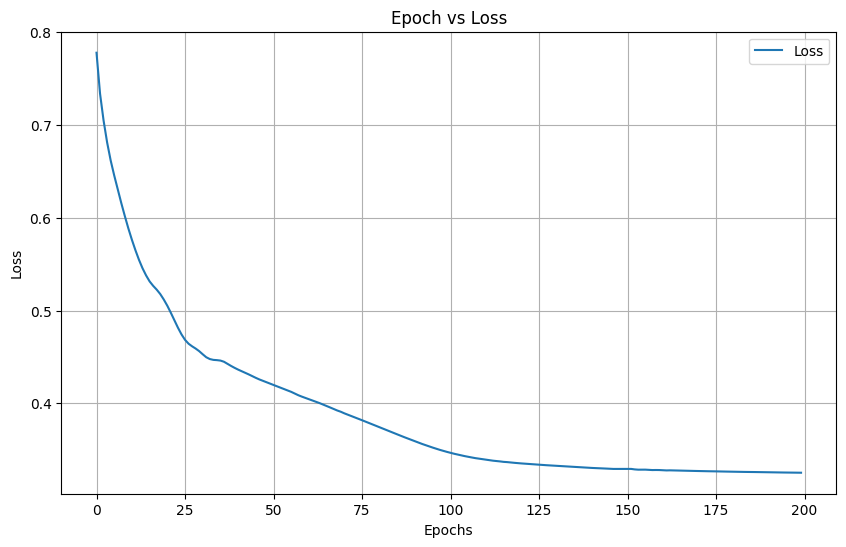

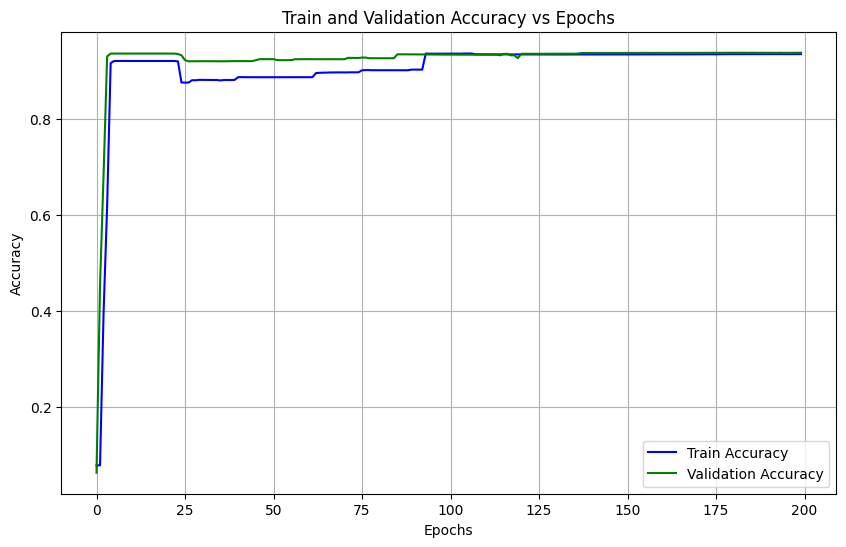

Precision: 0.6123
Recall: 0.5010
F1 Score: 0.5511


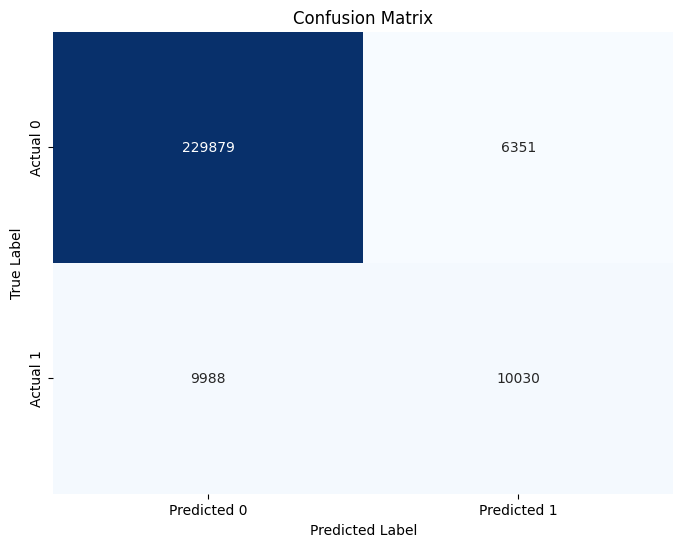

In [38]:
#GRAPHSAGE V 8-11
import os
import torch
import torch.nn.functional as F
import seaborn as sns
from torch_geometric.nn import SAGEConv
from torch_geometric.data import Data
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

# Load edge data
edge_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\2--12\extractedcolumns1.txt"
edges = np.loadtxt(edge_file, dtype=int)

# Load node features
feature_folder = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\2--12\features"
node_features_list = []

for file_name in os.listdir(feature_folder):
    if file_name.startswith("feature") and file_name.endswith(".txt"):
        file_path = os.path.join(feature_folder, file_name)
        try:
            feature_data = np.loadtxt(file_path, dtype=float)
            if feature_data.size == 0:
                print(f"Warning: {file_name} is empty. Skipping this file.")
            else:
                node_features_list.append(feature_data)
        except ValueError as e:
            print(f"Warning: Could not read {file_name}. Error: {e}")

if node_features_list:
    node_features = np.column_stack(node_features_list)
else:
    raise ValueError("No valid feature files found. Please check your input files.")

# Load labels
labels_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\2--12\node_contract_status_connected.txt"
labels = torch.tensor(np.loadtxt(labels_file, dtype=int), dtype=torch.long)

print(f"Node features shape: {node_features.shape}")
print(f"Labels shape: {labels.shape}")

# Create graph
G = nx.DiGraph()
G.add_edges_from(edges)

edge_index = torch.tensor(list(G.edges), dtype=torch.long).t().contiguous()

max_edge_index = edge_index.max()
num_nodes = node_features.shape[0]
print(f"Max edge index: {max_edge_index.item()}, Number of nodes: {num_nodes}")

if max_edge_index >= num_nodes:
    raise IndexError(f"Edge index {max_edge_index.item()} is out of bounds for number of nodes {num_nodes}.")

data = Data(x=torch.tensor(node_features, dtype=torch.float), y=labels, edge_index=edge_index)

# Define GraphSAGE model
class GraphSAGE(torch.nn.Module):
    def __init__(self):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(data.num_node_features, 16)
        self.conv2 = SAGEConv(16, 16)
        self.conv3 = SAGEConv(16, 2)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)
        return x

model = GraphSAGE()

# Class weights for imbalanced classes
class_counts = torch.bincount(data.y)
class_weights = 1.0 / torch.sqrt(class_counts.float() + 1e-6)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training mask
y_0_indices = (data.y == 0).nonzero(as_tuple=True)[0]
y_1_indices = (data.y == 1).nonzero(as_tuple=True)[0]
train_indices = torch.cat([y_0_indices, y_1_indices])
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[train_indices] = True

# Load new features and labels for validation
new_feature_folder = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\8-11\features"
new_labels_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\8-11\node_contract_status_connected.txt" 
new_edge_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\8-11\extractedcolumns1.txt" 

new_node_features_list = []
for file_name in os.listdir(new_feature_folder):
    if file_name.startswith("feature") and file_name.endswith(".txt"):
        file_path = os.path.join(new_feature_folder, file_name)
        try:
            feature_data = np.loadtxt(file_path, dtype=float)
            if feature_data.size == 0:
                print(f"Warning: {file_name} is empty. Skipping this file.")
            else:
                new_node_features_list.append(feature_data)
        except ValueError as e:
            print(f"Warning: Could not read {file_name}. Error: {e}")

if new_node_features_list:
    new_node_features = np.column_stack(new_node_features_list)
    new_labels = torch.tensor(np.loadtxt(new_labels_file, dtype=int), dtype=torch.long)
else:
    raise ValueError("No valid new feature files found. Please check your input files.")

new_edges = np.loadtxt(new_edge_file, dtype=int)
new_edge_index = torch.tensor(list(new_edges), dtype=torch.long).t().contiguous()

# Training and validation
validation_accuracies = []
train_accuracies = []
loss_values = []

for epoch in range(200):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[train_mask], data.y[train_mask])
    loss.backward()
    optimizer.step()

    pred_train = out.argmax(dim=1)
    train_acc = (pred_train[train_mask] == data.y[train_mask]).sum().item() / train_mask.sum().item()

    model.eval()
    with torch.no_grad():
        out_val = model(torch.tensor(new_node_features, dtype=torch.float), new_edge_index)
        pred_val = out_val.argmax(dim=1)
        val_acc = (pred_val == new_labels).sum().item() / new_labels.size(0)

    loss_values.append(loss.item())
    train_accuracies.append(train_acc)
    validation_accuracies.append(val_acc)

    if epoch % 10 == 0:
        print(f'Epoch {epoch:>3} | Loss: {loss.item():.4f} | Train Accuracy: {train_acc*100:.2f}% | Validation Accuracy: {val_acc*100:.2f}%')

# Loss and accuracy plots
plt.figure(figsize=(10, 6))
plt.plot(range(200), loss_values, label="Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Epoch vs Loss")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range(200), train_accuracies, label="Train Accuracy", color='blue')
plt.plot(range(200), validation_accuracies, label="Validation Accuracy", color='green')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train and Validation Accuracy vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

# Evaluation
model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index)
    y_pred = out.argmax(dim=1).cpu().numpy()
    y_true = data.y.cpu().numpy()

conf_matrix = confusion_matrix(y_true[train_mask], y_pred[train_mask])
precision = precision_score(y_true[train_mask], y_pred[train_mask], average='binary', zero_division=0)
recall = recall_score(y_true[train_mask], y_pred[train_mask], average='binary', zero_division=0)
f1 = f1_score(y_true[train_mask], y_pred[train_mask], average='binary', zero_division=0)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


Node features shape: (256248, 6)
Labels shape: torch.Size([256248])
Max edge index: 256247, Number of nodes: 256248
Epoch   0 | Loss: 0.6564 | Train Accuracy: 87.91% | Validation Accuracy: 92.35%
Epoch  10 | Loss: 0.5149 | Train Accuracy: 92.19% | Validation Accuracy: 92.43%
Epoch  20 | Loss: 0.4580 | Train Accuracy: 88.15% | Validation Accuracy: 90.64%
Epoch  30 | Loss: 0.4370 | Train Accuracy: 88.16% | Validation Accuracy: 91.19%
Epoch  40 | Loss: 0.4120 | Train Accuracy: 89.92% | Validation Accuracy: 91.62%
Epoch  50 | Loss: 0.3829 | Train Accuracy: 90.33% | Validation Accuracy: 92.50%
Epoch  60 | Loss: 0.3537 | Train Accuracy: 93.81% | Validation Accuracy: 92.48%
Epoch  70 | Loss: 0.3388 | Train Accuracy: 93.63% | Validation Accuracy: 92.20%
Epoch  80 | Loss: 0.3322 | Train Accuracy: 93.65% | Validation Accuracy: 92.13%
Epoch  90 | Loss: 0.3293 | Train Accuracy: 93.67% | Validation Accuracy: 92.15%
Epoch 100 | Loss: 0.3270 | Train Accuracy: 93.70% | Validation Accuracy: 92.19%
Epoc

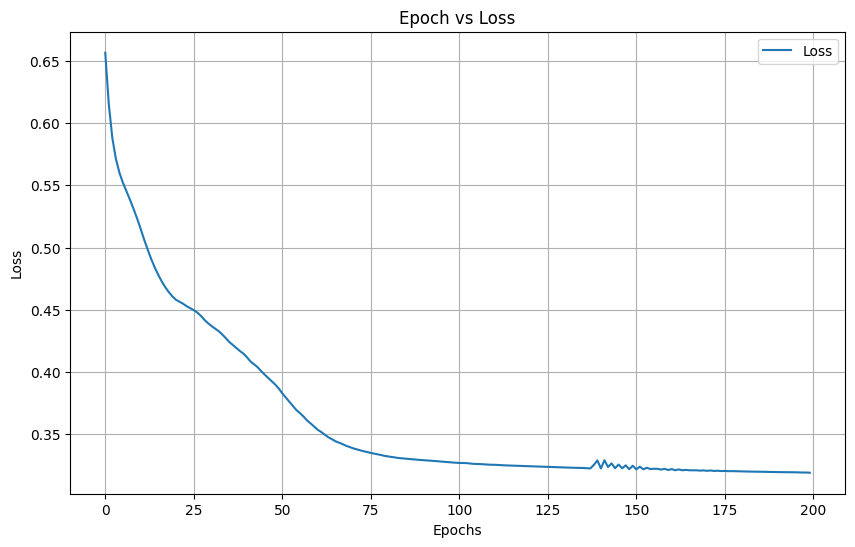

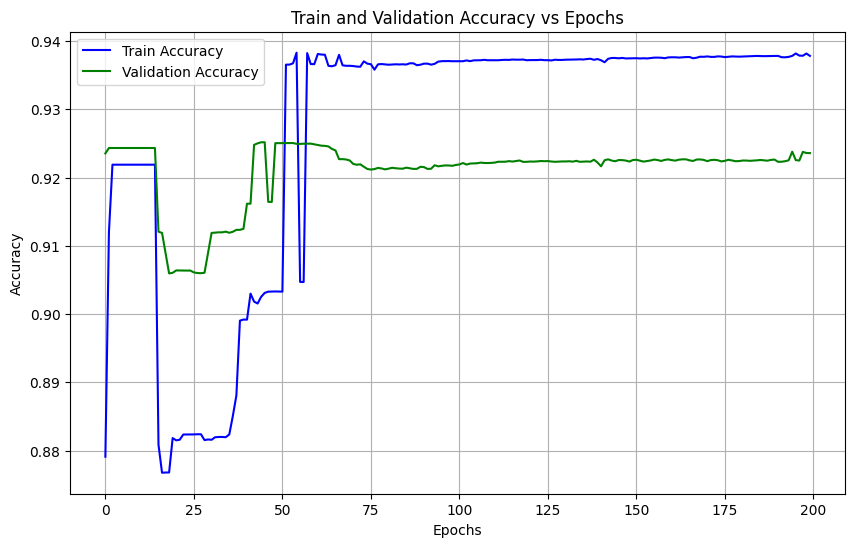

Precision: 0.6255
Recall: 0.5079
F1 Score: 0.5606


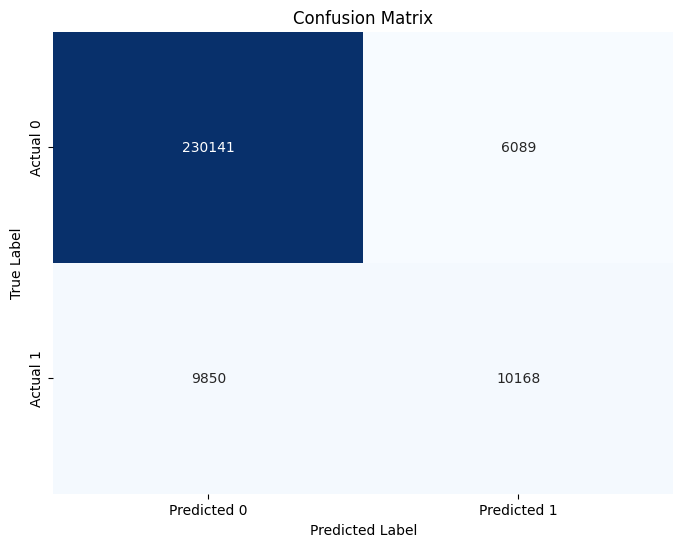

In [37]:
#GRAPHSAGE V 12-11
import os
import torch
import torch.nn.functional as F
import seaborn as sns
from torch_geometric.nn import SAGEConv
from torch_geometric.data import Data
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

# Load edge data
edge_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\2--12\extractedcolumns1.txt"
edges = np.loadtxt(edge_file, dtype=int)

# Load node features
feature_folder = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\2--12\features"
node_features_list = []

for file_name in os.listdir(feature_folder):
    if file_name.startswith("feature") and file_name.endswith(".txt"):
        file_path = os.path.join(feature_folder, file_name)
        try:
            feature_data = np.loadtxt(file_path, dtype=float)
            if feature_data.size == 0:
                print(f"Warning: {file_name} is empty. Skipping this file.")
            else:
                node_features_list.append(feature_data)
        except ValueError as e:
            print(f"Warning: Could not read {file_name}. Error: {e}")

if node_features_list:
    node_features = np.column_stack(node_features_list)
else:
    raise ValueError("No valid feature files found. Please check your input files.")

# Load labels
labels_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\2--12\node_contract_status_connected.txt"
labels = torch.tensor(np.loadtxt(labels_file, dtype=int), dtype=torch.long)

print(f"Node features shape: {node_features.shape}")
print(f"Labels shape: {labels.shape}")

# Create graph
G = nx.DiGraph()
G.add_edges_from(edges)

edge_index = torch.tensor(list(G.edges), dtype=torch.long).t().contiguous()

max_edge_index = edge_index.max()
num_nodes = node_features.shape[0]
print(f"Max edge index: {max_edge_index.item()}, Number of nodes: {num_nodes}")

if max_edge_index >= num_nodes:
    raise IndexError(f"Edge index {max_edge_index.item()} is out of bounds for number of nodes {num_nodes}.")

data = Data(x=torch.tensor(node_features, dtype=torch.float), y=labels, edge_index=edge_index)

# Define GraphSAGE model
class GraphSAGE(torch.nn.Module):
    def __init__(self):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(data.num_node_features, 16)
        self.conv2 = SAGEConv(16, 16)
        self.conv3 = SAGEConv(16, 2)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)
        return x

model = GraphSAGE()

# Class weights for imbalanced classes
class_counts = torch.bincount(data.y)
class_weights = 1.0 / torch.sqrt(class_counts.float() + 1e-6)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training mask
y_0_indices = (data.y == 0).nonzero(as_tuple=True)[0]
y_1_indices = (data.y == 1).nonzero(as_tuple=True)[0]
train_indices = torch.cat([y_0_indices, y_1_indices])
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[train_indices] = True

# Load new features and labels for validation
new_feature_folder = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\12-11\features"
new_labels_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\12-11\node_contract_status_connected.txt" 
new_edge_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\12-11\extractedcolumns1.txt" 

new_node_features_list = []
for file_name in os.listdir(new_feature_folder):
    if file_name.startswith("feature") and file_name.endswith(".txt"):
        file_path = os.path.join(new_feature_folder, file_name)
        try:
            feature_data = np.loadtxt(file_path, dtype=float)
            if feature_data.size == 0:
                print(f"Warning: {file_name} is empty. Skipping this file.")
            else:
                new_node_features_list.append(feature_data)
        except ValueError as e:
            print(f"Warning: Could not read {file_name}. Error: {e}")

if new_node_features_list:
    new_node_features = np.column_stack(new_node_features_list)
    new_labels = torch.tensor(np.loadtxt(new_labels_file, dtype=int), dtype=torch.long)
else:
    raise ValueError("No valid new feature files found. Please check your input files.")

new_edges = np.loadtxt(new_edge_file, dtype=int)
new_edge_index = torch.tensor(list(new_edges), dtype=torch.long).t().contiguous()

# Training and validation
validation_accuracies = []
train_accuracies = []
loss_values = []

for epoch in range(200):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[train_mask], data.y[train_mask])
    loss.backward()
    optimizer.step()

    pred_train = out.argmax(dim=1)
    train_acc = (pred_train[train_mask] == data.y[train_mask]).sum().item() / train_mask.sum().item()

    model.eval()
    with torch.no_grad():
        out_val = model(torch.tensor(new_node_features, dtype=torch.float), new_edge_index)
        pred_val = out_val.argmax(dim=1)
        val_acc = (pred_val == new_labels).sum().item() / new_labels.size(0)

    loss_values.append(loss.item())
    train_accuracies.append(train_acc)
    validation_accuracies.append(val_acc)

    if epoch % 10 == 0:
        print(f'Epoch {epoch:>3} | Loss: {loss.item():.4f} | Train Accuracy: {train_acc*100:.2f}% | Validation Accuracy: {val_acc*100:.2f}%')

# Loss and accuracy plots
plt.figure(figsize=(10, 6))
plt.plot(range(200), loss_values, label="Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Epoch vs Loss")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range(200), train_accuracies, label="Train Accuracy", color='blue')
plt.plot(range(200), validation_accuracies, label="Validation Accuracy", color='green')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train and Validation Accuracy vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

# Evaluation
model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index)
    y_pred = out.argmax(dim=1).cpu().numpy()
    y_true = data.y.cpu().numpy()

conf_matrix = confusion_matrix(y_true[train_mask], y_pred[train_mask])
precision = precision_score(y_true[train_mask], y_pred[train_mask], average='binary', zero_division=0)
recall = recall_score(y_true[train_mask], y_pred[train_mask], average='binary', zero_division=0)
f1 = f1_score(y_true[train_mask], y_pred[train_mask], average='binary', zero_division=0)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


Node features shape: (256248, 6)
Labels shape: torch.Size([256248])
Max edge index: 256247, Number of nodes: 256248
Epoch   0 | Loss: 0.6745 | Train Accuracy: 59.68% | Validation Accuracy: 93.00%
Epoch  10 | Loss: 0.5288 | Train Accuracy: 92.19% | Validation Accuracy: 93.00%
Epoch  20 | Loss: 0.4679 | Train Accuracy: 88.50% | Validation Accuracy: 91.07%
Epoch  30 | Loss: 0.4366 | Train Accuracy: 89.79% | Validation Accuracy: 90.89%
Epoch  40 | Loss: 0.4104 | Train Accuracy: 89.76% | Validation Accuracy: 91.05%
Epoch  50 | Loss: 0.3866 | Train Accuracy: 90.32% | Validation Accuracy: 91.56%
Epoch  60 | Loss: 0.3647 | Train Accuracy: 90.32% | Validation Accuracy: 92.64%
Epoch  70 | Loss: 0.3471 | Train Accuracy: 93.73% | Validation Accuracy: 92.51%
Epoch  80 | Loss: 0.3361 | Train Accuracy: 93.47% | Validation Accuracy: 92.50%
Epoch  90 | Loss: 0.3307 | Train Accuracy: 93.45% | Validation Accuracy: 92.49%
Epoch 100 | Loss: 0.3281 | Train Accuracy: 93.48% | Validation Accuracy: 92.55%
Epoc

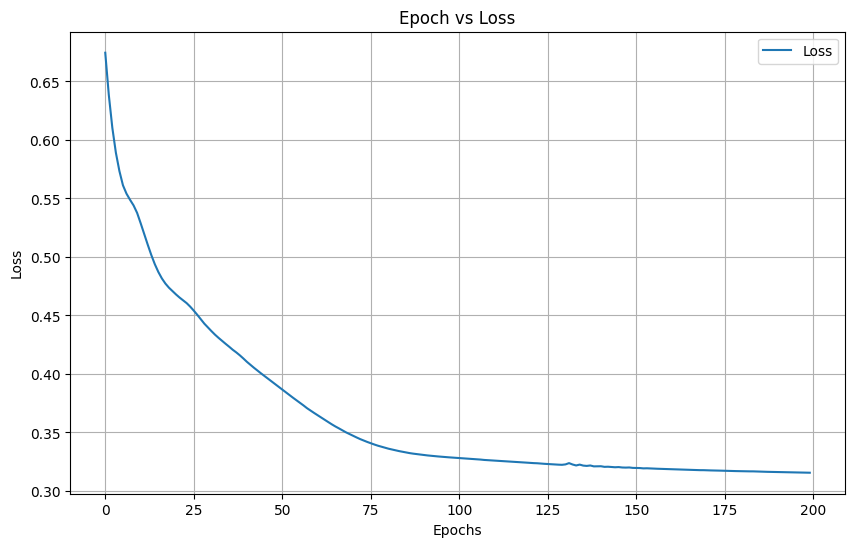

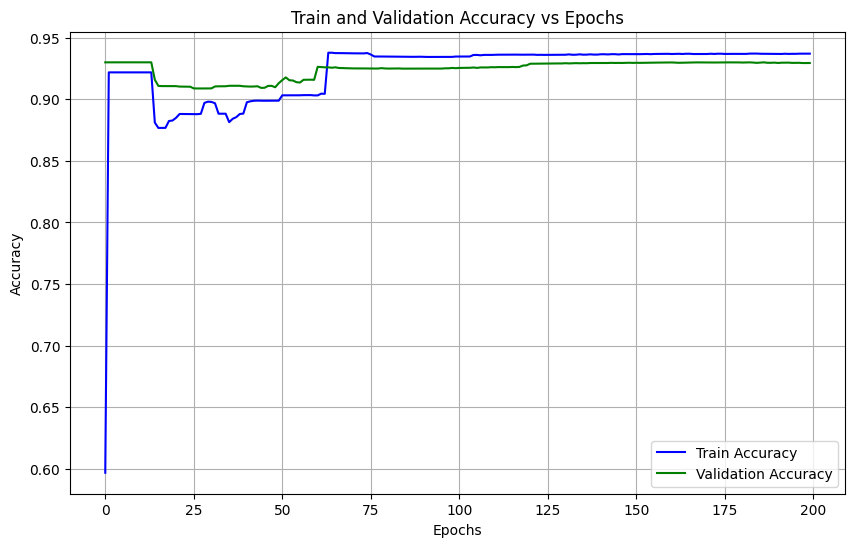

Precision: 0.6166
Recall: 0.5101
F1 Score: 0.5583


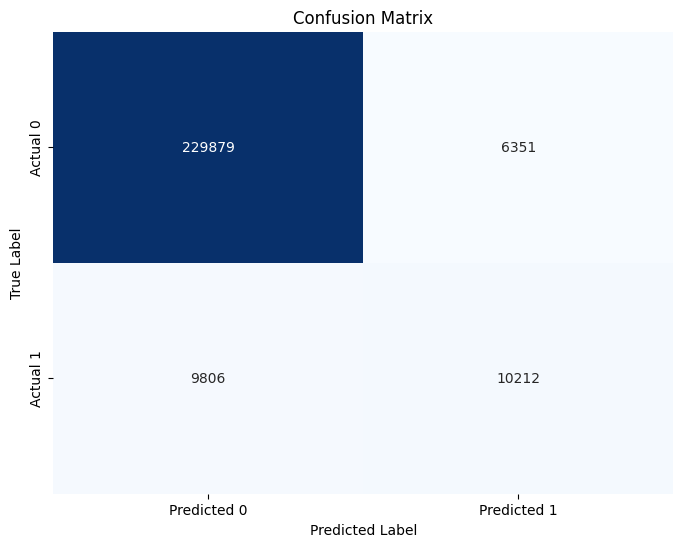

In [36]:
#GRAPHSAGE V 13-11
import os
import torch
import torch.nn.functional as F
import seaborn as sns
from torch_geometric.nn import SAGEConv
from torch_geometric.data import Data
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

# Load edge data
edge_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\2--12\extractedcolumns1.txt"
edges = np.loadtxt(edge_file, dtype=int)

# Load node features
feature_folder = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\2--12\features"
node_features_list = []

for file_name in os.listdir(feature_folder):
    if file_name.startswith("feature") and file_name.endswith(".txt"):
        file_path = os.path.join(feature_folder, file_name)
        try:
            feature_data = np.loadtxt(file_path, dtype=float)
            if feature_data.size == 0:
                print(f"Warning: {file_name} is empty. Skipping this file.")
            else:
                node_features_list.append(feature_data)
        except ValueError as e:
            print(f"Warning: Could not read {file_name}. Error: {e}")

if node_features_list:
    node_features = np.column_stack(node_features_list)
else:
    raise ValueError("No valid feature files found. Please check your input files.")

# Load labels
labels_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\2--12\node_contract_status_connected.txt"
labels = torch.tensor(np.loadtxt(labels_file, dtype=int), dtype=torch.long)

print(f"Node features shape: {node_features.shape}")
print(f"Labels shape: {labels.shape}")

# Create graph
G = nx.DiGraph()
G.add_edges_from(edges)

edge_index = torch.tensor(list(G.edges), dtype=torch.long).t().contiguous()

max_edge_index = edge_index.max()
num_nodes = node_features.shape[0]
print(f"Max edge index: {max_edge_index.item()}, Number of nodes: {num_nodes}")

if max_edge_index >= num_nodes:
    raise IndexError(f"Edge index {max_edge_index.item()} is out of bounds for number of nodes {num_nodes}.")

data = Data(x=torch.tensor(node_features, dtype=torch.float), y=labels, edge_index=edge_index)

# Define GraphSAGE model
class GraphSAGE(torch.nn.Module):
    def __init__(self):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(data.num_node_features, 16)
        self.conv2 = SAGEConv(16, 16)
        self.conv3 = SAGEConv(16, 2)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)
        return x

model = GraphSAGE()

# Class weights for imbalanced classes
class_counts = torch.bincount(data.y)
class_weights = 1.0 / torch.sqrt(class_counts.float() + 1e-6)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training mask
y_0_indices = (data.y == 0).nonzero(as_tuple=True)[0]
y_1_indices = (data.y == 1).nonzero(as_tuple=True)[0]
train_indices = torch.cat([y_0_indices, y_1_indices])
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[train_indices] = True

# Load new features and labels for validation
new_feature_folder = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\13-11\features"
new_labels_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\13-11\node_contract_status_connected.txt" 
new_edge_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\13-11\extractedcolumns1.txt" 

new_node_features_list = []
for file_name in os.listdir(new_feature_folder):
    if file_name.startswith("feature") and file_name.endswith(".txt"):
        file_path = os.path.join(new_feature_folder, file_name)
        try:
            feature_data = np.loadtxt(file_path, dtype=float)
            if feature_data.size == 0:
                print(f"Warning: {file_name} is empty. Skipping this file.")
            else:
                new_node_features_list.append(feature_data)
        except ValueError as e:
            print(f"Warning: Could not read {file_name}. Error: {e}")

if new_node_features_list:
    new_node_features = np.column_stack(new_node_features_list)
    new_labels = torch.tensor(np.loadtxt(new_labels_file, dtype=int), dtype=torch.long)
else:
    raise ValueError("No valid new feature files found. Please check your input files.")

new_edges = np.loadtxt(new_edge_file, dtype=int)
new_edge_index = torch.tensor(list(new_edges), dtype=torch.long).t().contiguous()

# Training and validation
validation_accuracies = []
train_accuracies = []
loss_values = []

for epoch in range(200):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[train_mask], data.y[train_mask])
    loss.backward()
    optimizer.step()

    pred_train = out.argmax(dim=1)
    train_acc = (pred_train[train_mask] == data.y[train_mask]).sum().item() / train_mask.sum().item()

    model.eval()
    with torch.no_grad():
        out_val = model(torch.tensor(new_node_features, dtype=torch.float), new_edge_index)
        pred_val = out_val.argmax(dim=1)
        val_acc = (pred_val == new_labels).sum().item() / new_labels.size(0)

    loss_values.append(loss.item())
    train_accuracies.append(train_acc)
    validation_accuracies.append(val_acc)

    if epoch % 10 == 0:
        print(f'Epoch {epoch:>3} | Loss: {loss.item():.4f} | Train Accuracy: {train_acc*100:.2f}% | Validation Accuracy: {val_acc*100:.2f}%')

# Loss and accuracy plots
plt.figure(figsize=(10, 6))
plt.plot(range(200), loss_values, label="Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Epoch vs Loss")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range(200), train_accuracies, label="Train Accuracy", color='blue')
plt.plot(range(200), validation_accuracies, label="Validation Accuracy", color='green')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train and Validation Accuracy vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

# Evaluation
model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index)
    y_pred = out.argmax(dim=1).cpu().numpy()
    y_true = data.y.cpu().numpy()

conf_matrix = confusion_matrix(y_true[train_mask], y_pred[train_mask])
precision = precision_score(y_true[train_mask], y_pred[train_mask], average='binary', zero_division=0)
recall = recall_score(y_true[train_mask], y_pred[train_mask], average='binary', zero_division=0)
f1 = f1_score(y_true[train_mask], y_pred[train_mask], average='binary', zero_division=0)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


Node features shape: (256248, 6)
Labels shape: torch.Size([256248])
Max edge index: 256247, Number of nodes: 256248
Epoch   0 | Loss: 0.6566 | Train Accuracy: 88.10% | Validation Accuracy: 92.34%
Epoch  10 | Loss: 0.5149 | Train Accuracy: 92.19% | Validation Accuracy: 92.34%
Epoch  20 | Loss: 0.4657 | Train Accuracy: 88.56% | Validation Accuracy: 91.46%
Epoch  30 | Loss: 0.4350 | Train Accuracy: 89.29% | Validation Accuracy: 91.49%
Epoch  40 | Loss: 0.4075 | Train Accuracy: 90.34% | Validation Accuracy: 92.39%
Epoch  50 | Loss: 0.3858 | Train Accuracy: 90.33% | Validation Accuracy: 92.37%
Epoch  60 | Loss: 0.3663 | Train Accuracy: 93.81% | Validation Accuracy: 92.35%
Epoch  70 | Loss: 0.3504 | Train Accuracy: 93.81% | Validation Accuracy: 92.33%
Epoch  80 | Loss: 0.3396 | Train Accuracy: 93.66% | Validation Accuracy: 92.27%
Epoch  90 | Loss: 0.3325 | Train Accuracy: 93.63% | Validation Accuracy: 92.22%
Epoch 100 | Loss: 0.3286 | Train Accuracy: 93.62% | Validation Accuracy: 92.07%
Epoc

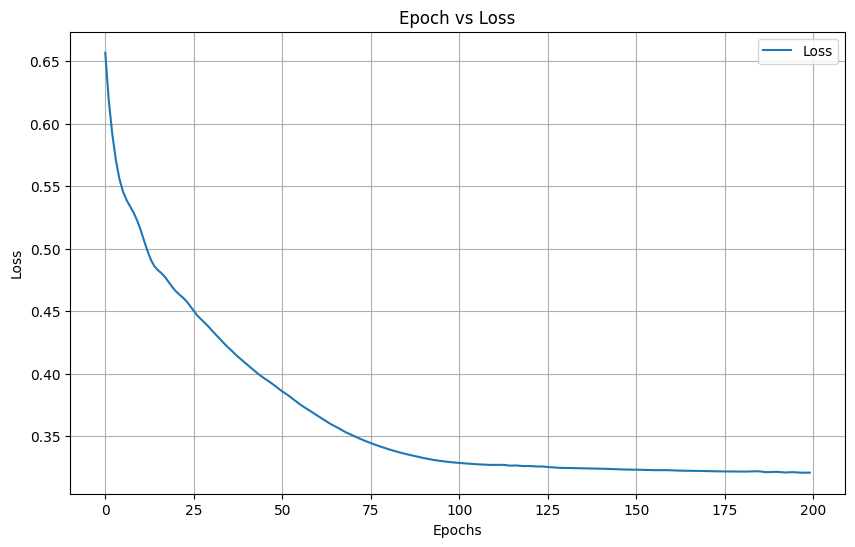

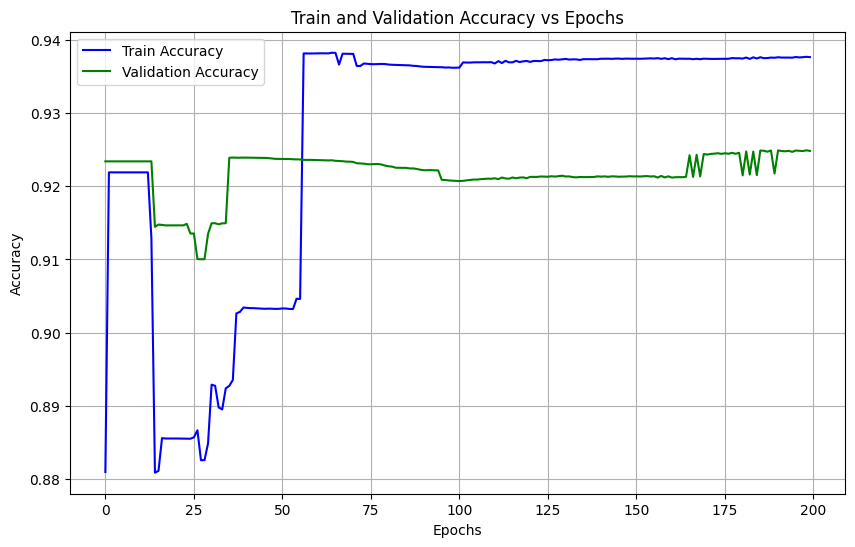

Precision: 0.6255
Recall: 0.5053
F1 Score: 0.5590


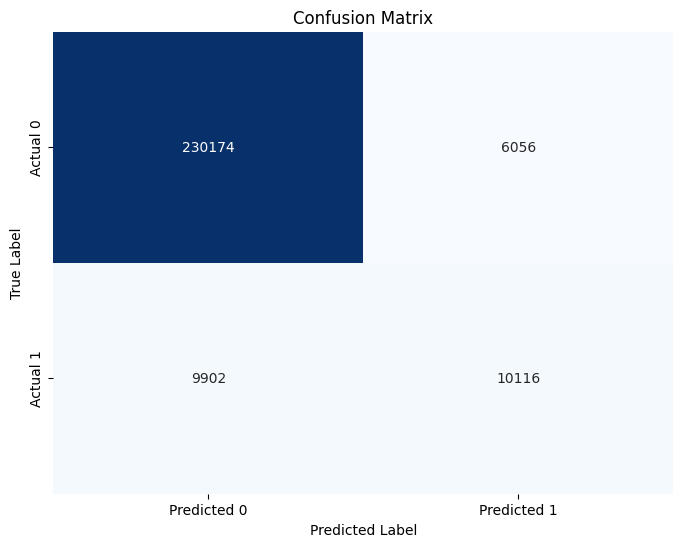

In [35]:
#GRAPHSAGE V 14-11
import os
import torch
import torch.nn.functional as F
import seaborn as sns
from torch_geometric.nn import SAGEConv
from torch_geometric.data import Data
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

# Load edge data
edge_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\2--12\extractedcolumns1.txt"
edges = np.loadtxt(edge_file, dtype=int)

# Load node features
feature_folder = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\2--12\features"
node_features_list = []

for file_name in os.listdir(feature_folder):
    if file_name.startswith("feature") and file_name.endswith(".txt"):
        file_path = os.path.join(feature_folder, file_name)
        try:
            feature_data = np.loadtxt(file_path, dtype=float)
            if feature_data.size == 0:
                print(f"Warning: {file_name} is empty. Skipping this file.")
            else:
                node_features_list.append(feature_data)
        except ValueError as e:
            print(f"Warning: Could not read {file_name}. Error: {e}")

if node_features_list:
    node_features = np.column_stack(node_features_list)
else:
    raise ValueError("No valid feature files found. Please check your input files.")

# Load labels
labels_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\2--12\node_contract_status_connected.txt"
labels = torch.tensor(np.loadtxt(labels_file, dtype=int), dtype=torch.long)

print(f"Node features shape: {node_features.shape}")
print(f"Labels shape: {labels.shape}")

# Create graph
G = nx.DiGraph()
G.add_edges_from(edges)

edge_index = torch.tensor(list(G.edges), dtype=torch.long).t().contiguous()

max_edge_index = edge_index.max()
num_nodes = node_features.shape[0]
print(f"Max edge index: {max_edge_index.item()}, Number of nodes: {num_nodes}")

if max_edge_index >= num_nodes:
    raise IndexError(f"Edge index {max_edge_index.item()} is out of bounds for number of nodes {num_nodes}.")

data = Data(x=torch.tensor(node_features, dtype=torch.float), y=labels, edge_index=edge_index)

# Define GraphSAGE model
class GraphSAGE(torch.nn.Module):
    def __init__(self):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(data.num_node_features, 16)
        self.conv2 = SAGEConv(16, 16)
        self.conv3 = SAGEConv(16, 2)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)
        return x

model = GraphSAGE()

# Class weights for imbalanced classes
class_counts = torch.bincount(data.y)
class_weights = 1.0 / torch.sqrt(class_counts.float() + 1e-6)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training mask
y_0_indices = (data.y == 0).nonzero(as_tuple=True)[0]
y_1_indices = (data.y == 1).nonzero(as_tuple=True)[0]
train_indices = torch.cat([y_0_indices, y_1_indices])
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[train_indices] = True

# Load new features and labels for validation
new_feature_folder = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\14-11\features"
new_labels_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\14-11\node_contract_status_connected.txt" 
new_edge_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\14-11\extractedcolumns1.txt" 

new_node_features_list = []
for file_name in os.listdir(new_feature_folder):
    if file_name.startswith("feature") and file_name.endswith(".txt"):
        file_path = os.path.join(new_feature_folder, file_name)
        try:
            feature_data = np.loadtxt(file_path, dtype=float)
            if feature_data.size == 0:
                print(f"Warning: {file_name} is empty. Skipping this file.")
            else:
                new_node_features_list.append(feature_data)
        except ValueError as e:
            print(f"Warning: Could not read {file_name}. Error: {e}")

if new_node_features_list:
    new_node_features = np.column_stack(new_node_features_list)
    new_labels = torch.tensor(np.loadtxt(new_labels_file, dtype=int), dtype=torch.long)
else:
    raise ValueError("No valid new feature files found. Please check your input files.")

new_edges = np.loadtxt(new_edge_file, dtype=int)
new_edge_index = torch.tensor(list(new_edges), dtype=torch.long).t().contiguous()

# Training and validation
validation_accuracies = []
train_accuracies = []
loss_values = []

for epoch in range(200):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[train_mask], data.y[train_mask])
    loss.backward()
    optimizer.step()

    pred_train = out.argmax(dim=1)
    train_acc = (pred_train[train_mask] == data.y[train_mask]).sum().item() / train_mask.sum().item()

    model.eval()
    with torch.no_grad():
        out_val = model(torch.tensor(new_node_features, dtype=torch.float), new_edge_index)
        pred_val = out_val.argmax(dim=1)
        val_acc = (pred_val == new_labels).sum().item() / new_labels.size(0)

    loss_values.append(loss.item())
    train_accuracies.append(train_acc)
    validation_accuracies.append(val_acc)

    if epoch % 10 == 0:
        print(f'Epoch {epoch:>3} | Loss: {loss.item():.4f} | Train Accuracy: {train_acc*100:.2f}% | Validation Accuracy: {val_acc*100:.2f}%')

# Loss and accuracy plots
plt.figure(figsize=(10, 6))
plt.plot(range(200), loss_values, label="Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Epoch vs Loss")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range(200), train_accuracies, label="Train Accuracy", color='blue')
plt.plot(range(200), validation_accuracies, label="Validation Accuracy", color='green')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train and Validation Accuracy vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

# Evaluation
model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index)
    y_pred = out.argmax(dim=1).cpu().numpy()
    y_true = data.y.cpu().numpy()

conf_matrix = confusion_matrix(y_true[train_mask], y_pred[train_mask])
precision = precision_score(y_true[train_mask], y_pred[train_mask], average='binary', zero_division=0)
recall = recall_score(y_true[train_mask], y_pred[train_mask], average='binary', zero_division=0)
f1 = f1_score(y_true[train_mask], y_pred[train_mask], average='binary', zero_division=0)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


Node features shape: (256248, 6)
Labels shape: torch.Size([256248])
Max edge index: 256247, Number of nodes: 256248
Epoch   0 | Loss: 0.7332 | Train Accuracy: 13.29% | Validation Accuracy: 38.65%
Epoch  10 | Loss: 0.5480 | Train Accuracy: 92.19% | Validation Accuracy: 93.51%
Epoch  20 | Loss: 0.4611 | Train Accuracy: 88.16% | Validation Accuracy: 91.46%
Epoch  30 | Loss: 0.4206 | Train Accuracy: 89.88% | Validation Accuracy: 91.07%
Epoch  40 | Loss: 0.3968 | Train Accuracy: 89.92% | Validation Accuracy: 90.95%
Epoch  50 | Loss: 0.3771 | Train Accuracy: 89.96% | Validation Accuracy: 90.94%
Epoch  60 | Loss: 0.3635 | Train Accuracy: 89.86% | Validation Accuracy: 90.52%
Epoch  70 | Loss: 0.3542 | Train Accuracy: 89.87% | Validation Accuracy: 91.58%
Epoch  80 | Loss: 0.3477 | Train Accuracy: 94.25% | Validation Accuracy: 91.57%
Epoch  90 | Loss: 0.3427 | Train Accuracy: 94.27% | Validation Accuracy: 90.86%
Epoch 100 | Loss: 0.3387 | Train Accuracy: 93.45% | Validation Accuracy: 89.00%
Epoc

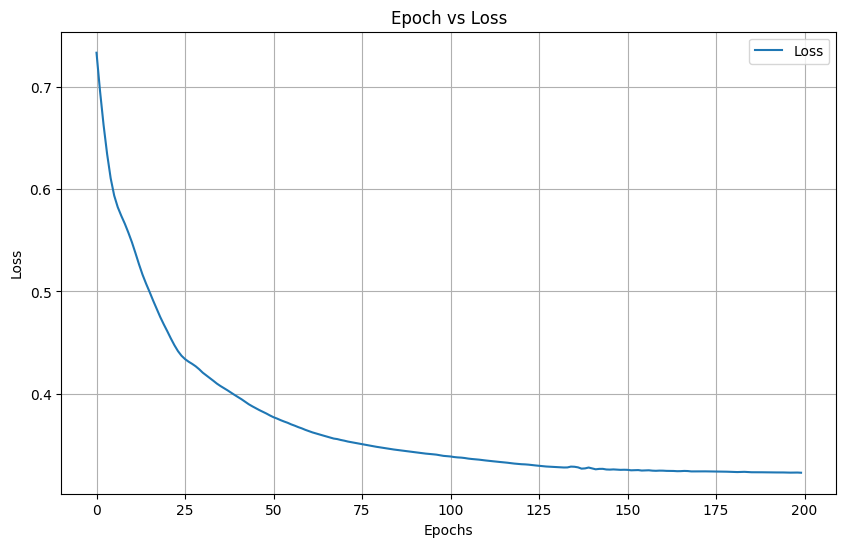

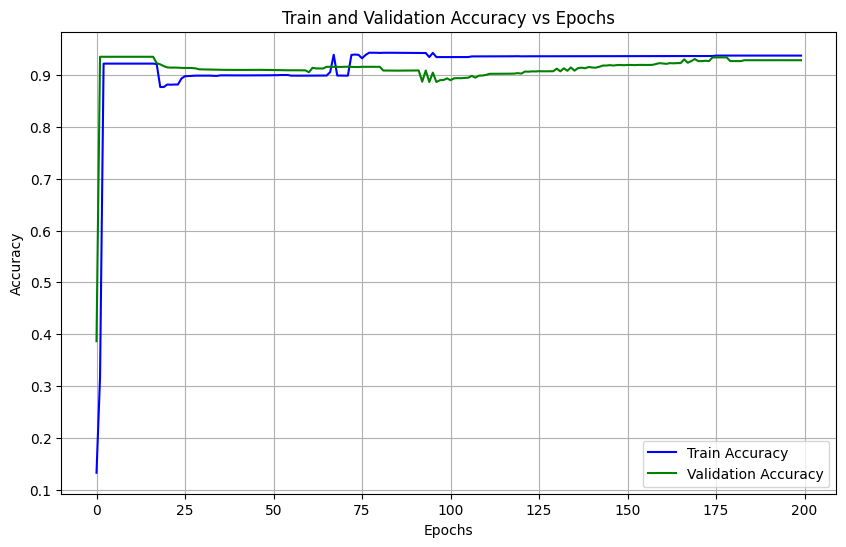

Precision: 0.6221
Recall: 0.5049
F1 Score: 0.5574


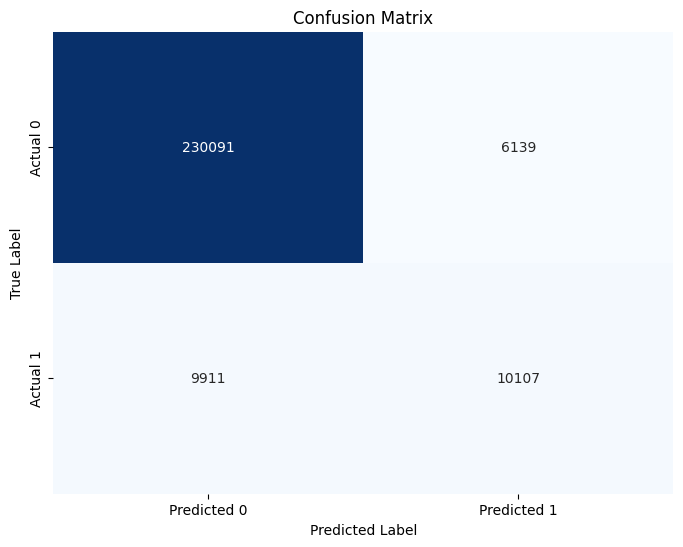

In [34]:
#GRAPHSAGE V 24-11
import os
import torch
import torch.nn.functional as F
import seaborn as sns
from torch_geometric.nn import SAGEConv
from torch_geometric.data import Data
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

# Load edge data
edge_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\2--12\extractedcolumns1.txt"
edges = np.loadtxt(edge_file, dtype=int)

# Load node features
feature_folder = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\2--12\features"
node_features_list = []

for file_name in os.listdir(feature_folder):
    if file_name.startswith("feature") and file_name.endswith(".txt"):
        file_path = os.path.join(feature_folder, file_name)
        try:
            feature_data = np.loadtxt(file_path, dtype=float)
            if feature_data.size == 0:
                print(f"Warning: {file_name} is empty. Skipping this file.")
            else:
                node_features_list.append(feature_data)
        except ValueError as e:
            print(f"Warning: Could not read {file_name}. Error: {e}")

if node_features_list:
    node_features = np.column_stack(node_features_list)
else:
    raise ValueError("No valid feature files found. Please check your input files.")

# Load labels
labels_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\2--12\node_contract_status_connected.txt"
labels = torch.tensor(np.loadtxt(labels_file, dtype=int), dtype=torch.long)

print(f"Node features shape: {node_features.shape}")
print(f"Labels shape: {labels.shape}")

# Create graph
G = nx.DiGraph()
G.add_edges_from(edges)

edge_index = torch.tensor(list(G.edges), dtype=torch.long).t().contiguous()

max_edge_index = edge_index.max()
num_nodes = node_features.shape[0]
print(f"Max edge index: {max_edge_index.item()}, Number of nodes: {num_nodes}")

if max_edge_index >= num_nodes:
    raise IndexError(f"Edge index {max_edge_index.item()} is out of bounds for number of nodes {num_nodes}.")

data = Data(x=torch.tensor(node_features, dtype=torch.float), y=labels, edge_index=edge_index)

# Define GraphSAGE model
class GraphSAGE(torch.nn.Module):
    def __init__(self):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(data.num_node_features, 16)
        self.conv2 = SAGEConv(16, 16)
        self.conv3 = SAGEConv(16, 2)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)
        return x

model = GraphSAGE()

# Class weights for imbalanced classes
class_counts = torch.bincount(data.y)
class_weights = 1.0 / torch.sqrt(class_counts.float() + 1e-6)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training mask
y_0_indices = (data.y == 0).nonzero(as_tuple=True)[0]
y_1_indices = (data.y == 1).nonzero(as_tuple=True)[0]
train_indices = torch.cat([y_0_indices, y_1_indices])
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[train_indices] = True

# Load new features and labels for validation
new_feature_folder = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\24-11\features"
new_labels_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\24-11\node_contract_status_connected.txt" 
new_edge_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\24-11\extractedcolumns1.txt" 

new_node_features_list = []
for file_name in os.listdir(new_feature_folder):
    if file_name.startswith("feature") and file_name.endswith(".txt"):
        file_path = os.path.join(new_feature_folder, file_name)
        try:
            feature_data = np.loadtxt(file_path, dtype=float)
            if feature_data.size == 0:
                print(f"Warning: {file_name} is empty. Skipping this file.")
            else:
                new_node_features_list.append(feature_data)
        except ValueError as e:
            print(f"Warning: Could not read {file_name}. Error: {e}")

if new_node_features_list:
    new_node_features = np.column_stack(new_node_features_list)
    new_labels = torch.tensor(np.loadtxt(new_labels_file, dtype=int), dtype=torch.long)
else:
    raise ValueError("No valid new feature files found. Please check your input files.")

new_edges = np.loadtxt(new_edge_file, dtype=int)
new_edge_index = torch.tensor(list(new_edges), dtype=torch.long).t().contiguous()

# Training and validation
validation_accuracies = []
train_accuracies = []
loss_values = []

for epoch in range(200):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[train_mask], data.y[train_mask])
    loss.backward()
    optimizer.step()

    pred_train = out.argmax(dim=1)
    train_acc = (pred_train[train_mask] == data.y[train_mask]).sum().item() / train_mask.sum().item()

    model.eval()
    with torch.no_grad():
        out_val = model(torch.tensor(new_node_features, dtype=torch.float), new_edge_index)
        pred_val = out_val.argmax(dim=1)
        val_acc = (pred_val == new_labels).sum().item() / new_labels.size(0)

    loss_values.append(loss.item())
    train_accuracies.append(train_acc)
    validation_accuracies.append(val_acc)

    if epoch % 10 == 0:
        print(f'Epoch {epoch:>3} | Loss: {loss.item():.4f} | Train Accuracy: {train_acc*100:.2f}% | Validation Accuracy: {val_acc*100:.2f}%')

# Loss and accuracy plots
plt.figure(figsize=(10, 6))
plt.plot(range(200), loss_values, label="Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Epoch vs Loss")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range(200), train_accuracies, label="Train Accuracy", color='blue')
plt.plot(range(200), validation_accuracies, label="Validation Accuracy", color='green')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train and Validation Accuracy vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

# Evaluation
model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index)
    y_pred = out.argmax(dim=1).cpu().numpy()
    y_true = data.y.cpu().numpy()

conf_matrix = confusion_matrix(y_true[train_mask], y_pred[train_mask])
precision = precision_score(y_true[train_mask], y_pred[train_mask], average='binary', zero_division=0)
recall = recall_score(y_true[train_mask], y_pred[train_mask], average='binary', zero_division=0)
f1 = f1_score(y_true[train_mask], y_pred[train_mask], average='binary', zero_division=0)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


Node features shape: (256248, 6)
Labels shape: torch.Size([256248])
Max edge index: 256247, Number of nodes: 256248
Epoch   0 | Loss: 0.6722 | Train Accuracy: 76.88% | Validation Accuracy: 93.15%
Epoch  10 | Loss: 0.5170 | Train Accuracy: 92.19% | Validation Accuracy: 93.15%
Epoch  20 | Loss: 0.4516 | Train Accuracy: 88.15% | Validation Accuracy: 91.43%
Epoch  30 | Loss: 0.4207 | Train Accuracy: 89.86% | Validation Accuracy: 91.14%
Epoch  40 | Loss: 0.3973 | Train Accuracy: 89.92% | Validation Accuracy: 91.18%
Epoch  50 | Loss: 0.3750 | Train Accuracy: 89.93% | Validation Accuracy: 92.19%
Epoch  60 | Loss: 0.3517 | Train Accuracy: 93.80% | Validation Accuracy: 92.96%
Epoch  70 | Loss: 0.3377 | Train Accuracy: 93.62% | Validation Accuracy: 92.13%
Epoch  80 | Loss: 0.3322 | Train Accuracy: 93.63% | Validation Accuracy: 92.28%
Epoch  90 | Loss: 0.3300 | Train Accuracy: 93.60% | Validation Accuracy: 92.56%
Epoch 100 | Loss: 0.3288 | Train Accuracy: 93.59% | Validation Accuracy: 92.53%
Epoc

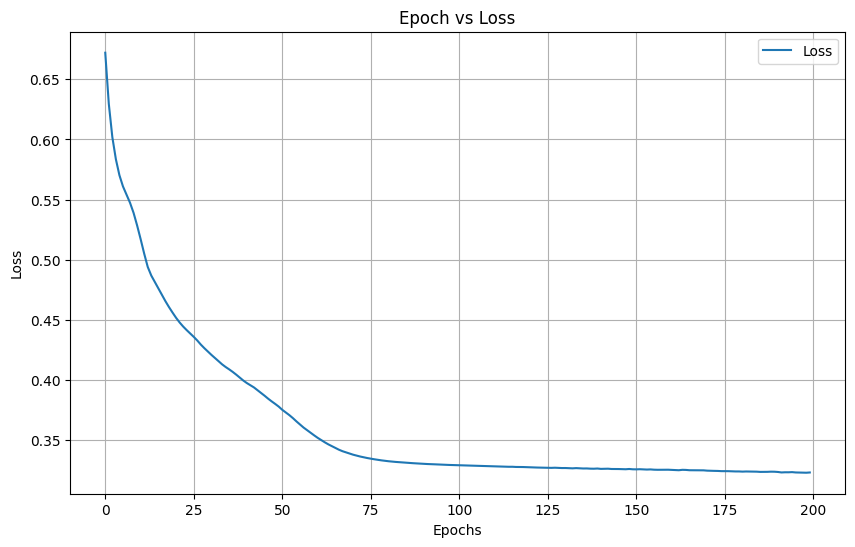

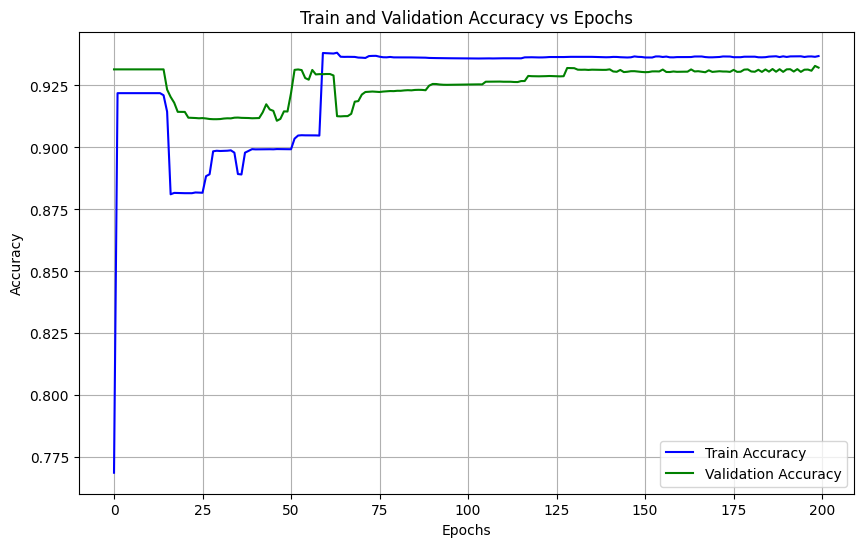

Precision: 0.6186
Recall: 0.4965
F1 Score: 0.5508


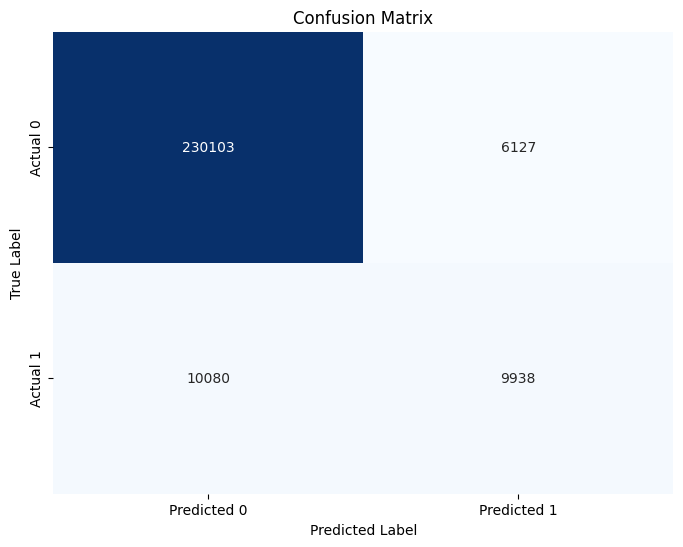

In [33]:
#GRAPHSAGE V 25-11
import os
import torch
import torch.nn.functional as F
import seaborn as sns
from torch_geometric.nn import SAGEConv
from torch_geometric.data import Data
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

# Load edge data
edge_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\2--12\extractedcolumns1.txt"
edges = np.loadtxt(edge_file, dtype=int)

# Load node features
feature_folder = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\2--12\features"
node_features_list = []

for file_name in os.listdir(feature_folder):
    if file_name.startswith("feature") and file_name.endswith(".txt"):
        file_path = os.path.join(feature_folder, file_name)
        try:
            feature_data = np.loadtxt(file_path, dtype=float)
            if feature_data.size == 0:
                print(f"Warning: {file_name} is empty. Skipping this file.")
            else:
                node_features_list.append(feature_data)
        except ValueError as e:
            print(f"Warning: Could not read {file_name}. Error: {e}")

if node_features_list:
    node_features = np.column_stack(node_features_list)
else:
    raise ValueError("No valid feature files found. Please check your input files.")

# Load labels
labels_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\2--12\node_contract_status_connected.txt"
labels = torch.tensor(np.loadtxt(labels_file, dtype=int), dtype=torch.long)

print(f"Node features shape: {node_features.shape}")
print(f"Labels shape: {labels.shape}")

# Create graph
G = nx.DiGraph()
G.add_edges_from(edges)

edge_index = torch.tensor(list(G.edges), dtype=torch.long).t().contiguous()

max_edge_index = edge_index.max()
num_nodes = node_features.shape[0]
print(f"Max edge index: {max_edge_index.item()}, Number of nodes: {num_nodes}")

if max_edge_index >= num_nodes:
    raise IndexError(f"Edge index {max_edge_index.item()} is out of bounds for number of nodes {num_nodes}.")

data = Data(x=torch.tensor(node_features, dtype=torch.float), y=labels, edge_index=edge_index)

# Define GraphSAGE model
class GraphSAGE(torch.nn.Module):
    def __init__(self):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(data.num_node_features, 16)
        self.conv2 = SAGEConv(16, 16)
        self.conv3 = SAGEConv(16, 2)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)
        return x

model = GraphSAGE()

# Class weights for imbalanced classes
class_counts = torch.bincount(data.y)
class_weights = 1.0 / torch.sqrt(class_counts.float() + 1e-6)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training mask
y_0_indices = (data.y == 0).nonzero(as_tuple=True)[0]
y_1_indices = (data.y == 1).nonzero(as_tuple=True)[0]
train_indices = torch.cat([y_0_indices, y_1_indices])
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[train_indices] = True

# Load new features and labels for validation
new_feature_folder = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\25-11\features"
new_labels_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\25-11\node_contract_status_connected.txt" 
new_edge_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\25-11\extractedcolumns1.txt" 

new_node_features_list = []
for file_name in os.listdir(new_feature_folder):
    if file_name.startswith("feature") and file_name.endswith(".txt"):
        file_path = os.path.join(new_feature_folder, file_name)
        try:
            feature_data = np.loadtxt(file_path, dtype=float)
            if feature_data.size == 0:
                print(f"Warning: {file_name} is empty. Skipping this file.")
            else:
                new_node_features_list.append(feature_data)
        except ValueError as e:
            print(f"Warning: Could not read {file_name}. Error: {e}")

if new_node_features_list:
    new_node_features = np.column_stack(new_node_features_list)
    new_labels = torch.tensor(np.loadtxt(new_labels_file, dtype=int), dtype=torch.long)
else:
    raise ValueError("No valid new feature files found. Please check your input files.")

new_edges = np.loadtxt(new_edge_file, dtype=int)
new_edge_index = torch.tensor(list(new_edges), dtype=torch.long).t().contiguous()

# Training and validation
validation_accuracies = []
train_accuracies = []
loss_values = []

for epoch in range(200):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[train_mask], data.y[train_mask])
    loss.backward()
    optimizer.step()

    pred_train = out.argmax(dim=1)
    train_acc = (pred_train[train_mask] == data.y[train_mask]).sum().item() / train_mask.sum().item()

    model.eval()
    with torch.no_grad():
        out_val = model(torch.tensor(new_node_features, dtype=torch.float), new_edge_index)
        pred_val = out_val.argmax(dim=1)
        val_acc = (pred_val == new_labels).sum().item() / new_labels.size(0)

    loss_values.append(loss.item())
    train_accuracies.append(train_acc)
    validation_accuracies.append(val_acc)

    if epoch % 10 == 0:
        print(f'Epoch {epoch:>3} | Loss: {loss.item():.4f} | Train Accuracy: {train_acc*100:.2f}% | Validation Accuracy: {val_acc*100:.2f}%')

# Loss and accuracy plots
plt.figure(figsize=(10, 6))
plt.plot(range(200), loss_values, label="Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Epoch vs Loss")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range(200), train_accuracies, label="Train Accuracy", color='blue')
plt.plot(range(200), validation_accuracies, label="Validation Accuracy", color='green')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train and Validation Accuracy vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

# Evaluation
model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index)
    y_pred = out.argmax(dim=1).cpu().numpy()
    y_true = data.y.cpu().numpy()

conf_matrix = confusion_matrix(y_true[train_mask], y_pred[train_mask])
precision = precision_score(y_true[train_mask], y_pred[train_mask], average='binary', zero_division=0)
recall = recall_score(y_true[train_mask], y_pred[train_mask], average='binary', zero_division=0)
f1 = f1_score(y_true[train_mask], y_pred[train_mask], average='binary', zero_division=0)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


Node features shape: (256248, 6)
Labels shape: torch.Size([256248])
Max edge index: 256247, Number of nodes: 256248
Epoch   0 | Loss: 0.7213 | Train Accuracy: 11.98% | Validation Accuracy: 93.43%
Epoch  10 | Loss: 0.5386 | Train Accuracy: 92.19% | Validation Accuracy: 93.43%
Epoch  20 | Loss: 0.4666 | Train Accuracy: 87.68% | Validation Accuracy: 91.47%
Epoch  30 | Loss: 0.4451 | Train Accuracy: 88.22% | Validation Accuracy: 91.50%
Epoch  40 | Loss: 0.4279 | Train Accuracy: 88.80% | Validation Accuracy: 91.70%
Epoch  50 | Loss: 0.4158 | Train Accuracy: 88.78% | Validation Accuracy: 91.72%
Epoch  60 | Loss: 0.4053 | Train Accuracy: 89.70% | Validation Accuracy: 91.72%
Epoch  70 | Loss: 0.3936 | Train Accuracy: 89.79% | Validation Accuracy: 92.02%
Epoch  80 | Loss: 0.3800 | Train Accuracy: 89.84% | Validation Accuracy: 91.18%
Epoch  90 | Loss: 0.3649 | Train Accuracy: 90.49% | Validation Accuracy: 92.65%
Epoch 100 | Loss: 0.3530 | Train Accuracy: 93.67% | Validation Accuracy: 92.60%
Epoc

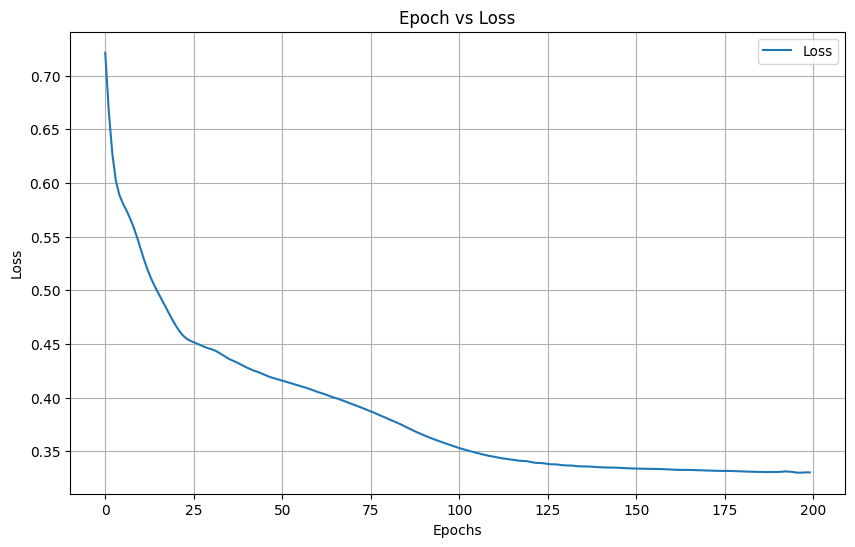

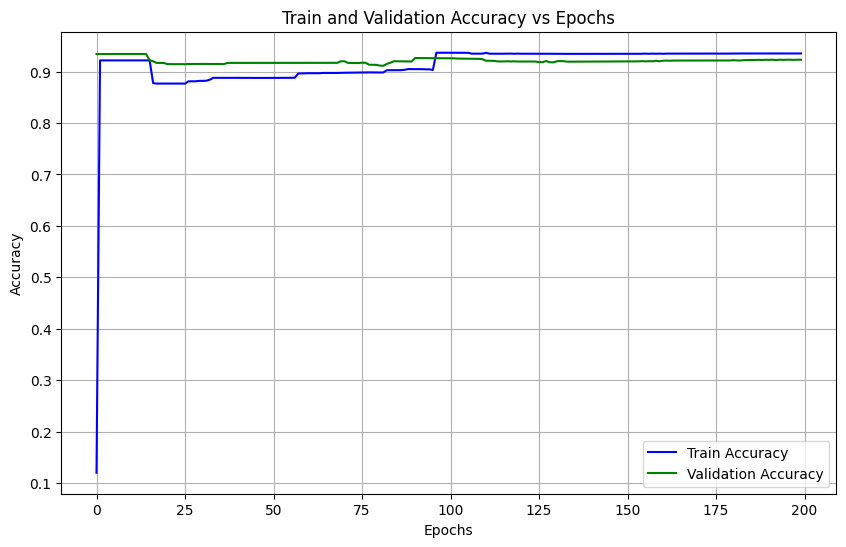

Precision: 0.6044
Recall: 0.4945
F1 Score: 0.5440


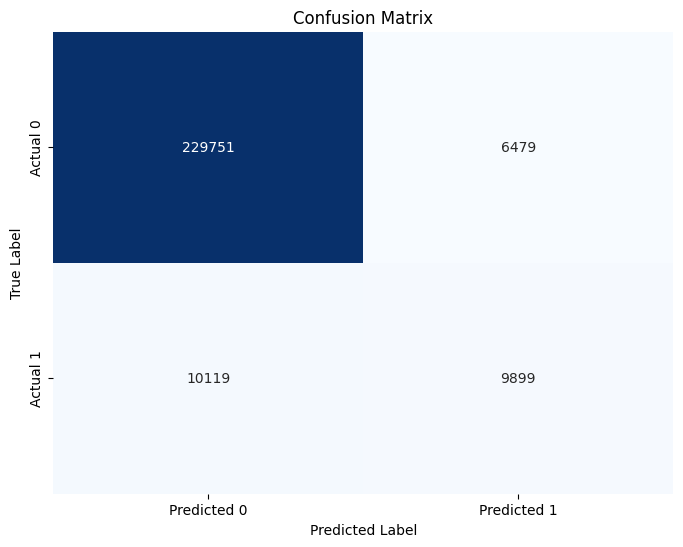

In [32]:
#GRAPHSAGE V 26-11
import os
import torch
import torch.nn.functional as F
import seaborn as sns
from torch_geometric.nn import SAGEConv
from torch_geometric.data import Data
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

# Load edge data
edge_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\2--12\extractedcolumns1.txt"
edges = np.loadtxt(edge_file, dtype=int)

# Load node features
feature_folder = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\2--12\features"
node_features_list = []

for file_name in os.listdir(feature_folder):
    if file_name.startswith("feature") and file_name.endswith(".txt"):
        file_path = os.path.join(feature_folder, file_name)
        try:
            feature_data = np.loadtxt(file_path, dtype=float)
            if feature_data.size == 0:
                print(f"Warning: {file_name} is empty. Skipping this file.")
            else:
                node_features_list.append(feature_data)
        except ValueError as e:
            print(f"Warning: Could not read {file_name}. Error: {e}")

if node_features_list:
    node_features = np.column_stack(node_features_list)
else:
    raise ValueError("No valid feature files found. Please check your input files.")

# Load labels
labels_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\2--12\node_contract_status_connected.txt"
labels = torch.tensor(np.loadtxt(labels_file, dtype=int), dtype=torch.long)

print(f"Node features shape: {node_features.shape}")
print(f"Labels shape: {labels.shape}")

# Create graph
G = nx.DiGraph()
G.add_edges_from(edges)

edge_index = torch.tensor(list(G.edges), dtype=torch.long).t().contiguous()

max_edge_index = edge_index.max()
num_nodes = node_features.shape[0]
print(f"Max edge index: {max_edge_index.item()}, Number of nodes: {num_nodes}")

if max_edge_index >= num_nodes:
    raise IndexError(f"Edge index {max_edge_index.item()} is out of bounds for number of nodes {num_nodes}.")

data = Data(x=torch.tensor(node_features, dtype=torch.float), y=labels, edge_index=edge_index)

# Define GraphSAGE model
class GraphSAGE(torch.nn.Module):
    def __init__(self):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(data.num_node_features, 16)
        self.conv2 = SAGEConv(16, 16)
        self.conv3 = SAGEConv(16, 2)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)
        return x

model = GraphSAGE()

# Class weights for imbalanced classes
class_counts = torch.bincount(data.y)
class_weights = 1.0 / torch.sqrt(class_counts.float() + 1e-6)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training mask
y_0_indices = (data.y == 0).nonzero(as_tuple=True)[0]
y_1_indices = (data.y == 1).nonzero(as_tuple=True)[0]
train_indices = torch.cat([y_0_indices, y_1_indices])
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[train_indices] = True

# Load new features and labels for validation
new_feature_folder = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\26-11\features"
new_labels_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\26-11\node_contract_status_connected.txt" 
new_edge_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\26-11\extractedcolumns1.txt" 

new_node_features_list = []
for file_name in os.listdir(new_feature_folder):
    if file_name.startswith("feature") and file_name.endswith(".txt"):
        file_path = os.path.join(new_feature_folder, file_name)
        try:
            feature_data = np.loadtxt(file_path, dtype=float)
            if feature_data.size == 0:
                print(f"Warning: {file_name} is empty. Skipping this file.")
            else:
                new_node_features_list.append(feature_data)
        except ValueError as e:
            print(f"Warning: Could not read {file_name}. Error: {e}")

if new_node_features_list:
    new_node_features = np.column_stack(new_node_features_list)
    new_labels = torch.tensor(np.loadtxt(new_labels_file, dtype=int), dtype=torch.long)
else:
    raise ValueError("No valid new feature files found. Please check your input files.")

new_edges = np.loadtxt(new_edge_file, dtype=int)
new_edge_index = torch.tensor(list(new_edges), dtype=torch.long).t().contiguous()

# Training and validation
validation_accuracies = []
train_accuracies = []
loss_values = []

for epoch in range(200):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[train_mask], data.y[train_mask])
    loss.backward()
    optimizer.step()

    pred_train = out.argmax(dim=1)
    train_acc = (pred_train[train_mask] == data.y[train_mask]).sum().item() / train_mask.sum().item()

    model.eval()
    with torch.no_grad():
        out_val = model(torch.tensor(new_node_features, dtype=torch.float), new_edge_index)
        pred_val = out_val.argmax(dim=1)
        val_acc = (pred_val == new_labels).sum().item() / new_labels.size(0)

    loss_values.append(loss.item())
    train_accuracies.append(train_acc)
    validation_accuracies.append(val_acc)

    if epoch % 10 == 0:
        print(f'Epoch {epoch:>3} | Loss: {loss.item():.4f} | Train Accuracy: {train_acc*100:.2f}% | Validation Accuracy: {val_acc*100:.2f}%')

# Loss and accuracy plots
plt.figure(figsize=(10, 6))
plt.plot(range(200), loss_values, label="Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Epoch vs Loss")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range(200), train_accuracies, label="Train Accuracy", color='blue')
plt.plot(range(200), validation_accuracies, label="Validation Accuracy", color='green')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train and Validation Accuracy vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

# Evaluation
model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index)
    y_pred = out.argmax(dim=1).cpu().numpy()
    y_true = data.y.cpu().numpy()

conf_matrix = confusion_matrix(y_true[train_mask], y_pred[train_mask])
precision = precision_score(y_true[train_mask], y_pred[train_mask], average='binary', zero_division=0)
recall = recall_score(y_true[train_mask], y_pred[train_mask], average='binary', zero_division=0)
f1 = f1_score(y_true[train_mask], y_pred[train_mask], average='binary', zero_division=0)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
